### **Set working environment** 

In [1]:
# Install Spark NLP from PyPI
!pip install -q spark-nlp==4.0.1 pyspark==3.3.0

To enable Spark session on Google Cloud Vertex AI Workbench Jupyterlab Notebook, follow the steps as follows or refer [here](https://stackoverflow.com/questions/73047089/how-to-start-spark-session-on-vertex-ai-workbench-jupyterlab-notebook/73061535?noredirect=1#comment129061260_73061535).

Sign in to Google Cloud Platform [here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiT9svnmaX5AhVl7jgGHfxgBQYQFnoECAUQAQ&url=https%3A%2F%2Fconsole.cloud.google.com%2F&usg=AOvVaw1GxwHR1WZnDu0xsR-djCrv). Upon sign-in, on the Google Cloud console mainpage, go to ARTIFICIAL INTELLIGENCE section from the Navigation menu (denoted by 3 short horizontal solid lines) on the left panel and select Vertex AI then select Workbench. 
<br>Next, select USER-MANAGED-NOTEBOOK tab on the top panel to create Jupyterlab notebook. 
<br>Follow the following steps inside the notebook after creating the notebook. That is,
go to File->New->Terminal and run the following two commands in the Terminal:
<br>`sudo apt-get update`
<br>`sudo apt-get install default-jdk`

Lastly, verify if Java is installed with version by running this command: `java --version`.

In [2]:
# Import libraries
import time

import sparknlp

from sparknlp.base import *
from sparknlp.common import *
from sparknlp.annotator import *

from pyspark.sql import functions as func
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

# https://github.com/JohnSnowLabs/spark-nlp
# Start spark session
spark=sparknlp.start()

print("Spark NLP version: ", sparknlp.version())
print("Apache Spark version: ", spark.version)

spark

:: loading settings :: url = jar:file:/opt/conda/lib/python3.7/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jupyter/.ivy2/cache
The jars for the packages stored in: /home/jupyter/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-18bf1842-d29a-4d6d-a110-0b9150250be7;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.0.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.code.findbugs#annotations;3.0.1 in central
	found net.jcip#jcip-annotations;1.0 in central
	found com.google.code.findbugs#jsr305;3.0.1 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#l

22/08/04 07:05:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark NLP version:  4.0.1
Apache Spark version:  3.3.0


In [3]:
# https://stackoverflow.com/questions/36786722/how-to-display-full-output-in-jupyter-not-only-last-result
# Display full output in output cell, not only last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [4]:
import pandas as pd

# https://www.kaggle.com/questions-and-answers/118932
# Max rows and columns of pandas dataframe 
pd.options.display.max_rows,pd.options.display.max_columns

# https://thispointer.com/python-pandas-how-to-display-full-dataframe-i-e-print-all-rows-columns-without-truncation/
# Print all the contents of a pandas dataframe
pd.set_option('display.max_rows', None) # Print unlimited number of rows by setting to None, default is 10
pd.set_option('display.max_columns', None) # Do not truncate columns to display all of them by setting to None
pd.set_option('display.width', None) # Auto-detect the width of dataframe to display all columns in single line by setting to None
pd.set_option('display.max_colwidth', None) # Auto detect the max size of column and print contents of that column without truncated the contents

(60, 20)

### **Random Forest with TFIDF**
*   TFIDF=Term frequency-inverse document frequency



#### **Pipeline, GridSearch and Cross Validation**

In [5]:
start = "\033[1m" # Bold text
end = "\033[0;0m" # Reset 

from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="token_features", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features") 

from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol='Recommended IND',weightCol='weightCol',seed=42)

# Configure an ML pipeline, which consists of three stages:
pipeline_rf = Pipeline(stages=[hashingTF,idf,rf])

# Tuning the model with the ParamGridBuilder and the CrossValidator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid_rf = (ParamGridBuilder()
              .addGrid(hashingTF.numFeatures, [10,100,1000,10000])
              .addGrid(idf.minDocFreq, [2,5])  # minDocFreq: remove sparse terms
              .addGrid(rf.numTrees, [20,50,100,150,200])
              .addGrid(rf.maxDepth, [5,10,15,20,25,30])
              .addGrid(rf.impurity, ['gini', 'entropy'])
              .addGrid(rf.featureSubsetStrategy, ['sqrt', 'log2'])
              .build())

from pyspark.ml.evaluation import BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='Recommended IND',metricName='areaUnderPR')

cv_rf = CrossValidator(estimator=pipeline_rf, 
                       estimatorParamMaps=paramGrid_rf, 
                       evaluator=binary_evaluator, 
                       numFolds=3,
                       parallelism=10,
                       seed=42)

#### **Mount to Google Drive**
*   On Google Cloud Vertex AI Workbench Jupyterlab Notebook, follow instructions:
    - Either [this](https://stackoverflow.com/questions/61449536/mount-google-drive-from-ai-platform-notebook)
    - Or this - [Terminal commands snapshot within the Google Cloud Platform Vertex AI Workbench Jupyterlab Notebook](https://github.com/wongkhoon/Coursera/blob/23ba493ec53d07aac6bfbcd2e4ec9cc3bd0bd779/Advanced%20Data%20Science%20with%20IBM/Advanced%20Data%20Science%20Capstone/GoogleCloudPlatform_VertexAI_Workbench_JupyterlabNotebook_Terminal_20220722.txt)
<br>

    in order to load train and test set parquet files from Google Drive in Google Cloud platform Vertex AI Jupyterlab notebook

#### **Training**

In [6]:
# To load
train_nlp = spark.read.parquet('mnt/gdrivefs/Colab Notebooks/train_nlp.parquet')

starttrain = time.time()
cvModel_rf = cv_rf.fit(train_nlp)
endtrain = time.time()

22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it
22/08/04 07:05:35 WARN BlockManager: Block rdd_6_0 already exists on this machine; not re-adding it


22/08/04 07:05:48 WARN BlockManager: Block rdd_817_0 already exists on this machine; not re-adding it


22/08/04 07:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1162.1 KiB
22/08/04 07:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1341.4 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1335.6 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1509.6 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
22/08/04 07:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB
22/08/04 07:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1659.2 KiB
22/08/04 07:08:04 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
22/08/04 07:08:04 WAR

22/08/04 07:08:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:08:56 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:08:57 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:08:57 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:08:57 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:08:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:08:58 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:08:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:08:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:08:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:08:58 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:08:59 WARN DAGScheduler: Broadcasting larg

22/08/04 07:09:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:09:05 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:09:05 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:09:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:09:06 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:09:06 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:09:06 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:09:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:09:07 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:09:07 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:09:07 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:09:08 WARN DAGScheduler: Broadcasting larg

22/08/04 07:09:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:09:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:09:09 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:09:09 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB
22/08/04 07:09:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:09:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
22/08/04 07:09:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:09:10 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:09:10 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
22/08/04 07:09:11 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:09:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:09:11 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:09:11 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:09:11 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:09:12 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:09:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:09:12 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:09:12 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:09:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:09:13 WARN DAGScheduler: Broadcastin

22/08/04 07:09:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:09:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:09:18 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:09:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:09:18 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:09:19 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:09:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB
22/08/04 07:09:19 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:09:19 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:09:20 WARN DAGScheduler: Broadcastin

22/08/04 07:09:29 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:09:30 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:09:30 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:09:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:09:30 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:09:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:09:31 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB
22/08/04 07:09:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:09:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:09:32 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB
22/08/04 07:09:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:09:32 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:09:32 WARN DAGScheduler: Broadcastin

22/08/04 07:09:34 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:09:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:09:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
22/08/04 07:09:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:09:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:09:35 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:09:36 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:09:36 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:09:36 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:09:36 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:09:37 WARN DAGScheduler: Broadcastin

22/08/04 07:09:38 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:09:39 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:09:39 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:09:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:09:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:09:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:09:39 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:09:40 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:09:41 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:09:41 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:09:41 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:09:41 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:09:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:09:42 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:09:42 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:09:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:09:43 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:09:44 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 07:09:44 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:09:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:09:44 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:09:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:09:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:09:45 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:09:46 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:09:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:09:47 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:09:47 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:09:47 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:09:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:09:48 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:09:49 WARN DAGScheduler: Broadcasting larg

22/08/04 07:09:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:09:50 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:09:50 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB


22/08/04 07:09:51 WARN DAGScheduler: Broadcasting large task binary with size 1643.2 KiB
22/08/04 07:09:52 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:09:52 WARN DAGScheduler: Broadcasting large task binary with size 1708.0 KiB


22/08/04 07:09:52 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:09:52 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:09:53 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 07:09:53 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:09:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:09:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:09:54 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:09:54 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:09:55 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:09:55 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:09:56 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:09:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:09:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:09:57 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:09:57 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:09:58 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:09:58 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:09:58 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:09:58 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
22/08/04 07:09:59 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:09:59 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:10:00 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB


22/08/04 07:10:01 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:10:02 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:10:02 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:10:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:10:03 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:10:03 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
22/08/04 07:10:03 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:10:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:10:04 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:10:04 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:10:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:10:05 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:10:05 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:10:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:10:06 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:10:06 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:10:07 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:10:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:10:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:10:08 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:10:09 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:10:09 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:10:09 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:10:09 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:10:10 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:10:10 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:10:11 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 07:10:11 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:10:12 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:10:12 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:10:13 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 07:10:14 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 07:10:14 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:10:14 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:10:14 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:10:15 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:10:16 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:10:16 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:10:17 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:10:17 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB
22/08/04 07:10:17 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB
22/08/04 07:10:18 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:10:18 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 07:10:19 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:10:19 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1643.2 KiB
22/08/04 07:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1708.0 KiB


22/08/04 07:10:20 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:10:20 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:10:21 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 07:10:21 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:10:22 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:10:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:10:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:10:23 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:10:23 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:10:24 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:10:24 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:10:24 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:10:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:10:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:10:25 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:10:26 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:10:26 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:10:26 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:10:27 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:10:27 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:10:28 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:10:28 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:10:29 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:10:29 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:10:30 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:10:30 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:10:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:10:31 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:10:31 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 07:10:33 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:10:33 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:10:33 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:10:33 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:10:34 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:10:35 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:10:35 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:10:36 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:10:36 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 07:10:36 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:10:38 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:10:39 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:10:39 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:10:39 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:10:39 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:10:40 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB


22/08/04 07:10:41 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:10:41 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 07:10:41 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:10:42 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:10:43 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 07:10:43 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:10:44 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:10:44 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:10:44 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:10:45 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB
22/08/04 07:10:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:10:46 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 07:10:47 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:10:47 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 07:10:47 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:10:48 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:10:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:10:49 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:10:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:10:49 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:10:50 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:10:50 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:10:50 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:10:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:10:51 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:10:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:10:52 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 07:10:52 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:10:54 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:10:54 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:10:54 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:10:54 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB


22/08/04 07:10:56 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:10:56 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:10:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:10:56 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/08/04 07:10:57 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB
22/08/04 07:10:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 07:10:58 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:10:58 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 07:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB
22/08/04 07:10:59 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:10:59 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:10:59 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:11:00 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:11:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:11:01 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:11:01 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:11:02 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:11:02 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:11:02 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:11:03 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:11:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:11:03 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:11:04 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:11:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:11:05 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 07:11:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:11:05 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:11:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:11:06 WARN DAGScheduler: Broadca

22/08/04 07:11:09 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:11:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:11:10 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/08/04 07:11:10 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB
22/08/04 07:11:11 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:11:11 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 07:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB


22/08/04 07:11:12 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:11:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:11:13 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:11:13 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:11:14 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:11:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB


22/08/04 07:11:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:11:15 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:11:15 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:11:15 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:11:16 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB


22/08/04 07:11:17 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:11:17 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:11:17 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:11:18 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:11:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:11:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:11:19 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:11:19 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:11:20 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:11:20 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:11:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:11:20 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB


22/08/04 07:11:21 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:11:21 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:11:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:11:22 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB


22/08/04 07:11:23 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:11:23 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:11:24 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:11:24 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:11:24 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:11:24 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:11:24 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB


22/08/04 07:11:25 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB
22/08/04 07:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:11:26 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:11:27 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:11:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:11:27 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:11:27 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:11:28 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:11:28 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:11:29 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:11:30 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:11:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:11:30 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:11:30 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:11:31 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:11:31 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:11:31 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:11:32 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:11:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:11:33 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:11:33 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:11:34 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:11:34 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:11:35 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:11:36 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:11:36 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:11:37 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:11:37 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:11:38 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB


22/08/04 07:11:38 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:11:38 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:11:39 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:11:39 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:11:39 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:11:40 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:11:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:11:42 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:11:42 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:11:43 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:11:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:11:44 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:11:45 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:11:45 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 07:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:11:46 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:11:47 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:11:47 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB


22/08/04 07:11:48 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:11:48 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:11:49 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:11:50 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:11:50 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:11:50 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:11:51 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 07:11:52 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/08/04 07:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:11:52 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB


22/08/04 07:11:53 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:11:53 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:11:54 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:11:54 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:11:55 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:11:55 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB
22/08/04 07:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB


22/08/04 07:11:56 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB


22/08/04 07:11:56 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:11:57 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 07:11:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:11:58 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:11:58 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:11:58 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:11:59 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:11:59 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:11:59 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:12:00 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:12:01 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:12:01 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:12:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:12:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:12:02 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:12:02 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:12:03 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 07:12:04 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:12:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:12:06 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:12:06 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:12:07 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:12:07 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:12:08 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:12:08 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:12:10 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:12:10 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:12:10 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 07:12:11 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:12:11 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:12:11 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:12:12 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:12:12 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:12:14 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 07:12:15 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:12:15 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:12:16 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:12:16 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:12:17 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:12:17 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:12:18 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:12:19 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:12:19 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:12:20 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:12:21 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:12:21 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:12:21 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:12:22 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:12:22 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:12:24 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:12:24 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:12:25 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:12:25 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:12:26 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:12:26 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:12:28 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:12:28 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:12:29 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 07:12:29 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:12:30 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:12:30 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:12:33 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:12:33 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:12:34 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:12:34 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:12:35 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 07:12:35 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB


22/08/04 07:12:37 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 07:12:37 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:12:38 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:12:38 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 07:12:39 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 07:12:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB


22/08/04 07:12:41 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:12:42 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:12:42 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 07:12:43 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 07:12:43 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 07:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB


22/08/04 07:12:44 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1100.8 KiB


22/08/04 07:12:45 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 07:12:46 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:12:46 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:12:47 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:12:48 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 07:12:48 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:12:49 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB


22/08/04 07:12:50 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 07:12:50 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 07:12:51 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:12:52 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 07:12:52 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:12:53 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:12:54 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:12:55 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:12:55 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 07:12:56 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:12:57 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 07:12:57 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:12:58 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:12:59 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 07:12:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:13:00 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:13:01 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:13:01 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:13:02 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 07:13:03 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:13:04 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:13:04 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:13:05 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:13:06 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:13:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:13:07 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:13:08 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:13:08 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:13:09 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 07:13:09 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:13:10 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 07:13:11 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


22/08/04 07:13:13 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 07:13:13 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 07:13:14 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:13:14 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB


22/08/04 07:13:14 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 07:13:15 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB


22/08/04 07:13:17 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 07:13:17 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:13:18 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:13:18 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:13:19 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:13:21 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 07:13:22 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 07:13:22 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:13:23 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:13:24 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:13:25 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:13:26 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:13:26 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB
22/08/04 07:13:27 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:13:28 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 07:13:28 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 07:13:29 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 07:13:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:13:29 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
22/08/04 07:13:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:13:31 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 07:13:31 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:13:32 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB
22/08/04 07:13:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:13:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:13:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:13:34 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 07:13:34 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 07:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB
22/08/04 07:13:35 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:13:35 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 07:13:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:13:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:13:36 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:13:37 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:13:37 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:13:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:13:38 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 07:13:38 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 07:13:39 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:13:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:13:39 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:13:40 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:13:41 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:13:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:13:41 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:13:41 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:13:43 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:13:43 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:13:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:13:44 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:13:45 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 07:13:45 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:13:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB


22/08/04 07:13:47 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:13:47 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 07:13:47 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 07:13:48 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:13:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:13:48 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:13:49 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 07:13:49 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:13:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:13:51 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:13:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:13:52 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:13:54 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 07:13:54 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:13:55 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:13:55 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:13:57 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 07:13:58 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 07:13:59 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:13:59 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB
22/08/04 07:14:00 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB


22/08/04 07:14:01 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 07:14:02 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:14:02 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB
22/08/04 07:14:03 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB
22/08/04 07:14:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:14:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:14:04 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:14:05 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:14:05 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:14:06 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 07:14:06 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
22/08/04 07:14:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:14:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:14:07 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:14:07 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:14:08 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:14:08 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:14:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:14:09 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:14:10 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 07:14:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:14:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:14:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:14:11 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:14:11 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:14:12 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:14:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:14:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:14:14 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 07:14:14 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:14:15 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
22/08/04 07:14:15 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:14:15 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:14:16 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:14:17 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:14:17 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:14:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:14:18 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:14:18 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 07:14:19 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:14:19 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:14:20 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:14:20 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:14:21 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:14:21 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:14:22 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:14:22 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:14:23 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:14:24 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:14:24 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:14:25 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:14:25 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:14:26 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:14:27 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:14:27 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:14:28 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:14:28 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:14:29 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:14:31 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:14:31 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:14:31 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:14:32 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:14:32 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 07:14:33 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:14:35 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:14:35 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:14:36 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 07:14:36 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 07:14:37 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 07:14:38 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:14:39 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 07:14:39 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:14:40 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:14:40 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB
22/08/04 07:14:41 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:14:41 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:14:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:14:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:14:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 07:14:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 07:14:45 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:14:46 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 07:14:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:14:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:14:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:14:48 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:14:49 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 07:14:50 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 07:14:50 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:14:50 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB


22/08/04 07:14:51 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:14:51 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:14:52 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 07:14:53 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/08/04 07:14:53 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
22/08/04 07:14:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:14:54 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:14:55 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:14:56 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:14:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:14:56 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:14:56 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:14:58 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:14:59 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:15:00 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 07:15:00 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:15:00 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:15:00 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:15:01 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:15:02 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 07:15:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:15:04 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:15:05 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 07:15:06 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 07:15:06 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:15:07 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:15:08 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:15:08 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:15:09 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:15:09 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:15:10 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
22/08/04 07:15:11 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:15:12 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 07:15:13 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:15:14 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 07:15:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:15:15 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 07:15:15 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:15:16 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB


22/08/04 07:15:17 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:15:18 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:15:18 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:15:19 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


22/08/04 07:15:20 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:15:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:15:21 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:15:22 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:15:22 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:15:23 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


22/08/04 07:15:24 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 07:15:24 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:15:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:15:25 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:15:27 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 07:15:28 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:15:29 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:15:29 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:15:29 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 07:15:30 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:15:31 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:15:32 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:15:33 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:15:33 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:15:34 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:15:34 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:15:35 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:15:37 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:15:37 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:15:38 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:15:38 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 07:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB


22/08/04 07:15:39 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:15:40 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:15:42 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 07:15:42 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:15:43 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:15:43 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:15:44 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 07:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
22/08/04 07:15:45 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:15:47 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:15:47 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 07:15:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:15:48 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:15:49 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:15:49 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:15:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:15:51 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:15:52 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:15:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 07:15:54 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB
22/08/04 07:15:54 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:15:55 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:15:56 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:15:56 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:15:57 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 07:15:58 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 07:15:59 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 07:16:00 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


22/08/04 07:16:01 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:16:02 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:16:03 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:16:03 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 07:16:04 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 07:16:05 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 07:16:06 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB


22/08/04 07:16:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:16:08 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:16:09 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB
22/08/04 07:16:10 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:16:11 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 07:16:11 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:16:12 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


22/08/04 07:16:14 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:16:15 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 07:16:16 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:16:17 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 07:16:18 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB
22/08/04 07:16:18 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:16:19 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:16:22 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:16:22 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 07:16:23 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 07:16:24 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/08/04 07:16:25 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 07:16:26 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB
22/08/04 07:16:27 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 07:16:30 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 07:16:30 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


22/08/04 07:16:31 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:16:32 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB
22/08/04 07:16:33 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:16:34 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 07:16:35 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 07:16:37 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 07:16:38 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


22/08/04 07:16:39 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 07:16:40 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB
22/08/04 07:16:41 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


22/08/04 07:16:41 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 07:16:42 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:16:45 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


22/08/04 07:16:46 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 07:16:47 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


22/08/04 07:16:48 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB
22/08/04 07:16:49 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB
22/08/04 07:16:49 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:16:50 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:16:53 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 07:16:54 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 07:16:55 WARN DAGScheduler: Broadcasting large task binary with size 22.0 MiB


22/08/04 07:16:56 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB
22/08/04 07:16:56 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 07:16:57 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:17:00 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 07:17:01 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


22/08/04 07:17:02 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 07:17:02 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 07:17:05 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 07:17:06 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB
22/08/04 07:17:06 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
22/08/04 07:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1162.1 KiB


22/08/04 07:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1341.4 KiB
22/08/04 07:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
22/08/04 07:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1509.6 KiB
22/08/04 07:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1335.6 KiB
22/08/04 07:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
22/08/04 07:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1659.2 KiB
22/08/04 07:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB
22/08/04 07:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB


22/08/04 07:17:09 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:17:10 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB


22/08/04 07:17:11 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 07:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB


22/08/04 07:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
22/08/04 07:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1088.7 KiB
22/08/04 07:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1394.1 KiB
22/08/04 07:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1394.9 KiB
22/08/04 07:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1110.1 KiB
22/08/04 07:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1545.0 KiB
22/08/04 07:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB


22/08/04 07:17:14 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:17:15 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 07:17:16 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
22/08/04 07:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1162.1 KiB
22/08/04 07:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1021.5 KiB


22/08/04 07:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1341.4 KiB
22/08/04 07:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1030.9 KiB
22/08/04 07:17:17 WARN DAGScheduler: Broadcasting large task binary with size 1509.6 KiB


22/08/04 07:17:18 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:17:19 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 07:17:20 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 07:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1659.2 KiB


22/08/04 07:17:20 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
22/08/04 07:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
22/08/04 07:17:21 WARN DAGScheduler: Broadcasting large task binary with size 1895.3 KiB
22/08/04 07:17:22 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:17:23 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
22/08/04 07:17:23 WARN DAGScheduler: Broadcasting large task binary with size 1335.6 KiB


22/08/04 07:17:24 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB


22/08/04 07:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1982.6 KiB
22/08/04 07:17:24 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB
22/08/04 07:17:25 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:17:25 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:17:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:26 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 07:17:27 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:17:28 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB


22/08/04 07:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1842.3 KiB
22/08/04 07:17:28 WARN DAGScheduler: Broadcasting large task binary with size 1328.3 KiB
22/08/04 07:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 07:17:29 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
22/08/04 07:17:29 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:17:30 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB
22/08/04 07:17:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 07:17:31 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
22/08/04 07:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB


22/08/04 07:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
22/08/04 07:17:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1394.1 KiB
22/08/04 07:17:33 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 07:17:33 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB


22/08/04 07:17:33 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
22/08/04 07:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1162.1 KiB
22/08/04 07:17:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1545.0 KiB
22/08/04 07:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1341.4 KiB
22/08/04 07:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1394.9 KiB
22/08/04 07:17:35 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
22/08/04 07:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1412.6 KiB
22/08/04 07:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1509.6 KiB
22/08/04 07:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:17:35 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB


22/08/04 07:17:36 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
22/08/04 07:17:36 WARN DAGScheduler: Broadcasting large task binary with size 1335.6 KiB


22/08/04 07:17:37 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB


22/08/04 07:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1659.2 KiB
22/08/04 07:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1790.2 KiB
22/08/04 07:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1720.1 KiB
22/08/04 07:17:37 WARN DAGScheduler: Broadcasting large task binary with size 1522.9 KiB
22/08/04 07:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1885.5 KiB
22/08/04 07:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
22/08/04 07:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1857.2 KiB
22/08/04 07:17:38 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB


22/08/04 07:17:39 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 07:17:39 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:17:40 WARN DAGScheduler: Broadcasting large task binary with size 1962.0 KiB
22/08/04 07:17:40 WARN DAGScheduler: Broadcasting large task binary with size 1895.3 KiB


22/08/04 07:17:40 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/08/04 07:17:40 WARN DAGScheduler: Broadcasting large task binary with size 1972.4 KiB
22/08/04 07:17:40 WARN DAGScheduler: Broadcasting large task binary with size 1842.3 KiB
22/08/04 07:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1982.6 KiB
22/08/04 07:17:41 WARN DAGScheduler: Broadcasting large task binary with size 2022.6 KiB
22/08/04 07:17:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:17:41 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 07:17:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:17:42 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:17:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:42 WARN DAGScheduler: Broadcasting large task binary with size 1280.1 KiB


22/08/04 07:17:43 WARN DAGScheduler: Broadcasting large task binary with size 22.0 MiB
22/08/04 07:17:44 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 07:17:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 07:17:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:44 WARN DAGScheduler: Broadcasting large task binary with size 1360.3 KiB
22/08/04 07:17:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:45 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 07:17:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:17:45 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
22/08/04 07:17:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:17:46 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
22/08/04 07:17:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:17:46 WARN DAGScheduler: Broadca

22/08/04 07:17:48 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB
22/08/04 07:17:48 WARN DAGScheduler: Broadcasting large task binary with size 1394.1 KiB


22/08/04 07:17:49 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 07:17:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:17:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1806.8 KiB
22/08/04 07:17:49 WARN DAGScheduler: Broadcasting large task binary with size 1545.0 KiB
22/08/04 07:17:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:17:50 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1400.3 KiB
22/08/04 07:17:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1790.2 KiB
22/08/04 07:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1523.2 KiB
22/08/04 07:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
22/08/04 07:17:52 WARN DAGSchedu

22/08/04 07:17:53 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 07:17:53 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
22/08/04 07:17:53 WARN DAGScheduler: Broadcasting large task binary with size 1962.0 KiB
22/08/04 07:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1394.9 KiB
22/08/04 07:17:54 WARN DAGScheduler: Broadcasting large task binary with size 2022.6 KiB
22/08/04 07:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB
22/08/04 07:17:54 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:17:54 WARN DAGScheduler: Broadcasting large task binary with size 1139.5 KiB
22/08/04 07:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1162.1 KiB
22/08/04 07:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1720.1 KiB
22/08/04 07:17:55 WARN DAGScheduler: Broadcasting large task binary with size 1997.8 KiB
22/08/04 07:17:55 WARN DAGS

22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 2042.7 KiB


22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:17:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1659.2 KiB
22/08/04 07:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
22/08/04 07:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1842.3 KiB
22/08/04 07:17:58 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/08/04 07:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
22/08/04 07:17:58 WARN DAGSchedu

22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1982.6 KiB
22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB
22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:18:00 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:18:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1790.2 KiB
22/08/04 07:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1213.1 KiB
22/08/04 07:18:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:18:01 WARN DAGScheduler: B

22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1478.4 KiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1564.1 KiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 2022.6 KiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1720.1 KiB
22/08/04 07:18:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:18:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:18:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:18:04 WARN DAGScheduler: Broa

22/08/04 07:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1423.8 KiB
22/08/04 07:18:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1366.5 KiB
22/08/04 07:18:07 WARN DAGScheduler: Broadcasting large task binary with size 1133.6 KiB
22/08/04 07:18:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1419.0 KiB
22/08/04 07:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1558.7 KiB
22/08/04 07:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1790.7 KiB
22/08/04 07:18:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:18:08 WARN DAGScheduler: Broadcasting large task binary with size 1344.7 KiB
22/08/04 07:18:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:18:09 WARN DAGSchedul

22/08/04 07:18:40 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:18:41 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:18:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:18:41 WARN DAGScheduler: Broadcasting large task binary with size 2004.2 KiB
22/08/04 07:18:42 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:18:42 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:18:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:18:42 WARN DAGScheduler: Broadcasting large task binary with size 1218.3 KiB
22/08/04 07:18:43 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:18:43 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:18:43 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:18:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:18:43 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:18:43 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1610.2 KiB
22/08/04 07:18:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:18:44 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:18:44 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:18:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:18:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:18:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:18:45 WARN DAGScheduler: Broadcasting large task binary with size 2045.6 KiB
22/08/04 07:18:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:18:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:18:46 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:18:46 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:18:46 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:18:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:18:46 WARN DAGScheduler: Broadcasting l

22/08/04 07:18:49 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:18:49 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:18:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:18:50 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:18:50 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:18:50 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:18:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:18:51 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:18:51 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:18:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:18:51 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:18:52 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:18:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:18:52 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:18:52 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:18:53 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:18:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:18:53 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:18:53 WARN DAGScheduler: Broadcasting larg

22/08/04 07:18:55 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 07:18:56 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:18:56 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:18:56 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:18:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:18:57 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB
22/08/04 07:18:57 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
22/08/04 07:18:57 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:18:57 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 07:18:58 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:18:58 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:18:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:18:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:18:58 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:18:59 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
22/08/04 07:18:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:18:59 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:18:59 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:18:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:19:00 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:19:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:19:00 WARN DAGScheduler: Broadcastin

22/08/04 07:19:01 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:19:01 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/08/04 07:19:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:19:01 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:19:01 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1307.1 KiB
22/08/04 07:19:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:19:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:19:02 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:19:03 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:19:03 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:19:03 WARN DAGScheduler: Broadcastin

22/08/04 07:19:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:19:20 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:19:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:19:21 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:19:21 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:19:21 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:19:21 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:19:21 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB


22/08/04 07:19:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:19:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:19:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:19:22 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB
22/08/04 07:19:23 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:19:23 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:19:23 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:19:23 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:19:24 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:19:24 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
22/08/04 07:19:24 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:19:25 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:19:25 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:19:25 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:19:26 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:19:26 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:19:26 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:19:27 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:19:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:19:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:19:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:19:27 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:19:28 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:19:28 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:19:29 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:19:29 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:19:29 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:19:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:19:30 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:19:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:19:30 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:19:31 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:19:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:19:31 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:19:32 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:19:32 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:19:32 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:19:32 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:19:33 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:19:34 WARN DAGScheduler: Broadcasting larg

22/08/04 07:19:34 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:19:34 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:19:35 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:19:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:19:36 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:19:36 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:19:37 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 07:19:37 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:19:37 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:19:38 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB
22/08/04 07:19:38 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:19:39 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:19:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:19:40 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:19:40 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
22/08/04 07:19:41 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:19:42 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:19:42 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:19:43 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:19:43 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 07:19:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:19:44 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:19:45 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:19:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:19:45 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 07:19:46 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:19:46 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB


22/08/04 07:19:46 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1245.1 KiB
22/08/04 07:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1212.4 KiB
22/08/04 07:19:47 WARN DAGScheduler: Broadcasting large task binary with size 1643.2 KiB


22/08/04 07:19:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:19:48 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:19:48 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:19:48 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:19:49 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:19:49 WARN DAGScheduler: Broadcasting large task binary with size 1854.8 KiB
22/08/04 07:19:49 WARN DAGScheduler: Broadcasting large task binary with size 1812.1 KiB
22/08/04 07:19:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:19:50 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:19:50 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:19:50 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:19:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:19:51 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:19:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:19:51 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:19:52 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:19:52 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:19:53 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:19:53 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:19:53 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:19:53 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:19:54 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:19:55 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 07:19:55 WARN DAGScheduler: Broadcasting la

22/08/04 07:19:56 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:19:57 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:19:57 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:19:57 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:19:57 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:19:58 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:19:59 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:19:59 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 07:19:59 WARN DAGScheduler: Broadcasting large task binary with size 1164.5 KiB
22/08/04 07:19:59 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:20:00 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:20:00 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 07:20:01 WARN DAGScheduler: Broadcasting large task binary with size 1708.0 KiB
22/08/04 07:20:01 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:20:02 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:20:02 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:20:02 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:20:03 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:20:03 WARN DAGScheduler: Broadcasting large task binary with size 1111.4 KiB
22/08/04 07:20:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:20:04 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:20:04 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:20:04 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:20:05 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:20:05 WARN DAGScheduler: Broadcasting large task binary with size 1643.2 KiB


22/08/04 07:20:05 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:20:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:20:06 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:20:07 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:20:07 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 07:20:07 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:20:08 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:20:08 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 07:20:09 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:20:09 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:20:09 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:20:10 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:20:10 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:20:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:20:11 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:20:12 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:20:12 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:20:12 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:20:13 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:20:13 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:20:13 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:20:14 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:20:15 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:20:15 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:20:15 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:20:16 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:20:16 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:20:16 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:20:17 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:20:18 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:20:18 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:20:18 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 07:20:19 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:20:19 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:20:20 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:20:21 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:20:21 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:20:21 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:20:22 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:20:23 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 07:20:24 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:20:24 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:20:24 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:20:25 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:20:26 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 07:20:26 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:20:27 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:20:27 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 07:20:28 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:20:29 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:20:29 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 07:20:30 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:20:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:20:30 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 07:20:31 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:20:31 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:20:32 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:20:32 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:20:33 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:20:33 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:20:33 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB
22/08/04 07:20:34 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:20:34 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:20:35 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 07:20:35 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:20:36 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:20:36 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:20:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:20:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:20:37 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 07:20:38 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:20:38 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:20:39 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:20:39 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:20:40 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:20:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:20:40 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:20:41 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:20:41 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:20:42 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:20:42 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:20:43 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:20:43 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:20:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:20:44 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:20:44 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/08/04 07:20:44 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB


22/08/04 07:20:45 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:20:45 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:20:46 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:20:46 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:20:46 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB
22/08/04 07:20:47 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:20:47 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:20:47 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:20:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 07:20:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:20:48 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:20:49 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:20:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:20:49 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:20:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:20:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:20:51 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:20:51 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:20:51 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:20:51 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:20:52 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:20:52 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:20:52 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:20:53 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 07:20:53 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:20:54 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:20:54 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:20:55 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:20:55 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:20:55 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:20:56 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:20:56 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:20:57 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:20:57 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:20:58 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 07:20:58 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/08/04 07:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:21:00 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:21:00 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB


22/08/04 07:21:00 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB
22/08/04 07:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB
22/08/04 07:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB
22/08/04 07:21:02 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:21:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:21:03 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:21:03 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:21:03 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:21:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:21:04 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:21:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:21:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:21:05 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:21:06 WARN DAGScheduler: Broadcas

22/08/04 07:21:06 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:21:07 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:21:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:21:08 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:21:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:21:08 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB


22/08/04 07:21:08 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:21:09 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB


22/08/04 07:21:09 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:21:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:21:10 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:21:10 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:21:10 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB
22/08/04 07:21:10 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:21:11 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:21:11 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:21:12 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:21:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:21:12 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:21:12 WARN DAGScheduler: Broadcasting 

22/08/04 07:21:13 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB
22/08/04 07:21:13 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:21:14 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:21:14 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:21:15 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:21:15 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:21:15 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:21:16 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB
22/08/04 07:21:16 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:21:17 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:21:17 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:21:17 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:21:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:21:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:21:19 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:21:19 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:21:19 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:21:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:21:20 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:21:21 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:21:21 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:21:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:21:22 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:21:22 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:21:23 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:21:24 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:21:24 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:21:25 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:21:25 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:21:25 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:21:25 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:21:25 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:21:27 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB


22/08/04 07:21:27 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:21:28 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 07:21:28 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:21:29 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:21:29 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:21:29 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 07:21:30 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:21:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:21:32 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:21:32 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:21:32 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:21:33 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:21:33 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:21:33 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:21:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:21:35 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:21:35 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 07:21:36 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:21:36 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:21:37 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:21:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:21:38 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:21:39 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:21:39 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 07:21:40 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:21:41 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:21:41 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB
22/08/04 07:21:41 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:21:42 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:21:42 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:21:43 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:21:44 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:21:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:21:44 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:21:45 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB


22/08/04 07:21:46 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:21:46 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 07:21:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:21:47 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 07:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB


22/08/04 07:21:48 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:21:49 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:21:49 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:21:50 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 07:21:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:21:50 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:21:51 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:21:52 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 07:21:53 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 07:21:53 WARN DAGScheduler: Broadcasting large task binary with size 1164.1 KiB


22/08/04 07:21:53 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:21:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:21:54 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:21:55 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:21:55 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1120.5 KiB
22/08/04 07:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1856.6 KiB


22/08/04 07:21:56 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:21:57 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:21:57 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:21:57 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1780.9 KiB
22/08/04 07:21:58 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:21:58 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:21:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:21:59 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:22:00 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:22:01 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:22:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:22:01 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:22:02 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:22:02 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 07:22:03 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:22:03 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:22:03 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:22:04 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:22:04 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:22:05 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:22:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:22:06 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 07:22:07 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:22:08 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 07:22:08 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:22:09 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:22:09 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:22:10 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:22:11 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:22:12 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 07:22:12 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:22:13 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1037.6 KiB
22/08/04 07:22:14 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:22:14 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:22:15 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 07:22:16 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:22:16 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1105.1 KiB
22/08/04 07:22:17 WARN DAGScheduler: Broadcasting large task binary with size 1610.7 KiB


22/08/04 07:22:18 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:22:19 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:22:19 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:22:20 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1722.3 KiB


22/08/04 07:22:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:22:20 WARN DAGScheduler: Broadcasting large task binary with size 1065.1 KiB
22/08/04 07:22:21 WARN DAGScheduler: Broadcasting large task binary with size 1100.8 KiB


22/08/04 07:22:21 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 07:22:22 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:22:22 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:22:23 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:22:23 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:22:23 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:22:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:22:25 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:22:26 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:22:26 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:22:27 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:22:27 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:22:28 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 07:22:29 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:22:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:22:30 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 07:22:30 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:22:31 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 07:22:31 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:22:32 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:22:33 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:22:33 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:22:34 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 07:22:35 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 07:22:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:22:36 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:22:37 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:22:37 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:22:37 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 07:22:38 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:22:39 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 07:22:40 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:22:41 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 07:22:41 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 07:22:42 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:22:43 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:22:44 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:22:47 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 07:22:48 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:22:48 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB
22/08/04 07:22:49 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:22:50 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 07:22:50 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 07:22:50 WARN DAGScheduler: Broadcasting large task binary with size 1038.4 KiB


22/08/04 07:22:52 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:22:53 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:22:53 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:22:54 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 07:22:54 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:22:55 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:22:56 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:22:57 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 07:22:58 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 07:22:58 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:22:59 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:23:01 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:23:01 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 07:23:02 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:23:03 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 07:23:03 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:23:05 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:23:06 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 07:23:06 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:23:07 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:23:07 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 07:23:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:23:09 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


22/08/04 07:23:10 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 07:23:11 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 07:23:11 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 07:23:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB
22/08/04 07:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB


22/08/04 07:23:13 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:23:14 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 07:23:14 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:23:14 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB


22/08/04 07:23:15 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:23:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:23:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:23:16 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:23:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:23:17 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:23:18 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 07:23:18 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 07:23:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:23:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:23:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:23:20 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:23:21 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 07:23:21 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:23:22 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 07:23:23 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 07:23:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:23:24 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:23:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:23:25 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:23:25 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 07:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:23:27 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:23:27 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:23:28 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 07:23:28 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:23:28 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 07:23:29 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:23:29 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:23:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:23:30 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:23:31 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 07:23:32 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 07:23:32 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 07:23:33 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:23:33 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB


22/08/04 07:23:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:23:34 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 07:23:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:23:35 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:23:35 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 07:23:36 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:23:36 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:23:37 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:23:37 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:23:38 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:23:39 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:23:39 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:23:40 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 07:23:40 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:23:41 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:23:42 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:23:42 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:23:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:23:44 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 07:23:45 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB


22/08/04 07:23:46 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:23:47 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:23:48 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 07:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB


22/08/04 07:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB
22/08/04 07:23:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB


22/08/04 07:23:49 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:23:50 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:23:50 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:23:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:23:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:23:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:23:51 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 07:23:51 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:23:53 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:23:53 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:23:53 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:23:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:23:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:23:54 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB


22/08/04 07:23:55 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:23:56 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:23:56 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:23:57 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
22/08/04 07:23:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:23:58 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:23:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:23:58 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:23:59 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:23:59 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:24:00 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:24:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:24:01 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 07:24:01 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:24:01 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:24:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:24:03 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:24:03 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:24:03 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:24:04 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:24:04 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:24:05 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 07:24:05 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:24:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:24:06 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:24:07 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:24:07 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:24:07 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:24:08 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:24:08 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:24:09 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:24:09 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:24:10 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:24:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:24:11 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:24:12 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:24:12 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:24:13 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:24:13 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:24:14 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:24:15 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:24:16 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:24:16 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:24:17 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 07:24:17 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:24:18 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 07:24:19 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:24:19 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:24:20 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:24:20 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 07:24:23 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 07:24:23 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:24:24 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:24:24 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:24:25 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:24:26 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:24:28 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:24:28 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:24:29 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:24:30 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 07:24:30 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 07:24:31 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB
22/08/04 07:24:31 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB
22/08/04 07:24:32 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB
22/08/04 07:24:33 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:24:33 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 07:24:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:24:34 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/08/04 07:24:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:24:35 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 07:24:36 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 07:24:36 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB
22/08/04 07:24:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:24:37 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:24:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:24:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:24:39 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 07:24:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:24:40 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:24:41 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:24:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:24:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:24:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:24:42 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:24:43 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:24:44 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:24:45 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:24:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:24:46 WARN DAGScheduler: Broadcasting large task binary with size 1547.5 KiB
22/08/04 07:24:46 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:24:47 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:24:47 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:24:48 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
22/08/04 07:24:48 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:24:49 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 07:24:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:24:51 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:24:51 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:24:51 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:24:53 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


22/08/04 07:24:53 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:24:54 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 07:24:55 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:24:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1442.0 KiB
22/08/04 07:24:56 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:24:57 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:24:58 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
22/08/04 07:24:58 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:24:59 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:25:00 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


22/08/04 07:25:01 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


22/08/04 07:25:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:25:02 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:25:03 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:25:04 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 07:25:04 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:25:05 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:25:05 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 07:25:06 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:25:07 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:25:07 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:25:08 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:25:09 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:25:09 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 07:25:10 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:25:11 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:25:11 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:25:12 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:25:13 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:25:14 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:25:14 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:25:15 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 07:25:15 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:25:16 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 07:25:17 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 07:25:18 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:25:19 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:25:20 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:25:20 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 07:25:21 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:25:23 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:25:23 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 07:25:24 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:25:25 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:25:26 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 07:25:27 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:25:27 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:25:28 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:25:29 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:25:30 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:25:31 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 07:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1437.3 KiB


22/08/04 07:25:32 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:25:33 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
22/08/04 07:25:34 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 07:25:35 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
22/08/04 07:25:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:25:36 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:25:37 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 07:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1353.0 KiB


22/08/04 07:25:38 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 07:25:38 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:25:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:25:39 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:25:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:25:41 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 07:25:42 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB
22/08/04 07:25:43 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 07:25:44 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


22/08/04 07:25:45 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:25:45 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:25:46 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/08/04 07:25:47 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 07:25:48 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


22/08/04 07:25:49 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 07:25:50 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:25:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:25:52 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:25:53 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


22/08/04 07:25:53 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


22/08/04 07:25:54 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
22/08/04 07:25:55 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 07:25:56 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 07:25:58 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:25:58 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:25:59 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 07:26:00 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 07:26:01 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 07:26:02 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


22/08/04 07:26:03 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB


22/08/04 07:26:05 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:26:06 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


22/08/04 07:26:07 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 07:26:07 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:26:08 WARN DAGScheduler: Broadcasting large task binary with size 19.7 MiB


22/08/04 07:26:09 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:26:10 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 07:26:13 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


22/08/04 07:26:14 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB
22/08/04 07:26:15 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 07:26:15 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:26:15 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:26:16 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


22/08/04 07:26:17 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:26:20 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 07:26:20 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


22/08/04 07:26:21 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB
22/08/04 07:26:22 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:26:23 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 07:26:24 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB
22/08/04 07:26:24 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


22/08/04 07:26:28 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
22/08/04 07:26:29 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:26:29 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:26:30 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 07:26:31 WARN DAGScheduler: Broadcasting large task binary with size 22.0 MiB
22/08/04 07:26:32 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 07:26:32 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:26:35 WARN DAGScheduler: Broadcasting large task binary with size 19.8 MiB


22/08/04 07:26:36 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 07:26:37 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB
22/08/04 07:26:37 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:26:38 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


22/08/04 07:26:39 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 07:26:42 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 07:26:43 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 07:26:43 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:26:44 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 07:26:45 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


22/08/04 07:26:49 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:26:50 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 07:26:50 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 07:26:52 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 07:26:53 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 07:26:54 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 07:26:56 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 07:26:57 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 07:26:58 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB


22/08/04 07:26:59 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 07:27:00 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:27:01 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 07:27:03 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 07:27:04 WARN DAGScheduler: Broadcasting large task binary with size 19.2 MiB


22/08/04 07:27:05 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:27:07 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


22/08/04 07:27:08 WARN DAGScheduler: Broadcasting large task binary with size 22.2 MiB


22/08/04 07:27:08 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 07:27:10 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 07:27:11 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 07:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
22/08/04 07:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1101.1 KiB
22/08/04 07:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB
22/08/04 07:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
22/08/04 07:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1193.9 KiB


22/08/04 07:27:14 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB


22/08/04 07:27:15 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 07:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 07:27:16 WARN DAGScheduler: Broadcasting large task binary with size 1359.2 KiB


22/08/04 07:27:17 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 07:27:18 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


22/08/04 07:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
22/08/04 07:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
22/08/04 07:27:20 WARN DAGScheduler: Broadcasting large task binary with size 1210.0 KiB


22/08/04 07:27:21 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB
22/08/04 07:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB


22/08/04 07:27:22 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB
22/08/04 07:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1290.2 KiB


22/08/04 07:27:23 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB
22/08/04 07:27:23 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB


22/08/04 07:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1101.1 KiB
22/08/04 07:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1193.9 KiB
22/08/04 07:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 07:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1359.2 KiB


22/08/04 07:27:26 WARN DAGScheduler: Broadcasting large task binary with size 21.6 MiB


22/08/04 07:27:27 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB
22/08/04 07:27:28 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 07:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB


22/08/04 07:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1437.9 KiB
22/08/04 07:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
22/08/04 07:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1512.6 KiB
22/08/04 07:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1191.1 KiB
22/08/04 07:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
22/08/04 07:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1583.4 KiB
22/08/04 07:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
22/08/04 07:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1266.7 KiB
22/08/04 07:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1651.9 KiB
22/08/04 07:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1210.0 KiB


22/08/04 07:27:30 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 07:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1342.0 KiB
22/08/04 07:27:31 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 07:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB


22/08/04 07:27:32 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB


22/08/04 07:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1290.2 KiB
22/08/04 07:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB
22/08/04 07:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1076.5 KiB
22/08/04 07:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1366.8 KiB
22/08/04 07:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1487.4 KiB
22/08/04 07:27:33 WARN DAGScheduler: Broadcasting large task binary with size 1440.7 KiB


22/08/04 07:27:34 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 07:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1005.1 KiB
22/08/04 07:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1508.7 KiB
22/08/04 07:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
22/08/04 07:27:35 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 07:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1101.1 KiB
22/08/04 07:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1573.1 KiB
22/08/04 07:27:36 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB


22/08/04 07:27:37 WARN DAGScheduler: Broadcasting large task binary with size 22.0 MiB
22/08/04 07:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1193.9 KiB


22/08/04 07:27:37 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1633.5 KiB


22/08/04 07:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1151.2 KiB
22/08/04 07:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 07:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1218.7 KiB
22/08/04 07:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1359.2 KiB
22/08/04 07:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1033.4 KiB
22/08/04 07:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1287.1 KiB
22/08/04 07:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1437.9 KiB
22/08/04 07:27:39 WARN DAGScheduler: Broadcasting large task binary with size 1352.2 KiB
22/08/04 07:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1512.6 KiB
22/08/04 07:27:40 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1583.4 KiB


22/08/04 07:27:41 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 07:27:42 WARN DAGScheduler: Broadcasting large task binary with size 1651.9 KiB
22/08/04 07:27:42 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:27:43 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/08/04 07:27:43 WARN DAGScheduler: Broadcasting large task binary with size 1772.1 KiB
22/08/04 07:27:43 WARN DAGScheduler: Broadcasting large task binary with size 1041.5 KiB
22/08/04 07:27:43 WARN DAGScheduler: Broadcasting large task binary with size 1034.8 KiB
22/08/04 07:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1825.9 KiB
22/08/04 07:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1115.3 KiB
22/08/04 07:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
22/08/04 07:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1876.7 KiB
22/08/04 07:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1191.1 KiB
22/08/04 07:27:44 WARN D

22/08/04 07:27:46 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/08/04 07:27:46 WARN DAGScheduler: Broadcasting large task binary with size 1223.6 KiB


22/08/04 07:27:47 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB


22/08/04 07:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1440.7 KiB
22/08/04 07:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1487.4 KiB
22/08/04 07:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1508.7 KiB
22/08/04 07:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1559.2 KiB
22/08/04 07:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1573.1 KiB
22/08/04 07:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
22/08/04 07:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1633.5 KiB
22/08/04 07:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1695.8 KiB
22/08/04 07:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1007.8 KiB
22/08/04 07:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1691.0 KiB


22/08/04 07:27:50 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 07:27:50 WARN DAGScheduler: Broadcasting large task binary with size 1757.8 KiB
22/08/04 07:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB


22/08/04 07:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1745.2 KiB
22/08/04 07:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1151.2 KiB
22/08/04 07:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1817.6 KiB
22/08/04 07:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1796.9 KiB
22/08/04 07:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1218.7 KiB
22/08/04 07:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1844.1 KiB
22/08/04 07:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1287.1 KiB
22/08/04 07:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1080.9 KiB
22/08/04 07:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1888.3 KiB
22/08/04 07:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1352.2 KiB
22/08/04 07:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1417.0 KiB
22/08/04 07:27:53 WAR

22/08/04 07:27:54 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
22/08/04 07:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1539.2 KiB
22/08/04 07:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1070.2 KiB
22/08/04 07:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1595.3 KiB
22/08/04 07:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1647.8 KiB


22/08/04 07:27:57 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 07:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1070.2 KiB
22/08/04 07:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1285.0 KiB
22/08/04 07:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1088.3 KiB
22/08/04 07:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1245.2 KiB
22/08/04 07:28:00 WARN DAGScheduler: Broadcasting large task binary with size 1512.2 KiB
22/08/04 07:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1409.3 KiB
22/08/04 07:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1750.5 KiB
22/08/04 07:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1581.2 KiB
22/08/04 07:28:02 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 07:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1996.8 KiB
22/08/04 07:28:03 WARN DA

22/08/04 07:28:35 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1162.6 KiB
22/08/04 07:28:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1294.6 KiB
22/08/04 07:28:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:28:36 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1234.2 KiB
22/08/04 07:28:36 WARN DAGScheduler: Broadcasting large task binary with size 1430.6 KiB
22/08/04 07:28:37 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:28:37 WARN DAGScheduler: Broadcasting large task binary with size 1639.5 KiB
22/08/04 07:28:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:28:37 WARN DAGScheduler: Br

22/08/04 07:28:50 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB
22/08/04 07:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1430.6 KiB
22/08/04 07:28:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1563.9 KiB
22/08/04 07:28:52 WARN DAGScheduler: Broadcasting large task binary with size 1975.5 KiB
22/08/04 07:28:52 WARN DAGScheduler: Broadcasting large task binary with size 1287.3 KiB
22/08/04 07:28:52 WARN DAGScheduler: Broadcasting large task binary with size 2022.4 KiB
22/08/04 07:28:52 WARN DAGScheduler: Broadcasting large task binary with size 1721.2 KiB
22/08/04 07:28:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:28:52 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:28:52 WARN DAGSchedul

22/08/04 07:29:03 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:29:03 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1234.2 KiB
22/08/04 07:29:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:29:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:29:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:29:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1563.9 KiB
22/08/04 07:29:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:29:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB
22/08/04 07:29:06 WARN DAGScheduler: Broadcas

22/08/04 07:29:09 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:29:10 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1162.6 KiB
22/08/04 07:29:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:29:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:29:11 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:29:11 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:29:11 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:29:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1430.6 KiB
22/08/04 07:29:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:29:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:29:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:29:12 WARN DAGScheduler: Broadcastin

22/08/04 07:29:14 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:29:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:29:14 WARN DAGScheduler: Broadcasting large task binary with size 2026.8 KiB
22/08/04 07:29:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:29:14 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:29:15 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:29:15 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:29:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:29:16 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:29:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:29:16 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:29:16 WARN DAGScheduler: Broadcasting l

22/08/04 07:29:20 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1563.9 KiB
22/08/04 07:29:20 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:29:21 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1061.3 KiB
22/08/04 07:29:21 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:29:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:29:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:29:22 WARN DAGScheduler: Broadcasting large task binary with size 1923.7 KiB
22/08/04 07:29:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:29:22 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:29:23 WARN DAGScheduler: Broadcas

22/08/04 07:29:29 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:29:29 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:29:30 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:29:31 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:29:31 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:29:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:29:31 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:29:31 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:29:32 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:29:32 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:29:33 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:29:33 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:29:33 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:29:34 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:29:34 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:29:34 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:29:35 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:29:35 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:29:36 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:29:36 WARN DAGScheduler: Broadcasting larg

22/08/04 07:29:37 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:29:37 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:29:38 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:29:38 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:29:38 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:29:40 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:29:40 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:29:40 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:29:40 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:29:40 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB
22/08/04 07:29:41 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:29:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:29:42 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:29:42 WARN DAGScheduler: Broadcasting large task binary with size 1796.1 KiB
22/08/04 07:29:43 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
22/08/04 07:29:43 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:29:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:29:44 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:29:44 WARN DAGScheduler: Broadcas

22/08/04 07:29:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:29:46 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:29:46 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:29:47 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:29:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:29:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:29:47 WARN DAGScheduler: Broadcasting large task binary with size 1299.9 KiB
22/08/04 07:29:47 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:29:48 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 07:29:48 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:29:48 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB
22/08/04 07:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1708.7 KiB
22/08/04 07:29:49 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:29:49 WARN DAGScheduler: Broadcasting large task binary with size 1543.5 KiB
22/08/04 07:29:50 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:29:50 WARN DAGScheduler: Broadcasting large task binary with size 2031.4 KiB
22/08/04 07:29:50 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1537.5 KiB
22/08/04 07:29:51 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB
22/08/04 07:29:51 WARN DAGScheduler:

22/08/04 07:29:52 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:29:52 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
22/08/04 07:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1796.1 KiB
22/08/04 07:29:53 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:29:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1412.3 KiB


22/08/04 07:29:53 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:29:54 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/08/04 07:29:54 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:29:54 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:29:55 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:29:55 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:29:55 WARN DAGScheduler: Broadcasting large task binary with size 1891.2 KiB
22/08/04 07:29:56 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:29:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:29:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:29:57 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:29:57 WARN DAGScheduler: Broadcas

22/08/04 07:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1537.5 KiB
22/08/04 07:30:04 WARN DAGScheduler: Broadcasting large task binary with size 1708.7 KiB
22/08/04 07:30:05 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:30:05 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/08/04 07:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1880.3 KiB
22/08/04 07:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB
22/08/04 07:30:06 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:30:06 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB
22/08/04 07:30:07 WARN DAGSchedul

22/08/04 07:30:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:30:10 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:30:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:30:12 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:30:12 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:30:12 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:30:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:30:13 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:30:13 WARN DAGScheduler: Broadcasting larg

22/08/04 07:30:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:30:14 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:30:15 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:30:15 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:30:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:30:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:30:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:30:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1359.9 KiB


22/08/04 07:30:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:30:17 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:30:18 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:30:18 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:30:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:30:18 WARN DAGScheduler: Broadcasting large task binary with size 1796.1 KiB
22/08/04 07:30:19 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:30:20 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:30:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:30:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:30:20 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:30:21 WARN DAGScheduler: Broadcasting l

22/08/04 07:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1708.7 KiB
22/08/04 07:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:30:23 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:30:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:30:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:30:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB
22/08/04 07:30:25 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:30:25 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:30:25 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 07:30:25 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 07:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1537.5 KiB
22/08/04 07:30:27 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:30:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:30:27 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:30:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:30:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:30:28 WARN DAGScheduler: Broadcasting large task binary with size 1880.3 KiB
22/08/04 07:30:28 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:30:29 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:30:29 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:30:29 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:30:29 WARN DAGScheduler: Broadcastin

22/08/04 07:30:32 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:30:33 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:30:33 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:30:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:30:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:30:34 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:30:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:30:34 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:30:35 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:30:35 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
22/08/04 07:30:35 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:30:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:30:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1329.8 KiB
22/08/04 07:30:36 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:30:37 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:30:37 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:30:38 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1677.7 KiB
22/08/04 07:30:38 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:30:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:30:39 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:30:39 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:30:39 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:30:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:30:40 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:30:41 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:30:41 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 07:30:41 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:30:42 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:30:42 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:30:42 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:30:42 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 07:30:43 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:30:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:30:44 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:30:44 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:30:44 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:30:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:30:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:30:45 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:30:46 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:30:46 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:30:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:30:47 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:30:47 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:30:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:30:47 WARN DAGScheduler: Broadcasting larg

22/08/04 07:30:50 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB


22/08/04 07:30:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:30:52 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:30:52 WARN DAGScheduler: Broadcasting large task binary with size 1537.5 KiB


22/08/04 07:30:52 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:30:52 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:30:53 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 07:30:53 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1880.3 KiB
22/08/04 07:30:54 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:30:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:30:55 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:30:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:30:56 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:30:56 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:30:56 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:30:57 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 07:30:57 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:30:57 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:30:58 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:30:58 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:30:59 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:30:59 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:30:59 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:31:00 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:31:00 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:31:01 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:31:01 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:31:02 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:31:02 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:31:03 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:31:03 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:31:03 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:31:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:31:04 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:31:04 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:31:05 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:31:05 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:31:06 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 07:31:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:31:07 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:31:08 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:31:08 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:31:08 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:31:08 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:31:09 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:31:10 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:31:11 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:31:11 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:31:11 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:31:12 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:31:12 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:31:13 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:31:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:31:14 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 07:31:15 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:31:15 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:31:16 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:31:16 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:31:17 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:31:18 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:31:18 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:31:19 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:31:19 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:31:20 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:31:20 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:31:20 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:31:22 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:31:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:31:23 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:31:23 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 07:31:25 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 07:31:25 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1313.8 KiB
22/08/04 07:31:27 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:31:27 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB
22/08/04 07:31:28 WARN DAGScheduler: Broadcasting large task binary with size 1814.5 KiB
22/08/04 07:31:29 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:31:29 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 07:31:30 WARN DAGScheduler: Broadcasting large task binary with size 1720.9 KiB
22/08/04 07:31:30 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:31:31 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:31:31 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:31:31 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB
22/08/04 07:31:31 WARN DAGScheduler: Broadcasting large task binary with size 1214.2 KiB
22/08/04 07:31:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1313.8 KiB


22/08/04 07:31:33 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:31:33 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:31:34 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1585.9 KiB
22/08/04 07:31:34 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1694.6 KiB
22/08/04 07:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1814.5 KiB
22/08/04 07:31:35 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:31:35 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB
22/08/04 07:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1996.5 KiB


22/08/04 07:31:36 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:31:37 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:31:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:31:38 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:31:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:31:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1997.9 KiB
22/08/04 07:31:38 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1720.9 KiB


22/08/04 07:31:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:31:39 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:31:40 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:31:40 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:31:41 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 07:31:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:31:42 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1829.7 KiB
22/08/04 07:31:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:31:42 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:31:43 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:31:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:31:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:31:43 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 07:31:45 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 07:31:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:31:45 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:31:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:31:46 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:31:47 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:31:48 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:31:49 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:31:49 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:31:49 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:31:50 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:31:51 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:31:52 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:31:53 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:31:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB


22/08/04 07:31:54 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:31:55 WARN DAGScheduler: Broadcasting large task binary with size 1694.6 KiB


22/08/04 07:31:56 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:31:56 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:31:56 WARN DAGScheduler: Broadcasting large task binary with size 1214.2 KiB
22/08/04 07:31:57 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:31:57 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB
22/08/04 07:31:57 WARN DAGScheduler: Broadcasting large task binary with size 1313.8 KiB
22/08/04 07:31:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1585.9 KiB


22/08/04 07:31:58 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:31:58 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB


22/08/04 07:31:59 WARN DAGScheduler: Broadcasting large task binary with size 1694.6 KiB
22/08/04 07:31:59 WARN DAGScheduler: Broadcasting large task binary with size 1814.5 KiB
22/08/04 07:31:59 WARN DAGScheduler: Broadcasting large task binary with size 1996.5 KiB


22/08/04 07:32:00 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 07:32:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:32:00 WARN DAGScheduler: Broadcasting large task binary with size 1720.9 KiB
22/08/04 07:32:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:32:01 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:32:03 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:03 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:32:04 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/08/04 07:32:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 07:32:04 WARN DAGScheduler: Broadcasting large task binary with size 1214.2 KiB
22/08/04 07:32:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:32:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:32:05 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:32:05 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:32:06 WARN DAGScheduler: Broadcasting large task binary with size 1585.9 KiB
22/08/04 07:32:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:32:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:32:06 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:32:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:32:07 WARN DAGScheduler: Broadcasting large task binary with size 1996.5 KiB
22/08/04 07:32:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:32:08 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:32:09 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:32:09 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:32:09 WARN DAGScheduler: Broadcastin

22/08/04 07:32:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:32:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:32:13 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:32:14 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:32:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:32:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1313.8 KiB
22/08/04 07:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB
22/08/04 07:32:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:32:16 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:17 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:32:17 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:32:17 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1814.5 KiB
22/08/04 07:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1720.9 KiB


22/08/04 07:32:18 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB
22/08/04 07:32:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:32:19 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:32:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:32:20 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:32:20 WARN DAGScheduler: Broadcasting large task binary with size 1694.6 KiB
22/08/04 07:32:20 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:21 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:21 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:32:21 WARN DAGScheduler: Broadcasting large task binary with size 1214.2 KiB
22/08/04 07:32:21 WARN DAGScheduler: Broadcas

22/08/04 07:32:21 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:32:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:32:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:32:23 WARN DAGScheduler: Broadcasting large task binary with size 1585.9 KiB
22/08/04 07:32:23 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 07:32:24 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:32:24 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:32:24 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:32:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:32:25 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1996.5 KiB
22/08/04 07:32:25 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:32:26 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:32:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:32:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:32:27 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:32:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:32:28 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:32:28 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:32:29 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:32:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1313.8 KiB


22/08/04 07:32:30 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:32:31 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:32:31 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 07:32:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:32:32 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1814.5 KiB


22/08/04 07:32:32 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:32:33 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:32:33 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:32:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:32:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:32:34 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:32:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:32:35 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:32:35 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:32:36 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:32:36 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:32:36 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:32:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:32:37 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:32:38 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:32:38 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:32:39 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:32:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:32:40 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:32:40 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:32:40 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:32:41 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:32:41 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:32:42 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:42 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:32:42 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:32:43 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1315.8 KiB
22/08/04 07:32:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:32:44 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:32:45 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:32:45 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:32:45 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:32:46 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1720.9 KiB
22/08/04 07:32:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:32:48 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 07:32:48 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:32:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:32:48 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:32:49 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:32:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:32:50 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:32:51 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:32:51 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:32:52 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 07:32:52 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 07:32:53 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:32:53 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:32:54 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:32:55 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:32:55 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:32:55 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:32:56 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 07:32:56 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:32:57 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:32:58 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 07:32:58 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:32:59 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:32:59 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:33:00 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:33:00 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:33:01 WARN DAGScheduler: Broadcasting large task binary with size 1241.5 KiB


22/08/04 07:33:01 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1214.2 KiB
22/08/04 07:33:02 WARN DAGScheduler: Broadcasting large task binary with size 1694.6 KiB
22/08/04 07:33:03 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:33:03 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 07:33:04 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:33:04 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:33:05 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1585.9 KiB
22/08/04 07:33:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:33:06 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:33:06 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1996.5 KiB


22/08/04 07:33:08 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 07:33:08 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:33:08 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:33:09 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:33:09 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 07:33:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:33:10 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:33:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:33:12 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 07:33:12 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 07:33:13 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:33:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 07:33:13 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 07:33:14 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 07:33:15 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:33:15 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:33:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:33:16 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 07:33:17 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:33:18 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:33:18 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:33:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:33:19 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:33:20 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:33:20 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 07:33:21 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:33:22 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 07:33:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:33:22 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:33:23 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:33:23 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:33:24 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:33:25 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:33:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 07:33:26 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:33:27 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:33:28 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 07:33:29 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 07:33:29 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:33:31 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:33:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:33:32 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


22/08/04 07:33:32 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:33:33 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:33:34 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:33:34 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:33:35 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 07:33:36 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:33:37 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:33:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:33:38 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 07:33:39 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:33:40 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 07:33:40 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:33:41 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 07:33:43 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:33:43 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:33:44 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 07:33:46 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 07:33:47 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 07:33:48 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:33:48 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


22/08/04 07:33:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 07:33:51 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 07:33:51 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:33:53 WARN DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
22/08/04 07:33:54 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 07:33:55 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:33:55 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 07:33:56 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 07:33:56 WARN DAGScheduler: Broadcasting large task binary with size 1258.1 KiB
22/08/04 07:33:57 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB
22/08/04 07:33:57 WARN DAGScheduler: Broadcasting large task binary with size 1037.7 KiB
22/08/04 07:33:57 WARN DAGScheduler: Broadcasting large task binary with size 1115.6 KiB


22/08/04 07:33:58 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 07:33:59 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 07:34:00 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:34:00 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 07:34:03 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 07:34:04 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:34:04 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 07:34:05 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 07:34:05 WARN BlockManager: Asked to remove block broadcast_36318_piece0, which does not exist
22/08/04 07:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1042.6 KiB


22/08/04 07:34:08 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


22/08/04 07:34:08 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 07:34:09 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 07:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB


22/08/04 07:34:10 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 07:34:10 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB
22/08/04 07:34:10 WARN DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
22/08/04 07:34:11 WARN DAGScheduler: Broadcasting large task binary with size 1285.4 KiB
22/08/04 07:34:11 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 07:34:11 WARN DAGScheduler: Broadcasting large task binary with size 1258.1 KiB


22/08/04 07:34:13 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 07:34:13 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:34:13 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 07:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB


22/08/04 07:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1037.7 KiB
22/08/04 07:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1427.4 KiB
22/08/04 07:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1115.6 KiB
22/08/04 07:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1508.6 KiB
22/08/04 07:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1189.9 KiB
22/08/04 07:34:15 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1583.4 KiB
22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1042.6 KiB
22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1266.0 KiB
22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1653.1 KiB
22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB
22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1343.5 KiB
22/08/04 07:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1020.7 KiB
22/08/04 07:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1715.1 KiB
22/08/04 07:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB
22/08/04 07:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1423.0 KiB
22/08/04 07:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1087.1 KiB
22/08/04 07:34:17 WAR

22/08/04 07:34:18 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 07:34:19 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 07:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1221.0 KiB
22/08/04 07:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1436.1 KiB
22/08/04 07:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1287.0 KiB
22/08/04 07:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1511.6 KiB
22/08/04 07:34:20 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 07:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1585.7 KiB
22/08/04 07:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1658.2 KiB
22/08/04 07:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1044.9 KiB


22/08/04 07:34:23 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 07:34:25 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 07:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1085.9 KiB
22/08/04 07:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 07:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1042.6 KiB
22/08/04 07:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1258.1 KiB


22/08/04 07:34:27 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 07:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1037.7 KiB
22/08/04 07:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1124.4 KiB
22/08/04 07:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1345.0 KiB
22/08/04 07:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1115.6 KiB
22/08/04 07:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1205.5 KiB
22/08/04 07:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1427.4 KiB
22/08/04 07:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1189.9 KiB
22/08/04 07:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1285.4 KiB
22/08/04 07:34:29 WARN DAGScheduler: Broadcasting large task binary with size 1508.6 KiB
22/08/04 07:34:29 WARN DAGScheduler: Broadcasting large task binary with size 1266.0 KiB


22/08/04 07:34:29 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 07:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1361.8 KiB
22/08/04 07:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1583.4 KiB
22/08/04 07:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1343.5 KiB
22/08/04 07:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1436.1 KiB
22/08/04 07:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1653.1 KiB
22/08/04 07:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1423.0 KiB
22/08/04 07:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1511.6 KiB
22/08/04 07:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1715.1 KiB
22/08/04 07:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB
22/08/04 07:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1585.7 KiB


22/08/04 07:34:32 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 07:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1775.0 KiB
22/08/04 07:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1573.2 KiB
22/08/04 07:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1020.7 KiB
22/08/04 07:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1658.2 KiB
22/08/04 07:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1828.7 KiB
22/08/04 07:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1087.1 KiB
22/08/04 07:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1646.7 KiB
22/08/04 07:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1724.6 KiB
22/08/04 07:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1153.8 KiB
22/08/04 07:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1880.7 KiB
22/08/04 07:34:33 WARN 

22/08/04 07:34:37 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 07:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1072.6 KiB
22/08/04 07:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1545.2 KiB
22/08/04 07:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1217.3 KiB
22/08/04 07:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1603.6 KiB
22/08/04 07:34:42 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 07:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1072.6 KiB
22/08/04 07:34:45 WARN DAGScheduler: Broadcasting large task binary with size 1083.6 KiB
22/08/04 07:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1286.4 KiB
22/08/04 07:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1170.1 KiB
22/08/04 07:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1245.0 KiB
22/08/04 07:34:46 WARN DA

22/08/04 07:35:13 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:35:13 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:35:14 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:35:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:35:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:35:14 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:35:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:35:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1279.6 KiB
22/08/04 07:35:15 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:35:15 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:35:15 WARN DAGScheduler: Broadcasting l

22/08/04 07:35:23 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1279.6 KiB
22/08/04 07:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1547.2 KiB
22/08/04 07:35:24 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/08/04 07:35:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:35:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:35:25 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1621.8 KiB
22/08/04 07:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1904.4 KiB
22/08/04 07:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB
22/08/04 07:35:26 WARN DAGScheduler: Broadcasting large task binary with size 1164.9 KiB
22/08/04 07:35:26 WARN DAGSchedul

22/08/04 07:35:31 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB
22/08/04 07:35:31 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1621.8 KiB
22/08/04 07:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1904.4 KiB
22/08/04 07:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1543.8 KiB
22/08/04 07:35:33 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:35:33 WARN DAGScheduler: Broadcasting large task binary with size 2002.6 KiB
22/08/04 07:35:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1808.7 KiB
22/08/04 07:35:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:35:34 WARN DAGScheduler:

22/08/04 07:35:42 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:35:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:35:43 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:35:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:35:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:35:43 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:35:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:35:44 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:35:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:35:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:35:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:35:45 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:35:45 WARN DAGScheduler: Broadcasting larg

22/08/04 07:35:47 WARN DAGScheduler: Broadcasting large task binary with size 1547.2 KiB
22/08/04 07:35:47 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 07:35:47 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/08/04 07:35:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1904.4 KiB
22/08/04 07:35:48 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:35:48 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:35:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 07:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB
22/08/04 07:35:49 WARN DAGScheduler: Broadcasting large task binary with size 1279.6 KiB
22/08/04 07:35:49 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:35:49 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:35:49 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:35:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:35:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 07:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1543.8 KiB
22/08/04 07:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1621.8 KiB
22/08/04 07:35:50 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:35:51 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:35:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:35:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:35:51 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:35:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1808.7 KiB
22/08/04 07:35:52 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:35:52 WARN DAGScheduler: Broadcasting large task binary with size 2002.6 KiB
22/08/04 07:35:53 WARN DAGScheduler: Broad

22/08/04 07:35:54 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:35:54 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:35:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:35:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:35:54 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1164.9 KiB
22/08/04 07:35:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:35:55 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:35:55 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:35:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:35:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:35:56 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1423.9 KiB
22/08/04 07:35:56 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:35:57 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:35:57 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:35:57 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1708.6 KiB
22/08/04 07:35:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:35:58 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:35:58 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:35:59 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:35:59 WARN DAGScheduler: Broadcasting large task binary with size 2015.6 KiB


22/08/04 07:35:59 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:36:00 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:36:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 07:36:00 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:36:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:36:01 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:36:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:36:01 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:36:02 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:36:02 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:36:03 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:36:03 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:36:03 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:36:04 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:36:04 WARN DAGScheduler: Broadcasting larg

22/08/04 07:36:04 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1068.4 KiB
22/08/04 07:36:05 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:36:05 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:36:05 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:36:05 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1226.0 KiB
22/08/04 07:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB
22/08/04 07:36:06 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:36:07 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:36:07 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:36:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1543.8 KiB
22/08/04 07:36:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1547.2 KiB


22/08/04 07:36:08 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:36:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1808.7 KiB
22/08/04 07:36:09 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:36:09 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:36:09 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1904.4 KiB
22/08/04 07:36:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:36:10 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:36:11 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:36:11 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:36:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:36:12 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:36:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:36:12 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:36:12 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:36:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:36:13 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:36:13 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:36:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:36:14 WARN DAGScheduler: Broadcasting larg

22/08/04 07:36:15 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:36:15 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:36:15 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:36:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:36:16 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:36:17 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:36:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:36:17 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:36:17 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:36:17 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 07:36:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:36:18 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:36:19 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:36:19 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:36:19 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:36:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
22/08/04 07:36:21 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:36:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:36:21 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:36:21 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:36:22 WARN DAGScheduler: Broadcasting l

22/08/04 07:36:23 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:36:23 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1835.2 KiB
22/08/04 07:36:24 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:36:24 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:36:24 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:36:25 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:36:26 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:36:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:36:26 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:36:26 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:36:28 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:36:28 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:36:28 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:36:28 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1028.1 KiB
22/08/04 07:36:29 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1301.3 KiB
22/08/04 07:36:30 WARN DAGScheduler: Broadcasting large task binary with size 1342.8 KiB
22/08/04 07:36:30 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:36:30 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:36:31 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:36:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
22/08/04 07:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB
22/08/04 07:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:36:32 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:36:32 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:36:32 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1251.5 KiB
22/08/04 07:36:33 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:36:33 WARN DAGScheduler: Broadcasting large task binary with size 1378.3 KiB
22/08/04 07:36:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:36:33 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:36:34 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:36:34 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1563.8 KiB
22/08/04 07:36:35 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:36:35 WARN DAGScheduler: Broadcasting large task binary with size 1547.3 KiB
22/08/04 07:36:35 WARN DAGScheduler: Broadcasting large task binary with size 1835.2 KiB
22/08/04 07:36:35 WARN DAGScheduler: Br

22/08/04 07:36:37 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:36:37 WARN DAGScheduler: Broadcasting large task binary with size 1441.1 KiB
22/08/04 07:36:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1885.8 KiB
22/08/04 07:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1028.1 KiB
22/08/04 07:36:39 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:36:39 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1342.8 KiB
22/08/04 07:36:40 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:36:40 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:36:42 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:36:42 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:36:42 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:36:42 WARN DAGScheduler: Broad

22/08/04 07:36:44 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:36:45 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 07:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB
22/08/04 07:36:46 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:36:46 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:36:47 WARN DAGScheduler: Broadcasting large task binary with size 1251.5 KiB
22/08/04 07:36:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:36:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:36:48 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
22/08/04 07:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1563.8 KiB
22/08/04 07:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1028.1 KiB
22/08/04 07:36:49 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:36:49 WARN DAGScheduler: Br

22/08/04 07:36:51 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:36:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1835.2 KiB
22/08/04 07:36:51 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB


22/08/04 07:36:52 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:36:52 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB
22/08/04 07:36:52 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:36:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:36:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:36:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:36:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:36:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1251.5 KiB
22/08/04 07:36:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:36:55 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:36:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:36:55 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:36:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
22/08/04 07:36:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1563.8 KiB
22/08/04 07:36:56 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1378.3 KiB
22/08/04 07:36:56 WARN DAGScheduler: Broad

22/08/04 07:36:57 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:36:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:36:57 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:36:57 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:36:57 WARN DAGScheduler: Broadcasting large task binary with size 1914.4 KiB
22/08/04 07:36:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1835.2 KiB
22/08/04 07:36:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:36:59 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:36:59 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:36:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:36:59 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:37:00 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:37:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:37:00 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:37:01 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 07:37:01 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:37:02 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:37:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:37:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:37:02 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:37:03 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:37:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:37:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:37:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:37:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:37:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:37:05 WARN DAGScheduler: Broadcasting larg

22/08/04 07:37:08 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:37:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:37:09 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:37:10 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:37:10 WARN DAGScheduler: Broadcasting large task binary with size 1301.3 KiB
22/08/04 07:37:10 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:37:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:37:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB
22/08/04 07:37:12 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:37:12 WARN DAGScheduler: Broadcas

22/08/04 07:37:13 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:37:13 WARN DAGScheduler: Broadcasting large task binary with size 1251.5 KiB
22/08/04 07:37:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:37:14 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB


22/08/04 07:37:14 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1563.8 KiB
22/08/04 07:37:15 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:37:15 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:37:15 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1378.3 KiB
22/08/04 07:37:16 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:37:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:37:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1914.4 KiB


22/08/04 07:37:17 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:37:17 WARN DAGScheduler: Broadcasting large task binary with size 1835.2 KiB
22/08/04 07:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1028.1 KiB
22/08/04 07:37:18 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:37:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:37:18 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:37:18 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:37:19 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:37:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:37:19 WARN DAGScheduler: Broadcasting large task binary with size 1342.8 KiB
22/08/04 07:37:20 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:37:20 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:37:20 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:37:20 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:37:21 WARN DAGScheduler: Broadcasting large task binary with size 1691.9 KiB
22/08/04 07:37:21 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:37:21 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:37:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:37:22 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:37:22 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:37:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:37:23 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:37:23 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:37:24 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:37:24 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:37:24 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:37:24 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:37:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:37:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:37:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:37:26 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:37:26 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:37:26 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:37:27 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:37:28 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:37:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:37:28 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:37:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:37:29 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:37:29 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:37:29 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:37:30 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:37:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:37:31 WARN DAGScheduler: Broadcasting larg

22/08/04 07:37:34 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:37:34 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:37:35 WARN DAGScheduler: Broadcasting large task binary with size 1718.0 KiB


22/08/04 07:37:35 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:37:35 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:37:36 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:37:37 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:37:37 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 07:37:37 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:37:37 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:37:38 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:37:38 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:37:39 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:37:39 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1251.5 KiB
22/08/04 07:37:40 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:37:40 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:37:41 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:37:41 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:37:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:37:42 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1563.8 KiB
22/08/04 07:37:43 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:37:43 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:37:43 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:37:44 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:37:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1914.4 KiB
22/08/04 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:37:45 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:37:46 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:37:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:37:47 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:37:47 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:37:47 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:37:48 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:37:48 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:37:49 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:37:49 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:37:50 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:37:50 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:37:51 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:37:51 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:37:52 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:37:52 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:37:53 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:37:53 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:37:54 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:37:54 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:37:54 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:37:55 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:37:55 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 07:37:56 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:37:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:37:57 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:37:57 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:37:57 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 07:37:58 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:37:58 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:37:59 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:37:59 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:37:59 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 07:38:02 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 07:38:02 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:38:02 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:38:03 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:38:03 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:38:04 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:38:05 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:38:06 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:38:06 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 07:38:07 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:38:08 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 07:38:08 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:38:09 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:38:10 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 07:38:10 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 07:38:11 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:38:11 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:38:13 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 07:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB


22/08/04 07:38:14 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:38:14 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:38:14 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/08/04 07:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1310.7 KiB
22/08/04 07:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1752.7 KiB
22/08/04 07:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB


22/08/04 07:38:17 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:38:17 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 07:38:17 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/08/04 07:38:17 WARN DAGScheduler: Broadcasting large task binary with size 1807.0 KiB
22/08/04 07:38:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:38:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:38:18 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:38:18 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
22/08/04 07:38:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:38:19 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:38:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:38:20 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:38:20 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB
22/08/04 07:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1310.7 KiB
22/08/04 07:38:21 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:38:21 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:38:22 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:38:22 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB


22/08/04 07:38:22 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:38:22 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1807.0 KiB
22/08/04 07:38:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:38:24 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:38:24 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:38:25 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
22/08/04 07:38:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:38:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:38:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1858.1 KiB


22/08/04 07:38:26 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:38:27 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:38:27 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/08/04 07:38:28 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:38:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 07:38:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:38:29 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:38:29 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:38:30 WARN DAGScheduler: Broadcasting large task binary with size 1752.7 KiB


22/08/04 07:38:31 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:38:31 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 07:38:31 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:38:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:38:33 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 07:38:34 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:38:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:38:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:38:35 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 07:38:36 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:38:37 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 07:38:38 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/08/04 07:38:38 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:38:38 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:38:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:38:39 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB


22/08/04 07:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/08/04 07:38:41 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:38:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:38:42 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
22/08/04 07:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/08/04 07:38:42 WARN DAGScheduler: Broadcasting large task binary with size 1310.7 KiB
22/08/04 07:38:42 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:38:43 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/08/04 07:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1752.7 KiB
22/08/04 07:38:44 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB
22/08/04 07:38:44 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1807.0 KiB
22/08/04 07:38:45 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:38:45 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 07:38:45 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/08/04 07:38:46 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:38:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:38:46 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:38:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:38:47 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:38:48 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 07:38:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:38:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:38:49 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:38:49 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:38:49 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:38:50 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:38:50 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:38:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:38:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:38:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:38:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:38:53 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 07:38:53 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:38:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:38:55 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:38:55 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
22/08/04 07:38:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:38:56 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
22/08/04 07:38:57 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:38:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:38:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:38:58 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:38:58 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:38:59 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB
22/08/04 07:38:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 07:39:00 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:39:00 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:39:01 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:39:01 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:39:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:39:02 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:39:03 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:39:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:39:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:39:05 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:39:05 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/08/04 07:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1310.7 KiB


22/08/04 07:39:06 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:39:06 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:39:06 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1752.7 KiB
22/08/04 07:39:07 WARN DAGScheduler: Broadcasting large task binary with size 1807.0 KiB
22/08/04 07:39:08 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:39:08 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/08/04 07:39:09 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:39:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:39:09 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:39:10 WARN DAGScheduler: Broadcas

22/08/04 07:39:10 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/08/04 07:39:11 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:39:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:39:12 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:39:12 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:39:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:39:13 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:39:13 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:39:14 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:39:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:39:14 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB
22/08/04 07:39:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:39:15 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:39:15 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:39:16 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB
22/08/04 07:39:16 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:39:17 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:39:17 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1310.7 KiB
22/08/04 07:39:17 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:39:18 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB
22/08/04 07:39:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:39:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:39:19 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:39:20 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1807.0 KiB
22/08/04 07:39:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:39:20 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:39:21 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:39:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:39:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 07:39:22 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:39:22 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:39:23 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 07:39:23 WARN DAGScheduler: Broadcasting large task binary with size 1329.6 KiB
22/08/04 07:39:24 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:39:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:39:24 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:39:25 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:39:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:39:25 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1752.7 KiB
22/08/04 07:39:26 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:39:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:39:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:39:27 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:39:27 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:39:28 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:39:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:39:29 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:39:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:39:29 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:39:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:39:30 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:39:31 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:39:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:39:31 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:39:32 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:39:32 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:39:33 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:39:33 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:39:33 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 07:39:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:39:35 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 07:39:35 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:39:35 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:39:36 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:39:36 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:39:37 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:39:37 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:39:38 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:39:38 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:39:38 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:39:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:39:40 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:39:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:39:41 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:39:41 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:39:42 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:39:42 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:39:42 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:39:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:39:44 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:39:45 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB


22/08/04 07:39:46 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:39:46 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:39:47 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:39:47 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:39:48 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB


22/08/04 07:39:49 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:39:50 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:39:50 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:39:50 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:39:51 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 07:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1240.5 KiB


22/08/04 07:39:52 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:39:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1620.4 KiB


22/08/04 07:39:53 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:39:54 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:39:54 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:39:55 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 07:39:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:39:55 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:39:56 WARN DAGScheduler: Broadcasting large task binary with size 2037.5 KiB


22/08/04 07:39:56 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:39:57 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:39:57 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:39:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:39:58 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:39:59 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:39:59 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:40:00 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 07:40:01 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 07:40:01 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 07:40:02 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:40:03 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:40:03 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:40:04 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:40:04 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 07:40:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:40:06 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:40:06 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:40:07 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 07:40:07 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:40:08 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:40:09 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 07:40:10 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:40:10 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:40:10 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 07:40:11 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 07:40:12 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 07:40:13 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:40:14 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:40:14 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:40:14 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:40:15 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 07:40:16 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 07:40:17 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 07:40:18 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 07:40:18 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:40:18 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:40:19 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:40:19 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:40:20 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:40:21 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 07:40:21 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:40:22 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 07:40:23 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:40:24 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:40:24 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:40:25 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 07:40:27 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 07:40:28 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:40:28 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:40:29 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 07:40:31 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 07:40:32 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
22/08/04 07:40:33 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 07:40:33 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 07:40:34 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:40:35 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:40:36 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 07:40:37 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:40:38 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
22/08/04 07:40:38 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:40:39 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 07:40:39 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:40:42 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB
22/08/04 07:40:43 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:40:44 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 07:40:45 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:40:47 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 07:40:48 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 07:40:50 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:40:51 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:40:51 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 07:40:53 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:40:54 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 07:40:56 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
22/08/04 07:40:57 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 07:40:57 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:41:00 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 07:41:00 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 07:41:02 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 07:41:03 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:41:06 WARN DAGScheduler: Broadcasting large task binary with size 18.1 MiB
22/08/04 07:41:06 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB


22/08/04 07:41:06 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:41:07 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB
22/08/04 07:41:08 WARN DAGScheduler: Broadcasting large task binary with size 1148.3 KiB


22/08/04 07:41:08 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 07:41:09 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 07:41:09 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB
22/08/04 07:41:10 WARN DAGScheduler: Broadcasting large task binary with size 1264.4 KiB
22/08/04 07:41:12 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 07:41:13 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 07:41:15 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 07:41:18 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 07:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1062.6 KiB
22/08/04 07:41:19 WARN DAGScheduler: Broadcasting large task binary with size 1114.2 KiB


22/08/04 07:41:20 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 07:41:20 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB
22/08/04 07:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1233.9 KiB
22/08/04 07:41:21 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
22/08/04 07:41:22 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB


22/08/04 07:41:23 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB


22/08/04 07:41:23 WARN DAGScheduler: Broadcasting large task binary with size 1148.3 KiB
22/08/04 07:41:24 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB


22/08/04 07:41:25 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 07:41:25 WARN DAGScheduler: Broadcasting large task binary with size 1264.4 KiB
22/08/04 07:41:26 WARN DAGScheduler: Broadcasting large task binary with size 1328.0 KiB
22/08/04 07:41:27 WARN DAGScheduler: Broadcasting large task binary with size 1395.0 KiB


22/08/04 07:41:27 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 07:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1062.6 KiB
22/08/04 07:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1461.2 KiB
22/08/04 07:41:28 WARN DAGScheduler: Broadcasting large task binary with size 1114.2 KiB
22/08/04 07:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1522.5 KiB
22/08/04 07:41:29 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB
22/08/04 07:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1588.8 KiB
22/08/04 07:41:30 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1233.9 KiB
22/08/04 07:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1290.4 KiB
22/08/04 07:41:31 WARN DAGScheduler: Broadcasting large task binary with size 1025.9 KiB
22/08/04 07:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1344.5 KiB


22/08/04 07:41:32 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 07:41:33 WARN DAGScheduler: Broadcasting large task binary with size 1086.8 KiB
22/08/04 07:41:33 WARN DAGScheduler: Broadcasting large task binary with size 1399.7 KiB
22/08/04 07:41:33 WARN DAGScheduler: Broadcasting large task binary with size 1148.3 KiB
22/08/04 07:41:33 WARN DAGScheduler: Broadcasting large task binary with size 1457.8 KiB
22/08/04 07:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1210.1 KiB
22/08/04 07:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1518.4 KiB
22/08/04 07:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1264.4 KiB
22/08/04 07:41:35 WARN DAGScheduler: Broadcasting large task binary with size 1328.0 KiB
22/08/04 07:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1395.0 KiB
22/08/04 07:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1461.2 KiB
22/08/04 07:41:37 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1522.5 KiB
22/08/04 07:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1062.6 KiB
22/08/04 07:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1588.8 KiB
22/08/04 07:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1114.2 KiB
22/08/04 07:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1643.5 KiB
22/08/04 07:41:39 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB
22/08/04 07:41:40 WARN DAGScheduler: Broadcasting large task binary with size 1233.9 KiB
22/08/04 07:41:40 WARN DAGScheduler: Broadcasting large task binary with size 1704.2 KiB
22/08/04 07:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1290.4 KiB
22/08/04 07:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1758.8 KiB
22/08/04 07:41:41 WARN DAGScheduler: Broadcasting large task binary with size 1344.5 KiB
22/08/04 07:41:42 WAR

22/08/04 07:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
22/08/04 07:41:55 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/08/04 07:41:55 WARN DAGScheduler: Broadcasting large task binary with size 1050.0 KiB
22/08/04 07:41:56 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
22/08/04 07:41:57 WARN DAGScheduler: Broadcasting large task binary with size 1254.9 KiB
22/08/04 07:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1392.3 KiB
22/08/04 07:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1528.4 KiB
22/08/04 07:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/08/04 07:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1050.0 KiB
22/08/04 07:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1679.8 KiB
22/08/04 07:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1127.7 KiB
22/08/04 07:42:01 WAR

22/08/04 07:42:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:42:39 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:42:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 07:42:41 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:42:42 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:42:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:42:43 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:42:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:42:45 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:42:46 WARN DAGScheduler: Broadcasting large task binary with size 1015.0 KiB
22/08/04 07:42:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:42:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:42:47 WARN DAGScheduler: Broadcasting large task binary with size 1198.8 KiB
22/08/04 07:42:48 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:42:48 WARN DAGScheduler: Broadcasting large task binary with size 1113.9 KiB
22/08/04 07:42:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1406.4 KiB
22/08/04 07:42:49 WARN DAGScheduler: Broadcasting large task binary with size 1299.3 KiB
22/08/04 07:42:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:42:50 WARN DAGScheduler: Br

22/08/04 07:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1015.0 KiB
22/08/04 07:43:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:43:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:43:06 WARN DAGScheduler: Broadcasting large task binary with size 1198.8 KiB
22/08/04 07:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1644.0 KiB
22/08/04 07:43:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1406.4 KiB
22/08/04 07:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1113.9 KiB
22/08/04 07:43:09 WARN DAGScheduler: Broadcasting large task binary with size 1619.6 KiB
22/08/04 07:43:10 WARN DAGScheduler: Broadcasting large task binary with size 1807.1 KiB
22/08/04 07:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1299.3 KiB
22/08/04 07:43:11 WARN DAGSche

22/08/04 07:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
22/08/04 07:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1619.6 KiB
22/08/04 07:43:15 WARN DAGScheduler: Broadcasting large task binary with size 1299.3 KiB
22/08/04 07:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1939.8 KiB
22/08/04 07:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1030.1 KiB
22/08/04 07:43:16 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1053.5 KiB
22/08/04 07:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1499.4 KiB
22/08/04 07:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1858.9 KiB
22/08/04 07:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
22/08/04 07:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1082.5 KiB
22/08/04 07:43:17 WARN D

22/08/04 07:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1182.9 KiB
22/08/04 07:43:25 WARN DAGScheduler: Broadcasting large task binary with size 1198.8 KiB
22/08/04 07:43:25 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:43:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:43:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:43:26 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:43:26 WARN DAGScheduler: Broadcasting large task binary with size 1406.4 KiB
22/08/04 07:43:28 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:43:28 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1005.8 KiB
22/08/04 07:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1619.6 KiB
22/08/04 07:43:28 WARN DAGScheduler: Br

22/08/04 07:43:32 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
22/08/04 07:43:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:43:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:43:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:43:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:43:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:43:34 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1018.1 KiB
22/08/04 07:43:35 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:43:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:43:35 WARN DAGScheduler: Broadcasting large task binary with size 1113.9 KiB
22/08/04 07:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1030.1 KiB
22/08/04 07:43:36 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:43:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:43:37 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1053.5 KiB
22/08/04 07:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1299.3 KiB
22/08/04 07:43:38 WARN DAGScheduler: Broadcasting large task binary with size 1082.5 KiB
22/08/04 07:43:38 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:43:39 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:43:39 WARN DAGScheduler: Broadcasting large task binary with size 1104.1 KiB
22/08/04 07:43:39 WARN DAGScheduler: Broadcasting large task binary with size 1499.4 KiB
22/08/04 07:43:39 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:43:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:43:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1126.2 KiB
22/08/04 07:43:40 WARN DAGScheduler:

22/08/04 07:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
22/08/04 07:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1285.9 KiB
22/08/04 07:43:48 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:43:48 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:43:49 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1073.0 KiB
22/08/04 07:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1082.7 KiB
22/08/04 07:43:50 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1111.9 KiB
22/08/04 07:43:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:43:51 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:43:51 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1112.0 KiB
22/08/04 07:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1125.6 KiB
22/08/04 07:43:53 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:43:53 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:43:53 WARN DAGScheduler: Broadcasting large task binary with size 1130.2 KiB
22/08/04 07:43:54 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:43:54 WARN DAGScheduler: Broadcasting large task binary with size 1121.6 KiB
22/08/04 07:43:55 WARN DAGScheduler: Br

22/08/04 07:44:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:44:03 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1622.7 KiB


22/08/04 07:44:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB


22/08/04 07:44:07 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1947.2 KiB


22/08/04 07:44:08 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
22/08/04 07:44:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:44:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:44:10 WARN DAGScheduler: Broadcasting large task binary with size 1476.4 KiB


22/08/04 07:44:10 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 07:44:11 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1764.7 KiB
22/08/04 07:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1083.8 KiB
22/08/04 07:44:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:44:13 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 07:44:14 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB
22/08/04 07:44:14 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:44:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/08/04 07:44:15 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
22/08/04 07:44:16 WARN DAGScheduler: Broadcasting large task binary with size 1559.1 KiB
22/08/04 07:44:16 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:44:17 WARN DAGScheduler: Broadcasting large task binary with size 1622.7 KiB
22/08/04 07:44:18 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:44:18 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:44:18 WARN DAGScheduler: Broadcasting large task binary with size 1476.4 KiB
22/08/04 07:44:19 WARN DAGScheduler:

22/08/04 07:44:20 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:44:20 WARN DAGScheduler: Broadcasting large task binary with size 1063.3 KiB
22/08/04 07:44:20 WARN DAGScheduler: Broadcasting large task binary with size 1764.7 KiB
22/08/04 07:44:20 WARN DAGScheduler: Broadcasting large task binary with size 1426.2 KiB


22/08/04 07:44:21 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:44:21 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB
22/08/04 07:44:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:44:23 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:44:23 WARN DAGScheduler: Broadcasting large task binary with size 1161.5 KiB
22/08/04 07:44:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:44:24 WARN DAGScheduler: Broadcasting large task binary with size 1042.0 KiB
22/08/04 07:44:24 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:44:24 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:44:25 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB
22/08/04 07:44:26 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:44:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:44:26 WARN DAGScheduler: Broadcasting large task binary with size 1140.5 KiB
22/08/04 07:44:27 WARN DAGScheduler: Broadcasting large task binary with size 1083.8 KiB
22/08/04 07:44:27 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:44:27 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:44:28 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/08/04 07:44:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:44:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:44:31 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:44:31 WARN DAGScheduler: Broadcasting large task binary with size 1622.7 KiB
22/08/04 07:44:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:44:32 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:44:32 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB
22/08/04 07:44:33 WARN DAGScheduler: Broadcasting large task binary with size 1947.2 KiB
22/08/04 07:44:34 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB


22/08/04 07:44:34 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:44:34 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:44:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:44:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:44:36 WARN DAGScheduler: Broadcasting large task binary with size 1476.4 KiB


22/08/04 07:44:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:44:38 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1764.7 KiB
22/08/04 07:44:38 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:44:38 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:44:39 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/08/04 07:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1063.3 KiB
22/08/04 07:44:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:44:41 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB
22/08/04 07:44:42 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:44:42 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:44:42 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1161.5 KiB
22/08/04 07:44:42 WARN DAGScheduler: Broadcasting large task binary with size 1083.8 KiB


22/08/04 07:44:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:44:44 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB
22/08/04 07:44:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:44:45 WARN DAGScheduler: Broadcasting large task binary with size 1042.0 KiB
22/08/04 07:44:45 WARN DAGScheduler: Broadcasting large task binary with size 1332.3 KiB
22/08/04 07:44:45 WARN DAGScheduler: Broadcasting large task binary with size 1252.9 KiB
22/08/04 07:44:45 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB
22/08/04 07:44:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:44:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:44:46 WARN DAGScheduler: Broadcasting large task binary with size 1286.8 KiB
22/08/04 07:44:47 WARN DAGScheduler:

22/08/04 07:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1328.1 KiB
22/08/04 07:44:53 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB
22/08/04 07:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1161.5 KiB
22/08/04 07:44:55 WARN DAGScheduler: Broadcasting large task binary with size 1051.5 KiB
22/08/04 07:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:44:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:44:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:44:56 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB
22/08/04 07:44:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1252.9 KiB
22/08/04 07:44:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:44:58 WARN DAGScheduler:

22/08/04 07:45:05 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:45:05 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB
22/08/04 07:45:06 WARN DAGScheduler: Broadcasting large task binary with size 1498.1 KiB


22/08/04 07:45:07 WARN DAGScheduler: Broadcasting large task binary with size 1140.5 KiB
22/08/04 07:45:07 WARN DAGScheduler: Broadcasting large task binary with size 1622.7 KiB
22/08/04 07:45:07 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:45:07 WARN DAGScheduler: Broadcasting large task binary with size 1494.1 KiB
22/08/04 07:45:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1173.1 KiB
22/08/04 07:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/08/04 07:45:08 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1018.4 KiB
22/08/04 07:45:09 WARN DAGScheduler: Broadcasting large task binary with size 1215.1 KiB
22/08/04 07:45:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:45:09 WARN DAGSchedul

22/08/04 07:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1229.4 KiB
22/08/04 07:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1112.2 KiB
22/08/04 07:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1232.6 KiB


22/08/04 07:45:11 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:45:11 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:45:11 WARN DAGScheduler: Broadcasting large task binary with size 1161.5 KiB
22/08/04 07:45:11 WARN DAGScheduler: Broadcasting large task binary with size 1283.0 KiB
22/08/04 07:45:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1476.4 KiB
22/08/04 07:45:12 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB
22/08/04 07:45:13 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:45:13 WARN DAGScheduler: Broadcasting large task binary with size 1328.1 KiB


22/08/04 07:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1252.9 KiB
22/08/04 07:45:14 WARN DAGScheduler: Broadcasting large task binary with size 1764.7 KiB
22/08/04 07:45:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 07:45:14 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:45:15 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:45:15 WARN DAGScheduler: Broadcasting large task binary with size 1364.8 KiB
22/08/04 07:45:15 WARN DAGScheduler: Broadcasting large task binary with size 1286.8 KiB
22/08/04 07:45:16 WARN DAGScheduler: Broadcasting large task binary with size 1368.7 KiB
22/08/04 07:45:16 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:45:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1321.3 KiB
22/08/04 07:45:17 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:45:17 WARN DAGScheduler: Broadcasting large task binary with size 1394.2 KiB


22/08/04 07:45:17 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:45:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1362.9 KiB
22/08/04 07:45:18 WARN DAGScheduler: Broadcasting large task binary with size 1438.9 KiB
22/08/04 07:45:19 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1042.0 KiB
22/08/04 07:45:19 WARN DAGScheduler: Broadcasting large task binary with size 1396.3 KiB
22/08/04 07:45:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:45:20 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1438.2 KiB
22/08/04 07:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1435.3 KiB
22/08/04 07:45:20 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB


22/08/04 07:45:21 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:45:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:45:21 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1140.5 KiB
22/08/04 07:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1162.5 KiB
22/08/04 07:45:22 WARN DAGScheduler: Broadcasting large task binary with size 1449.8 KiB
22/08/04 07:45:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1173.1 KiB
22/08/04 07:45:23 WARN DAGScheduler: Broadcasting large task binary with size 1498.1 KiB
22/08/04 07:45:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:45:24 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:45:24 WARN DAGScheduler: Br

22/08/04 07:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1517.2 KiB
22/08/04 07:45:26 WARN DAGScheduler: Broadcasting large task binary with size 1283.0 KiB
22/08/04 07:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1543.9 KiB
22/08/04 07:45:27 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB
22/08/04 07:45:28 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:45:28 WARN DAGScheduler: Broadcasting large task binary with size 1328.1 KiB
22/08/04 07:45:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:45:28 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:45:29 WARN DAGScheduler: Broadcasting large task binary with size 1534.4 KiB
22/08/04 07:45:29 WARN DAGScheduler: Broadcasting large task binary with size 1364.8 KiB


22/08/04 07:45:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:45:30 WARN DAGScheduler: Broadcasting large task binary with size 1532.5 KiB
22/08/04 07:45:30 WARN DAGScheduler: Broadcasting large task binary with size 1368.7 KiB
22/08/04 07:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1545.4 KiB
22/08/04 07:45:31 WARN DAGScheduler: Broadcasting large task binary with size 1394.2 KiB
22/08/04 07:45:31 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:45:32 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:45:32 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1438.9 KiB
22/08/04 07:45:33 WARN DAGScheduler: Broadcasting large task binary with size 1282.2 KiB


22/08/04 07:45:34 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:45:34 WARN DAGScheduler: Broadcasting large task binary with size 1438.2 KiB


22/08/04 07:45:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:45:35 WARN DAGScheduler: Broadcasting large task binary with size 1461.0 KiB
22/08/04 07:45:36 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:45:36 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:45:37 WARN DAGScheduler: Broadcasting large task binary with size 1483.9 KiB
22/08/04 07:45:38 WARN DAGScheduler: Broadcasting large task binary with size 1487.4 KiB
22/08/04 07:45:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:45:39 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 07:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1494.5 KiB
22/08/04 07:45:39 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB
22/08/04 07:45:40 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:45:40 WARN DAGScheduler: Broadcasting large task binary with size 1502.1 KiB


22/08/04 07:45:41 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:45:42 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:45:42 WARN DAGScheduler: Broadcasting large task binary with size 1253.3 KiB


22/08/04 07:45:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 07:45:44 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:45:45 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:45:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:45:47 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:45:48 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB
22/08/04 07:45:49 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:45:49 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:45:50 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 07:45:51 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB


22/08/04 07:45:52 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:45:53 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:45:53 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 07:45:54 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:45:54 WARN DAGScheduler: Broadcasting large task binary with size 1959.2 KiB
22/08/04 07:45:56 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB
22/08/04 07:45:57 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:45:57 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:45:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:45:57 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:45:57 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
22/08/04 07:45:58 WARN DAGScheduler: Broadcasting large task binary with size 1493.8 KiB


22/08/04 07:45:59 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1058.4 KiB
22/08/04 07:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB
22/08/04 07:46:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:46:01 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:46:02 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1838.3 KiB
22/08/04 07:46:02 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:46:03 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB
22/08/04 07:46:04 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
22/08/04 07:46:04 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:46:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:46:05 WARN DAGScheduler: Broadcasting large task binary with size 1058.4 KiB
22/08/04 07:46:05 WARN DAGScheduler: Broadcasting large task binary with size 1050.4 KiB


22/08/04 07:46:06 WARN DAGScheduler: Broadcasting large task binary with size 1959.2 KiB


22/08/04 07:46:07 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 07:46:07 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:46:07 WARN DAGScheduler: Broadcasting large task binary with size 1131.7 KiB
22/08/04 07:46:08 WARN DAGScheduler: Broadcasting large task binary with size 1945.1 KiB
22/08/04 07:46:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:46:09 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:46:09 WARN DAGScheduler: Broadcasting large task binary with size 1202.3 KiB


22/08/04 07:46:10 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB
22/08/04 07:46:11 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:46:11 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:46:12 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 07:46:12 WARN DAGScheduler: Broadcasting large task binary with size 1326.2 KiB
22/08/04 07:46:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:46:13 WARN DAGScheduler: Broadcasting large task binary with size 1400.6 KiB
22/08/04 07:46:15 WARN DAGScheduler: Broadcasting large task binary with size 1811.3 KiB
22/08/04 07:46:15 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:46:16 WARN DAGScheduler: Broadcasting large task binary with size 1180.3 KiB
22/08/04 07:46:16 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:46:17 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:46:18 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB


22/08/04 07:46:20 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB


22/08/04 07:46:21 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:46:21 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:46:21 WARN DAGScheduler: Broadcasting large task binary with size 1493.8 KiB
22/08/04 07:46:22 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB


22/08/04 07:46:24 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1050.4 KiB
22/08/04 07:46:24 WARN DAGScheduler: Broadcasting large task binary with size 1838.3 KiB
22/08/04 07:46:25 WARN DAGScheduler: Broadcasting large task binary with size 1959.2 KiB


22/08/04 07:46:26 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:46:26 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 07:46:26 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB
22/08/04 07:46:27 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB
22/08/04 07:46:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:46:28 WARN DAGScheduler: Broadcasting large task binary with size 1177.8 KiB
22/08/04 07:46:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:46:29 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:46:29 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
22/08/04 07:46:29 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
22/08/04 07:46:30 WARN DAGScheduler: Broadcasting large task binary with size 1493.8 KiB


22/08/04 07:46:30 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:46:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1058.4 KiB
22/08/04 07:46:31 WARN DAGScheduler: Broadcasting large task binary with size 1309.7 KiB


22/08/04 07:46:32 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 07:46:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1131.7 KiB
22/08/04 07:46:32 WARN DAGScheduler: Broadcasting large task binary with size 1379.8 KiB
22/08/04 07:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1838.3 KiB
22/08/04 07:46:33 WARN DAGScheduler: Broadcasting large task binary with size 1202.3 KiB


22/08/04 07:46:34 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 07:46:34 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:46:34 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB


22/08/04 07:46:34 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:46:35 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB
22/08/04 07:46:35 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB
22/08/04 07:46:36 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:46:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:46:36 WARN DAGScheduler: Broadcasting large task binary with size 1050.4 KiB


22/08/04 07:46:37 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1326.2 KiB
22/08/04 07:46:37 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB
22/08/04 07:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB
22/08/04 07:46:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:46:38 WARN DAGScheduler: Broadcasting large task binary with size 1400.6 KiB
22/08/04 07:46:39 WARN DAGScheduler: Broadcasting large task binary with size 1177.8 KiB
22/08/04 07:46:39 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:46:39 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 07:46:40 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:46:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:46:40 WARN DAGScheduler: Broadcasting large task binary with size 1462.2 KiB
22/08/04 07:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
22/08/04 07:46:41 WARN DAGScheduler: Broadcasting large task binary with size 1959.2 KiB


22/08/04 07:46:42 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:46:42 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:46:42 WARN DAGScheduler: Broadcasting large task binary with size 1309.7 KiB
22/08/04 07:46:43 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:46:43 WARN DAGScheduler: Broadcasting large task binary with size 1508.4 KiB


22/08/04 07:46:44 WARN DAGScheduler: Broadcasting large task binary with size 1379.8 KiB


22/08/04 07:46:44 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:46:45 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:46:45 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:46:45 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:46:45 WARN DAGScheduler: Broadcasting large task binary with size 1573.5 KiB
22/08/04 07:46:46 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB
22/08/04 07:46:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:46:47 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:46:47 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:46:48 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1603.2 KiB
22/08/04 07:46:48 WARN DAGScheduler: Broadcasting large task binary with size 1488.2 KiB
22/08/04 07:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1547.4 KiB
22/08/04 07:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1637.4 KiB
22/08/04 07:46:50 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:46:50 WARN DAGScheduler:

22/08/04 07:46:51 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:46:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 07:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1645.4 KiB


22/08/04 07:46:54 WARN DAGScheduler: Broadcasting large task binary with size 1327.0 KiB
22/08/04 07:46:55 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:46:55 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:46:56 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:46:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:46:56 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB


22/08/04 07:46:58 WARN DAGScheduler: Broadcasting large task binary with size 1058.4 KiB


22/08/04 07:46:59 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:47:00 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:47:00 WARN DAGScheduler: Broadcasting large task binary with size 1131.7 KiB


22/08/04 07:47:00 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:47:00 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:47:01 WARN DAGScheduler: Broadcasting large task binary with size 1202.3 KiB
22/08/04 07:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB
22/08/04 07:47:03 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB
22/08/04 07:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1326.2 KiB
22/08/04 07:47:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 07:47:05 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:47:06 WARN DAGScheduler: Broadcasting large task binary with size 1400.6 KiB
22/08/04 07:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1262.7 KiB
22/08/04 07:47:07 WARN DAGScheduler: Broadcasting large task binary with size 1493.8 KiB


22/08/04 07:47:08 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:47:08 WARN DAGScheduler: Broadcasting large task binary with size 1462.2 KiB
22/08/04 07:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1050.4 KiB
22/08/04 07:47:09 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB
22/08/04 07:47:10 WARN DAGScheduler: Broadcasting large task binary with size 1838.3 KiB
22/08/04 07:47:10 WARN DAGScheduler: Broadcasting large task binary with size 1508.4 KiB
22/08/04 07:47:10 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:47:10 WARN DAGScheduler: Broadcasting large task binary with size 1110.2 KiB
22/08/04 07:47:11 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:47:12 WARN DAGScheduler: Broadcasting large task binary with size 1573.5 KiB
22/08/04 07:47:12 WARN DAGScheduler: Broadcasting large task binary with size 1177.8 KiB
22/08/04 07:47:12 WARN DAGScheduler: Broadcasting large task binary with size 1959.2 KiB
22/08/04 07:47:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:47:13 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 07:47:13 WARN DAGScheduler: Broadcasting large task binary with size 1603.2 KiB
22/08/04 07:47:13 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
22/08/04 07:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1001.1 KiB
22/08/04 07:47:14 WARN DAGScheduler: Broadcasting large task binary with size 1207.6 KiB
22/08/04 07:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1309.7 KiB
22/08/04 07:47:15 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1637.4 KiB
22/08/04 07:47:15 WARN DAGScheduler: Broadcasting large task binary with size 1058.4 KiB
22/08/04 07:47:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 07:47:16 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:47:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1379.8 KiB
22/08/04 07:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1131.7 KiB
22/08/04 07:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1703.6 KiB
22/08/04 07:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1493.8 KiB
22/08/04 07:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB


22/08/04 07:47:18 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1202.3 KiB
22/08/04 07:47:18 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 07:47:19 WARN DAGScheduler: Broadcasting large task binary with size 1762.0 KiB
22/08/04 07:47:19 WARN DAGScheduler: Broadcasting large task binary with size 1488.2 KiB
22/08/04 07:47:20 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:47:20 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1273.6 KiB
22/08/04 07:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1838.3 KiB


22/08/04 07:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1792.9 KiB
22/08/04 07:47:21 WARN DAGScheduler: Broadcasting large task binary with size 1547.4 KiB
22/08/04 07:47:22 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:47:22 WARN DAGScheduler: Broadcasting large task binary with size 1326.2 KiB
22/08/04 07:47:22 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1604.3 KiB
22/08/04 07:47:23 WARN DAGScheduler: Broadcasting large task binary with size 1829.3 KiB
22/08/04 07:47:23 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:47:24 WARN DAGScheduler: Broadcasting large task binary with size 1050.4 KiB
22/08/04 07:47:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:47:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:47:24 WARN DAGScheduler:

22/08/04 07:47:26 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:47:26 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:47:26 WARN DAGScheduler: Broadcasting large task binary with size 1462.2 KiB
22/08/04 07:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1663.4 KiB
22/08/04 07:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1177.8 KiB
22/08/04 07:47:27 WARN DAGScheduler: Broadcasting large task binary with size 1506.0 KiB


22/08/04 07:47:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:47:28 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1508.4 KiB


22/08/04 07:47:28 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1243.4 KiB
22/08/04 07:47:28 WARN DAGScheduler: Broadcasting large task binary with size 1706.6 KiB
22/08/04 07:47:29 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1309.7 KiB
22/08/04 07:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1573.5 KiB
22/08/04 07:47:30 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1764.2 KiB
22/08/04 07:47:30 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:47:31 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 07:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1603.2 KiB
22/08/04 07:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1379.8 KiB
22/08/04 07:47:32 WARN DAGScheduler: Broadcasting large task binary with size 1810.5 KiB
22/08/04 07:47:32 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:47:33 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:47:33 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB
22/08/04 07:47:33 WARN DAGScheduler: Broadcasting large task binary with size 1800.3 KiB
22/08/04 07:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1637.4 KiB


22/08/04 07:47:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1488.2 KiB
22/08/04 07:47:35 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1479.3 KiB
22/08/04 07:47:36 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1703.6 KiB


22/08/04 07:47:37 WARN DAGScheduler: Broadcasting large task binary with size 1547.4 KiB
22/08/04 07:47:37 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:47:37 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 07:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1762.0 KiB
22/08/04 07:47:38 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:47:38 WARN DAGScheduler: Broadcasting large task binary with size 1604.3 KiB


22/08/04 07:47:40 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:47:40 WARN DAGScheduler: Broadcasting large task binary with size 1792.9 KiB
22/08/04 07:47:40 WARN DAGScheduler: Broadcasting large task binary with size 1645.4 KiB


22/08/04 07:47:41 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:47:41 WARN DAGScheduler: Broadcasting large task binary with size 1829.3 KiB
22/08/04 07:47:42 WARN DAGScheduler: Broadcasting large task binary with size 1663.4 KiB


22/08/04 07:47:43 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:47:44 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1859.2 KiB
22/08/04 07:47:44 WARN DAGScheduler: Broadcasting large task binary with size 1706.6 KiB
22/08/04 07:47:44 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1882.8 KiB
22/08/04 07:47:45 WARN DAGScheduler: Broadcasting large task binary with size 1764.2 KiB
22/08/04 07:47:46 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:47:47 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1810.5 KiB
22/08/04 07:47:47 WARN DAGScheduler: Broadcasting large task binary with size 1912.4 KiB
22/08/04 07:47:49 WARN DAGScheduler: Broadcasting large task binary with size 1800.3 KiB
22/08/04 07:47:49 WARN DAGSchedul

22/08/04 07:47:50 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:47:50 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:47:51 WARN DAGScheduler: Broadcasting large task binary with size 2000.8 KiB
22/08/04 07:47:51 WARN DAGScheduler: Broadcasting large task binary with size 1829.1 KiB
22/08/04 07:47:51 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1994.5 KiB
22/08/04 07:47:52 WARN DAGScheduler: Broadcasting large task binary with size 1856.7 KiB


22/08/04 07:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1892.9 KiB
22/08/04 07:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1642.1 KiB
22/08/04 07:47:56 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:47:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:47:56 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:47:57 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:47:57 WARN DAGScheduler: Broadcasting large task binary with size 1906.1 KiB


22/08/04 07:47:59 WARN DAGScheduler: Broadcasting large task binary with size 1880.4 KiB
22/08/04 07:48:01 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:48:01 WARN DAGScheduler: Broadcasting large task binary with size 1615.3 KiB


22/08/04 07:48:01 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:48:02 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:48:03 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:48:06 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 07:48:07 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:48:07 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:48:09 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:48:12 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 07:48:12 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:48:13 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:48:16 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 07:48:16 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:48:16 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
22/08/04 07:48:18 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:48:18 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 07:48:21 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:48:22 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB


22/08/04 07:48:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:48:25 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1051.9 KiB
22/08/04 07:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1106.6 KiB


22/08/04 07:48:27 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1168.0 KiB
22/08/04 07:48:28 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB
22/08/04 07:48:29 WARN DAGScheduler: Broadcasting large task binary with size 1290.7 KiB


22/08/04 07:48:30 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:48:31 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 07:48:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1000.1 KiB
22/08/04 07:48:36 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 07:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1051.9 KiB
22/08/04 07:48:37 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 07:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
22/08/04 07:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1106.6 KiB
22/08/04 07:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB
22/08/04 07:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1168.0 KiB
22/08/04 07:48:38 WARN DAGScheduler: Broadcasting large task binary with size 1133.5 KiB
22/08/04 07:48:39 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB
22/08/04 07:48:39 WARN DAGScheduler: Broadcasting large task binary with size 1193.2 KiB


22/08/04 07:48:40 WARN DAGScheduler: Broadcasting large task binary with size 1290.7 KiB
22/08/04 07:48:40 WARN DAGScheduler: Broadcasting large task binary with size 1347.4 KiB
22/08/04 07:48:41 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:48:42 WARN DAGScheduler: Broadcasting large task binary with size 1405.2 KiB
22/08/04 07:48:42 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
22/08/04 07:48:42 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB
22/08/04 07:48:42 WARN DAGScheduler: Broadcasting large task binary with size 1459.6 KiB
22/08/04 07:48:43 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 07:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1133.5 KiB
22/08/04 07:48:43 WARN DAGScheduler: Broadcasting large task binary with size 1516.8 KiB
22/08/04 07:48:44 WARN DAGScheduler: Broadcasting large task binary with size 1193.2 KiB
22/08/04 07:48:44 WARN DAG

22/08/04 07:48:49 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 07:48:49 WARN DAGScheduler: Broadcasting large task binary with size 1106.6 KiB


22/08/04 07:48:50 WARN DAGScheduler: Broadcasting large task binary with size 1168.0 KiB
22/08/04 07:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1227.0 KiB
22/08/04 07:48:52 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 07:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1290.7 KiB
22/08/04 07:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1347.4 KiB
22/08/04 07:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
22/08/04 07:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1405.2 KiB
22/08/04 07:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1075.9 KiB
22/08/04 07:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1459.6 KiB
22/08/04 07:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1133.5 KiB
22/08/04 07:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1516.8 KiB
22/08/04 07:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1193.2 KiB
22/08/04 07:48:56 WARN DAGScheduler: Broadcasting large task binary with size 1574.9 KiB


22/08/04 07:48:56 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 07:48:57 WARN DAGScheduler: Broadcasting large task binary with size 1248.1 KiB
22/08/04 07:48:57 WARN DAGScheduler: Broadcasting large task binary with size 1629.8 KiB


22/08/04 07:48:57 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1301.6 KiB
22/08/04 07:48:58 WARN DAGScheduler: Broadcasting large task binary with size 1678.7 KiB


22/08/04 07:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1731.5 KiB
22/08/04 07:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1361.7 KiB
22/08/04 07:48:59 WARN DAGScheduler: Broadcasting large task binary with size 1785.9 KiB
22/08/04 07:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1415.8 KiB
22/08/04 07:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1829.6 KiB
22/08/04 07:49:00 WARN DAGScheduler: Broadcasting large task binary with size 1468.4 KiB
22/08/04 07:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1513.8 KiB
22/08/04 07:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1038.9 KiB
22/08/04 07:49:02 WARN DAGScheduler: Broadcasting large task binary with size 1562.6 KiB
22/08/04 07:49:03 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 07:49:03 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 07:49:03 WARN DA

22/08/04 07:49:12 WARN DAGScheduler: Broadcasting large task binary with size 1071.5 KiB


22/08/04 07:49:15 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 07:49:16 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 07:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/08/04 07:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1243.5 KiB
22/08/04 07:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1071.5 KiB
22/08/04 07:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1390.6 KiB
22/08/04 07:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB
22/08/04 07:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1311.3 KiB
22/08/04 07:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1532.2 KiB
22/08/04 07:49:21 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:49:22 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 07:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1447.2 KiB


22/08/04 07:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1675.2 KiB
22/08/04 07:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1577.2 KiB
22/08/04 07:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1825.5 KiB
22/08/04 07:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1712.3 KiB
22/08/04 07:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1029.3 KiB
22/08/04 07:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1113.1 KiB
22/08/04 07:49:26 WARN DAGScheduler: Broadcasting large task binary with size 1243.5 KiB
22/08/04 07:49:27 WARN DAGScheduler: Broadcasting large task binary with size 1390.6 KiB
22/08/04 07:49:27 WARN DAGScheduler: Broadcasting large task binary with size 1071.5 KiB
22/08/04 07:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1532.2 KiB
22/08/04 07:49:29 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB
22/08/04 07:49:29 WAR

22/08/04 07:50:00 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1696.5 KiB
22/08/04 07:50:00 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:50:00 WARN DAGScheduler: Broadcasting large task binary with size 1425.0 KiB
22/08/04 07:50:02 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:50:02 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:50:03 WARN DAGScheduler: Broadcasting large task binary with size 1643.6 KiB
22/08/04 07:50:03 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:50:03 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:50:05 WARN DAGScheduler: Broadcasting large task binary with size 1884.5 KiB
22/08/04 07:50:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:50:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:50:06 WARN DAGScheduler: Broadcasting large task binary with size 1096.2 KiB
22/08/04 07:50:07 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:50:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:50:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:50:08 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB
22/08/04 07:50:09 WARN DAGScheduler: Broadcasting large task binary with size 1142.0 KiB
22/08/04 07:50:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:50:10 WARN DAGScheduler: Broad

22/08/04 07:50:37 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:50:37 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:50:37 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1755.2 KiB


22/08/04 07:50:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1992.3 KiB
22/08/04 07:50:39 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:50:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:50:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:50:41 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:50:42 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:50:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:50:43 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:50:43 WARN DAGScheduler: Broadcasting large task binary with size 1014.1 KiB
22/08/04 07:50:44 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:50:44 WARN DAGScheduler: Broadcastin

22/08/04 07:51:01 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:51:01 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:51:03 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:51:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:51:04 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:51:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 07:51:06 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:51:07 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:51:07 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:51:07 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:51:09 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:51:09 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:51:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:51:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:51:11 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB


22/08/04 07:51:12 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:51:12 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 07:51:12 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:51:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB
22/08/04 07:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1235.7 KiB
22/08/04 07:51:13 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:51:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1343.3 KiB
22/08/04 07:51:15 WARN DAGScheduler: Broadcasting large task binary with size 1493.9 KiB
22/08/04 07:51:16 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:51:16 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:51:16 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 07:51:17 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
22/08/04 07:51:17 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:51:19 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:51:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:51:19 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1945.2 KiB
22/08/04 07:51:20 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 07:51:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:51:22 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:51:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:51:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:51:23 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:51:25 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:51:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 07:51:26 WARN DAGScheduler: Broadcasting large task binary with size 1435.4 KiB


22/08/04 07:51:26 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB


22/08/04 07:51:27 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:51:28 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1541.1 KiB
22/08/04 07:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1343.3 KiB
22/08/04 07:51:30 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 07:51:31 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 07:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1945.2 KiB
22/08/04 07:51:33 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 07:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1235.7 KiB
22/08/04 07:51:34 WARN DAGScheduler:

22/08/04 07:51:39 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 07:51:40 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:51:40 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:51:41 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:51:41 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1945.2 KiB


22/08/04 07:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB


22/08/04 07:51:43 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:51:43 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1235.7 KiB
22/08/04 07:51:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:51:45 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:51:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:51:46 WARN DAGScheduler: Broadcasting large task binary with size 1493.9 KiB
22/08/04 07:51:46 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:51:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 07:51:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB


22/08/04 07:51:48 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 07:51:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:51:49 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:51:50 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:51:50 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:51:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 07:51:51 WARN DAGScheduler: Broadcasting large task binary with size 1093.8 KiB
22/08/04 07:51:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:51:52 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:51:52 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:51:53 WARN DAGScheduler: Broadcasting large task binary with size 1343.3 KiB
22/08/04 07:51:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:51:53 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:51:53 WARN DAGScheduler: Broadcastin

22/08/04 07:51:55 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 07:51:55 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:51:55 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:51:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:51:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1945.2 KiB
22/08/04 07:51:58 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:51:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:51:59 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:52:00 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:52:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 07:52:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:52:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 07:52:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:52:03 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 07:52:04 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:52:04 WARN DAGScheduler: Broadcasting large task binary with size 1235.7 KiB
22/08/04 07:52:05 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:52:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:52:06 WARN DAGScheduler: Broadcasting large task binary with size 1493.9 KiB
22/08/04 07:52:08 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:52:08 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:52:08 WARN DAGScheduler: Broadcas

22/08/04 07:52:20 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:52:20 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:52:20 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1493.9 KiB
22/08/04 07:52:21 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/08/04 07:52:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:52:22 WARN DAGScheduler: Broadcasting large task binary with size 1788.0 KiB
22/08/04 07:52:23 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:52:23 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1289.1 KiB
22/08/04 07:52:24 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:52:24 WARN DAGScheduler: Broad

22/08/04 07:52:29 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:52:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:52:31 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:52:31 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:52:32 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:52:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:52:34 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:52:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 07:52:35 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:52:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:52:37 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:52:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:52:40 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 07:52:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:52:41 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:52:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:52:42 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB


22/08/04 07:52:44 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:52:45 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/08/04 07:52:45 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:52:45 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:52:46 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1289.1 KiB


22/08/04 07:52:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1613.1 KiB
22/08/04 07:52:49 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:52:50 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:52:50 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB


22/08/04 07:52:51 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1999.2 KiB
22/08/04 07:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB
22/08/04 07:52:53 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:52:54 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:52:55 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 07:52:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 07:52:55 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:52:55 WARN DAGScheduler: Broadcasting large task binary with size 1831.2 KiB


22/08/04 07:52:57 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/08/04 07:52:58 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:52:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:52:59 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 07:52:59 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:53:00 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 07:53:00 WARN DAGScheduler: Broadcasting large task binary with size 1289.1 KiB
22/08/04 07:53:01 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:53:02 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:53:02 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:53:03 WARN DAGScheduler: Broadcasting large task binary with size 1613.1 KiB
22/08/04 07:53:03 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:53:04 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 07:53:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:53:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1999.2 KiB


22/08/04 07:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1965.6 KiB
22/08/04 07:53:07 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 07:53:07 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1788.8 KiB
22/08/04 07:53:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:53:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:53:09 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:53:10 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB
22/08/04 07:53:11 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 07:53:11 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:53:12 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:53:12 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB
22/08/04 07:53:14 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:53:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:53:15 WARN DAGScheduler: Broadcas

22/08/04 07:53:15 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:53:16 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:53:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:53:20 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:53:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 07:53:21 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:53:22 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 07:53:22 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/08/04 07:53:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:53:24 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:53:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:53:25 WARN DAGScheduler: Broadcasting large task binary with size 1289.1 KiB


22/08/04 07:53:26 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 07:53:28 WARN DAGScheduler: Broadcasting large task binary with size 1613.1 KiB
22/08/04 07:53:28 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:53:29 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB


22/08/04 07:53:29 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:53:30 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1999.2 KiB
22/08/04 07:53:31 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB
22/08/04 07:53:32 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:53:33 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:53:33 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB


22/08/04 07:53:34 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 07:53:34 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:53:34 WARN DAGScheduler: Broadcasting large task binary with size 1831.2 KiB
22/08/04 07:53:35 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:53:36 WARN DAGScheduler: Broadcasting large task binary with size 1289.1 KiB
22/08/04 07:53:36 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:53:37 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:53:37 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:53:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:53:38 WARN DAGScheduler: Broadcasting large task binary with size 1613.1 KiB


22/08/04 07:53:39 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 07:53:39 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:53:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:53:41 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:53:41 WARN DAGScheduler: Broadcasting large task binary with size 1999.2 KiB
22/08/04 07:53:41 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 07:53:41 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:53:43 WARN DAGScheduler: Broadcasting large task binary with size 1001.8 KiB
22/08/04 07:53:44 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 07:53:44 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:53:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:53:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:53:46 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:53:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:53:47 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:53:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:53:49 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:53:49 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 07:53:50 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:53:51 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:53:51 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 07:53:52 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:53:53 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:53:55 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:53:55 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:53:55 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:53:55 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB
22/08/04 07:53:56 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:53:57 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB
22/08/04 07:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
22/08/04 07:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1009.0 KiB
22/08/04 07:53:59 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:53:59 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1831.2 KiB


22/08/04 07:54:00 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1289.1 KiB


22/08/04 07:54:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:54:03 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1613.1 KiB
22/08/04 07:54:04 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:54:04 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:54:06 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:54:06 WARN DAGScheduler: Broadcasting large task binary with size 1999.2 KiB
22/08/04 07:54:08 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:54:08 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:54:09 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:54:09 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:54:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:54:11 WARN DAGScheduler: Broadcasting large task binary with size 1218.8 KiB
22/08/04 07:54:12 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:54:13 WARN DAGScheduler: Broadcasting large task binary with size 1031.7 KiB
22/08/04 07:54:13 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:54:13 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:54:13 WARN DAGScheduler: Broadcasting large task binary with size 1498.9 KiB
22/08/04 07:54:13 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:54:14 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 07:54:15 WARN DAGScheduler: Broadcasting large task binary with size 1831.2 KiB
22/08/04 07:54:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:54:16 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:54:17 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:54:17 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:54:17 WARN DAGScheduler: Broadcas

22/08/04 07:54:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:54:26 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:54:26 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:54:27 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:54:27 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:54:28 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:54:29 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 07:54:30 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 07:54:30 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 07:54:30 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:54:30 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 07:54:32 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:54:32 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:54:34 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 07:54:34 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:54:34 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:54:34 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 07:54:37 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:54:37 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 07:54:37 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 07:54:38 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:54:40 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:54:40 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:54:40 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:54:42 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:54:43 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 07:54:43 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:54:43 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 07:54:45 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 07:54:46 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:54:47 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:54:47 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:54:49 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:54:49 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 07:54:50 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 07:54:51 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:54:52 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:54:53 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:54:54 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:54:54 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:54:55 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 07:54:56 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 07:54:57 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:54:58 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:54:59 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 07:55:00 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:55:01 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 07:55:02 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:55:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:55:05 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 07:55:05 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 07:55:08 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:55:09 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 07:55:12 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 07:55:13 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 07:55:15 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 07:55:17 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 07:55:18 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 07:55:20 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 07:55:22 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 07:55:24 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 07:55:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 07:55:27 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 07:55:29 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 07:55:31 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 07:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
22/08/04 07:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
22/08/04 07:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1422.5 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1326.0 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1566.6 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1512.4 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1138.0 KiB
22/08/04 07:57:30 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB
22/08/04 07:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
22/08/04 07:57:31 WAR

22/08/04 07:58:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1224.6 KiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1177.3 KiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:58:12 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1307.3 KiB
22/08/04 07:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1359.1 KiB
22/08/04 07:58:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:58:13 WARN DAGScheduler: Broad

22/08/04 07:58:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:58:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:58:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:58:17 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:58:17 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:58:17 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:58:17 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:58:18 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 07:58:18 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:58:18 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:58:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:58:18 WARN DAGScheduler: Broadcasting larg

22/08/04 07:58:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:58:20 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 07:58:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:58:21 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:58:21 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:58:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:58:22 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 07:58:22 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:58:22 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:58:23 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:58:23 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:58:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:58:23 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:58:24 WARN DAGScheduler: Broadcasting larg

22/08/04 07:58:32 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 07:58:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 07:58:32 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:58:32 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 07:58:33 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 07:58:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 07:58:33 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:58:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 07:58:34 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:58:34 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:58:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 07:58:35 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 07:58:35 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 07:58:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 07:58:35 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:58:35 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 07:58:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:58:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:58:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 07:58:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:58:36 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
22/08/04 07:58:37 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
22/08/04 07:58:37 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 07:58:37 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:58:37 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 07:58:37 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 07:58:38 WARN DAGScheduler: Broadcastin

22/08/04 07:58:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 07:58:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
22/08/04 07:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:58:49 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:58:49 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
22/08/04 07:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 07:58:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 07:58:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:58:50 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:58:50 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:58:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 07:58:50 WARN DAGScheduler: Broadcasting large task binary with size 1636.6 KiB
22/08/04 07:58:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:58:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:58:51 WARN DAGScheduler: Broadcastin

22/08/04 07:58:52 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
22/08/04 07:58:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:58:52 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:58:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:58:53 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 07:58:53 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1862.6 KiB
22/08/04 07:58:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:58:53 WARN DAGScheduler: Broadcasting large task binary with size 1782.5 KiB
22/08/04 07:58:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:58:54 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 07:58:54 WARN DAGScheduler: Broadcas

22/08/04 07:58:55 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:58:55 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 07:58:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:58:56 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:58:56 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:58:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:58:57 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:58:57 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:58:58 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:58:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB
22/08/04 07:58:58 WARN DAGScheduler: Broadcasting l

22/08/04 07:59:00 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:59:01 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:59:01 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:59:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:59:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:59:02 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 07:59:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:59:03 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:59:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 07:59:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:59:03 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:59:04 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:59:05 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:59:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 07:59:05 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:59:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:59:06 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
22/08/04 07:59:06 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 07:59:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:59:07 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
22/08/04 07:59:07 WARN DAGScheduler: Broadcastin

22/08/04 07:59:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:59:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:59:08 WARN DAGScheduler: Broadcasting large task binary with size 1782.5 KiB
22/08/04 07:59:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:59:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 07:59:09 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 07:59:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:59:10 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:59:10 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 07:59:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:59:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:59:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:59:12 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:59:12 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:59:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 07:59:13 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:59:13 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:59:13 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 07:59:14 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
22/08/04 07:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB
22/08/04 07:59:15 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:59:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 07:59:15 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 07:59:16 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:59:16 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 07:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1636.6 KiB


22/08/04 07:59:16 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
22/08/04 07:59:17 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:59:17 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:59:18 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 07:59:18 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:59:18 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
22/08/04 07:59:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:59:19 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:59:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:59:19 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 07:59:19 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB
22/08/04 07:59:20 WARN DAGScheduler: Broadcasting large task binary with size 1862.6 KiB
22/08/04 07:59:20 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:59:20 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 07:59:21 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:59:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 07:59:21 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 07:59:22 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:59:22 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 07:59:22 WARN DAGScheduler: Broadcasting large task binary with size 1782.5 KiB


22/08/04 07:59:23 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 07:59:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:59:23 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:59:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:59:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:59:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:59:24 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 07:59:25 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:59:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 07:59:25 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:59:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:59:25 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:59:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:59:26 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:59:26 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:59:27 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 07:59:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 07:59:28 WARN DAGScheduler: Broadcasting larg

22/08/04 07:59:29 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:59:30 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 07:59:30 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 07:59:30 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 07:59:31 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 07:59:31 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 07:59:31 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 07:59:31 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 07:59:32 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 07:59:33 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 07:59:33 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:59:33 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 07:59:34 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 07:59:34 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:59:34 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 07:59:34 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 07:59:36 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:59:36 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 07:59:36 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 07:59:36 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 07:59:37 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:59:37 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 07:59:38 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 07:59:38 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:59:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:59:39 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 07:59:39 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 07:59:40 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 07:59:41 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 07:59:41 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 07:59:41 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 07:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB


22/08/04 07:59:42 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 07:59:42 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 07:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
22/08/04 07:59:43 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
22/08/04 07:59:43 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 07:59:44 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 07:59:44 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:59:45 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 07:59:45 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 07:59:45 WARN DAGScheduler: Broadcasting large task binary with size 1636.6 KiB
22/08/04 07:59:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:59:46 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 07:59:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 07:59:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:59:47 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 07:59:48 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 07:59:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 07:59:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 07:59:49 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 07:59:49 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:59:50 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:59:50 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 07:59:50 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 07:59:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 07:59:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 07:59:52 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 07:59:52 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 07:59:52 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 07:59:53 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 07:59:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 07:59:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 07:59:55 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 07:59:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 07:59:55 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 07:59:56 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 07:59:56 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 07:59:56 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 07:59:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 07:59:58 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 07:59:58 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 07:59:58 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 07:59:59 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 07:59:59 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:00:00 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:00:01 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:00:01 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:00:01 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:00:02 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:00:02 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:00:03 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:00:03 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:00:04 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:00:04 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:00:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:00:05 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:00:06 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:00:07 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:00:07 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:00:07 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:00:08 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:00:08 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:00:09 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:00:10 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:00:10 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:00:10 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:00:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:00:12 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:00:12 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:00:13 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:00:14 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:00:14 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:00:14 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:00:15 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB


22/08/04 08:00:15 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:00:16 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:00:16 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:00:17 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:00:17 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:00:17 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:00:17 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:00:18 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:00:18 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB


22/08/04 08:00:19 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:00:19 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:00:20 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:00:20 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:00:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:00:21 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:00:22 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:00:23 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:00:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:00:23 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 08:00:24 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:00:24 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB


22/08/04 08:00:25 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:00:25 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:00:26 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:00:26 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 08:00:27 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 08:00:27 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:00:28 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB


22/08/04 08:00:28 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:00:28 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:00:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:00:29 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:00:29 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:00:29 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:00:29 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:00:30 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:00:30 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:00:30 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:00:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:00:31 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:00:32 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:00:32 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:00:32 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:00:33 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:00:33 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:00:34 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:00:34 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:00:34 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:00:35 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:00:35 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB
22/08/04 08:00:35 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:00:36 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:00:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 08:00:36 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:00:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:00:37 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:00:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:00:38 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:00:38 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:00:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:00:39 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:00:40 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 08:00:40 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:00:41 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 08:00:41 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:00:42 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:00:42 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB


22/08/04 08:00:42 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:00:42 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:00:43 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:00:43 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:00:43 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 08:00:44 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:00:45 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:00:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:00:45 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:00:45 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:00:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:00:47 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:00:47 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:00:47 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:00:48 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:00:48 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:00:49 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:00:49 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 08:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:00:50 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB


22/08/04 08:00:51 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:00:51 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:00:51 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:00:52 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:00:52 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:00:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:00:52 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:00:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:00:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:00:54 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:00:55 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:00:55 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 08:00:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:00:55 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:00:56 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:00:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:00:57 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:00:57 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:00:58 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:00:58 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:00:58 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:00:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:00:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:01:00 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:01:00 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:01:00 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 08:01:01 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:01:01 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:01:01 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:01:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:01:02 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:01:04 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:01:04 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 08:01:04 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:01:05 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:01:05 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:01:05 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:01:05 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:01:06 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:01:07 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:01:07 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:01:08 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:01:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:01:09 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:01:09 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:01:10 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:01:11 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:01:11 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:01:12 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:01:12 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:01:12 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:01:12 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:01:13 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:01:13 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:01:14 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:01:15 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:01:15 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:01:15 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB


22/08/04 08:01:16 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:01:16 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 08:01:16 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:01:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:01:17 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB


22/08/04 08:01:18 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:01:18 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:01:19 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:01:19 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 08:01:20 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:01:20 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:01:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:01:20 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:01:21 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB


22/08/04 08:01:22 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 08:01:23 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:01:23 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:01:24 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:01:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:01:24 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB


22/08/04 08:01:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:01:25 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:01:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:01:26 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:01:27 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:01:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:01:28 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:01:29 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:01:29 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:01:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:01:29 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:01:30 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:01:30 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 08:01:31 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:01:31 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:01:32 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB


22/08/04 08:01:33 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:01:33 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:01:33 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:01:34 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:01:35 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:01:35 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:01:36 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:01:36 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:01:37 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:01:38 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:01:38 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:01:39 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:01:39 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:01:40 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:01:40 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:01:41 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:01:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:01:42 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:01:43 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:01:43 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:01:44 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:01:44 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:01:45 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:01:45 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:01:46 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:01:46 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:01:47 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:01:48 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:01:48 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:01:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:01:49 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:01:50 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:01:51 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:01:51 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:01:52 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:01:52 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:01:54 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:01:54 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:01:55 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 08:01:56 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:01:56 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:01:58 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:01:59 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:01:59 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:02:00 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:02:00 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:02:02 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:02:03 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:02:04 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 08:02:04 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 08:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB


22/08/04 08:02:05 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB
22/08/04 08:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 08:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1093.3 KiB


22/08/04 08:02:07 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:02:07 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:02:08 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:02:09 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:02:09 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:02:10 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:02:11 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:02:12 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:02:13 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:02:13 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:02:14 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 08:02:15 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:02:15 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:02:15 WARN DAGScheduler: Broadcasting large task binary with size 1058.2 KiB


22/08/04 08:02:16 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:02:17 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:02:17 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:02:18 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 08:02:19 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:02:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:02:20 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:02:21 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:02:21 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 08:02:22 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 08:02:23 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:02:24 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:02:25 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:02:25 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:02:26 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:02:26 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 08:02:27 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:02:27 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:02:29 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:02:29 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:02:30 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 08:02:30 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:02:31 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 08:02:32 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:02:33 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1034.1 KiB


22/08/04 08:02:34 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:02:34 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:02:35 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:02:36 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:02:36 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:02:37 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:02:39 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:02:39 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:02:40 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:02:40 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:02:41 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 08:02:41 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB


22/08/04 08:02:43 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:02:43 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:02:44 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:02:45 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 08:02:45 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 08:02:48 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:02:48 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:02:49 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:02:49 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:02:50 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:02:52 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:02:52 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:02:53 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:02:53 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB


22/08/04 08:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
22/08/04 08:02:54 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/08/04 08:02:55 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:02:56 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 08:02:57 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:02:57 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:02:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:02:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:02:58 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:02:59 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
22/08/04 08:02:59 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB


22/08/04 08:03:00 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 08:03:01 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:03:01 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:03:02 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:03:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:03:02 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:03:02 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:03:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:03:04 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:03:04 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:03:05 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:03:05 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:03:06 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:03:06 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:03:06 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:03:07 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB
22/08/04 08:03:08 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:03:08 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:03:10 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:03:11 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 08:03:12 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:03:12 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 08:03:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:03:13 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:03:14 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:03:14 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:03:15 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 08:03:16 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:03:16 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:03:17 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:03:17 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:03:18 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 08:03:18 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB


22/08/04 08:03:18 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:03:19 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:03:19 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:03:19 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:03:20 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 08:03:20 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:03:21 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:03:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:03:22 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:03:23 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:03:24 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:03:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:03:25 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:03:26 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:03:27 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:03:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:03:28 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:03:28 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:03:29 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 08:03:31 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 08:03:31 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:03:32 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:03:32 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB
22/08/04 08:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB


22/08/04 08:03:34 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:03:34 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB
22/08/04 08:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
22/08/04 08:03:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:03:35 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB
22/08/04 08:03:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:03:36 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:03:37 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:03:37 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:03:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:03:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:03:39 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:03:39 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:03:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:03:40 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:03:41 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:03:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:03:42 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:03:42 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:03:42 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:03:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:03:43 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:03:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:03:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 08:03:45 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:03:46 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:03:46 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:03:46 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:03:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:03:48 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 08:03:48 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:03:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:03:49 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:03:49 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:03:50 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
22/08/04 08:03:50 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:03:51 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 08:03:51 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:03:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:03:52 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:03:52 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:03:53 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:03:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:03:55 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:03:55 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:03:55 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:03:56 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:03:56 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:03:57 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
22/08/04 08:03:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:03:57 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:03:59 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:03:59 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:04:00 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:04:00 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:04:01 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:04:03 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:04:03 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:04:04 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:04:04 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:04:05 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:04:06 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 08:04:06 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:04:07 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:04:07 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB


22/08/04 08:04:08 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:04:09 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:04:09 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:04:10 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:04:11 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:04:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:04:12 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:04:13 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:04:13 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
22/08/04 08:04:13 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/08/04 08:04:13 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:04:14 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
22/08/04 08:04:14 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:04:15 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 08:04:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:04:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:04:17 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 08:04:17 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:04:18 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:04:18 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:04:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:04:19 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:04:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:04:21 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:04:21 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:04:23 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:04:23 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:04:24 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 08:04:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:04:24 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:04:26 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:04:26 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:04:27 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 08:04:28 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 08:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
22/08/04 08:04:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:04:30 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:04:30 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:04:31 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:04:31 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 08:04:32 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB


22/08/04 08:04:34 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB
22/08/04 08:04:34 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:04:35 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:04:36 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:04:36 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:04:37 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:04:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:04:37 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB
22/08/04 08:04:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:04:39 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:04:40 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB
22/08/04 08:04:41 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:04:41 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:04:42 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:04:43 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 08:04:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:04:44 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:04:44 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:04:45 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:04:46 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 08:04:46 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:04:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:04:48 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:04:49 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
22/08/04 08:04:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:04:49 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:04:50 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:04:51 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 08:04:51 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:04:52 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:04:52 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:04:53 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 08:04:54 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:04:54 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:04:54 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:04:55 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:04:57 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
22/08/04 08:04:57 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:04:58 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:04:59 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:04:59 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:05:00 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:05:00 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:05:03 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:05:03 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:05:04 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:05:05 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:05:05 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:05:07 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:05:08 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 08:05:09 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:05:09 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:05:10 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:05:12 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:05:12 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:05:13 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 08:05:13 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:05:14 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB


22/08/04 08:05:15 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:05:15 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
22/08/04 08:05:15 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/08/04 08:05:17 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 08:05:18 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:05:18 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:05:19 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:05:20 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:05:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:05:21 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:05:21 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:05:22 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:05:24 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:05:24 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:05:25 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:05:26 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:05:27 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:05:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:05:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:05:29 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 08:05:30 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:05:31 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 08:05:31 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 08:05:33 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


22/08/04 08:05:33 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:05:34 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:05:35 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:05:36 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:05:37 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB
22/08/04 08:05:37 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:05:38 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:05:39 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:05:40 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:05:41 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:05:42 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:05:43 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:05:44 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 08:05:45 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 08:05:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:05:47 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:05:47 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:05:48 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 08:05:49 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB


22/08/04 08:05:50 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB
22/08/04 08:05:51 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:05:53 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:05:54 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 08:05:55 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 08:05:56 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 08:05:57 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:05:57 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB


22/08/04 08:05:58 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 08:06:01 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:06:02 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:06:03 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:06:04 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB
22/08/04 08:06:04 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:06:05 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
22/08/04 08:06:06 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:06:08 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 08:06:09 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 08:06:10 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:06:11 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:06:12 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:06:12 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:06:13 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:06:16 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB
22/08/04 08:06:17 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:06:17 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:06:19 WARN DAGScheduler: Broadcasting large task binary with size 22.7 MiB


22/08/04 08:06:20 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:06:22 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:06:23 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:06:24 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 08:06:25 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB


22/08/04 08:06:25 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:06:28 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB


22/08/04 08:06:29 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:06:30 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 08:06:31 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 08:06:32 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
22/08/04 08:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB


22/08/04 08:06:32 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB
22/08/04 08:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
22/08/04 08:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1326.0 KiB
22/08/04 08:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1422.5 KiB
22/08/04 08:06:33 WARN DAGScheduler: Broadcasting large task binary with size 1512.4 KiB
22/08/04 08:06:34 WARN DAGScheduler: Broadcasting large task binary with size 1566.6 KiB


22/08/04 08:06:34 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:06:35 WARN DAGScheduler: Broadcasting large task binary with size 1681.5 KiB
22/08/04 08:06:35 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
22/08/04 08:06:36 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:06:37 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB


22/08/04 08:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1034.3 KiB
22/08/04 08:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1106.5 KiB
22/08/04 08:06:38 WARN DAGScheduler: Broadcasting large task binary with size 1138.0 KiB
22/08/04 08:06:39 WARN DAGScheduler: Broadcasting large task binary with size 1286.0 KiB


22/08/04 08:06:40 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:06:41 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 08:06:42 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 08:06:43 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:06:43 WARN DAGScheduler: Broadcasting large task binary with size 1422.0 KiB


22/08/04 08:06:45 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:06:46 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB
22/08/04 08:06:48 WARN DAGScheduler: Broadcasting large task binary with size 22.7 MiB


22/08/04 08:06:48 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


22/08/04 08:06:49 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 08:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
22/08/04 08:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB
22/08/04 08:06:50 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
22/08/04 08:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/08/04 08:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1422.5 KiB
22/08/04 08:06:51 WARN DAGScheduler: Broadcasting large task binary with size 1498.8 KiB


22/08/04 08:06:52 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:06:53 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB
22/08/04 08:06:53 WARN DAGScheduler: Broadcasting large task binary with size 1566.6 KiB


22/08/04 08:06:54 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:06:55 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:06:55 WARN DAGScheduler: Broadcasting large task binary with size 1696.6 KiB
22/08/04 08:06:56 WARN DAGScheduler: Broadcasting large task binary with size 1807.5 KiB


22/08/04 08:06:57 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:06:58 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:06:58 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB
22/08/04 08:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1899.3 KiB
22/08/04 08:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1138.0 KiB
22/08/04 08:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1326.0 KiB
22/08/04 08:06:59 WARN DAGScheduler: Broadcasting large task binary with size 1971.7 KiB


22/08/04 08:07:00 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 08:07:00 WARN DAGScheduler: Broadcasting large task binary with size 1286.0 KiB


22/08/04 08:07:01 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 08:07:01 WARN DAGScheduler: Broadcasting large task binary with size 1512.4 KiB
22/08/04 08:07:02 WARN DAGScheduler: Broadcasting large task binary with size 2027.5 KiB


22/08/04 08:07:03 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


22/08/04 08:07:03 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 08:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1422.0 KiB
22/08/04 08:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1681.5 KiB
22/08/04 08:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1284.5 KiB
22/08/04 08:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1540.0 KiB
22/08/04 08:07:04 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB
22/08/04 08:07:05 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1833.2 KiB
22/08/04 08:07:05 WARN BlockManager: Asked to remove block broadcast_79864, which does not exist
22/08/04 08:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1642.4 KiB
22/08/04 08:07:05 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB


22/08/04 08:07:06 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB
22/08/04 08:07:06 WARN DAGScheduler: Broadcasting large task binary with size 1965.7 KiB


22/08/04 08:07:07 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:07:08 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 08:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1735.3 KiB
22/08/04 08:07:08 WARN DAGScheduler: Broadcasting large task binary with size 1498.8 KiB
22/08/04 08:07:08 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:07:09 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1816.7 KiB
22/08/04 08:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1654.5 KiB


22/08/04 08:07:10 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 08:07:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:07:11 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1793.5 KiB
22/08/04 08:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1887.1 KiB
22/08/04 08:07:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:07:12 WARN DAGScheduler: Broadcasting large task binary with size 1912.1 KiB
22/08/04 08:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
22/08/04 08:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1410.2 KiB
22/08/04 08:07:13 WARN DAGScheduler: Broadcasting large task binary with size 1203.5 KiB


22/08/04 08:07:15 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB


22/08/04 08:07:15 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:07:16 WARN DAGScheduler: Broadcasting large task binary with size 2013.1 KiB


22/08/04 08:07:17 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 08:07:17 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
22/08/04 08:07:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:18 WARN DAGScheduler: Broadcasting large task binary with size 1422.5 KiB


22/08/04 08:07:21 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB
22/08/04 08:07:21 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB


22/08/04 08:07:21 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
22/08/04 08:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1332.7 KiB


22/08/04 08:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1566.6 KiB
22/08/04 08:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1326.0 KiB
22/08/04 08:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1696.6 KiB
22/08/04 08:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1512.4 KiB
22/08/04 08:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1807.5 KiB
22/08/04 08:07:23 WARN DAGScheduler: Broadcasting large task binary with size 1681.5 KiB
22/08/04 08:07:24 WARN DAGScheduler: Broadcasting large task binary with size 1899.3 KiB
22/08/04 08:07:24 WARN DAGScheduler: Broadcasting large task binary with size 1833.2 KiB
22/08/04 08:07:24 WARN DAGScheduler: Broadcasting large task binary with size 1971.7 KiB


22/08/04 08:07:25 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:07:25 WARN DAGScheduler: Broadcasting large task binary with size 1965.7 KiB


22/08/04 08:07:26 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:07:26 WARN DAGScheduler: Broadcasting large task binary with size 2027.5 KiB
22/08/04 08:07:26 WARN DAGScheduler: Broadcasting large task binary with size 1138.0 KiB
22/08/04 08:07:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:07:27 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:07:27 WARN DAGScheduler: Broadcasting large task binary with size 1286.0 KiB
22/08/04 08:07:27 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:07:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1422.0 KiB
22/08/04 08:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:07:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:28 WARN DAGScheduler: Broa

22/08/04 08:07:30 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 08:07:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:07:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1735.3 KiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1088.4 KiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1157.5 KiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1365.0 KiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1816.7 KiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1261.2 KiB
22/08/04 08:07:31 WARN DAGScheduler: Broadcasting large task binary with size 1132.4 KiB
22/08/04 08:07:32 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/08/04 08:07:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:07:32 WARN DAGSche

22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1331.2 KiB
22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1138.0 KiB
22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1696.6 KiB
22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1993.4 KiB
22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1793.5 KiB
22/08/04 08:07:34 WARN DAGScheduler: Broadcasting large task binary with size 1681.5 KiB
22/08/04 08:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1498.8 KiB
22/08/04 08:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1286.0 KiB
22/08/04 08:07:35 WARN DAGScheduler: Broadcasting large task binary with size 2032.2 KiB
22/08/04 08:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1807.5 KiB
22/08/04 08:07:35 WARN 

22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1735.3 KiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2013.1 KiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:07:38 WARN DAGScheduler: Broadcasting large task binary with size 1816.7 KiB
22/08/04 08:07:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:07:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:07:39 WARN DAGScheduler: Broadcas

22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1874.8 KiB
22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 1563.1 KiB
22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:07:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1240.1 KiB
22/08/04 08:07:43 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:07:43 WARN DAGScheduler: Broadcasting large task binary with size 1245.7 KiB
22/08/04 08:07:43 WARN DAGScheduler: Broadcasting large task binary with size 2008.8 KiB
22/08/04 08:07:43 WARN DAGScheduler: Br

22/08/04 08:07:58 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1359.1 KiB
22/08/04 08:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1590.8 KiB
22/08/04 08:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1545.9 KiB
22/08/04 08:07:59 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1782.2 KiB
22/08/04 08:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1990.0 KiB
22/08/04 08:08:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1307.3 KiB
22/08/04 08:08:00 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1953.6 KiB
22/08/04 08:08:00 WARN DAGSchedul

22/08/04 08:08:04 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:08:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:08:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:08:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:08:05 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:08:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:08:06 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:08:06 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:08:07 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:08:07 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:08:07 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:08:07 WARN DAGScheduler: Broadcasting larg

22/08/04 08:08:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:08:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:08:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:08:11 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:08:11 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:08:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:08:12 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:08:12 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:08:12 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:08:13 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:08:13 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:08:13 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:08:13 WARN DAGScheduler: Broadcasting larg

22/08/04 08:08:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:08:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:08:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:08:14 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:08:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:08:14 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:08:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:08:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 08:08:15 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:08:15 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:08:15 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:08:16 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:08:16 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:08:16 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:08:16 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:08:17 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:08:17 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:08:17 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:08:17 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:08:17 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:08:18 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:08:18 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:08:18 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:08:19 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:08:19 WARN DAGScheduler: Broadcasting larg

22/08/04 08:08:26 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:08:26 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:08:26 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:08:27 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:08:27 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:08:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:08:28 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:08:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:08:28 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:08:28 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:08:29 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:08:29 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:08:29 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:08:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:08:30 WARN DAGScheduler: Broadcasting larg

22/08/04 08:08:30 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:08:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:08:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:08:31 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:08:31 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:08:31 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:08:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:08:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:08:32 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:08:32 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:08:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:08:33 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:08:33 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:08:33 WARN DAGScheduler: Broadcasting larg

22/08/04 08:08:53 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1782.5 KiB
22/08/04 08:08:54 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:08:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:08:54 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:08:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:08:55 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:08:55 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:08:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:08:56 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:08:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:08:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:08:57 WARN DAGScheduler: Broadcasting l

22/08/04 08:09:01 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:09:01 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:09:02 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:09:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:09:02 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:09:02 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:09:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:09:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:09:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:09:03 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:09:04 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:09:04 WARN DAGScheduler: Broadcasting larg

22/08/04 08:09:07 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:09:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:09:08 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:09:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:09:09 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:09:09 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:09:10 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:09:10 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:09:10 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:09:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:09:12 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:09:12 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:09:12 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:09:13 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:09:13 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:09:13 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB
22/08/04 08:09:14 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:09:14 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:09:15 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:09:15 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:09:15 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:09:16 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
22/08/04 08:09:16 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:09:16 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:09:17 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1250.8 KiB
22/08/04 08:09:17 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
22/08/04 08:09:17 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:09:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:09:18 WARN DAGScheduler: Broadcasting large task binary with size 1195.6 KiB


22/08/04 08:09:18 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:09:18 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1636.6 KiB
22/08/04 08:09:19 WARN DAGScheduler: Broadcasting large task binary with size 1862.6 KiB


22/08/04 08:09:19 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:09:19 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:09:20 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:09:20 WARN DAGScheduler: Broadcasting large task binary with size 1782.5 KiB
22/08/04 08:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:09:20 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:09:21 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:09:22 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:09:22 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:09:22 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:09:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:09:23 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:09:23 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:09:23 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:09:24 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:09:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:09:24 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:09:25 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:09:25 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:09:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:09:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:09:26 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:09:26 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:09:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:09:27 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:09:27 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:09:27 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:09:28 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:09:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:09:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:09:29 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:09:29 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:09:29 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 08:09:30 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:09:31 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:09:31 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:09:32 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:09:32 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:09:32 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:09:32 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:09:32 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:09:34 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:09:34 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:09:34 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:09:35 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:09:35 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:09:35 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:09:36 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:09:37 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:09:37 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:09:37 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:09:38 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:09:38 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:09:39 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:09:39 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:09:39 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:09:40 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:09:41 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:09:41 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:09:42 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:09:42 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:09:42 WARN DAGScheduler: Broadcasting large task binary with size 1153.5 KiB
22/08/04 08:09:43 WARN DAGScheduler: Broadcasting large task binary with size 1115.8 KiB
22/08/04 08:09:43 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:09:43 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:09:44 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:09:44 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:09:45 WARN DAGScheduler: Broadcasting large task binary with size 1678.0 KiB
22/08/04 08:09:45 WARN DAGScheduler: Broadcasting large task binary with size 1636.6 KiB


22/08/04 08:09:45 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:09:46 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:09:46 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:09:46 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:09:47 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:09:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:09:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:09:48 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:09:48 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:09:49 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:09:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:09:50 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:09:50 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:09:50 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:09:51 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:09:51 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:09:52 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:09:52 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:09:53 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:09:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:09:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:09:54 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:09:54 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:09:55 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:09:55 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:09:56 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:09:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:09:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:09:57 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:09:58 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:09:58 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:09:59 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:09:59 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:09:59 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:10:00 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:10:00 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:10:01 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:10:01 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:10:02 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:10:02 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:10:03 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:10:03 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:10:04 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:10:04 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:10:05 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 08:10:05 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:10:06 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:10:06 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:10:06 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:10:07 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:10:07 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:10:08 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:10:08 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:10:09 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:10:09 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:10:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:10:10 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:10:10 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:10:10 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:10:11 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:10:11 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:10:12 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:10:12 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:10:13 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:10:13 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:10:13 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:10:14 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:10:15 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:10:15 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:10:15 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:10:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:10:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:10:16 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:10:17 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:10:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:10:18 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:10:18 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:10:18 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:10:18 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:10:19 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:10:20 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:10:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:10:20 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB
22/08/04 08:10:21 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:10:21 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:10:22 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:10:22 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:10:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:10:23 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 08:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB


22/08/04 08:10:24 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:10:24 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:10:25 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:10:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:10:25 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:10:26 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:10:26 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB


22/08/04 08:10:27 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:10:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:10:27 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:10:28 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:10:28 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:10:29 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:10:29 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB


22/08/04 08:10:30 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:10:30 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:10:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:10:30 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:10:31 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:10:31 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB
22/08/04 08:10:31 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:10:32 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:10:32 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB


22/08/04 08:10:32 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:10:33 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:10:33 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:10:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:10:33 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:10:34 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:10:34 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 08:10:35 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB
22/08/04 08:10:35 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:10:35 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:10:36 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:10:36 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:10:36 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:10:37 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:10:37 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:10:37 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB


22/08/04 08:10:38 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:10:38 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:10:39 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:10:39 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:10:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:10:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:10:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:10:40 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:10:41 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:10:41 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:10:41 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:10:42 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:10:42 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:10:42 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:10:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:10:43 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:10:43 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:10:44 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:10:44 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:10:44 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:10:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:10:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:10:45 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:10:46 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:10:47 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:10:47 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:10:47 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:10:48 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB
22/08/04 08:10:48 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB


22/08/04 08:10:48 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:10:49 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:10:49 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:10:50 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:10:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:10:50 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 08:10:50 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:10:51 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:10:52 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:10:52 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:10:53 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:10:53 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:10:53 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:10:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:10:55 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:10:55 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:10:56 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:10:56 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:10:56 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:10:57 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:10:57 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:10:58 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:10:58 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:10:59 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:10:59 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:11:00 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:11:00 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:11:01 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:11:01 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB


22/08/04 08:11:02 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:11:03 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:11:03 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:11:03 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB
22/08/04 08:11:04 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:11:04 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:11:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:11:05 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:11:06 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:11:07 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:11:07 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 08:11:08 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB
22/08/04 08:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:11:08 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:11:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:11:09 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:11:09 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 08:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB
22/08/04 08:11:10 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1171.7 KiB


22/08/04 08:11:11 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:11:11 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:11:12 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:11:12 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:11:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:11:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 08:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1851.6 KiB


22/08/04 08:11:14 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:11:14 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:11:14 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:11:15 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:11:15 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1701.7 KiB
22/08/04 08:11:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:11:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:11:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:11:17 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:11:17 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:11:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:11:18 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:11:19 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 08:11:19 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:11:20 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:11:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:11:20 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:11:21 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:11:21 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:11:22 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:11:22 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:11:23 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:11:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:11:23 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:11:24 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:11:24 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:11:25 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:11:25 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:11:26 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:11:27 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:11:27 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:11:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:11:28 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:11:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:11:29 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:11:29 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:11:30 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:11:30 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:11:31 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 08:11:31 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:11:32 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:11:32 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:11:33 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:11:33 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:11:33 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:11:34 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:11:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:11:36 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:11:37 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:11:37 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 08:11:37 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:11:38 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:11:39 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:11:40 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:11:40 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:11:41 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:11:41 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:11:42 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:11:43 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:11:44 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:11:44 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:11:44 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:11:45 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:11:45 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:11:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:11:48 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:11:48 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:11:49 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:11:49 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:11:50 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 08:11:51 WARN DAGScheduler: Broadcasting large task binary with size 1087.6 KiB
22/08/04 08:11:51 WARN DAGScheduler: Broadcasting large task binary with size 1036.2 KiB


22/08/04 08:11:52 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 08:11:52 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:11:53 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:11:53 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:11:54 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 08:11:54 WARN DAGScheduler: Broadcasting large task binary with size 1673.2 KiB


22/08/04 08:11:56 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:11:57 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 08:11:57 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:11:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:11:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:11:59 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:11:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:12:00 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:12:00 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:12:01 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:12:02 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 08:12:02 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:12:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:12:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:12:04 WARN DAGScheduler: Broadcasting large task binary with size 1093.3 KiB


22/08/04 08:12:04 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:12:05 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:12:06 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:12:06 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:12:07 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 08:12:08 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:12:09 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:12:09 WARN DAGScheduler: Broadcasting large task binary with size 1058.2 KiB


22/08/04 08:12:09 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:12:10 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:12:10 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:12:11 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:12:12 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 08:12:12 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


22/08/04 08:12:14 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:12:14 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:12:14 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:12:15 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:12:16 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 08:12:16 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:12:17 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:12:19 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:12:19 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:12:20 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 08:12:20 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:12:21 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:12:22 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:12:22 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:12:24 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:12:25 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:12:25 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:12:25 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:12:26 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB
22/08/04 08:12:27 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 08:12:27 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:12:29 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:12:30 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:12:30 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:12:31 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:12:31 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:12:32 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:12:32 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


22/08/04 08:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
22/08/04 08:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1034.1 KiB


22/08/04 08:12:34 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 08:12:35 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:12:35 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:12:36 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:12:36 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:12:38 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:12:39 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 08:12:40 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 08:12:40 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:12:40 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:12:42 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:12:43 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 08:12:44 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:12:44 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:12:45 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:12:47 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:12:47 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:12:48 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:12:49 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB
22/08/04 08:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB


22/08/04 08:12:50 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:12:51 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:12:51 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 08:12:52 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 08:12:52 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
22/08/04 08:12:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:12:53 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/08/04 08:12:53 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:12:54 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:12:55 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:12:55 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:12:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:12:55 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:12:56 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 08:12:56 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:12:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:12:57 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 08:12:58 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:12:59 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:12:59 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:12:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:12:59 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 08:13:00 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:13:00 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB
22/08/04 08:13:01 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:13:01 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:13:01 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:13:02 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:13:03 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:13:03 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 08:13:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:13:04 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:13:04 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:13:05 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:13:05 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:13:06 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 08:13:06 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:13:07 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:13:09 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:13:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:13:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 08:13:10 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:13:10 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
22/08/04 08:13:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:13:11 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:13:12 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:13:13 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:13:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:13:15 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:13:16 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:13:16 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 08:13:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:13:18 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
22/08/04 08:13:18 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:13:18 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/08/04 08:13:19 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:13:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 08:13:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:13:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:13:21 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
22/08/04 08:13:22 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB


22/08/04 08:13:22 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:13:23 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:13:24 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:13:24 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:13:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:13:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:13:25 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:13:25 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:13:26 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 08:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB
22/08/04 08:13:26 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB
22/08/04 08:13:27 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:13:27 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:13:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:13:28 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:13:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:13:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:13:28 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:13:29 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:13:29 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:13:30 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 08:13:30 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:13:31 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:13:31 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:13:32 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:13:32 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:13:32 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:13:32 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 08:13:33 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:13:33 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:13:33 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:13:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:13:35 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:13:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:13:36 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:13:36 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:13:37 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:13:37 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:13:37 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:13:38 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:13:39 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:13:39 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:13:40 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:13:40 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:13:40 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:13:41 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:13:43 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:13:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:13:43 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:13:44 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:13:44 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:13:45 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:13:45 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:13:47 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 08:13:47 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:13:48 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:13:48 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:13:48 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:13:50 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:13:51 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:13:51 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:13:52 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:13:52 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB


22/08/04 08:13:54 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:13:54 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB


22/08/04 08:13:55 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:13:56 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:13:56 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:13:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:13:57 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:13:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:13:58 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:13:59 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:14:00 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:14:00 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 08:14:01 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:14:01 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:14:02 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:14:03 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:14:04 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:14:04 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:14:04 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:14:05 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:14:05 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB


22/08/04 08:14:05 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:14:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:14:08 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:14:08 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:14:09 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:14:09 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:14:10 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:14:11 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:14:12 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:14:13 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:14:14 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:14:15 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:14:15 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:14:16 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:14:17 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 08:14:17 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:14:19 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:14:20 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB
22/08/04 08:14:20 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB


22/08/04 08:14:20 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:14:21 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:14:22 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 08:14:23 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 08:14:23 WARN DAGScheduler: Broadcasting large task binary with size 1521.1 KiB


22/08/04 08:14:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:14:24 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:14:25 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:14:26 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:14:27 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:14:27 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:14:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:14:28 WARN DAGScheduler: Broadcasting large task binary with size 1420.2 KiB
22/08/04 08:14:28 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:14:30 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:14:30 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:14:31 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
22/08/04 08:14:32 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:14:32 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:14:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:14:33 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:14:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:14:34 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:14:35 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 08:14:36 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:14:37 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
22/08/04 08:14:38 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:14:38 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:14:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:14:40 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:14:40 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:14:41 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:14:42 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:14:42 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:14:43 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:14:43 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:14:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:14:44 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:14:45 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:14:45 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:14:46 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:14:47 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:14:47 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:14:48 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:14:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:14:50 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:14:50 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:14:51 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:14:52 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 08:14:52 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:14:53 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:14:54 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:14:54 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:14:56 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:14:57 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB


22/08/04 08:14:58 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 08:14:59 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:14:59 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:15:01 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:15:02 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:15:03 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:15:04 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:15:05 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 08:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1433.0 KiB
22/08/04 08:15:05 WARN DAGScheduler: Broadcasting large task binary with size 1342.7 KiB


22/08/04 08:15:06 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:15:07 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:15:07 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 08:15:07 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:15:08 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 08:15:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:15:10 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


22/08/04 08:15:11 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:15:11 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:15:12 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:15:12 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:15:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:15:13 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:15:15 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB


22/08/04 08:15:15 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:15:16 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:15:16 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:15:17 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:15:18 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:15:19 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:15:20 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:15:20 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:15:22 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


22/08/04 08:15:22 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:15:23 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:15:24 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB


22/08/04 08:15:25 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:15:26 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 08:15:26 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:15:27 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:15:28 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:15:29 WARN DAGScheduler: Broadcasting large task binary with size 17.8 MiB
22/08/04 08:15:30 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB


22/08/04 08:15:31 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 08:15:32 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:15:33 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:15:33 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:15:34 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:15:35 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB
22/08/04 08:15:36 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 08:15:37 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:15:39 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 08:15:39 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:15:40 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:15:41 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:15:42 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB
22/08/04 08:15:43 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:15:44 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:15:45 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:15:45 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:15:47 WARN DAGScheduler: Broadcasting large task binary with size 22.7 MiB


22/08/04 08:15:47 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:15:48 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB
22/08/04 08:15:49 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB


22/08/04 08:15:50 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


22/08/04 08:15:51 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


22/08/04 08:15:52 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:15:53 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:15:53 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:15:54 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 08:15:55 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:15:56 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:15:57 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:15:59 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:16:00 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB
22/08/04 08:16:01 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:16:02 WARN DAGScheduler: Broadcasting large task binary with size 19.6 MiB


22/08/04 08:16:02 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:16:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 08:16:06 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:16:07 WARN DAGScheduler: Broadcasting large task binary with size 21.9 MiB
22/08/04 08:16:08 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:16:09 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:16:12 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 08:16:12 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB


22/08/04 08:16:14 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 08:16:14 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:16:15 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:16:18 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:16:19 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:16:20 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 08:16:21 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 08:16:23 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 08:16:24 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:16:24 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:16:26 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:16:27 WARN DAGScheduler: Broadcasting large task binary with size 22.7 MiB
22/08/04 08:16:27 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:16:30 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 08:16:31 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:16:32 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 08:16:32 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB


22/08/04 08:16:34 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:16:35 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:16:36 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:16:37 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:16:39 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:16:39 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:16:40 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
22/08/04 08:16:41 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
22/08/04 08:16:41 WARN DAGScheduler: Broadcasting large task binary with size 1181.1 KiB


22/08/04 08:16:43 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 08:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1265.0 KiB


22/08/04 08:16:43 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 08:16:44 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:16:44 WARN DAGScheduler: Broadcasting large task binary with size 1344.4 KiB


22/08/04 08:16:46 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


22/08/04 08:16:47 WARN DAGScheduler: Broadcasting large task binary with size 21.2 MiB
22/08/04 08:16:48 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 08:16:49 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB


22/08/04 08:16:50 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 08:16:52 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:16:53 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 08:16:55 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB
22/08/04 08:16:55 WARN DAGScheduler: Broadcasting large task binary with size 1059.3 KiB


22/08/04 08:16:56 WARN DAGScheduler: Broadcasting large task binary with size 21.4 MiB


22/08/04 08:16:57 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 08:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1137.2 KiB
22/08/04 08:16:57 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB
22/08/04 08:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1213.5 KiB
22/08/04 08:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
22/08/04 08:16:58 WARN DAGScheduler: Broadcasting large task binary with size 1284.9 KiB
22/08/04 08:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1181.1 KiB


22/08/04 08:16:59 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


22/08/04 08:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1265.0 KiB
22/08/04 08:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1344.4 KiB
22/08/04 08:17:00 WARN DAGScheduler: Broadcasting large task binary with size 1418.3 KiB
22/08/04 08:17:01 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB


22/08/04 08:17:02 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB
22/08/04 08:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1489.0 KiB


22/08/04 08:17:02 WARN DAGScheduler: Broadcasting large task binary with size 1097.5 KiB
22/08/04 08:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1557.8 KiB
22/08/04 08:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1169.1 KiB


22/08/04 08:17:03 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1624.1 KiB
22/08/04 08:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1240.9 KiB
22/08/04 08:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1059.3 KiB
22/08/04 08:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1689.8 KiB
22/08/04 08:17:04 WARN DAGScheduler: Broadcasting large task binary with size 1314.0 KiB
22/08/04 08:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
22/08/04 08:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1137.2 KiB
22/08/04 08:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1385.6 KiB
22/08/04 08:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1067.3 KiB
22/08/04 08:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1069.2 KiB
22/08/04 08:17:05 WARN 

22/08/04 08:17:06 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 08:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1007.1 KiB


22/08/04 08:17:07 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1128.6 KiB
22/08/04 08:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1284.9 KiB
22/08/04 08:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1094.2 KiB
22/08/04 08:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1190.4 KiB
22/08/04 08:17:07 WARN DAGScheduler: Broadcasting large task binary with size 1352.5 KiB
22/08/04 08:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1181.1 KiB
22/08/04 08:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1253.1 KiB
22/08/04 08:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1417.8 KiB
22/08/04 08:17:08 WARN DAGScheduler: Broadcasting large task binary with size 1265.0 KiB
22/08/04 08:17:08 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:17:09 WARN DAG

22/08/04 08:17:10 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 08:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1540.2 KiB
22/08/04 08:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1418.3 KiB
22/08/04 08:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1597.8 KiB
22/08/04 08:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1489.0 KiB
22/08/04 08:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1557.8 KiB
22/08/04 08:17:11 WARN DAGScheduler: Broadcasting large task binary with size 1010.5 KiB
22/08/04 08:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1624.1 KiB
22/08/04 08:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1689.8 KiB
22/08/04 08:17:12 WARN DAGScheduler: Broadcasting large task binary with size 1059.3 KiB
22/08/04 08:17:13 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:17:13 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1751.6 KiB
22/08/04 08:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1137.2 KiB
22/08/04 08:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1213.5 KiB
22/08/04 08:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1809.5 KiB
22/08/04 08:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB
22/08/04 08:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1284.9 KiB
22/08/04 08:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1865.8 KiB
22/08/04 08:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1097.5 KiB
22/08/04 08:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1004.1 KiB
22/08/04 08:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1352.5 KiB
22/08/04 08:17:15 WARN 

22/08/04 08:18:24 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:18:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1153.1 KiB
22/08/04 08:18:24 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:18:25 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:18:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:18:25 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:18:25 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB
22/08/04 08:18:26 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:18:26 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:18:26 WARN DAGScheduler: Broadcastin

22/08/04 08:18:32 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:18:33 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1553.1 KiB
22/08/04 08:18:33 WARN DAGScheduler: Broadcasting large task binary with size 1808.6 KiB
22/08/04 08:18:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:18:33 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:18:34 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:18:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:18:34 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:18:34 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1910.3 KiB
22/08/04 08:18:35 WARN DAGScheduler: Broadcas

22/08/04 08:18:43 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:18:44 WARN DAGScheduler: Broadcasting large task binary with size 1153.1 KiB
22/08/04 08:18:44 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:18:44 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:18:45 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:18:45 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:18:45 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB
22/08/04 08:18:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:18:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:18:46 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:18:47 WARN DAGScheduler: Broadcasting large task binary with size 1750.9 KiB
22/08/04 08:18:47 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:18:47 WARN DAGScheduler: Broadcas

22/08/04 08:18:53 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:18:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:18:53 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 08:18:53 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:18:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:18:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:18:55 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:18:55 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:18:55 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:18:55 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:18:56 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:18:56 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:18:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:18:57 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:18:57 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:18:58 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:18:58 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:18:58 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:18:58 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:18:59 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:18:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:18:59 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:19:00 WARN DAGScheduler: Broadcasting larg

22/08/04 08:19:04 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:19:05 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:19:06 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:19:06 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:19:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:19:07 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:19:07 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:19:07 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
22/08/04 08:19:08 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:19:08 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1340.1 KiB
22/08/04 08:19:09 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:19:09 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:19:10 WARN DAGScheduler: Broadcasting large task binary with size 1682.7 KiB
22/08/04 08:19:10 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:19:10 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:19:11 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
22/08/04 08:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1294.5 KiB
22/08/04 08:19:11 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
22/08/04 08:19:11 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:19:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:19:12 WARN DAGScheduler: Broadcasting large task binary with size 2027.2 KiB
22/08/04 08:19:12 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:19:12 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1505.7 KiB
22/08/04 08:19:12 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
22/08/04 08:19:13 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:19:13 WARN DAGScheduler:

22/08/04 08:19:17 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:19:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:19:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:19:18 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:19:19 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:19:19 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:19:19 WARN DAGScheduler: Broadcasting large task binary with size 1867.6 KiB


22/08/04 08:19:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:19:20 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:19:20 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:19:21 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:19:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:19:23 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:19:23 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:19:24 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:19:24 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:19:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:19:25 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:19:25 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:19:26 WARN DAGScheduler: Broadcasting large task binary with size 1294.5 KiB
22/08/04 08:19:27 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:19:27 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
22/08/04 08:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
22/08/04 08:19:27 WARN DAGScheduler: Broadcasting large task binary with size 1695.1 KiB
22/08/04 08:19:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:19:28 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:19:29 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:19:29 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1505.7 KiB
22/08/04 08:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1379.0 KiB
22/08/04 08:19:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:19:30 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:19:30 WARN DAGScheduler: Br

22/08/04 08:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
22/08/04 08:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:19:35 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1505.7 KiB
22/08/04 08:19:37 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:19:37 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:19:37 WARN DAGScheduler: Broadcastin

22/08/04 08:19:40 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:19:40 WARN DAGScheduler: Broadcasting large task binary with size 1819.9 KiB
22/08/04 08:19:41 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:19:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:19:42 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:19:42 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:19:42 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:19:43 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
22/08/04 08:19:43 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:19:44 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1340.1 KiB
22/08/04 08:19:44 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:19:44 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:19:45 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:19:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1682.7 KiB
22/08/04 08:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1294.5 KiB
22/08/04 08:19:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:19:46 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:19:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:19:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:19:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:19:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:19:48 WARN DAGScheduler: Broadcasting large task binary with size 1695.1 KiB
22/08/04 08:19:48 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:19:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:19:48 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
22/08/04 08:19:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:19:49 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:19:49 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:19:49 WARN DAGScheduler: Broadcastin

22/08/04 08:19:51 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:19:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1839.1 KiB


22/08/04 08:19:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:19:52 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:19:52 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
22/08/04 08:19:52 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:19:53 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:19:53 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:19:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:19:53 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:19:53 WARN DAGScheduler: Broadcasting large task binary with size 1379.0 KiB
22/08/04 08:19:54 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:19:54 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:19:55 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:19:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:19:55 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:19:56 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:19:56 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:19:56 WARN DAGScheduler: Broadcasting large task binary with size 1819.9 KiB
22/08/04 08:19:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:19:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:19:57 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:19:57 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:19:58 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:19:58 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:19:58 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:19:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:19:59 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:19:59 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:19:59 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:20:00 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:20:00 WARN DAGScheduler: Broadcasting large task binary with size 1031.2 KiB
22/08/04 08:20:01 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:20:01 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:20:01 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:20:01 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:20:02 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:20:02 WARN DAGScheduler: Broadcasting large task binary with size 1340.1 KiB


22/08/04 08:20:02 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:20:02 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:20:03 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:20:03 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:20:03 WARN DAGScheduler: Broadcasting large task binary with size 1682.7 KiB
22/08/04 08:20:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:20:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:20:04 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:20:04 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:20:05 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:20:05 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:20:05 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:20:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:20:06 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:20:06 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:20:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:20:07 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:20:08 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:20:08 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:20:08 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:20:09 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:20:09 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:20:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:20:10 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:20:10 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:20:10 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:20:11 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:20:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:20:12 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:20:12 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:20:13 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:20:14 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:20:14 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:20:14 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:20:15 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:20:15 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:20:16 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:20:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:20:17 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:20:18 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:20:19 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:20:19 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:20:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:20:20 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:20:20 WARN DAGScheduler: Broadcasting large task binary with size 1294.5 KiB


22/08/04 08:20:21 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:20:22 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:20:22 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1695.1 KiB
22/08/04 08:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:20:23 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:20:23 WARN DAGScheduler: Broadcasting large task binary with size 1206.2 KiB
22/08/04 08:20:24 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:20:24 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:20:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:20:25 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:20:25 WARN DAGScheduler: Broadcasting large task binary with size 1505.7 KiB
22/08/04 08:20:26 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:20:26 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:20:27 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:20:27 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:20:27 WARN DAGScheduler: Broadcasting large task binary with size 1839.1 KiB
22/08/04 08:20:27 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:20:28 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:20:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:20:29 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:20:29 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:20:30 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:20:30 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:20:31 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:20:31 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:20:32 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:20:32 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:20:32 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:20:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:20:33 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:20:34 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:20:35 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:20:35 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 08:20:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:20:36 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:20:36 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:20:36 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:20:37 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:20:38 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:20:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:20:39 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:20:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:20:39 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:20:40 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:20:41 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:20:41 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:20:42 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:20:43 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:20:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:20:45 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 08:20:45 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:20:46 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:20:46 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:20:47 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1293.0 KiB


22/08/04 08:20:49 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:20:49 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:20:50 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:20:50 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB
22/08/04 08:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1774.6 KiB
22/08/04 08:20:52 WARN DAGScheduler: Broadcasting large task binary with size 1724.2 KiB
22/08/04 08:20:53 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:20:53 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:20:53 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:20:54 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:20:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:20:54 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB
22/08/04 08:20:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:20:55 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:20:56 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1195.8 KiB
22/08/04 08:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/08/04 08:20:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:20:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:20:58 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:20:58 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:20:58 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 08:20:59 WARN DAGScheduler: Broadcasting large task binary with size 2017.1 KiB
22/08/04 08:21:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:21:00 WARN DAGScheduler: Broadcasting large task binary with size 2004.4 KiB


22/08/04 08:21:01 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 08:21:01 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1293.0 KiB


22/08/04 08:21:02 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:21:02 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:21:02 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:21:03 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB
22/08/04 08:21:03 WARN DAGScheduler: Broadcasting large task binary with size 1774.6 KiB
22/08/04 08:21:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:21:04 WARN DAGScheduler: Broadcasting large task binary with size 1833.8 KiB


22/08/04 08:21:05 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 08:21:05 WARN DAGScheduler: Broadcasting large task binary with size 1724.2 KiB


22/08/04 08:21:05 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:21:06 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:21:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:21:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:21:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:21:07 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:21:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:21:09 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:21:09 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/08/04 08:21:10 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:21:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:21:10 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:21:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:21:12 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:21:12 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:21:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:21:13 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:21:13 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:21:14 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/08/04 08:21:15 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:21:15 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:21:16 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:21:17 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:21:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:21:18 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:21:19 WARN DAGScheduler: Broadcasting large task binary with size 1195.8 KiB
22/08/04 08:21:19 WARN DAGScheduler: Broadcasting large task binary with size 1293.0 KiB
22/08/04 08:21:19 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:21:20 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:21:20 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:21:20 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB


22/08/04 08:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 08:21:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1774.6 KiB
22/08/04 08:21:22 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:21:22 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB


22/08/04 08:21:23 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:21:24 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 08:21:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:21:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:21:24 WARN DAGScheduler: Broadcasting large task binary with size 2017.1 KiB


22/08/04 08:21:25 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:21:25 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB
22/08/04 08:21:26 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:21:26 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:21:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:21:27 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:21:28 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 08:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1195.8 KiB
22/08/04 08:21:28 WARN DAGScheduler: Broadcasting large task binary with size 1724.2 KiB
22/08/04 08:21:28 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:21:29 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:21:29 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:21:29 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:21:29 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:21:30 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 08:21:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:21:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:21:31 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:21:32 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:21:32 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB
22/08/04 08:21:32 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:21:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:21:32 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:21:33 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:21:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:21:33 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/08/04 08:21:34 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:21:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:21:35 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 08:21:35 WARN DAGScheduler: Broadcasti

22/08/04 08:21:36 WARN DAGScheduler: Broadcasting large task binary with size 2017.1 KiB
22/08/04 08:21:36 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:21:36 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:21:36 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:21:37 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:21:37 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:21:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:21:38 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:21:39 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:21:39 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:21:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:21:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:21:40 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:21:40 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:21:42 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:21:42 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:21:43 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:21:43 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:21:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:21:43 WARN DAGScheduler: Broadcasting large task binary with size 1293.0 KiB
22/08/04 08:21:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:21:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:21:45 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB
22/08/04 08:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1774.6 KiB
22/08/04 08:21:45 WARN DAGScheduler: Broadcasting large task binary with size 1195.8 KiB
22/08/04 08:21:46 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:21:46 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:21:47 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:21:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1724.2 KiB
22/08/04 08:21:47 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 08:21:48 WARN DAGScheduler: Br

22/08/04 08:21:49 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:21:49 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:21:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:21:49 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:21:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:21:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:21:51 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:21:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:21:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:21:52 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:21:52 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:21:52 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:21:53 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:21:54 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:21:54 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:21:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:21:55 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:21:55 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB


22/08/04 08:21:55 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:21:56 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:21:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:21:56 WARN DAGScheduler: Broadcasting large task binary with size 1293.0 KiB
22/08/04 08:21:57 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/08/04 08:21:57 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:21:57 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:21:58 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:21:58 WARN DAGScheduler: Broadcasting large task binary with size 2017.1 KiB
22/08/04 08:21:58 WARN DAGScheduler: Broadcasting large task binary with size 1774.6 KiB


22/08/04 08:21:59 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:21:59 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:21:59 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 08:22:00 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:22:01 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:22:01 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:22:01 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:22:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:22:02 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:22:03 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:22:03 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:22:03 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:22:04 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:22:04 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:22:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:22:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:22:05 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:22:06 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:22:06 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:22:06 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB


22/08/04 08:22:07 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:22:08 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:22:08 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:22:08 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:22:08 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:22:08 WARN DAGScheduler: Broadcasting large task binary with size 1724.2 KiB


22/08/04 08:22:09 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:22:10 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:22:10 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:22:10 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:22:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:22:11 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:22:11 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:22:12 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:22:12 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 08:22:13 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:22:14 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:22:14 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:22:14 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:22:14 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:22:15 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:22:15 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:22:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:22:17 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:22:18 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:22:18 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:22:18 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:22:19 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:22:19 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:22:20 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:22:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:22:21 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:22:21 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:22:22 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:22:23 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:22:24 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:22:24 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:22:24 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:22:25 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:22:25 WARN DAGScheduler: Broadcasting large task binary with size 1195.8 KiB
22/08/04 08:22:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:22:26 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:22:27 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:22:27 WARN DAGScheduler: Broadcasting large task binary with size 1626.7 KiB
22/08/04 08:22:28 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:22:28 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:22:28 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:22:29 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:22:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:22:30 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:22:31 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:22:31 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB
22/08/04 08:22:32 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:22:33 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:22:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:22:33 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB


22/08/04 08:22:35 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:22:35 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:22:36 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:22:36 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:22:36 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:22:37 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:22:37 WARN DAGScheduler: Broadcasting large task binary with size 2017.1 KiB


22/08/04 08:22:39 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 08:22:39 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:22:39 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:22:40 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:22:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:22:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:22:42 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:22:42 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:22:43 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:22:43 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:22:44 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:22:44 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:22:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:22:46 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:22:46 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:22:46 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 08:22:47 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:22:48 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 08:22:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:22:49 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:22:50 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:22:50 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:22:51 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 08:22:51 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:22:52 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 08:22:53 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 08:22:53 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:22:54 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:22:54 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:22:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:22:56 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:22:56 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:22:57 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:22:58 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:22:58 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:22:59 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:22:59 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:23:00 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 08:23:00 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:23:02 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 08:23:02 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:23:02 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:23:03 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:23:05 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:23:05 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:23:06 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:23:06 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:23:08 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:23:08 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:23:09 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:23:10 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:23:11 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:23:11 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:23:11 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:23:14 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:23:14 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:23:15 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:23:15 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:23:17 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:23:18 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:23:19 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 08:23:20 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:23:21 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:23:23 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:23:24 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:23:25 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:23:26 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:23:27 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 08:23:28 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB


22/08/04 08:23:29 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
22/08/04 08:23:30 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 08:23:30 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1117.9 KiB
22/08/04 08:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1208.5 KiB
22/08/04 08:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1297.6 KiB


22/08/04 08:23:33 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 08:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1383.8 KiB
22/08/04 08:23:33 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB


22/08/04 08:23:34 WARN DAGScheduler: Broadcasting large task binary with size 16.5 MiB


22/08/04 08:23:35 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:23:36 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1058.7 KiB
22/08/04 08:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1137.3 KiB
22/08/04 08:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1217.0 KiB
22/08/04 08:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1295.1 KiB
22/08/04 08:23:38 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:23:39 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:23:40 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:23:41 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
22/08/04 08:23:42 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 08:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1117.9 KiB


22/08/04 08:23:42 WARN DAGScheduler: Broadcasting large task binary with size 1208.5 KiB
22/08/04 08:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1297.6 KiB
22/08/04 08:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
22/08/04 08:23:43 WARN DAGScheduler: Broadcasting large task binary with size 1383.8 KiB
22/08/04 08:23:44 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 08:23:45 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 08:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1090.0 KiB
22/08/04 08:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1461.5 KiB
22/08/04 08:23:45 WARN DAGScheduler: Broadcasting large task binary with size 1162.6 KiB
22/08/04 08:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1535.3 KiB
22/08/04 08:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1235.0 KiB
22/08/04 08:23:46 WARN DAGScheduler: Broadcasting large task binary with size 1605.3 KiB
22/08/04 08:23:47 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 08:23:47 WARN DAGScheduler: Broadcasting large task binary with size 1305.1 KiB


22/08/04 08:23:47 WARN DAGScheduler: Broadcasting large task binary with size 1673.9 KiB


22/08/04 08:23:48 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 08:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1374.8 KiB
22/08/04 08:23:48 WARN DAGScheduler: Broadcasting large task binary with size 1739.9 KiB
22/08/04 08:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1090.9 KiB
22/08/04 08:23:49 WARN DAGScheduler: Broadcasting large task binary with size 1058.7 KiB
22/08/04 08:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1137.3 KiB
22/08/04 08:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
22/08/04 08:23:50 WARN DAGScheduler: Broadcasting large task binary with size 1217.0 KiB
22/08/04 08:23:51 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 08:23:51 WARN DAGScheduler: Broadcasting large task binary with size 1116.8 KiB


22/08/04 08:23:51 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 08:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1295.1 KiB
22/08/04 08:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1182.9 KiB
22/08/04 08:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1369.9 KiB
22/08/04 08:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1247.8 KiB
22/08/04 08:23:52 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
22/08/04 08:23:53 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1442.8 KiB
22/08/04 08:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB
22/08/04 08:23:53 WARN DAGScheduler: Broadcasting large task binary with size 1117.9 KiB
22/08/04 08:23:54 WARN DAGScheduler: Broadcasting large task binary with size 1511.6 KiB
22/08/04 08:23:54 WARN DA

22/08/04 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1295.1 KiB


22/08/04 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1235.0 KiB
22/08/04 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1461.5 KiB
22/08/04 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1032.8 KiB
22/08/04 08:23:56 WARN DAGScheduler: Broadcasting large task binary with size 1369.9 KiB
22/08/04 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1305.1 KiB
22/08/04 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1535.3 KiB
22/08/04 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1442.8 KiB
22/08/04 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1374.8 KiB
22/08/04 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1605.3 KiB
22/08/04 08:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1511.6 KiB


22/08/04 08:23:58 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 08:23:58 WARN DAGScheduler: Broadcasting large task binary with size 1443.4 KiB
22/08/04 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1673.9 KiB
22/08/04 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1575.4 KiB
22/08/04 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1508.5 KiB
22/08/04 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1739.9 KiB
22/08/04 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1634.1 KiB
22/08/04 08:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1571.4 KiB
22/08/04 08:24:00 WARN DAGScheduler: Broadcasting large task binary with size 1802.0 KiB
22/08/04 08:24:00 WARN DAGScheduler: Broadcasting large task binary with size 1688.1 KiB


22/08/04 08:24:01 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 08:24:01 WARN DAGScheduler: Broadcasting large task binary with size 1633.2 KiB


22/08/04 08:24:01 WARN DAGScheduler: Broadcasting large task binary with size 1739.5 KiB
22/08/04 08:24:01 WARN DAGScheduler: Broadcasting large task binary with size 1860.3 KiB
22/08/04 08:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1691.6 KiB
22/08/04 08:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1789.3 KiB
22/08/04 08:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1914.8 KiB
22/08/04 08:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1834.7 KiB
22/08/04 08:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1964.9 KiB
22/08/04 08:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1010.6 KiB
22/08/04 08:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1052.5 KiB
22/08/04 08:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1876.3 KiB
22/08/04 08:24:03 WARN DAGScheduler: Broadcasting large task binary with size 2009.5 KiB
22/08/04 08:24:04 WAR

22/08/04 08:24:06 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
22/08/04 08:24:06 WARN DAGScheduler: Broadcasting large task binary with size 1371.8 KiB
22/08/04 08:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1430.9 KiB
22/08/04 08:24:07 WARN DAGScheduler: Broadcasting large task binary with size 1491.1 KiB
22/08/04 08:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1548.4 KiB
22/08/04 08:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1023.6 KiB
22/08/04 08:24:08 WARN DAGScheduler: Broadcasting large task binary with size 1604.6 KiB
22/08/04 08:24:11 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 08:24:13 WARN BlockManager: Asked to remove block broadcast_97131, which does not exist
22/08/04 08:24:14 WARN DAGScheduler: Broadcasting large task binary with size 1023.6 KiB
22/08/04 08:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1069.5 KiB
22/08/04 08:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1219.4 KiB
22/08/04 08:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1094.3 KiB
22/08/04 08:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1227.8 KiB
22/08/04 08:24:15 WARN DAGScheduler: Broadcasting large task binary with size 1423.8 KiB
22/08/04 08:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1275.7 KiB
22/08/04 08:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1397.3 KiB
22/08/04 08:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1086.2 KiB
22/08/04 08:24:16 WARN DAGScheduler: Broadcasting large task binary with size 1637.4 KiB
22/08/04 08:2

22/08/04 08:25:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1438.6 KiB
22/08/04 08:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1235.4 KiB
22/08/04 08:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1304.0 KiB
22/08/04 08:25:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:25:08 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:25:08 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1550.4 KiB
22/08/04 08:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1753.8 KiB
22/08/04 08:25:09 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1560.9 KiB
22/08/04 08:25:09 WARN DAGScheduler:

22/08/04 08:25:18 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:25:18 WARN DAGScheduler: Broadcasting large task binary with size 1438.6 KiB


22/08/04 08:25:18 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:25:19 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:25:19 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:25:19 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:25:19 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:25:19 WARN DAGScheduler: Broadcasting large task binary with size 1753.8 KiB
22/08/04 08:25:20 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:25:20 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:25:20 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:25:20 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:25:21 WARN DAGScheduler: Broadcasting large task binary with size 1076.2 KiB
22/08/04 08:25:21 WARN DAGScheduler: Broadcastin

22/08/04 08:25:21 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:25:22 WARN DAGScheduler: Broadcasting large task binary with size 1304.0 KiB
22/08/04 08:25:22 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:25:22 WARN DAGScheduler: Broadcasting large task binary with size 1560.9 KiB


22/08/04 08:25:22 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:25:22 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:25:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:25:23 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:25:23 WARN DAGScheduler: Broadcasting large task binary with size 1550.4 KiB
22/08/04 08:25:23 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:25:23 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:25:23 WARN DAGScheduler: Broadcasting large task binary with size 1920.7 KiB
22/08/04 08:25:24 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:25:24 WARN DAGScheduler: Broadcasting large task binary with size 1807.6 KiB
22/08/04 08:25:24 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:25:24 WARN DAGScheduler: Broadcas

22/08/04 08:25:26 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1426.6 KiB
22/08/04 08:25:26 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:25:27 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:25:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:25:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:25:27 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1697.7 KiB
22/08/04 08:25:28 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:25:28 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:25:28 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:25:28 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:25:29 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:25:29 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:25:29 WARN DAGScheduler: Broadcasting large task binary with size 1987.5 KiB
22/08/04 08:25:29 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:25:30 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:25:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:25:30 WARN DAGScheduler: Broadcastin

22/08/04 08:25:33 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:25:34 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:25:34 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:25:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:25:34 WARN DAGScheduler: Broadcasting large task binary with size 1153.8 KiB
22/08/04 08:25:35 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:25:35 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:25:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:25:36 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:25:36 WARN DAGScheduler: Broadcasting large task binary with size 1438.6 KiB


22/08/04 08:25:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:25:36 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:25:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1076.2 KiB
22/08/04 08:25:37 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:25:37 WARN DAGScheduler: Broadcasting large task binary with size 1753.8 KiB
22/08/04 08:25:38 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:25:38 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:25:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1304.0 KiB
22/08/04 08:25:39 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:25:39 WARN DAGScheduler: Broadcas

22/08/04 08:25:40 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1550.4 KiB
22/08/04 08:25:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:25:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:25:41 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:25:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1807.6 KiB
22/08/04 08:25:42 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:25:42 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:25:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:25:42 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:25:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:25:43 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:25:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:25:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:25:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:25:44 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:25:45 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:25:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:25:45 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:25:45 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:25:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:25:46 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:25:46 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:25:47 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:25:47 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:25:47 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:25:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:25:48 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:25:49 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:25:49 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:25:49 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:25:50 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:25:50 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:25:50 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:25:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:25:51 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:25:51 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:25:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:25:52 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:25:53 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:25:53 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/08/04 08:25:54 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:25:54 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:25:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:25:55 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:25:55 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:25:55 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
22/08/04 08:25:56 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:25:56 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
22/08/04 08:25:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:25:57 WARN DAGScheduler: Broadcasting large task binary with size 1835.1 KiB
22/08/04 08:25:57 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1344.7 KiB
22/08/04 08:25:58 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:25:59 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:25:59 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1686.9 KiB
22/08/04 08:26:00 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:26:00 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:26:01 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:26:01 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:26:01 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:26:02 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
22/08/04 08:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1259.2 KiB


22/08/04 08:26:02 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:26:03 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1506.8 KiB
22/08/04 08:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/08/04 08:26:04 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1528.6 KiB
22/08/04 08:26:04 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1652.1 KiB
22/08/04 08:26:04 WARN DAGScheduler: Broadcasting large task binary with size 2045.6 KiB
22/08/04 08:26:05 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
22/08/04 08:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1850.7 KiB
22/08/04 08:26:05 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:26:06 WARN DAGSchedul

22/08/04 08:26:10 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:26:10 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1686.9 KiB
22/08/04 08:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1836.9 KiB
22/08/04 08:26:11 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:26:11 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:26:11 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:26:12 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:26:12 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:26:12 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:26:13 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:26:13 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:26:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:26:15 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:26:15 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:26:16 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:26:16 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:26:17 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:26:17 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
22/08/04 08:26:18 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/08/04 08:26:18 WARN DAGScheduler: Broadcasting large task binary with size 1259.2 KiB


22/08/04 08:26:18 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1506.8 KiB
22/08/04 08:26:19 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
22/08/04 08:26:20 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:26:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1652.1 KiB
22/08/04 08:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1850.7 KiB
22/08/04 08:26:20 WARN DAGScheduler: Broadcasting large task binary with size 1835.1 KiB


22/08/04 08:26:21 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:26:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:26:21 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
22/08/04 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:26:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:26:23 WARN DAGScheduler: Broadcasting large task binary with size 1344.7 KiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1259.2 KiB
22/08/04 08:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1686.9 KiB
22/08/04 08:26:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:26:25 WARN DAGScheduler: Broad

22/08/04 08:26:32 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
22/08/04 08:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/08/04 08:26:33 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:26:33 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:26:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1344.7 KiB
22/08/04 08:26:34 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
22/08/04 08:26:35 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:26:35 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1686.9 KiB
22/08/04 08:26:35 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:26:35 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1835.1 KiB
22/08/04 08:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1259.2 KiB
22/08/04 08:26:36 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:26:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:26:37 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:26:37 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:26:37 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:26:38 WARN DAGScheduler: Broadcasting large task binary with size 1652.1 KiB
22/08/04 08:26:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:26:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:26:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:26:39 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:26:39 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
22/08/04 08:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:26:40 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:26:41 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 08:26:41 WARN DAGScheduler: Broadcasting large task binary with size 1506.8 KiB
22/08/04 08:26:41 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/08/04 08:26:41 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:26:42 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:26:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:26:42 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:26:42 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:26:43 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1387.9 KiB
22/08/04 08:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1850.7 KiB
22/08/04 08:26:43 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:26:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:26:44 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:26:44 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:26:44 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:26:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:26:45 WARN DAGScheduler: Broadcasting large task binary with size 1835.1 KiB
22/08/04 08:26:45 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:26:45 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:26:46 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:26:46 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:26:47 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:26:47 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:26:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:26:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:26:47 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:26:48 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:26:48 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:26:49 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:26:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 08:26:49 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:26:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:26:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:26:50 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:26:50 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:26:51 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:26:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:26:51 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:26:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:26:52 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:26:52 WARN DAGScheduler: Broadcasting large task binary with size 1036.3 KiB
22/08/04 08:26:52 WARN DAGScheduler: Broadcasting l

22/08/04 08:26:53 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:26:53 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:26:54 WARN DAGScheduler: Broadcasting large task binary with size 1344.7 KiB
22/08/04 08:26:54 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:26:54 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:26:55 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:26:55 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:26:55 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1686.9 KiB
22/08/04 08:26:56 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:26:57 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:26:57 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:26:57 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:26:57 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:26:58 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:26:58 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:26:59 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:26:59 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:26:59 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:26:59 WARN DAGScheduler: Broadcasting l

22/08/04 08:27:00 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:27:01 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:27:01 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:27:02 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:27:02 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:27:02 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:27:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:27:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:27:04 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:27:04 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:27:04 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:27:05 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:27:06 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:27:06 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1259.2 KiB
22/08/04 08:27:07 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:27:07 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1200.6 KiB
22/08/04 08:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1652.1 KiB


22/08/04 08:27:09 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:27:09 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 08:27:10 WARN DAGScheduler: Broadcasting large task binary with size 1506.8 KiB
22/08/04 08:27:10 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:27:11 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:27:11 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:27:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:27:11 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1850.7 KiB
22/08/04 08:27:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:27:13 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:27:13 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:27:13 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:27:14 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:27:15 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:27:15 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:27:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:27:15 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:27:16 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:27:16 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:27:17 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:27:17 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:27:17 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:27:18 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:27:18 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:27:19 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:27:19 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:27:20 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:27:20 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:27:20 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:27:20 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:27:21 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:27:22 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:27:22 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:27:23 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:27:23 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:27:23 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:27:24 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:27:26 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:27:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:27:27 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:27:28 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:27:29 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:27:30 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:27:30 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:27:31 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:27:32 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:27:33 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:27:33 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:27:34 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:27:35 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:27:35 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:27:36 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:27:36 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:27:37 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:27:38 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:27:38 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:27:39 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:27:39 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:27:40 WARN DAGScheduler: Broadcasting large task binary with size 1292.6 KiB
22/08/04 08:27:40 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:27:40 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:27:41 WARN DAGScheduler: Broadcasting large task binary with size 1773.7 KiB
22/08/04 08:27:42 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:27:42 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:27:43 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:27:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:27:44 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:27:45 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB
22/08/04 08:27:46 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:27:46 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:27:46 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB


22/08/04 08:27:48 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:27:48 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:27:49 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:27:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
22/08/04 08:27:50 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:27:51 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:27:51 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1292.6 KiB
22/08/04 08:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB
22/08/04 08:27:52 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:27:52 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:27:53 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 08:27:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:27:53 WARN DAGScheduler: Broadcasting large task binary with size 1230.1 KiB
22/08/04 08:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB
22/08/04 08:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1985.5 KiB
22/08/04 08:27:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1773.7 KiB
22/08/04 08:27:55 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:27:55 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:27:55 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB


22/08/04 08:27:56 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:27:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB
22/08/04 08:27:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:27:57 WARN DAGScheduler: Broadcasting large task binary with size 1995.7 KiB


22/08/04 08:27:58 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:27:58 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:27:59 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:27:59 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:28:00 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:28:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:28:00 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:28:01 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:28:02 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 08:28:02 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:28:02 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:28:03 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1826.3 KiB


22/08/04 08:28:04 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:28:04 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 08:28:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:28:05 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/08/04 08:28:06 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:28:06 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:28:07 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:28:07 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:28:08 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:28:09 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:28:09 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
22/08/04 08:28:10 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:28:11 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:28:11 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:28:12 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:28:12 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB
22/08/04 08:28:13 WARN DAGScheduler: Broadcasting large task binary with size 1230.1 KiB


22/08/04 08:28:13 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:28:14 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 08:28:15 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 08:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB
22/08/04 08:28:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:28:16 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:28:16 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1995.7 KiB
22/08/04 08:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1292.6 KiB
22/08/04 08:28:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:28:18 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:28:19 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB
22/08/04 08:28:19 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1773.7 KiB
22/08/04 08:28:20 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:28:20 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:28:20 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB
22/08/04 08:28:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:28:21 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:28:22 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 08:28:23 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:28:23 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
22/08/04 08:28:23 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:28:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:28:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:28:24 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1230.1 KiB
22/08/04 08:28:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB
22/08/04 08:28:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:28:25 WARN DAGScheduler: Broadca

22/08/04 08:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:28:27 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:28:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1995.7 KiB
22/08/04 08:28:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:28:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:28:29 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:28:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:28:30 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:28:30 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:28:30 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:28:31 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:28:31 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:28:32 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:28:32 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:28:33 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:28:33 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:28:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:28:34 WARN DAGScheduler: Broadcasting large task binary with size 1292.6 KiB
22/08/04 08:28:34 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:28:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:28:35 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB
22/08/04 08:28:35 WARN DAGScheduler: Broadcasting large task binary with size 1773.7 KiB
22/08/04 08:28:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:28:36 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:28:37 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:28:37 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB
22/08/04 08:28:38 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:28:38 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:28:38 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:28:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
22/08/04 08:28:39 WARN DAGScheduler: Broadcasting large task binary with size 1230.1 KiB
22/08/04 08:28:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:28:40 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB
22/08/04 08:28:40 WARN DAGScheduler: Broad

22/08/04 08:28:41 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB
22/08/04 08:28:41 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:28:42 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:28:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:28:42 WARN DAGScheduler: Broadcasting large task binary with size 1995.7 KiB
22/08/04 08:28:43 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:28:43 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:28:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:28:44 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:28:44 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:28:45 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:28:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:28:45 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:28:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:28:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:28:47 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:28:47 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:28:47 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:28:48 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:28:48 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:28:49 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1292.6 KiB
22/08/04 08:28:49 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:28:49 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:28:50 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:28:51 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1773.7 KiB
22/08/04 08:28:51 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:28:52 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:28:52 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:28:52 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:28:52 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:28:53 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:28:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:28:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:28:54 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:28:55 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:28:55 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:28:55 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:28:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:28:56 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:28:57 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:28:57 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:28:57 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:28:58 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1315.7 KiB


22/08/04 08:28:59 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:28:59 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:28:59 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:29:00 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:29:00 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:29:01 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1718.7 KiB
22/08/04 08:29:02 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:29:02 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:29:02 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:29:03 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:29:03 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:29:04 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:29:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:29:04 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:29:05 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:29:06 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:29:06 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:29:06 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:29:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:29:07 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:29:08 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:29:08 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:29:09 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:29:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:29:09 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:29:10 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:29:10 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:29:11 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:29:12 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:29:12 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:29:13 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:29:13 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:29:13 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:29:14 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:29:15 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1193.0 KiB
22/08/04 08:29:16 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:29:16 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:29:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:29:17 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:29:17 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:29:18 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB
22/08/04 08:29:19 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:29:20 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:29:20 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:29:21 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:29:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:29:22 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:29:23 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:29:23 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:29:23 WARN DAGScheduler: Broadcasting large task binary with size 1230.1 KiB
22/08/04 08:29:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:29:25 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:29:25 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:29:26 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1594.2 KiB
22/08/04 08:29:27 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:29:27 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:29:28 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:29:28 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:29:29 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1995.7 KiB


22/08/04 08:29:30 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:29:30 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:29:31 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:29:31 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:29:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:29:33 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:29:33 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:29:33 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:29:34 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:29:34 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:29:35 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:29:36 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:29:36 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 08:29:37 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:29:37 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:29:38 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 08:29:38 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:29:40 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:29:40 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:29:41 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:29:41 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 08:29:42 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:29:42 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:29:43 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:29:44 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:29:45 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 08:29:45 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:29:45 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:29:46 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 08:29:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:29:47 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:29:47 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:29:49 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:29:49 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:29:50 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:29:51 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:29:51 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:29:52 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:29:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:29:54 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:29:55 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:29:55 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:29:56 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 08:29:58 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:29:58 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:29:59 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 08:30:00 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:30:00 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:30:01 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 08:30:02 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB
22/08/04 08:30:03 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:30:04 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:30:04 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:30:05 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:30:07 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 08:30:09 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:30:09 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 08:30:10 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:30:12 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:30:13 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:30:15 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:30:15 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:30:16 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:30:18 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:30:19 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 08:30:21 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:30:21 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 08:30:23 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:30:24 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB


22/08/04 08:30:26 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:30:26 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:30:28 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 08:30:29 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 08:30:31 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 08:30:31 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB


22/08/04 08:30:32 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB
22/08/04 08:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1144.4 KiB
22/08/04 08:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB


22/08/04 08:30:35 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB
22/08/04 08:30:35 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:30:36 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 08:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1263.4 KiB


22/08/04 08:30:38 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 08:30:40 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB


22/08/04 08:30:41 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:30:43 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 08:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
22/08/04 08:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1072.3 KiB


22/08/04 08:30:45 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:30:46 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 08:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB
22/08/04 08:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1183.2 KiB


22/08/04 08:30:48 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 08:30:48 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB


22/08/04 08:30:49 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB


22/08/04 08:30:50 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 08:30:50 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB
22/08/04 08:30:51 WARN DAGScheduler: Broadcasting large task binary with size 1144.4 KiB
22/08/04 08:30:52 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB


22/08/04 08:30:53 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 08:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
22/08/04 08:30:53 WARN DAGScheduler: Broadcasting large task binary with size 1263.4 KiB
22/08/04 08:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1072.3 KiB
22/08/04 08:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1320.8 KiB
22/08/04 08:30:54 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB
22/08/04 08:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1380.1 KiB
22/08/04 08:30:55 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1183.2 KiB
22/08/04 08:30:55 WARN DAGScheduler: Broadcasting large task binary with size 1439.1 KiB
22/08/04 08:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB
22/08/04 08:30:56 WARN DAGScheduler: Broadcasting large task binary with size 1495.9 KiB
22/08/04 08:30:57 WARN D

22/08/04 08:30:57 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 08:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1556.4 KiB
22/08/04 08:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1024.3 KiB
22/08/04 08:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1346.5 KiB
22/08/04 08:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1084.0 KiB
22/08/04 08:30:58 WARN DAGScheduler: Broadcasting large task binary with size 1403.4 KiB
22/08/04 08:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1144.4 KiB
22/08/04 08:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1462.5 KiB
22/08/04 08:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1204.0 KiB
22/08/04 08:31:00 WARN DAGScheduler: Broadcasting large task binary with size 1517.1 KiB
22/08/04 08:31:00 WARN DAGScheduler: Broadcasting large task binary with size 1263.4 KiB
22/08/04 08:31:01 WARN 

22/08/04 08:31:02 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1380.1 KiB
22/08/04 08:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1439.1 KiB
22/08/04 08:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1495.9 KiB
22/08/04 08:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1556.4 KiB
22/08/04 08:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1023.4 KiB
22/08/04 08:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1617.2 KiB
22/08/04 08:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1072.3 KiB
22/08/04 08:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1670.4 KiB
22/08/04 08:31:06 WARN DAGScheduler: Broadcasting large task binary with size 1127.9 KiB
22/08/04 08:31:07 WARN DAGScheduler: Broadcasting large task binary with size 1729.3 KiB
22/08/04 08:31:08 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:31:08 WARN D

22/08/04 08:31:08 WARN DAGScheduler: Broadcasting large task binary with size 1792.8 KiB
22/08/04 08:31:08 WARN DAGScheduler: Broadcasting large task binary with size 1240.2 KiB
22/08/04 08:31:09 WARN DAGScheduler: Broadcasting large task binary with size 1850.0 KiB
22/08/04 08:31:09 WARN DAGScheduler: Broadcasting large task binary with size 1296.8 KiB
22/08/04 08:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1346.5 KiB
22/08/04 08:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1036.7 KiB
22/08/04 08:31:10 WARN DAGScheduler: Broadcasting large task binary with size 1403.4 KiB
22/08/04 08:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1462.5 KiB
22/08/04 08:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1517.1 KiB
22/08/04 08:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1577.4 KiB


22/08/04 08:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1621.7 KiB
22/08/04 08:31:15 WARN DAGScheduler: Broadcasting large task binary with size 1673.0 KiB
22/08/04 08:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1725.5 KiB
22/08/04 08:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1773.1 KiB
22/08/04 08:31:18 WARN DAGScheduler: Broadcasting large task binary with size 1003.8 KiB
22/08/04 08:31:19 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/08/04 08:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1122.3 KiB
22/08/04 08:31:20 WARN DAGScheduler: Broadcasting large task binary with size 1070.0 KiB
22/08/04 08:31:24 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/08/04 08:31:25 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/08/04 08:31:26 WARN DAGScheduler: Broadcasting large task binary with size 1070.0 KiB
22/08/04 08:31:26 WAR

22/08/04 08:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1650.1 KiB
22/08/04 08:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1802.3 KiB
22/08/04 08:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1802.3 KiB
22/08/04 08:31:35 WARN DAGScheduler: Broadcasting large task binary with size 1015.2 KiB
22/08/04 08:31:36 WARN DAGScheduler: Broadcasting large task binary with size 1948.1 KiB
22/08/04 08:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1070.0 KiB
22/08/04 08:31:38 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1180.2 KiB
22/08/04 08:31:38 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/08/04 08:31:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1294.1 KiB
22/08/04 08:31:40 WARN DAGS

22/08/04 08:32:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:32:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:32:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:32:14 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
22/08/04 08:32:15 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:32:15 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB
22/08/04 08:32:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:32:16 WARN DAGScheduler: Broadcasting large task binary with size 1152.4 KiB
22/08/04 08:32:16 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:32:17 WARN DAGScheduler: Broadcasting large task binary with size 1424.0 KiB
22/08/04 08:32:17 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/08/04 08:32:18 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:32:19 WARN DAGScheduler: Br

22/08/04 08:32:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:32:31 WARN DAGScheduler: Broadcasting large task binary with size 1961.7 KiB
22/08/04 08:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
22/08/04 08:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:32:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:32:34 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB


22/08/04 08:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:32:35 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:32:36 WARN DAGScheduler: Broadcasting large task binary with size 1424.0 KiB
22/08/04 08:32:38 WARN DAGScheduler: Broadcasting large task binary with size 1653.3 KiB
22/08/04 08:32:38 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:32:38 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:32:39 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
22/08/04 08:32:39 WARN DAGScheduler: Broadcasting large task binary with size 1908.0 KiB
22/08/04 08:32:40 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1152.4 KiB
22/08/04 08:32:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:32:40 WARN DAGScheduler: Broadcasting large task binary with size 1212.0 KiB
22/08/04 08:32:41 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:32:42 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB


22/08/04 08:32:42 WARN DAGScheduler: Broadcasting large task binary with size 1424.0 KiB
22/08/04 08:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1646.4 KiB
22/08/04 08:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1849.6 KiB
22/08/04 08:32:43 WARN DAGScheduler: Broadcasting large task binary with size 1526.5 KiB
22/08/04 08:32:44 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:32:44 WARN DAGScheduler: Broadcasting large task binary with size 1653.3 KiB
22/08/04 08:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1741.1 KiB
22/08/04 08:32:45 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
22/08/04 08:32:46 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1152.4 KiB
22/08/04 08:32:46 WARN DAGScheduler: Broadcasting large task binary with size 1908.0 KiB
22/08/04 08:32:47 WARN DAGS

22/08/04 08:32:54 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
22/08/04 08:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
22/08/04 08:32:55 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1019.8 KiB
22/08/04 08:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
22/08/04 08:32:55 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:32:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
22/08/04 08:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1057.4 KiB


22/08/04 08:32:56 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1029.0 KiB
22/08/04 08:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1067.6 KiB
22/08/04 08:32:57 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:32:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1058.1 KiB
22/08/04 08:32:58 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1097.8 KiB
22/08/04 08:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.6 KiB
22/08/04 08:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1108.3 KiB
22/08/04 08:32:59 WARN DAGScheduler: Broadcasting large task binary with size 1022.1 KiB
22/08/04 08:32:59 WARN DAGSchedul

22/08/04 08:33:05 WARN DAGScheduler: Broadcasting large task binary with size 1653.3 KiB
22/08/04 08:33:05 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:33:06 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:33:06 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1328.2 KiB
22/08/04 08:33:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1908.0 KiB
22/08/04 08:33:07 WARN DAGScheduler: Broadcasting large task binary with size 1526.5 KiB
22/08/04 08:33:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:33:08 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:33:09 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:33:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:33:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1741.1 KiB


22/08/04 08:33:10 WARN DAGScheduler: Broadcasting large task binary with size 1019.5 KiB
22/08/04 08:33:11 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:33:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:33:11 WARN DAGScheduler: Broadcasting large task binary with size 1026.4 KiB
22/08/04 08:33:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:33:11 WARN DAGScheduler: Broadcasting large task binary with size 1961.7 KiB
22/08/04 08:33:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:33:12 WARN DAGScheduler: Broadcasting large task binary with size 1057.4 KiB


22/08/04 08:33:13 WARN DAGScheduler: Broadcasting large task binary with size 1067.6 KiB
22/08/04 08:33:13 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:33:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:33:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:33:14 WARN DAGScheduler: Broadcasting large task binary with size 1097.8 KiB
22/08/04 08:33:14 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1108.3 KiB
22/08/04 08:33:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1128.0 KiB
22/08/04 08:33:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:33:16 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1093.4 KiB
22/08/04 08:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
22/08/04 08:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1112.5 KiB
22/08/04 08:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1003.0 KiB
22/08/04 08:33:17 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:33:18 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1127.8 KiB
22/08/04 08:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1019.8 KiB
22/08/04 08:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1153.6 KiB
22/08/04 08:33:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1007.3 KiB
22/08/04 08:33:19 WARN DAGSche

22/08/04 08:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1067.3 KiB
22/08/04 08:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1092.7 KiB
22/08/04 08:33:24 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:33:24 WARN DAGScheduler: Broadcasting large task binary with size 1116.9 KiB
22/08/04 08:33:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:33:25 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:33:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:33:25 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 08:33:25 WARN DAGScheduler: Broadcasting large task binary with size 1106.4 KiB


22/08/04 08:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1115.1 KiB
22/08/04 08:33:27 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 08:33:28 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:33:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1119.5 KiB


22/08/04 08:33:28 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:33:30 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:33:31 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:33:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:33:31 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:33:33 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:33:34 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
22/08/04 08:33:34 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:33:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB
22/08/04 08:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 08:33:37 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:33:38 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:33:38 WARN DAGScheduler: Broadcasting large task binary with size 1578.7 KiB
22/08/04 08:33:39 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB


22/08/04 08:33:40 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:33:41 WARN DAGScheduler: Broadcasting large task binary with size 1473.6 KiB
22/08/04 08:33:41 WARN DAGScheduler: Broadcasting large task binary with size 1878.5 KiB


22/08/04 08:33:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:33:43 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
22/08/04 08:33:43 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:33:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
22/08/04 08:33:44 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:33:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:33:47 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:33:47 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB
22/08/04 08:33:47 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:33:47 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 08:33:48 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:33:48 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:33:49 WARN DAGScheduler: Broadcasting large task binary with size 1578.7 KiB
22/08/04 08:33:49 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/08/04 08:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1520.5 KiB
22/08/04 08:33:50 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:33:51 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1401.5 KiB
22/08/04 08:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1473.6 KiB
22/08/04 08:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1878.5 KiB
22/08/04 08:33:54 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:33:54 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
22/08/04 08:33:54 WARN DAGSchedul

22/08/04 08:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
22/08/04 08:33:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:33:56 WARN DAGScheduler: Broadcasting large task binary with size 1149.5 KiB
22/08/04 08:33:57 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:33:57 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:33:58 WARN DAGScheduler: Broadcasting large task binary with size 1032.1 KiB


22/08/04 08:33:58 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:33:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
22/08/04 08:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB


22/08/04 08:34:00 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:34:00 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1138.9 KiB


22/08/04 08:34:01 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB
22/08/04 08:34:02 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:34:02 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:34:04 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:34:04 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1578.7 KiB
22/08/04 08:34:06 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:34:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 08:34:07 WARN DAGScheduler: Broadcasting large task binary with size 1878.5 KiB
22/08/04 08:34:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:34:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:34:08 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/08/04 08:34:09 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:34:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:34:10 WARN DAGScheduler: Broadcasting large task binary with size 1473.6 KiB
22/08/04 08:34:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:34:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:34:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:34:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB


22/08/04 08:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
22/08/04 08:34:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:34:15 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:34:15 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
22/08/04 08:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1032.1 KiB
22/08/04 08:34:16 WARN DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
22/08/04 08:34:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:34:16 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
22/08/04 08:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1149.5 KiB
22/08/04 08:34:17 WARN DAGScheduler: Broadcasting large task binary with size 1310.5 KiB


22/08/04 08:34:18 WARN DAGScheduler: Broadcasting large task binary with size 1138.9 KiB
22/08/04 08:34:19 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB
22/08/04 08:34:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:34:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:34:19 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:34:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1188.3 KiB
22/08/04 08:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1578.7 KiB
22/08/04 08:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1226.3 KiB


22/08/04 08:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1234.7 KiB
22/08/04 08:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1266.9 KiB
22/08/04 08:34:22 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1281.3 KiB
22/08/04 08:34:22 WARN DAGScheduler: Broadcasting large task binary with size 1878.5 KiB
22/08/04 08:34:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1301.7 KiB


22/08/04 08:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1312.5 KiB


22/08/04 08:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1347.6 KiB
22/08/04 08:34:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:34:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1355.7 KiB
22/08/04 08:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1056.2 KiB
22/08/04 08:34:26 WARN DAGScheduler: Broadcasting large task binary with size 1019.3 KiB
22/08/04 08:34:26 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 08:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1055.8 KiB
22/08/04 08:34:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/08/04 08:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1041.9 KiB
22/08/04 08:34:28 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:34:29 WARN DAGScheduler: Broadcasting large task binary with size 1093.0 KiB
22/08/04 08:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1473.6 KiB
22/08/04 08:34:31 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:34:31 WARN DAGScheduler: Broadcasting large task binary with size 1149.5 KiB
22/08/04 08:34:31 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:34:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB


22/08/04 08:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB


22/08/04 08:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1226.3 KiB
22/08/04 08:34:34 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:34:34 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:34:35 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:34:35 WARN DAGScheduler: Broadcasting large task binary with size 1266.9 KiB
22/08/04 08:34:35 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 08:34:36 WARN DAGScheduler: Broadcasting large task binary with size 1301.7 KiB


22/08/04 08:34:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1032.1 KiB
22/08/04 08:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1347.6 KiB
22/08/04 08:34:37 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
22/08/04 08:34:38 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:38 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
22/08/04 08:34:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:34:39 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1375.6 KiB
22/08/04 08:34:39 WARN DAGScheduler: Broadcasting large task binary with size 1138.9 KiB
22/08/04 08:34:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:34:40 WARN DAGScheduler:

22/08/04 08:34:48 WARN DAGScheduler: Broadcasting large task binary with size 1180.1 KiB
22/08/04 08:34:48 WARN DAGScheduler: Broadcasting large task binary with size 1379.7 KiB
22/08/04 08:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
22/08/04 08:34:49 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1226.3 KiB
22/08/04 08:34:49 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1405.1 KiB
22/08/04 08:34:50 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1266.9 KiB
22/08/04 08:34:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1419.6 KiB
22/08/04 08:34:51 WARN DAGSchedul

22/08/04 08:34:52 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:34:53 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1464.6 KiB
22/08/04 08:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1088.0 KiB
22/08/04 08:34:53 WARN DAGScheduler: Broadcasting large task binary with size 1347.6 KiB
22/08/04 08:34:54 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:34:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:34:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:34:55 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1485.8 KiB
22/08/04 08:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1138.9 KiB
22/08/04 08:34:55 WARN DAGScheduler: Broadcasting large task binary with size 1375.6 KiB


22/08/04 08:34:56 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:34:56 WARN DAGScheduler: Broadcasting large task binary with size 1169.9 KiB


22/08/04 08:34:56 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1188.3 KiB
22/08/04 08:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1395.9 KiB
22/08/04 08:34:57 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:34:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:34:58 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1234.7 KiB
22/08/04 08:34:58 WARN DAGScheduler: Broadcasting large task binary with size 1422.1 KiB
22/08/04 08:34:59 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1281.3 KiB
22/08/04 08:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1430.3 KiB


22/08/04 08:35:00 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:35:00 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:35:00 WARN DAGScheduler: Broadcasting large task binary with size 1312.5 KiB
22/08/04 08:35:01 WARN DAGScheduler: Broadcasting large task binary with size 1474.8 KiB
22/08/04 08:35:01 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1355.7 KiB
22/08/04 08:35:02 WARN DAGScheduler: Broadcasting large task binary with size 1481.7 KiB
22/08/04 08:35:03 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:35:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:35:03 WARN DAGScheduler: Broadcasting large task binary with size 1379.7 KiB
22/08/04 08:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1512.7 KiB
22/08/04 08:35:04 WARN DAGScheduler:

22/08/04 08:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1419.6 KiB
22/08/04 08:35:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1549.2 KiB
22/08/04 08:35:07 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB
22/08/04 08:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1464.6 KiB
22/08/04 08:35:08 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:35:08 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:35:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1523.1 KiB
22/08/04 08:35:09 WARN DAGScheduler: Broadcasting large task binary with size 1485.8 KiB
22/08/04 08:35:10 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:35:10 WARN DAGScheduler: Broadcasting large task binary with size 1262.3 KiB
22/08/04 08:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1498.8 KiB


22/08/04 08:35:12 WARN DAGScheduler: Broadcasting large task binary with size 1493.5 KiB
22/08/04 08:35:13 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:35:13 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:35:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:35:13 WARN DAGScheduler: Broadcasting large task binary with size 1469.7 KiB


22/08/04 08:35:14 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1490.0 KiB
22/08/04 08:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB


22/08/04 08:35:16 WARN DAGScheduler: Broadcasting large task binary with size 1524.4 KiB


22/08/04 08:35:18 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:35:18 WARN DAGScheduler: Broadcasting large task binary with size 1261.9 KiB
22/08/04 08:35:18 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:35:18 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:35:19 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:35:22 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:35:23 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:35:24 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:35:24 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:35:28 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:35:28 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:35:30 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:35:30 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB


22/08/04 08:35:33 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB
22/08/04 08:35:34 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:35:34 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:35:37 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB
22/08/04 08:35:38 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB


22/08/04 08:35:40 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
22/08/04 08:35:42 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:35:42 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:35:42 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB
22/08/04 08:35:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB
22/08/04 08:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
22/08/04 08:35:44 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB


22/08/04 08:35:45 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB


22/08/04 08:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB
22/08/04 08:35:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:35:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:35:47 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:35:48 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
22/08/04 08:35:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:35:49 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB
22/08/04 08:35:50 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
22/08/04 08:35:50 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:35:51 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB


22/08/04 08:35:52 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:35:52 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:35:53 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:35:53 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1198.7 KiB


22/08/04 08:35:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:35:55 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
22/08/04 08:35:55 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB


22/08/04 08:35:57 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:35:57 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1376.9 KiB
22/08/04 08:35:59 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1922.6 KiB


22/08/04 08:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1758.2 KiB


22/08/04 08:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1158.5 KiB
22/08/04 08:36:01 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:36:02 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:36:04 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:36:04 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB
22/08/04 08:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
22/08/04 08:36:05 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:36:06 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB
22/08/04 08:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB
22/08/04 08:36:10 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:36:10 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB


22/08/04 08:36:11 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB
22/08/04 08:36:12 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:36:12 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB


22/08/04 08:36:13 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB
22/08/04 08:36:14 WARN DAGScheduler: Broadcasting large task binary with size 1137.5 KiB
22/08/04 08:36:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:36:15 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:36:15 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:36:16 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB


22/08/04 08:36:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:36:17 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
22/08/04 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
22/08/04 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
22/08/04 08:36:18 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB


22/08/04 08:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1346.2 KiB
22/08/04 08:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1198.7 KiB
22/08/04 08:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB


22/08/04 08:36:21 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:36:21 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:36:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1409.3 KiB
22/08/04 08:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
22/08/04 08:36:22 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB
22/08/04 08:36:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB


22/08/04 08:36:24 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB
22/08/04 08:36:24 WARN DAGScheduler: Broadcasting large task binary with size 1173.2 KiB
22/08/04 08:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB
22/08/04 08:36:25 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:36:25 WARN DAGScheduler: Broadcasting large task binary with size 1376.9 KiB
22/08/04 08:36:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
22/08/04 08:36:26 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB


22/08/04 08:36:27 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:36:27 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:36:28 WARN DAGScheduler: Broadcasting large task binary with size 1425.3 KiB
22/08/04 08:36:28 WARN DAGScheduler: Broadcasting large task binary with size 1137.5 KiB
22/08/04 08:36:28 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:36:29 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1481.0 KiB
22/08/04 08:36:29 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB


22/08/04 08:36:30 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:36:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:36:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:36:31 WARN DAGScheduler: Broadcasting large task binary with size 1542.1 KiB
22/08/04 08:36:32 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 08:36:32 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:36:33 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:36:33 WARN DAGScheduler: Broadcasting large task binary with size 1552.1 KiB
22/08/04 08:36:33 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:36:33 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:36:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1346.2 KiB
22/08/04 08:36:34 WARN DAGScheduler: Broadcasting large task binary with size 1583.2 KiB
22/08/04 08:36:35 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:36:35 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:36:36 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:36:36 WARN DAGScheduler: Broadcasting large task binary with size 1409.3 KiB
22/08/04 08:36:36 WARN DAGScheduler: Broadcasting large task binary with size 1321.9 KiB


22/08/04 08:36:38 WARN DAGScheduler: Broadcasting large task binary with size 1469.6 KiB
22/08/04 08:36:39 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:36:39 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:36:39 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:36:39 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:36:40 WARN DAGScheduler: Broadcasting large task binary with size 1533.7 KiB
22/08/04 08:36:40 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:36:41 WARN DAGScheduler: Broadcasting large task binary with size 1604.8 KiB


22/08/04 08:36:43 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
22/08/04 08:36:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:36:44 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:36:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:36:45 WARN DAGScheduler: Broadcasting large task binary with size 1666.8 KiB


22/08/04 08:36:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:36:47 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:36:48 WARN DAGScheduler: Broadcasting large task binary with size 1339.2 KiB
22/08/04 08:36:48 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:36:49 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
22/08/04 08:36:50 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:36:51 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB


22/08/04 08:36:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:36:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:36:53 WARN DAGScheduler: Broadcasting large task binary with size 1198.7 KiB


22/08/04 08:36:54 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
22/08/04 08:36:55 WARN DAGScheduler: Broadcasting large task binary with size 1005.7 KiB
22/08/04 08:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB
22/08/04 08:36:56 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB
22/08/04 08:36:57 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:36:57 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:36:57 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1273.3 KiB
22/08/04 08:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1376.9 KiB


22/08/04 08:36:58 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB


22/08/04 08:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1425.3 KiB
22/08/04 08:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1590.2 KiB
22/08/04 08:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1481.0 KiB
22/08/04 08:37:02 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:37:02 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB


22/08/04 08:37:03 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:37:03 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:37:03 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB


22/08/04 08:37:04 WARN DAGScheduler: Broadcasting large task binary with size 1542.1 KiB
22/08/04 08:37:04 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB
22/08/04 08:37:05 WARN DAGScheduler: Broadcasting large task binary with size 1137.5 KiB
22/08/04 08:37:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1552.1 KiB
22/08/04 08:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1059.8 KiB
22/08/04 08:37:06 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB


22/08/04 08:37:07 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1583.2 KiB
22/08/04 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
22/08/04 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 08:37:08 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1202.4 KiB
22/08/04 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1617.8 KiB
22/08/04 08:37:09 WARN DAGScheduler: Broadcasting large task binary with size 1198.7 KiB
22/08/04 08:37:10 WARN DAGScheduler: Broadcasting large task binary with size 1346.2 KiB


22/08/04 08:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1654.6 KiB
22/08/04 08:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
22/08/04 08:37:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:37:11 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB


22/08/04 08:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1409.3 KiB
22/08/04 08:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB
22/08/04 08:37:12 WARN DAGScheduler: Broadcasting large task binary with size 1677.6 KiB
22/08/04 08:37:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:37:13 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1469.6 KiB
22/08/04 08:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1376.9 KiB
22/08/04 08:37:14 WARN DAGScheduler: Broadcasting large task binary with size 1676.3 KiB


22/08/04 08:37:15 WARN DAGScheduler: Broadcasting large task binary with size 1801.3 KiB
22/08/04 08:37:15 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:37:16 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:37:16 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1533.7 KiB
22/08/04 08:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1714.5 KiB
22/08/04 08:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1063.4 KiB
22/08/04 08:37:16 WARN DAGScheduler: Broadcasting large task binary with size 1425.3 KiB


22/08/04 08:37:17 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1137.5 KiB
22/08/04 08:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1481.0 KiB
22/08/04 08:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1604.8 KiB
22/08/04 08:37:18 WARN DAGScheduler: Broadcasting large task binary with size 1457.5 KiB


22/08/04 08:37:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:37:19 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1207.8 KiB
22/08/04 08:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1542.1 KiB
22/08/04 08:37:20 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB


22/08/04 08:37:21 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:37:21 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:37:22 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:37:22 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:37:22 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1279.9 KiB
22/08/04 08:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1552.1 KiB
22/08/04 08:37:22 WARN DAGScheduler: Broadcasting large task binary with size 1666.8 KiB


22/08/04 08:37:24 WARN DAGScheduler: Broadcasting large task binary with size 1346.2 KiB
22/08/04 08:37:24 WARN DAGScheduler: Broadcasting large task binary with size 1583.2 KiB
22/08/04 08:37:25 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:37:25 WARN DAGScheduler: Broadcasting large task binary with size 1698.2 KiB


22/08/04 08:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1409.3 KiB
22/08/04 08:37:26 WARN DAGScheduler: Broadcasting large task binary with size 1617.8 KiB


22/08/04 08:37:26 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:37:26 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:37:27 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:37:27 WARN DAGScheduler: Broadcasting large task binary with size 1748.3 KiB
22/08/04 08:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1469.6 KiB
22/08/04 08:37:28 WARN DAGScheduler: Broadcasting large task binary with size 1654.6 KiB


22/08/04 08:37:28 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:37:29 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1533.7 KiB
22/08/04 08:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1767.9 KiB
22/08/04 08:37:30 WARN DAGScheduler: Broadcasting large task binary with size 1677.6 KiB


22/08/04 08:37:31 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:37:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:37:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:37:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1676.3 KiB
22/08/04 08:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1604.8 KiB
22/08/04 08:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB


22/08/04 08:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1714.5 KiB
22/08/04 08:37:33 WARN DAGScheduler: Broadcasting large task binary with size 1629.3 KiB
22/08/04 08:37:34 WARN DAGScheduler: Broadcasting large task binary with size 1838.7 KiB
22/08/04 08:37:35 WARN DAGScheduler: Broadcasting large task binary with size 1697.5 KiB
22/08/04 08:37:35 WARN DAGScheduler: Broadcasting large task binary with size 1666.8 KiB
22/08/04 08:37:35 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:37:36 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1499.0 KiB


22/08/04 08:37:36 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:37:37 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1725.0 KiB
22/08/04 08:37:37 WARN DAGScheduler: Broadcasting large task binary with size 1698.2 KiB
22/08/04 08:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1724.8 KiB
22/08/04 08:37:39 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:37:39 WARN DAGScheduler: Broadcasting large task binary with size 1746.5 KiB
22/08/04 08:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1748.3 KiB
22/08/04 08:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1773.2 KiB
22/08/04 08:37:41 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1767.9 KiB


22/08/04 08:37:42 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:37:42 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1801.2 KiB
22/08/04 08:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1563.9 KiB
22/08/04 08:37:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1838.7 KiB
22/08/04 08:37:46 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:37:46 WARN DAGScheduler: Broadcasting large task binary with size 1857.5 KiB


22/08/04 08:37:47 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:37:48 WARN DAGScheduler: Broadcasting large task binary with size 1898.6 KiB


22/08/04 08:37:49 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:37:49 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:37:50 WARN DAGScheduler: Broadcasting large task binary with size 1897.4 KiB


22/08/04 08:37:52 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:37:52 WARN DAGScheduler: Broadcasting large task binary with size 1918.7 KiB


22/08/04 08:37:53 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:37:54 WARN DAGScheduler: Broadcasting large task binary with size 1953.4 KiB


22/08/04 08:37:54 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:37:55 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:37:56 WARN DAGScheduler: Broadcasting large task binary with size 1624.6 KiB
22/08/04 08:37:57 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:37:59 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:37:59 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 08:38:02 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:38:03 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:38:04 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:38:05 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:38:08 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:38:09 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:38:10 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:38:10 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 08:38:12 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
22/08/04 08:38:13 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 08:38:15 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:38:15 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:38:16 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:38:18 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
22/08/04 08:38:20 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:38:21 WARN DAGScheduler: Broadcasting large task binary with size 1066.2 KiB


22/08/04 08:38:22 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB
22/08/04 08:38:23 WARN DAGScheduler: Broadcasting large task binary with size 1194.7 KiB
22/08/04 08:38:24 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:38:25 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
22/08/04 08:38:26 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 08:38:26 WARN DAGScheduler: Broadcasting large task binary with size 1318.5 KiB
22/08/04 08:38:29 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:38:30 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 08:38:31 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 08:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
22/08/04 08:38:32 WARN DAGScheduler: Broadcasting large task binary with size 1000.3 KiB
22/08/04 08:38:32 WARN DAGSchedule

22/08/04 08:38:46 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 08:38:46 WARN DAGScheduler: Broadcasting large task binary with size 1129.8 KiB
22/08/04 08:38:47 WARN DAGScheduler: Broadcasting large task binary with size 1194.7 KiB
22/08/04 08:38:48 WARN DAGScheduler: Broadcasting large task binary with size 1254.0 KiB
22/08/04 08:38:49 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:38:49 WARN DAGScheduler: Broadcasting large task binary with size 1318.5 KiB


22/08/04 08:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1380.7 KiB
22/08/04 08:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1443.9 KiB
22/08/04 08:38:50 WARN DAGScheduler: Broadcasting large task binary with size 1008.7 KiB
22/08/04 08:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1069.1 KiB
22/08/04 08:38:51 WARN DAGScheduler: Broadcasting large task binary with size 1509.1 KiB
22/08/04 08:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1119.7 KiB
22/08/04 08:38:52 WARN DAGScheduler: Broadcasting large task binary with size 1564.5 KiB


22/08/04 08:38:52 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1173.3 KiB
22/08/04 08:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1620.1 KiB
22/08/04 08:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1225.9 KiB
22/08/04 08:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1680.8 KiB
22/08/04 08:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1283.1 KiB
22/08/04 08:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1735.2 KiB


22/08/04 08:38:55 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1338.1 KiB
22/08/04 08:38:56 WARN DAGScheduler: Broadcasting large task binary with size 1795.2 KiB
22/08/04 08:38:56 WARN DAGScheduler: Broadcasting large task binary with size 1392.0 KiB
22/08/04 08:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1850.3 KiB
22/08/04 08:38:57 WARN DAGScheduler: Broadcasting large task binary with size 1445.9 KiB
22/08/04 08:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1901.9 KiB
22/08/04 08:38:58 WARN DAGScheduler: Broadcasting large task binary with size 1497.7 KiB


22/08/04 08:38:59 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/08/04 08:38:59 WARN DAGScheduler: Broadcasting large task binary with size 1548.5 KiB
22/08/04 08:38:59 WARN DAGScheduler: Broadcasting large task binary with size 1068.9 KiB
22/08/04 08:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1607.9 KiB
22/08/04 08:39:00 WARN DAGScheduler: Broadcasting large task binary with size 1659.3 KiB


22/08/04 08:39:01 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1702.2 KiB
22/08/04 08:39:02 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
22/08/04 08:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1752.1 KiB
22/08/04 08:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
22/08/04 08:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1001.0 KiB
22/08/04 08:39:05 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 08:39:08 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 08:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1059.9 KiB


22/08/04 08:39:11 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 08:39:11 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
22/08/04 08:39:13 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB


22/08/04 08:39:14 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:39:14 WARN DAGScheduler: Broadcasting large task binary with size 1259.9 KiB
22/08/04 08:39:15 WARN DAGScheduler: Broadcasting large task binary with size 1388.2 KiB
22/08/04 08:39:17 WARN DAGScheduler: Broadcasting large task binary with size 1520.8 KiB
22/08/04 08:39:17 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1059.9 KiB
22/08/04 08:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1659.4 KiB
22/08/04 08:39:18 WARN DAGScheduler: Broadcasting large task binary with size 1179.4 KiB
22/08/04 08:39:19 WARN DAGScheduler: Broadcasting large task binary with size 1797.3 KiB
22/08/04 08:39:20 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1297.4 KiB
22/08/04 08:39:20 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
22/08/04 08:39:20 WARN DAGS

22/08/04 08:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1297.4 KiB
22/08/04 08:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1659.4 KiB
22/08/04 08:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1422.2 KiB
22/08/04 08:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1797.3 KiB
22/08/04 08:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1552.8 KiB
22/08/04 08:39:28 WARN DAGScheduler: Broadcasting large task binary with size 1944.2 KiB
22/08/04 08:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1676.6 KiB
22/08/04 08:39:30 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1002.7 KiB
22/08/04 08:39:30 WARN DAGScheduler: Broadcasting large task binary with size 1797.8 KiB
22/08/04 08:39:31 WARN DAGScheduler: Broadcasting large task binary with size 1123.8 KiB
22/08/04 08:39:31 WARN D

22/08/04 08:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1179.4 KiB
22/08/04 08:39:42 WARN DAGScheduler: Broadcasting large task binary with size 1676.6 KiB
22/08/04 08:39:43 WARN DAGScheduler: Broadcasting large task binary with size 1659.4 KiB
22/08/04 08:39:43 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:39:45 WARN DAGScheduler: Broadcasting large task binary with size 1297.4 KiB


22/08/04 08:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1797.8 KiB


22/08/04 08:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1797.3 KiB
22/08/04 08:39:48 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:39:48 WARN DAGScheduler: Broadcasting large task binary with size 1422.2 KiB


22/08/04 08:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1924.1 KiB


22/08/04 08:39:50 WARN DAGScheduler: Broadcasting large task binary with size 1944.2 KiB
22/08/04 08:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1552.8 KiB
22/08/04 08:39:51 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:39:52 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:39:53 WARN DAGScheduler: Broadcasting large task binary with size 1676.6 KiB
22/08/04 08:39:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:39:54 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:39:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:39:55 WARN DAGScheduler: Broadcasting large task binary with size 1797.8 KiB
22/08/04 08:39:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:39:56 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:39:56 WARN DAGScheduler: Broad

22/08/04 08:40:07 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:40:07 WARN DAGScheduler: Broadcasting large task binary with size 1624.5 KiB
22/08/04 08:40:08 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:40:09 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 08:40:09 WARN DAGScheduler: Broadcasting large task binary with size 1871.3 KiB
22/08/04 08:40:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:40:10 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:40:11 WARN DAGScheduler: Broadcasting large task binary with size 1099.8 KiB
22/08/04 08:40:11 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:40:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:40:13 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:40:14 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
22/08/04 08:40:14 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
22/08/04 08:40:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:40:15 WARN DAGScheduler: Broad

22/08/04 08:40:22 WARN DAGScheduler: Broadcasting large task binary with size 1716.5 KiB
22/08/04 08:40:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:40:24 WARN DAGScheduler: Broadcasting large task binary with size 1949.2 KiB
22/08/04 08:40:24 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:40:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:40:27 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:40:27 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
22/08/04 08:40:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:40:28 WARN DAGScheduler: Broadcasting large task binary with size 1196.9 KiB
22/08/04 08:40:29 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:40:30 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
22/08/04 08:40:30 WARN DAGScheduler: Br

22/08/04 08:40:45 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:40:46 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:40:47 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:40:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:40:47 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:40:48 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:40:49 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:40:49 WARN DAGScheduler: Broadcasting large task binary with size 1010.3 KiB
22/08/04 08:40:49 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:40:50 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:40:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1196.9 KiB
22/08/04 08:40:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:40:52 WARN DAGScheduler: Broadcasting large task binary with size 1114.5 KiB
22/08/04 08:40:52 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:40:52 WARN DAGScheduler: Broadcas

22/08/04 08:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1949.2 KiB
22/08/04 08:40:59 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:41:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:41:00 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:41:00 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:41:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:41:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:41:02 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:41:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:41:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:41:03 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:41:05 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:41:05 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:41:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:41:06 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:41:07 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:41:08 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:41:08 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:41:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:41:10 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:41:10 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:41:12 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:41:12 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:41:13 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:41:13 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
22/08/04 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:41:15 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:41:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
22/08/04 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:41:18 WARN DAGScheduler: Broadcasting large task binary with size 1068.3 KiB
22/08/04 08:41:19 WARN DAGScheduler: Broadcas

22/08/04 08:41:28 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:41:30 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:41:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:41:30 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:41:30 WARN DAGScheduler: Broadcasting large task binary with size 1068.3 KiB
22/08/04 08:41:31 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1313.3 KiB
22/08/04 08:41:32 WARN DAGScheduler: Broadcasting large task binary with size 1410.8 KiB
22/08/04 08:41:33 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:41:33 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1512.6 KiB
22/08/04 08:41:34 WARN DAGScheduler: Broadcasting large task binary with size 1592.6 KiB
22/08/04 08:41:36 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
22/08/04 08:41:36 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:41:36 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 08:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1910.3 KiB
22/08/04 08:41:37 WARN DAGScheduler: Broadcasting large task binary with size 1242.5 KiB
22/08/04 08:41:39 WARN DAGSchedul

22/08/04 08:41:43 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:41:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:41:45 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:41:45 WARN DAGScheduler: Broadcasting large task binary with size 1592.6 KiB
22/08/04 08:41:46 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:41:46 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:41:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:41:47 WARN DAGScheduler: Broadcasting large task binary with size 1910.3 KiB
22/08/04 08:41:48 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:41:49 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
22/08/04 08:41:50 WARN DAGScheduler: Broadcas

22/08/04 08:41:53 WARN DAGScheduler: Broadcasting large task binary with size 1492.3 KiB
22/08/04 08:41:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:41:53 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:41:53 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:41:55 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:41:55 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:41:55 WARN DAGScheduler: Broadcasting large task binary with size 1777.1 KiB
22/08/04 08:41:55 WARN DAGScheduler: Broadcasting large task binary with size 1068.3 KiB
22/08/04 08:41:56 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:41:56 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:41:57 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:41:57 WARN DAGScheduler: Broadcas

22/08/04 08:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1910.3 KiB
22/08/04 08:42:02 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:42:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:42:03 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:42:03 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:42:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:42:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:42:06 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:42:06 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:42:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:42:08 WARN DAGScheduler: Broadcasting large task binary with size 1016.2 KiB
22/08/04 08:42:09 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:42:09 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:42:10 WARN DAGScheduler: Broadcasting large task binary with size 1242.5 KiB
22/08/04 08:42:10 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:42:12 WARN DAGScheduler: Broadcasting large task binary with size 1492.3 KiB
22/08/04 08:42:12 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:42:13 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1068.3 KiB
22/08/04 08:42:13 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:42:14 WARN DAGScheduler: Broad

22/08/04 08:42:22 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:42:23 WARN DAGScheduler: Broadcasting large task binary with size 1492.3 KiB
22/08/04 08:42:23 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:42:24 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:42:25 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:42:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:42:25 WARN DAGScheduler: Broadcasting large task binary with size 1777.1 KiB
22/08/04 08:42:26 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:42:27 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:42:27 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/08/04 08:42:27 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:42:27 WARN DAGScheduler: Broadcas

22/08/04 08:42:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:42:30 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 08:42:31 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:42:31 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:42:32 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:42:33 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:42:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:42:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:42:35 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:42:35 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:42:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:42:36 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:42:37 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 08:42:39 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:42:39 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:42:39 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:42:40 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:42:41 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 08:42:42 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:42:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:42:44 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 08:42:45 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 08:42:46 WARN DAGScheduler: Broadcasting large task binary with size 1217.2 KiB
22/08/04 08:42:46 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:42:46 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:42:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:42:49 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:42:50 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:42:50 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:42:51 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/08/04 08:42:53 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:42:53 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:42:54 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:42:54 WARN DAGScheduler: Broadcasting large task binary with size 1289.6 KiB
22/08/04 08:42:54 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 08:42:55 WARN DAGScheduler: Broadcasting large task binary with size 1217.2 KiB


22/08/04 08:42:56 WARN DAGScheduler: Broadcasting large task binary with size 1611.5 KiB
22/08/04 08:42:57 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:42:57 WARN DAGScheduler: Broadcasting large task binary with size 1499.4 KiB
22/08/04 08:42:58 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:42:58 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:42:58 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:42:59 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 08:43:00 WARN DAGScheduler: Broadcasting large task binary with size 1832.1 KiB


22/08/04 08:43:02 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 08:43:02 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:43:02 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:43:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB
22/08/04 08:43:03 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:43:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1289.6 KiB
22/08/04 08:43:06 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:43:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:43:06 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:43:07 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:43:07 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:43:07 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:43:08 WARN DAGScheduler: Broadcasting large task binary with size 1611.5 KiB


22/08/04 08:43:09 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:43:10 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:43:10 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:43:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:43:11 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 08:43:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:43:12 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:43:13 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:43:13 WARN DAGScheduler: Broadcasting large task binary with size 1925.2 KiB
22/08/04 08:43:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1781.5 KiB
22/08/04 08:43:15 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:43:16 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1217.2 KiB
22/08/04 08:43:17 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:43:18 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:43:19 WARN DAGScheduler: Broadcasting large task binary with size 1499.4 KiB
22/08/04 08:43:20 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:43:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:43:20 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1832.1 KiB


22/08/04 08:43:22 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:43:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:43:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:43:25 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:43:27 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:43:27 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:43:28 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB


22/08/04 08:43:28 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:43:30 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 08:43:30 WARN DAGScheduler: Broadcasting large task binary with size 1289.6 KiB
22/08/04 08:43:31 WARN DAGScheduler: Broadcasting large task binary with size 1217.2 KiB
22/08/04 08:43:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:43:32 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:43:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:43:33 WARN DAGScheduler: Broadcasting large task binary with size 1611.5 KiB
22/08/04 08:43:33 WARN DAGScheduler: Broadcasting large task binary with size 1499.4 KiB


22/08/04 08:43:35 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:43:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 08:43:36 WARN DAGScheduler: Broadcasting large task binary with size 1832.1 KiB
22/08/04 08:43:37 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:43:37 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB


22/08/04 08:43:38 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:43:39 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 08:43:39 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:43:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:43:40 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:43:40 WARN DAGScheduler: Broadcasting large task binary with size 1289.6 KiB


22/08/04 08:43:42 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 08:43:42 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:43:43 WARN DAGScheduler: Broadcasting large task binary with size 1611.5 KiB
22/08/04 08:43:43 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:43:43 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:43:43 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:43:45 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:43:46 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 08:43:47 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:43:47 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:43:47 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 08:43:47 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:43:48 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1001.7 KiB
22/08/04 08:43:49 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:43:50 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:43:51 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:43:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:43:52 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:43:52 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:43:53 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:43:56 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:43:56 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:43:57 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:43:58 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:43:58 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 08:43:59 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:44:01 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:44:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:44:02 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1217.2 KiB


22/08/04 08:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1022.7 KiB


22/08/04 08:44:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:44:06 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:44:06 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1499.4 KiB
22/08/04 08:44:07 WARN DAGScheduler: Broadcasting large task binary with size 1008.0 KiB


22/08/04 08:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1289.6 KiB
22/08/04 08:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1832.1 KiB
22/08/04 08:44:09 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:44:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:44:11 WARN DAGScheduler: Broadcasting large task binary with size 1611.5 KiB
22/08/04 08:44:12 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:44:12 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1973.2 KiB
22/08/04 08:44:13 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:44:15 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:44:15 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:44:15 WARN DAGScheduler: Broad

22/08/04 08:44:30 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:44:30 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:44:32 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 08:44:32 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:44:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 08:44:34 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:44:34 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:44:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:44:35 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:44:36 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:44:36 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:44:37 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:44:38 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:44:39 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:44:39 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:44:40 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:44:40 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:44:41 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:44:42 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:44:43 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:44:44 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:44:44 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:44:45 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:44:45 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:44:47 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:44:47 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:44:48 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:44:49 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB


22/08/04 08:44:50 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 08:44:51 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:44:52 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:44:52 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 08:44:53 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:44:54 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:44:56 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:44:56 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:44:56 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:44:58 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:44:59 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:45:00 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:45:00 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:45:02 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 08:45:03 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:45:04 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:45:04 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:45:07 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:45:07 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 08:45:08 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:45:10 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:45:10 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:45:11 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:45:13 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 08:45:15 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:45:16 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 08:45:18 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:45:20 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 08:45:21 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB


22/08/04 08:45:23 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 08:45:25 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:45:27 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:45:29 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 08:45:31 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:45:33 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:45:34 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:45:36 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB
22/08/04 08:47:34 WARN DAGScheduler: Broadcasting large task binary with size 1095.2 KiB
22/08/04 08:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/08/04 08:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1280.8 KiB
22/08/04 08:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1405.8 KiB
22/08/04 08:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
22/08/04 08:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB
22/08/04 08:47:35 WARN DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
22/08/04 08:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1456.6 KiB
22/08/04 08:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
22/08/04 08:47:36 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/08/04 08:47:36 WAR

22/08/04 08:48:16 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:48:16 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:16 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:16 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:48:16 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:48:17 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:48:17 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:48:17 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:48:18 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:48:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:48:18 WARN DAGScheduler: Broadcasting larg

22/08/04 08:48:24 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:48:24 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1337.7 KiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1785.8 KiB
22/08/04 08:48:26 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:48:26 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:48:26 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:26 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:48:27 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:48:27 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:48:27 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:48:27 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:48:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:48:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:48:28 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:48:28 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:48:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:48:29 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:48:29 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:29 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:48:30 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:48:30 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:48:31 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:48:31 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:48:31 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:48:31 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:48:32 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:48:32 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:48:32 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:32 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:48:32 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:48:33 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:33 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:48:33 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:33 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:48:34 WARN DAGScheduler: Broadcasting large task binary with size 1210.5 KiB
22/08/04 08:48:34 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:34 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:48:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:48:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/08/04 08:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1610.2 KiB
22/08/04 08:48:35 WARN DAGScheduler: Broadcas

22/08/04 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:48:40 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:41 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:42 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:48:42 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:48:42 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:42 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:48:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:48:43 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:48:43 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 08:48:44 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:48:44 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:48:44 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:48:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:48:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 08:48:45 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
22/08/04 08:48:45 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB
22/08/04 08:48:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:48:46 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:48:46 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:48:47 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:48:47 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:48:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:47 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB
22/08/04 08:48:47 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB
22/08/04 08:48:47 WARN DAGScheduler: Broad

22/08/04 08:48:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:48:48 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:48:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:48:49 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:48:49 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:49 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:48:49 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:48:50 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:48:50 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:48:50 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:48:51 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:48:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:48:51 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:48:51 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 08:48:52 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:48:52 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:48:52 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1761.0 KiB
22/08/04 08:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:48:53 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:48:53 WARN DAGScheduler: Broadcastin

22/08/04 08:49:04 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:49:04 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB
22/08/04 08:49:05 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:49:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:49:05 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:49:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:49:06 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:49:06 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:49:06 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:49:07 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 08:49:07 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:49:08 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:49:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:49:09 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:49:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1761.0 KiB
22/08/04 08:49:09 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:49:09 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 08:49:10 WARN DAGScheduler: Broadcasting large task binary with size 1118.2 KiB
22/08/04 08:49:10 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:49:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:49:11 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 08:49:11 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:49:11 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1649.0 KiB
22/08/04 08:49:12 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:49:12 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 08:49:13 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:49:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 08:49:13 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB
22/08/04 08:49:13 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
22/08/04 08:49:14 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:49:14 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:49:14 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:49:15 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:49:15 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:49:15 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB


22/08/04 08:49:15 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB
22/08/04 08:49:16 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:49:17 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:49:17 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:49:17 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:49:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:49:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:49:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:49:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:49:18 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:49:19 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:49:20 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:49:20 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:49:20 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:49:20 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:49:20 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:49:21 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:49:21 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:49:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:49:22 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:49:22 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:49:23 WARN DAGScheduler: Broadcasting larg

22/08/04 08:49:27 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:49:27 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:49:27 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 08:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1118.2 KiB


22/08/04 08:49:28 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:49:29 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:49:29 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:49:29 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1761.0 KiB
22/08/04 08:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1649.0 KiB


22/08/04 08:49:30 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:49:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:49:31 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:49:32 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:49:32 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
22/08/04 08:49:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:49:32 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:49:33 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:49:33 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:49:33 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:49:34 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:49:34 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:49:35 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB
22/08/04 08:49:35 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:49:35 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:49:36 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 08:49:36 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:49:36 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:49:37 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 08:49:37 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:49:37 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB
22/08/04 08:49:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:49:38 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:49:39 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:49:39 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:49:39 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:49:40 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:49:40 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:49:40 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB


22/08/04 08:49:40 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 08:49:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:49:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:49:41 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:49:42 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:49:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:49:42 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:49:43 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:49:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:49:43 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:49:44 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:49:44 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:49:45 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:49:45 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:49:46 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:49:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:49:47 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:49:47 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 08:49:47 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:49:48 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:49:48 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:49:49 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:49:49 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:49:50 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:49:50 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 08:49:50 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:49:51 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:49:52 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:49:52 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:49:53 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:49:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:49:53 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:49:55 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:49:55 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 08:49:55 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:49:55 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:49:56 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1118.2 KiB


22/08/04 08:49:56 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:49:56 WARN DAGScheduler: Broadcasting large task binary with size 1761.0 KiB
22/08/04 08:49:57 WARN DAGScheduler: Broadcasting large task binary with size 1649.0 KiB


22/08/04 08:49:57 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 08:49:58 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 08:49:58 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:49:59 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:49:59 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:49:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:50:00 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:50:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:50:00 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:50:01 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:50:01 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:50:02 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:50:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:50:03 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:50:03 WARN DAGScheduler: Broadcasting la

22/08/04 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:50:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:50:05 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:50:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:50:06 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:50:06 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 08:50:07 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:50:07 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:50:08 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:50:08 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:50:09 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:50:09 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:50:10 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:50:10 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 08:50:11 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:50:11 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:50:12 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:50:12 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:50:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:50:13 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:50:13 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:50:14 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:50:15 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 08:50:15 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:50:16 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:50:16 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:50:16 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 08:50:18 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 08:50:18 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 08:50:19 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:50:19 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 08:50:19 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:50:21 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:50:21 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:50:22 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:50:22 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 08:50:22 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:50:24 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:50:24 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 08:50:25 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:50:25 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 08:50:25 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:50:27 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:50:27 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:50:28 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:50:28 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:50:28 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 08:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 08:50:30 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 08:50:30 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:50:30 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:50:31 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:50:31 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB
22/08/04 08:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 08:50:32 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:50:33 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:50:33 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:50:34 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 08:50:34 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:50:34 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:50:35 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:50:36 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 08:50:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:50:37 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 08:50:37 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 08:50:37 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:50:38 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
22/08/04 08:50:39 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:50:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:50:39 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:50:40 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:50:40 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 08:50:40 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/08/04 08:50:41 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:50:41 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:50:41 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:50:42 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:50:42 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:50:42 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
22/08/04 08:50:42 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:50:43 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:50:44 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:50:44 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:50:45 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 08:50:45 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 08:50:45 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 08:50:45 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:50:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:50:46 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:50:46 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:50:47 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 08:50:47 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 08:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 08:50:47 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB
22/08/04 08:50:48 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:50:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:50:48 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:50:49 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 08:50:49 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:50:50 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:50:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:50:50 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:50:51 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:50:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:50:52 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 08:50:52 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:50:52 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 08:50:52 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:50:53 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 08:50:54 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:50:54 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:50:54 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:50:55 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:50:56 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:50:56 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:50:56 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB


22/08/04 08:50:57 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 08:50:57 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:50:58 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/08/04 08:50:58 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:50:58 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:50:59 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:50:59 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 08:50:59 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 08:51:00 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:51:00 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
22/08/04 08:51:01 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:51:01 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:51:01 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB


22/08/04 08:51:02 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:51:02 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 08:51:02 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 08:51:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:51:03 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:51:03 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:51:04 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:51:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:51:05 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 08:51:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:51:06 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:51:06 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:51:06 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:51:07 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
22/08/04 08:51:07 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 08:51:07 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:51:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:51:08 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:51:09 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:51:09 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/08/04 08:51:09 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:51:10 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:51:10 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB


22/08/04 08:51:10 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:51:11 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:51:11 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:51:11 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:51:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:51:12 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:51:13 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:51:13 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 08:51:14 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:51:14 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
22/08/04 08:51:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:51:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:51:15 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:51:16 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:51:16 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB
22/08/04 08:51:17 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 08:51:17 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:51:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:51:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:51:18 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 08:51:18 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 08:51:19 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:51:19 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:51:20 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:51:20 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:51:20 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 08:51:21 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:51:21 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:51:21 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:51:22 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 08:51:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 08:51:23 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:51:24 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:51:24 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:51:24 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:51:25 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:51:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 08:51:26 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 08:51:27 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:51:27 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:51:27 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:51:28 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:51:29 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:51:29 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:51:30 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:51:30 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:51:31 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:51:31 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:51:32 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:51:32 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB


22/08/04 08:51:33 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:51:33 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:51:34 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:51:34 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/08/04 08:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 08:51:36 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 08:51:36 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:51:37 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:51:37 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 08:51:37 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
22/08/04 08:51:37 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:51:38 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:51:39 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 08:51:40 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 08:51:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:51:40 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:51:41 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:51:41 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:51:42 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:51:42 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:51:43 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:51:44 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:51:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:51:44 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:51:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:51:46 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:51:47 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:51:47 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:51:48 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
22/08/04 08:51:48 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 08:51:49 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:51:49 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:51:51 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 08:51:51 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:51:51 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:51:52 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:51:53 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:51:53 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 08:51:54 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:51:55 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 08:51:56 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:51:56 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:51:57 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:51:57 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 08:51:57 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB


22/08/04 08:51:58 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 08:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB
22/08/04 08:51:59 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB


22/08/04 08:51:59 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:52:01 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:52:01 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 08:52:02 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:52:03 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 08:52:03 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:52:04 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 08:52:04 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 08:52:06 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:52:06 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:52:07 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:52:07 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:52:07 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 08:52:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:52:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:52:09 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:52:10 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:52:10 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:52:11 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:52:11 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 08:52:13 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:52:13 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:52:14 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:52:14 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:52:15 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:52:16 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:52:16 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 08:52:17 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:52:17 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB


22/08/04 08:52:18 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


22/08/04 08:52:19 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:52:20 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 08:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB


22/08/04 08:52:20 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:52:20 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:52:21 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:52:22 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 08:52:23 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 08:52:24 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 08:52:24 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 08:52:25 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:52:25 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 08:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1093.6 KiB
22/08/04 08:52:26 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


22/08/04 08:52:26 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 08:52:27 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:52:28 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 08:52:29 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:52:29 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB


22/08/04 08:52:30 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:52:31 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:52:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:52:32 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 08:52:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:52:32 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB
22/08/04 08:52:33 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 08:52:34 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 08:52:35 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 08:52:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:52:35 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:52:36 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:52:37 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 08:52:37 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:52:38 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 08:52:40 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 08:52:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:52:40 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:52:41 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:52:41 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:52:42 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB


22/08/04 08:52:43 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 08:52:44 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:52:45 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:52:45 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 08:52:46 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 08:52:46 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:52:47 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 08:52:48 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 08:52:49 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
22/08/04 08:52:50 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 08:52:51 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 08:52:51 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 08:52:52 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:52:54 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 08:52:54 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
22/08/04 08:52:55 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:52:55 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 08:52:56 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 08:52:57 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 08:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1042.7 KiB
22/08/04 08:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB


22/08/04 08:52:58 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 08:52:59 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 08:53:00 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 08:53:00 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:53:01 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:53:03 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 08:53:04 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 08:53:04 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 08:53:05 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 08:53:05 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 08:53:07 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 08:53:07 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:53:08 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


22/08/04 08:53:08 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 08:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB
22/08/04 08:53:10 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 08:53:11 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:53:11 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:53:12 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:53:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:53:15 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 08:53:15 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:53:16 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 08:53:16 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
22/08/04 08:53:17 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:53:18 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 08:53:18 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB


22/08/04 08:53:19 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:53:19 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:53:20 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB
22/08/04 08:53:20 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:53:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:53:20 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:53:21 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 08:53:22 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB


22/08/04 08:53:23 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 08:53:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:53:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:53:24 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:53:24 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:53:24 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB
22/08/04 08:53:25 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 08:53:26 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 08:53:26 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:53:28 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:53:29 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB
22/08/04 08:53:30 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 08:53:30 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 08:53:30 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB


22/08/04 08:53:31 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:53:32 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 08:53:33 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:53:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:53:33 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 08:53:34 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:53:34 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:53:35 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB
22/08/04 08:53:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:53:37 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:53:37 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:53:37 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:53:38 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB
22/08/04 08:53:38 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
22/08/04 08:53:39 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:53:39 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:53:39 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:53:40 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 08:53:41 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 08:53:42 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 08:53:42 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 08:53:42 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:53:43 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 08:53:44 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:53:44 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:53:45 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 08:53:45 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 08:53:46 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:53:47 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:53:48 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 08:53:48 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 08:53:49 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:53:50 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 08:53:51 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 08:53:51 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:53:51 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:53:52 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB


22/08/04 08:53:53 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 08:53:54 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 08:53:54 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:53:55 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:53:56 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:53:57 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/08/04 08:53:57 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:53:58 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB
22/08/04 08:53:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
22/08/04 08:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB
22/08/04 08:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB


22/08/04 08:54:00 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 08:54:01 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 08:54:02 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:54:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:54:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:54:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:54:03 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 08:54:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:54:04 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 08:54:05 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:54:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:54:06 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 08:54:06 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 08:54:07 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:54:07 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
22/08/04 08:54:08 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB


22/08/04 08:54:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:54:10 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:54:10 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:54:10 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB
22/08/04 08:54:11 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:54:11 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 08:54:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:54:12 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 08:54:13 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 08:54:13 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 08:54:14 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:54:15 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:54:15 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:54:15 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:54:16 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 08:54:16 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:54:17 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 08:54:17 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:54:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:54:19 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:54:19 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:54:20 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 08:54:20 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 08:54:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:54:21 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:54:22 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 08:54:22 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:54:23 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:54:23 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 08:54:24 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:54:26 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:54:26 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:54:27 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:54:27 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:54:28 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB
22/08/04 08:54:28 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB


22/08/04 08:54:29 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:54:29 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 08:54:30 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:54:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:54:31 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:54:31 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:54:32 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:54:33 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:54:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:54:34 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:54:35 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:54:35 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:54:36 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 08:54:36 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB


22/08/04 08:54:37 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 08:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB


22/08/04 08:54:38 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 08:54:38 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:54:38 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:54:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:54:39 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:54:40 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:54:41 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 08:54:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:54:42 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:54:43 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
22/08/04 08:54:43 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:54:43 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 08:54:44 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:54:45 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:54:45 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 08:54:46 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:54:46 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:54:47 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:54:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:54:48 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 08:54:49 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 08:54:49 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:54:51 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:54:51 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:54:52 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB


22/08/04 08:54:52 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:54:53 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 08:54:54 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:54:55 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:54:55 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 08:54:56 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:54:57 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:54:57 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:54:58 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:54:59 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 08:55:00 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 08:55:01 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:55:02 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:55:03 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:55:04 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 08:55:05 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 08:55:05 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:55:07 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:55:08 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 08:55:08 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 08:55:09 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 08:55:10 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 08:55:11 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:55:11 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB


22/08/04 08:55:13 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 08:55:14 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 08:55:15 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 08:55:16 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:55:17 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 08:55:18 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/08/04 08:55:18 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
22/08/04 08:55:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:55:19 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB


22/08/04 08:55:21 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:55:22 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:55:23 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 08:55:24 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB
22/08/04 08:55:24 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:55:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:55:25 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 08:55:25 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 08:55:26 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 08:55:27 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 08:55:28 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:55:29 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 08:55:29 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 08:55:30 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:55:31 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


22/08/04 08:55:32 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB


22/08/04 08:55:32 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 08:55:33 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:55:35 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 08:55:35 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 08:55:36 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:55:37 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:55:37 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:55:38 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:55:39 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 08:55:40 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:55:41 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 08:55:42 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 08:55:43 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:55:45 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:55:45 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB
22/08/04 08:55:45 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:55:46 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 08:55:47 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
22/08/04 08:55:47 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB


22/08/04 08:55:48 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:55:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:55:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:55:51 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:55:51 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 08:55:52 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:55:53 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 08:55:54 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 08:55:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:55:55 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 08:55:57 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 08:55:58 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 08:55:58 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 08:55:59 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB


22/08/04 08:56:00 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 08:56:01 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:56:01 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 08:56:03 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
22/08/04 08:56:04 WARN DAGScheduler: Broadcasting large task binary with size 23.0 MiB
22/08/04 08:56:05 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


22/08/04 08:56:06 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:56:07 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:56:08 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 08:56:08 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 08:56:09 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 08:56:10 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB


22/08/04 08:56:11 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 08:56:12 WARN DAGScheduler: Broadcasting large task binary with size 23.5 MiB


22/08/04 08:56:13 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 08:56:15 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:56:15 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 08:56:16 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 08:56:16 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 08:56:17 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 08:56:18 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


22/08/04 08:56:21 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB


22/08/04 08:56:22 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 08:56:22 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 08:56:23 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 08:56:24 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/08/04 08:56:25 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB
22/08/04 08:56:26 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


22/08/04 08:56:29 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:56:30 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB
22/08/04 08:56:31 WARN DAGScheduler: Broadcasting large task binary with size 24.0 MiB
22/08/04 08:56:32 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 08:56:33 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 08:56:34 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
22/08/04 08:56:34 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 08:56:37 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:56:38 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 08:56:39 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 08:56:40 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB
22/08/04 08:56:41 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB


22/08/04 08:56:42 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 08:56:43 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 08:56:46 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 08:56:46 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:56:47 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB
22/08/04 08:56:48 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 08:56:48 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 08:56:49 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 08:56:49 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 08:56:52 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 08:56:53 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
22/08/04 08:56:54 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 08:56:55 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 08:56:56 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:56:58 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 08:56:59 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
22/08/04 08:57:01 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB
22/08/04 08:57:01 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 08:57:03 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/08/04 08:57:03 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB


22/08/04 08:57:04 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:57:06 WARN DAGScheduler: Broadcasting large task binary with size 23.0 MiB
22/08/04 08:57:06 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB


22/08/04 08:57:07 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB
22/08/04 08:57:07 WARN DAGScheduler: Broadcasting large task binary with size 1532.1 KiB


22/08/04 08:57:07 WARN DAGScheduler: Broadcasting large task binary with size 1405.8 KiB
22/08/04 08:57:07 WARN DAGScheduler: Broadcasting large task binary with size 1685.5 KiB
22/08/04 08:57:07 WARN DAGScheduler: Broadcasting large task binary with size 1095.2 KiB
22/08/04 08:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
22/08/04 08:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
22/08/04 08:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1280.8 KiB
22/08/04 08:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1106.6 KiB
22/08/04 08:57:08 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB


22/08/04 08:57:09 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 08:57:09 WARN DAGScheduler: Broadcasting large task binary with size 1785.3 KiB


22/08/04 08:57:10 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


22/08/04 08:57:11 WARN DAGScheduler: Broadcasting large task binary with size 23.5 MiB
22/08/04 08:57:11 WARN DAGScheduler: Broadcasting large task binary with size 1456.6 KiB


22/08/04 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1508.5 KiB
22/08/04 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/08/04 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1610.4 KiB
22/08/04 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1168.6 KiB
22/08/04 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1686.8 KiB
22/08/04 08:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB
22/08/04 08:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1532.1 KiB
22/08/04 08:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1056.7 KiB
22/08/04 08:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB


22/08/04 08:57:14 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
22/08/04 08:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1108.1 KiB


22/08/04 08:57:15 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 08:57:16 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
22/08/04 08:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1685.5 KiB
22/08/04 08:57:16 WARN DAGScheduler: Broadcasting large task binary with size 1405.8 KiB


22/08/04 08:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1823.5 KiB
22/08/04 08:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
22/08/04 08:57:17 WARN DAGScheduler: Broadcasting large task binary with size 1940.8 KiB
22/08/04 08:57:18 WARN DAGScheduler: Broadcasting large task binary with size 1785.3 KiB
22/08/04 08:57:18 WARN DAGScheduler: Broadcasting large task binary with size 2035.6 KiB


22/08/04 08:57:19 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB


22/08/04 08:57:20 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


22/08/04 08:57:21 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB


22/08/04 08:57:21 WARN DAGScheduler: Broadcasting large task binary with size 1942.2 KiB
22/08/04 08:57:21 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:57:22 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:57:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:57:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:57:23 WARN DAGScheduler: Broadcasting large task binary with size 1369.2 KiB


22/08/04 08:57:24 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
22/08/04 08:57:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:57:25 WARN DAGScheduler: Broadcasting large task binary with size 24.0 MiB
22/08/04 08:57:26 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:57:26 WARN DAGScheduler: Broadcasting large task binary with size 1095.2 KiB
22/08/04 08:57:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1280.8 KiB
22/08/04 08:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1483.1 KiB
22/08/04 08:57:27 WARN DAGScheduler: Broadcasting large task binary with size 1456.6 KiB
22/08/04 08:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
22/08/04 08:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1610.4 KiB


22/08/04 08:57:29 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 08:57:30 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


22/08/04 08:57:31 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB


22/08/04 08:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
22/08/04 08:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1741.6 KiB
22/08/04 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/08/04 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1508.5 KiB
22/08/04 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1852.7 KiB
22/08/04 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB
22/08/04 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB
22/08/04 08:57:32 WARN DAGScheduler: Broadcasting large task binary with size 1686.8 KiB
22/08/04 08:57:33 WARN DAGScheduler: Broadcasting large task binary with size 1945.8 KiB


22/08/04 08:57:33 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


22/08/04 08:57:34 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:57:35 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB
22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1532.1 KiB
22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1405.8 KiB


22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 2024.7 KiB
22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1848.2 KiB
22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1685.5 KiB
22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:57:36 WARN DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
22/08/04 08:57:37 WARN DAGScheduler: Broadcasting large task binary with size 1984.4 KiB
22/08/04 08:57:37 WARN DAGScheduler: Broadcasting large task binary with size 1823.5 KiB
22/08/04 08:57:37 WARN DAGScheduler: Broadcasting large task binary with size 1318.5 KiB
22/08/04 08:57:37 WARN DAGScheduler: Broadcasting large task binary with size 1785.3 KiB


22/08/04 08:57:38 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 08:57:38 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:57:39 WARN DAGScheduler: Broadcasting large task binary with size 22.8 MiB


22/08/04 08:57:40 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/08/04 08:57:40 WARN DAGScheduler: Broadcasting large task binary with size 1940.8 KiB


22/08/04 08:57:40 WARN DAGScheduler: Broadcasting large task binary with size 1942.2 KiB
22/08/04 08:57:40 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:57:41 WARN DAGScheduler: Broadcasting large task binary with size 2035.6 KiB
22/08/04 08:57:41 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:57:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:57:42 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 08:57:43 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB
22/08/04 08:57:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:57:44 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB
22/08/04 08:57:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:57:44 WARN DAGScheduler: Broadcasting large task binary with size 1420.4 KiB
22/08/04 08:57:44 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:57:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:57:45 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:57:45 WARN DAGScheduler: Broadcasting large task binary with size 1095.2 KiB
22/08/04 08:57:46 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 08:57:47 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 08:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
22/08/04 08:57:47 WARN DAGScheduler: Broadcasting large task binary with size 1280.8 KiB
22/08/04 08:57:47 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:57:48 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB
22/08/04 08:57:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:57:49 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 08:57:49 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB


22/08/04 08:57:50 WARN DAGScheduler: Broadcasting large task binary with size 1456.6 KiB
22/08/04 08:57:50 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
22/08/04 08:57:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:57:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:57:50 WARN DAGScheduler: Broadcasting large task binary with size 1610.4 KiB
22/08/04 08:57:51 WARN DAGScheduler: Broadcasting large task binary with size 1508.5 KiB
22/08/04 08:57:51 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:57:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:57:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:57:51 WARN DAGScheduler: Broadcasting large task binary with size 1741.6 KiB
22/08/04 08:57:51 WARN DAGScheduler: Broadcasting large task binary with size 1686.8 KiB
22/08/04 08:57:51 WARN DAGScheduler:

22/08/04 08:57:52 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB


22/08/04 08:57:53 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB
22/08/04 08:57:54 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 08:57:54 WARN DAGScheduler: Broadcasting large task binary with size 1453.7 KiB


22/08/04 08:57:55 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 08:57:55 WARN DAGScheduler: Broadcasting large task binary with size 1852.7 KiB
22/08/04 08:57:55 WARN DAGScheduler: Broadcasting large task binary with size 1848.2 KiB


22/08/04 08:57:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:57:55 WARN DAGScheduler: Broadcasting large task binary with size 1945.8 KiB
22/08/04 08:57:56 WARN DAGScheduler: Broadcasting large task binary with size 1984.4 KiB
22/08/04 08:57:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:57:56 WARN DAGScheduler: Broadcasting large task binary with size 2024.7 KiB
22/08/04 08:57:56 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 08:57:57 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:57:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:57:58 WARN DAGScheduler: Broadcasting large task binary with size 1595.4 KiB


22/08/04 08:57:59 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB


22/08/04 08:57:59 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 08:58:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:58:00 WARN DAGScheduler: Broadcasting large task binary with size 1172.4 KiB
22/08/04 08:58:00 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:58:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:00 WARN DAGScheduler: Broadcasting large task binary with size 1361.3 KiB
22/08/04 08:58:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:58:01 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1532.1 KiB
22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1685.5 KiB
22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:02 WARN DAGScheduler: Broadcasting large task binary with size 1191.8 KiB
22/08/04 08:58:03 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1823.5 KiB
22/08/04 08:58:03 WARN DAGScheduler: Broadcasting large task binary with size 1405.8 KiB
22/08/04 08:58:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 08:58:04 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB
22/08/04 08:58:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:58:05 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 08:58:05 WARN DAGScheduler: Broadcasting large task binary with size 1940.8 KiB
22/08/04 08:58:06 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 08:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1607.5 KiB
22/08/04 08:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1404.1 KiB


22/08/04 08:58:06 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:58:06 WARN DAGScheduler: Broadcasting large task binary with size 2035.6 KiB
22/08/04 08:58:06 WARN DAGScheduler: Broadcasting large task binary with size 1785.3 KiB
22/08/04 08:58:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1530.9 KiB
22/08/04 08:58:07 WARN DAGScheduler: Broadcasting large task binary with size 1942.2 KiB
22/08/04 08:58:07 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 08:58:08 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1111.6 KiB
22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1095.2 KiB


22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1315.1 KiB
22/08/04 08:58:09 WARN DAGScheduler: Broadcasting large task binary with size 1280.8 KiB
22/08/04 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 1508.5 KiB
22/08/04 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 1456.6 KiB
22/08/04 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:11 WARN DAGScheduler: Broadcasting large task binary with size 1686.8 KiB
22/08/04 08:58:11 WARN DAGScheduler: B

22/08/04 08:58:12 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 08:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1848.2 KiB
22/08/04 08:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1741.6 KiB
22/08/04 08:58:12 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1984.4 KiB
22/08/04 08:58:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 08:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1852.7 KiB
22/08/04 08:58:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1908.1 KiB
22/08/04 08:58:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:58:14 WARN DAGScheduler: B

22/08/04 08:58:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:58:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 08:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1610.2 KiB
22/08/04 08:58:43 WARN DAGScheduler: Broadcasting large task binary with size 1650.0 KiB
22/08/04 08:58:44 WARN DAGScheduler: Broadcasting large task binary with size 1376.1 KiB
22/08/04 08:58:44 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:58:44 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:58:44 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:58:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 08:58:44 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:58:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:58:45 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:58:45 WARN DAGScheduler: Broadcasting large task binary with size 1814.1 KiB
22/08/04 08:58:45 WARN DAGScheduler: Broad

22/08/04 08:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1785.8 KiB
22/08/04 08:58:47 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:58:47 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:58:47 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 08:58:47 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:58:48 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 08:58:48 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:58:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:58:48 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:58:49 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:58:49 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:58:49 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 08:58:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 08:58:50 WARN DAGScheduler: Broadcasting larg

22/08/04 08:58:53 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:58:54 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 08:58:54 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:58:55 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:58:55 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:58:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 08:58:56 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:58:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 08:58:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 08:58:56 WARN DAGScheduler: Broadcasting large task binary with size 1252.3 KiB
22/08/04 08:58:56 WARN DAGScheduler: Broadcasting large task binary with size 1210.5 KiB
22/08/04 08:58:57 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:58:57 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:58:57 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:58:57 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 08:58:57 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 08:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1650.0 KiB
22/08/04 08:58:58 WARN DAGScheduler: Broadcasting large task binary with size 1610.2 KiB
22/08/04 08:58:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:58:58 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:58:58 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:58:59 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:58:59 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:58:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:58:59 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 08:59:00 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:59:00 WARN DAGScheduler: Broadcastin

22/08/04 08:59:05 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 08:59:05 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 08:59:05 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:59:06 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:59:06 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 08:59:06 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 08:59:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 08:59:07 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 08:59:07 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 08:59:07 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:59:08 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:59:08 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 08:59:08 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 08:59:09 WARN DAGScheduler: Broadcasting larg

22/08/04 08:59:11 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 08:59:11 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB
22/08/04 08:59:12 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:59:12 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:59:12 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 08:59:12 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB
22/08/04 08:59:13 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 08:59:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:59:13 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:59:13 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 08:59:13 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 08:59:14 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:59:14 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:59:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:59:15 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:59:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:59:15 WARN DAGScheduler: Broadcasting l

22/08/04 08:59:35 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 08:59:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:59:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:59:35 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:59:35 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB
22/08/04 08:59:36 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
22/08/04 08:59:36 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:59:37 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:59:37 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:59:37 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 08:59:37 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB
22/08/04 08:59:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:59:37 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 08:59:38 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:59:38 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB


22/08/04 08:59:38 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:59:39 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 08:59:39 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 08:59:39 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 08:59:39 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 08:59:40 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 08:59:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 08:59:41 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:59:41 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 08:59:41 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:59:41 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:59:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 08:59:42 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:59:43 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 08:59:43 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 08:59:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 08:59:43 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:59:44 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 08:59:44 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 08:59:44 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 08:59:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 08:59:45 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 08:59:45 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:59:46 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:59:46 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:59:46 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:59:47 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 08:59:47 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 08:59:48 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 08:59:48 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 08:59:49 WARN DAGScheduler: Broadcasting large task binary with size 1118.2 KiB


22/08/04 08:59:49 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:59:49 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:59:50 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 08:59:50 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 08:59:50 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 08:59:50 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 08:59:51 WARN DAGScheduler: Broadcasting large task binary with size 1649.0 KiB
22/08/04 08:59:51 WARN DAGScheduler: Broadcasting large task binary with size 1761.0 KiB
22/08/04 08:59:52 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 08:59:52 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 08:59:53 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 08:59:53 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 08:59:53 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 08:59:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 08:59:54 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 08:59:54 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 08:59:55 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 08:59:55 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 08:59:55 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 08:59:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 08:59:56 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 08:59:56 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 08:59:57 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 08:59:57 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 08:59:58 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 08:59:58 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 08:59:58 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 08:59:59 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 08:59:59 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 08:59:59 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1290.5 KiB
22/08/04 09:00:01 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB


22/08/04 09:00:01 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 09:00:02 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 09:00:03 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:00:03 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:00:04 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 09:00:06 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:00:06 WARN DAGScheduler: Broadcasting large task binary with size 1837.3 KiB
22/08/04 09:00:06 WARN DAGScheduler: Broadcasting large task binary with size 1937.8 KiB


22/08/04 09:00:08 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 09:00:09 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:00:09 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 09:00:10 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:00:10 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 09:00:11 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 09:00:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:00:11 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:00:12 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 09:00:12 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:00:13 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 09:00:13 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:00:14 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:00:14 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 09:00:15 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:00:15 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:00:15 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:00:16 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:00:16 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:00:16 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:00:17 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 09:00:17 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:00:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:00:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:00:19 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 09:00:19 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:00:20 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:00:20 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:00:21 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 09:00:21 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:00:22 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 09:00:22 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 09:00:23 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:00:23 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:00:24 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:00:25 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:00:25 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:00:25 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:00:26 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 09:00:26 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB


22/08/04 09:00:26 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 09:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1761.0 KiB
22/08/04 09:00:27 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 09:00:28 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 09:00:28 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:00:29 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 09:00:29 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:00:30 WARN DAGScheduler: Broadcasting large task binary with size 1118.2 KiB
22/08/04 09:00:30 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:00:30 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:00:31 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:00:31 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 09:00:32 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:00:32 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:00:32 WARN DAGScheduler: Broadcasting large task binary with size 1649.0 KiB


22/08/04 09:00:33 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 09:00:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:00:34 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 09:00:34 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 09:00:35 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:00:35 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:00:35 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:00:36 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:00:36 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:00:37 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:00:37 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 09:00:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:00:37 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 09:00:38 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 09:00:38 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:00:39 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:00:39 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:00:40 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:00:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:00:40 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:00:41 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:00:41 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:00:42 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:00:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:00:43 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:00:43 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:00:44 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:00:45 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:00:46 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:00:46 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 09:00:47 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:00:47 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:00:48 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:00:48 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 09:00:49 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:00:49 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:00:50 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 09:00:50 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 09:00:51 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:00:51 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 09:00:52 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:00:52 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 09:00:53 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:00:53 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:00:54 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:00:55 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:00:55 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:00:55 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:00:56 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 09:00:56 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 09:00:57 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 09:00:57 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:00:58 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 09:00:58 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB
22/08/04 09:00:58 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 09:00:59 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:00:59 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 09:01:00 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 09:01:00 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:01:01 WARN DAGScheduler: Br

22/08/04 09:01:01 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 09:01:02 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:01:02 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 09:01:04 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:01:04 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:01:04 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:01:04 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:01:05 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:01:05 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
22/08/04 09:01:06 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 09:01:07 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB


22/08/04 09:01:07 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:01:07 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 09:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/08/04 09:01:08 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB


22/08/04 09:01:09 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:01:09 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 09:01:10 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:01:10 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB


22/08/04 09:01:11 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 09:01:11 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:01:11 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:01:12 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:01:12 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:01:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 09:01:12 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:01:13 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB


22/08/04 09:01:14 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:01:14 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:01:14 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:01:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:01:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:01:15 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:01:15 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:01:16 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:01:16 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:01:17 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 09:01:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:01:17 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:01:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:01:18 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:01:18 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:01:18 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:01:18 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:01:19 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:01:19 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:01:20 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:01:20 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:01:20 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:01:21 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:01:21 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:01:22 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:01:22 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:01:23 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 09:01:23 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:01:24 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:01:24 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:01:25 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:01:26 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:01:26 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:01:27 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB


22/08/04 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 09:01:28 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB


22/08/04 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:01:29 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
22/08/04 09:01:30 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB


22/08/04 09:01:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:01:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:01:32 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 09:01:32 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:01:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
22/08/04 09:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 09:01:32 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB


22/08/04 09:01:33 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 09:01:33 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB


22/08/04 09:01:34 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:01:34 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 09:01:35 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB
22/08/04 09:01:35 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB


22/08/04 09:01:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:01:36 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB
22/08/04 09:01:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:01:36 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:01:36 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:01:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:01:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:01:38 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
22/08/04 09:01:39 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 09:01:39 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:01:40 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:01:40 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:01:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:01:40 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:01:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:01:41 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:01:42 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:01:43 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:01:43 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:01:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:01:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:01:44 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:01:44 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:01:44 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB
22/08/04 09:01:45 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:01:45 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:01:46 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:01:46 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:01:46 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:01:47 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB
22/08/04 09:01:48 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:01:48 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:01:48 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:01:49 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:01:50 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:01:50 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 09:01:50 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:01:51 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:01:51 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB
22/08/04 09:01:52 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:01:52 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:01:52 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:01:53 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:01:53 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:01:53 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB


22/08/04 09:01:55 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:01:55 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:01:56 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:01:56 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:01:57 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:01:57 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:01:57 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:01:58 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:01:58 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB
22/08/04 09:01:59 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB
22/08/04 09:01:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 09:02:00 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:02:00 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:02:00 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:02:01 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 09:02:01 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:02:02 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 09:02:02 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB


22/08/04 09:02:02 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB


22/08/04 09:02:03 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:02:04 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 09:02:04 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:02:05 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:02:05 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 09:02:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:02:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 09:02:06 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:02:07 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 09:02:07 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB
22/08/04 09:02:07 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:02:08 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:02:08 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 09:02:09 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:02:10 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 09:02:10 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:02:10 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:02:11 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:02:11 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:02:12 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 09:02:13 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 09:02:13 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 09:02:14 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:02:15 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:02:15 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 09:02:16 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:02:16 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB


22/08/04 09:02:17 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:02:18 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 09:02:19 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 09:02:19 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 09:02:20 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 09:02:21 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 09:02:21 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:02:22 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 09:02:22 WARN DAGScheduler: Broadcasting large task binary with size 1185.9 KiB


22/08/04 09:02:23 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 09:02:24 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:02:24 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 09:02:25 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 09:02:26 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 09:02:26 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 09:02:27 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:02:27 WARN DAGScheduler: Broadcasting large task binary with size 1905.4 KiB


22/08/04 09:02:27 WARN DAGScheduler: Broadcasting large task binary with size 1109.3 KiB


22/08/04 09:02:29 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 09:02:29 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:02:30 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 09:02:31 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 09:02:31 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 09:02:31 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1766.6 KiB


22/08/04 09:02:32 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 09:02:33 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:02:34 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 09:02:35 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 09:02:35 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 09:02:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:02:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:02:36 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB
22/08/04 09:02:37 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:02:37 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 09:02:38 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:02:39 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 09:02:39 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:02:40 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 09:02:40 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:02:41 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:02:42 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 09:02:43 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 09:02:43 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:02:44 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:02:45 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:02:46 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
22/08/04 09:02:46 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:02:47 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB


22/08/04 09:02:48 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:02:49 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:02:49 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:02:50 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:02:50 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 09:02:52 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 09:02:53 WARN DAGScheduler: Broadcasting large task binary with size 1103.4 KiB


22/08/04 09:02:53 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:02:53 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 09:02:54 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:02:55 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 09:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1045.6 KiB


22/08/04 09:02:55 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/08/04 09:02:56 WARN DAGScheduler: Broadcasting large task binary with size 1056.0 KiB


22/08/04 09:02:57 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 09:02:57 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 09:02:57 WARN DAGScheduler: Broadcasting large task binary with size 1630.3 KiB


22/08/04 09:02:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:02:59 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 09:02:59 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 09:02:59 WARN DAGScheduler: Broadcasting large task binary with size 1093.6 KiB


22/08/04 09:02:59 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:03:00 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:03:01 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 09:03:02 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB


22/08/04 09:03:03 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 09:03:03 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 09:03:04 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 09:03:04 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:03:05 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:03:06 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 09:03:06 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 09:03:07 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB
22/08/04 09:03:08 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 09:03:08 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 09:03:09 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:03:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:03:10 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 09:03:11 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB


22/08/04 09:03:11 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 09:03:12 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:03:13 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 09:03:14 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB


22/08/04 09:03:14 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:03:15 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 09:03:15 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB


22/08/04 09:03:16 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 09:03:17 WARN DAGScheduler: Broadcasting large task binary with size 13.8 MiB
22/08/04 09:03:18 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 09:03:19 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:03:19 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 09:03:20 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 09:03:21 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 09:03:22 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB
22/08/04 09:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1042.7 KiB


22/08/04 09:03:22 WARN DAGScheduler: Broadcasting large task binary with size 1011.2 KiB
22/08/04 09:03:23 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 09:03:24 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
22/08/04 09:03:25 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:03:25 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:03:26 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 09:03:26 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 09:03:28 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 09:03:29 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 09:03:30 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 09:03:30 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:03:31 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:03:31 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB


22/08/04 09:03:33 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:03:34 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB


22/08/04 09:03:34 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 09:03:35 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:03:35 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 09:03:36 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:03:36 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB


22/08/04 09:03:38 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB
22/08/04 09:03:38 WARN DAGScheduler: Broadcasting large task binary with size 15.8 MiB
22/08/04 09:03:39 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 09:03:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:03:41 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:03:42 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 09:03:43 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 09:03:43 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB


22/08/04 09:03:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 09:03:45 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 09:03:46 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:03:47 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 09:03:47 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB
22/08/04 09:03:47 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:03:48 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:03:49 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:03:49 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 09:03:50 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 09:03:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:03:51 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:03:52 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 09:03:53 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:03:53 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB


22/08/04 09:03:53 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB


22/08/04 09:03:54 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB
22/08/04 09:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
22/08/04 09:03:54 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB


22/08/04 09:03:55 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:03:55 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:03:55 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:03:56 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 09:03:57 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB
22/08/04 09:03:57 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:03:58 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 09:03:58 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:03:59 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:03:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:03:59 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:04:00 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 09:04:01 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 09:04:01 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:04:02 WARN DAGScheduler: Broadcasting large task binary with size 18.3 MiB


22/08/04 09:04:03 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:04:03 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 09:04:03 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:04:04 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 09:04:05 WARN DAGScheduler: Broadcasting large task binary with size 16.2 MiB
22/08/04 09:04:05 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 09:04:06 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 09:04:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:04:08 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 09:04:08 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:04:08 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:04:08 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:04:09 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB


22/08/04 09:04:10 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 09:04:11 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
22/08/04 09:04:12 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:04:12 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:04:13 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 09:04:13 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:04:14 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:04:14 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:04:15 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB


22/08/04 09:04:15 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB


22/08/04 09:04:16 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 09:04:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 09:04:17 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
22/08/04 09:04:18 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:04:18 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:04:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:04:19 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 09:04:20 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 09:04:21 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 09:04:21 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 09:04:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:04:23 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:04:23 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:04:24 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:04:25 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 09:04:25 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:04:27 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 09:04:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:04:28 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:04:28 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:04:28 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB


22/08/04 09:04:29 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 09:04:30 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB


22/08/04 09:04:31 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 09:04:31 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:04:31 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 09:04:32 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
22/08/04 09:04:33 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB
22/08/04 09:04:33 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 09:04:34 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 09:04:34 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB
22/08/04 09:04:35 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 09:04:36 WARN DAGScheduler: Broadcasting large task binary with size 12.9 MiB
22/08/04 09:04:36 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:04:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:04:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:04:37 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:04:38 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 09:04:39 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 09:04:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:04:40 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:04:41 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 09:04:41 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
22/08/04 09:04:42 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:04:42 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 09:04:43 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB
22/08/04 09:04:44 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:04:45 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:04:45 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:04:45 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 09:04:46 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:04:46 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 09:04:47 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 09:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB
22/08/04 09:04:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:04:48 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 09:04:48 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:04:49 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 09:04:49 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:04:49 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:04:50 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 09:04:50 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:04:50 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:04:51 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:04:53 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:04:53 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:04:53 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 09:04:53 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:04:54 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:04:55 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:04:56 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:04:57 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:04:57 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:04:58 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:04:58 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:05:00 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 09:05:01 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 09:05:01 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:05:02 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 09:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
22/08/04 09:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB
22/08/04 09:05:04 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:05:05 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:05:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:05:05 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:05:06 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 09:05:06 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 09:05:07 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:05:07 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB
22/08/04 09:05:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:05:08 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 09:05:09 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB


22/08/04 09:05:09 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:05:10 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 09:05:10 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:05:11 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:05:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:05:11 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:05:12 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:05:12 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:05:13 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB
22/08/04 09:05:14 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 09:05:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:05:14 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:05:15 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:05:15 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:05:16 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 09:05:17 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 09:05:18 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:05:18 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:05:19 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 09:05:20 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:05:20 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:05:21 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 09:05:22 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 09:05:22 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:05:24 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 09:05:24 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:05:25 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:05:26 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB


22/08/04 09:05:26 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 09:05:26 WARN DAGScheduler: Broadcasting large task binary with size 1545.1 KiB


22/08/04 09:05:27 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:05:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:05:29 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:05:29 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:05:30 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 09:05:31 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB
22/08/04 09:05:31 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:05:32 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/08/04 09:05:33 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 09:05:34 WARN DAGScheduler: Broadcasting large task binary with size 1433.3 KiB
22/08/04 09:05:34 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 09:05:35 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 09:05:36 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:05:36 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:05:37 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 09:05:38 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 09:05:38 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:05:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:05:40 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 09:05:41 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:05:42 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
22/08/04 09:05:42 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB
22/08/04 09:05:43 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:05:43 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 09:05:44 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 09:05:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:05:46 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 09:05:47 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB
22/08/04 09:05:48 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 09:05:49 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB


22/08/04 09:05:49 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:05:50 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 09:05:50 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 09:05:51 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 09:05:52 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:05:54 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


22/08/04 09:05:55 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:05:55 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 09:05:56 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/08/04 09:05:57 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 09:05:58 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:05:58 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 09:05:59 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:06:00 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:06:02 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 09:06:03 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB
22/08/04 09:06:04 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB
22/08/04 09:06:05 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 09:06:05 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:06:06 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 09:06:06 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 09:06:09 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:06:10 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:06:11 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 09:06:11 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:06:12 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB
22/08/04 09:06:13 WARN DAGScheduler: Broadcasting large task binary with size 12.0 MiB


22/08/04 09:06:13 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:06:16 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB
22/08/04 09:06:16 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:06:17 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB
22/08/04 09:06:18 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB
22/08/04 09:06:19 WARN DAGScheduler: Broadcasting large task binary with size 14.5 MiB


22/08/04 09:06:20 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB


22/08/04 09:06:22 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 09:06:23 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 09:06:24 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 09:06:25 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 09:06:26 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB
22/08/04 09:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1366.1 KiB
22/08/04 09:06:27 WARN DAGScheduler: Broadcasting large task binary with size 1461.1 KiB


22/08/04 09:06:29 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 09:06:30 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 09:06:30 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 09:06:31 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


22/08/04 09:06:32 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB


22/08/04 09:06:33 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:06:33 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:06:35 WARN DAGScheduler: Broadcasting large task binary with size 17.3 MiB


22/08/04 09:06:36 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB
22/08/04 09:06:37 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB
22/08/04 09:06:38 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
22/08/04 09:06:39 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


22/08/04 09:06:39 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:06:40 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:06:42 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


22/08/04 09:06:43 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB
22/08/04 09:06:43 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 09:06:44 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 09:06:45 WARN DAGScheduler: Broadcasting large task binary with size 23.0 MiB


22/08/04 09:06:46 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:06:47 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:06:49 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 09:06:50 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB
22/08/04 09:06:50 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB
22/08/04 09:06:51 WARN DAGScheduler: Broadcasting large task binary with size 19.3 MiB


22/08/04 09:06:52 WARN DAGScheduler: Broadcasting large task binary with size 19.4 MiB


22/08/04 09:06:54 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 09:06:54 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:06:55 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/08/04 09:06:56 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB
22/08/04 09:06:57 WARN DAGScheduler: Broadcasting large task binary with size 23.5 MiB
22/08/04 09:06:59 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB


22/08/04 09:07:00 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 09:07:01 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:07:02 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:07:03 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/08/04 09:07:04 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 09:07:05 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB


22/08/04 09:07:06 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB
22/08/04 09:07:07 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 09:07:09 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:07:10 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 09:07:11 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB
22/08/04 09:07:12 WARN DAGScheduler: Broadcasting large task binary with size 20.6 MiB
22/08/04 09:07:13 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:07:14 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 09:07:15 WARN DAGScheduler: Broadcasting large task binary with size 24.0 MiB


22/08/04 09:07:18 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB
22/08/04 09:07:19 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:07:20 WARN DAGScheduler: Broadcasting large task binary with size 21.0 MiB


22/08/04 09:07:20 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB


22/08/04 09:07:21 WARN DAGScheduler: Broadcasting large task binary with size 22.3 MiB
22/08/04 09:07:22 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:07:23 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:07:25 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB


22/08/04 09:07:26 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB
22/08/04 09:07:27 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 09:07:28 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB
22/08/04 09:07:29 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB
22/08/04 09:07:30 WARN DAGScheduler: Broadcasting large task binary with size 23.0 MiB


22/08/04 09:07:32 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB
22/08/04 09:07:33 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 09:07:34 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 09:07:35 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB


22/08/04 09:07:38 WARN DAGScheduler: Broadcasting large task binary with size 20.9 MiB
22/08/04 09:07:39 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:07:40 WARN DAGScheduler: Broadcasting large task binary with size 23.5 MiB


22/08/04 09:07:40 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 09:07:43 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB


22/08/04 09:07:44 WARN DAGScheduler: Broadcasting large task binary with size 17.7 MiB


22/08/04 09:07:45 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB


22/08/04 09:07:48 WARN DAGScheduler: Broadcasting large task binary with size 17.2 MiB


22/08/04 09:07:48 WARN DAGScheduler: Broadcasting large task binary with size 18.8 MiB


22/08/04 09:07:49 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 09:07:52 WARN DAGScheduler: Broadcasting large task binary with size 24.0 MiB


22/08/04 09:07:53 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 09:07:54 WARN DAGScheduler: Broadcasting large task binary with size 18.2 MiB


22/08/04 09:07:56 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 09:07:57 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB
22/08/04 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 23.9 MiB
22/08/04 09:07:58 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB


22/08/04 09:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB
22/08/04 09:07:59 WARN DAGScheduler: Broadcasting large task binary with size 1079.6 KiB
22/08/04 09:08:00 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1226.6 KiB
22/08/04 09:08:00 WARN DAGScheduler: Broadcasting large task binary with size 1160.4 KiB


22/08/04 09:08:01 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB
22/08/04 09:08:01 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB


22/08/04 09:08:02 WARN DAGScheduler: Broadcasting large task binary with size 20.8 MiB


22/08/04 09:08:03 WARN DAGScheduler: Broadcasting large task binary with size 1400.0 KiB
22/08/04 09:08:03 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:08:05 WARN DAGScheduler: Broadcasting large task binary with size 22.8 MiB


22/08/04 09:08:06 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB


22/08/04 09:08:07 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB
22/08/04 09:08:08 WARN DAGScheduler: Broadcasting large task binary with size 1093.4 KiB


22/08/04 09:08:09 WARN DAGScheduler: Broadcasting large task binary with size 21.5 MiB


22/08/04 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 21.3 MiB


22/08/04 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 09:08:10 WARN DAGScheduler: Broadcasting large task binary with size 1182.5 KiB


22/08/04 09:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1268.3 KiB
22/08/04 09:08:12 WARN DAGScheduler: Broadcasting large task binary with size 1352.1 KiB


22/08/04 09:08:13 WARN DAGScheduler: Broadcasting large task binary with size 20.0 MiB


22/08/04 09:08:14 WARN DAGScheduler: Broadcasting large task binary with size 22.1 MiB
22/08/04 09:08:15 WARN DAGScheduler: Broadcasting large task binary with size 19.5 MiB


22/08/04 09:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB
22/08/04 09:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB
22/08/04 09:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1079.6 KiB
22/08/04 09:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1226.6 KiB
22/08/04 09:08:17 WARN DAGScheduler: Broadcasting large task binary with size 1160.4 KiB


22/08/04 09:08:18 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB
22/08/04 09:08:18 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB


22/08/04 09:08:19 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB
22/08/04 09:08:20 WARN DAGScheduler: Broadcasting large task binary with size 17.0 MiB
22/08/04 09:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1245.9 KiB


22/08/04 09:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1400.0 KiB
22/08/04 09:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1324.6 KiB
22/08/04 09:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1482.3 KiB
22/08/04 09:08:21 WARN DAGScheduler: Broadcasting large task binary with size 1405.7 KiB
22/08/04 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1557.4 KiB
22/08/04 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB
22/08/04 09:08:22 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/08/04 09:08:23 WARN DAGScheduler: Broadcasting large task binary with size 20.5 MiB
22/08/04 09:08:23 WARN DAGScheduler: Broadcasting large task binary with size 1627.0 KiB


22/08/04 09:08:24 WARN DAGScheduler: Broadcasting large task binary with size 22.9 MiB


22/08/04 09:08:25 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 09:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1093.4 KiB
22/08/04 09:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1559.2 KiB
22/08/04 09:08:25 WARN DAGScheduler: Broadcasting large task binary with size 1697.5 KiB
22/08/04 09:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1182.5 KiB
22/08/04 09:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1765.5 KiB
22/08/04 09:08:26 WARN DAGScheduler: Broadcasting large task binary with size 1045.2 KiB
22/08/04 09:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1268.3 KiB
22/08/04 09:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB
22/08/04 09:08:27 WARN DAGScheduler: Broadcasting large task binary with size 1112.4 KiB


22/08/04 09:08:28 WARN DAGScheduler: Broadcasting large task binary with size 20.4 MiB
22/08/04 09:08:28 WARN DAGScheduler: Broadcasting large task binary with size 1352.1 KiB


22/08/04 09:08:29 WARN DAGScheduler: Broadcasting large task binary with size 23.1 MiB


22/08/04 09:08:30 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 09:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1185.6 KiB
22/08/04 09:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1435.2 KiB
22/08/04 09:08:30 WARN DAGScheduler: Broadcasting large task binary with size 1255.9 KiB
22/08/04 09:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1518.1 KiB
22/08/04 09:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB
22/08/04 09:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1043.4 KiB
22/08/04 09:08:31 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 09:08:32 WARN DAGScheduler: Broadcasting large task binary with size 1134.9 KiB


22/08/04 09:08:33 WARN DAGScheduler: Broadcasting large task binary with size 20.1 MiB
22/08/04 09:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1670.9 KiB
22/08/04 09:08:33 WARN DAGScheduler: Broadcasting large task binary with size 1005.3 KiB


22/08/04 09:08:34 WARN DAGScheduler: Broadcasting large task binary with size 22.6 MiB


22/08/04 09:08:34 WARN DAGScheduler: Broadcasting large task binary with size 1226.6 KiB
22/08/04 09:08:34 WARN DAGScheduler: Broadcasting large task binary with size 1739.1 KiB
22/08/04 09:08:34 WARN DAGScheduler: Broadcasting large task binary with size 1093.4 KiB
22/08/04 09:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1313.4 KiB
22/08/04 09:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1182.5 KiB
22/08/04 09:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1087.9 KiB
22/08/04 09:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1079.6 KiB
22/08/04 09:08:35 WARN DAGScheduler: Broadcasting large task binary with size 1400.0 KiB
22/08/04 09:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1268.3 KiB
22/08/04 09:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1160.4 KiB
22/08/04 09:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1482.3 KiB
22/08/04 09:08:36 WAR

22/08/04 09:08:37 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 09:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1557.4 KiB
22/08/04 09:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1324.6 KiB
22/08/04 09:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1435.2 KiB
22/08/04 09:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1627.0 KiB
22/08/04 09:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1405.7 KiB
22/08/04 09:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1518.1 KiB
22/08/04 09:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1697.5 KiB
22/08/04 09:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1484.5 KiB
22/08/04 09:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1595.5 KiB
22/08/04 09:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1765.5 KiB
22/08/04 09:08:39 WARN DAGScheduler: Broadcasting large task binary with size 1559.2 KiB


22/08/04 09:08:40 WARN DAGScheduler: Broadcasting large task binary with size 21.8 MiB
22/08/04 09:08:40 WARN DAGScheduler: Broadcasting large task binary with size 1670.9 KiB


22/08/04 09:08:40 WARN DAGScheduler: Broadcasting large task binary with size 1831.1 KiB
22/08/04 09:08:40 WARN DAGScheduler: Broadcasting large task binary with size 1631.4 KiB
22/08/04 09:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1739.1 KiB
22/08/04 09:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1890.9 KiB
22/08/04 09:08:41 WARN DAGScheduler: Broadcasting large task binary with size 1700.0 KiB


22/08/04 09:08:42 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 09:08:42 WARN DAGScheduler: Broadcasting large task binary with size 1802.4 KiB
22/08/04 09:08:42 WARN DAGScheduler: Broadcasting large task binary with size 1945.3 KiB
22/08/04 09:08:42 WARN DAGScheduler: Broadcasting large task binary with size 1763.8 KiB
22/08/04 09:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1861.8 KiB
22/08/04 09:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1997.8 KiB
22/08/04 09:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1825.7 KiB
22/08/04 09:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1915.5 KiB
22/08/04 09:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1886.0 KiB
22/08/04 09:08:44 WARN DAGScheduler: Broadcasting large task binary with size 2047.9 KiB
22/08/04 09:08:44 WARN DAGScheduler: Broadcasting large task binary with size 1962.3 KiB


22/08/04 09:08:45 WARN DAGScheduler: Broadcasting large task binary with size 20.7 MiB
22/08/04 09:08:45 WARN DAGScheduler: Broadcasting large task binary with size 1121.3 KiB


22/08/04 09:08:45 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 09:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1273.4 KiB
22/08/04 09:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1045.2 KiB


22/08/04 09:08:46 WARN DAGScheduler: Broadcasting large task binary with size 2005.2 KiB
22/08/04 09:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1115.0 KiB
22/08/04 09:08:46 WARN DAGScheduler: Broadcasting large task binary with size 1185.6 KiB
22/08/04 09:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1242.9 KiB
22/08/04 09:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1255.9 KiB
22/08/04 09:08:47 WARN DAGScheduler: Broadcasting large task binary with size 1323.2 KiB


22/08/04 09:08:48 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:08:48 WARN DAGScheduler: Broadcasting large task binary with size 1391.3 KiB


22/08/04 09:08:49 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 09:08:50 WARN DAGScheduler: Broadcasting large task binary with size 1458.6 KiB
22/08/04 09:08:50 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:08:50 WARN DAGScheduler: Broadcasting large task binary with size 1525.7 KiB
22/08/04 09:08:50 WARN DAGScheduler: Broadcasting large task binary with size 1103.6 KiB
22/08/04 09:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1587.7 KiB
22/08/04 09:08:51 WARN DAGScheduler: Broadcasting large task binary with size 1650.7 KiB


22/08/04 09:08:53 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB
22/08/04 09:08:54 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 09:08:56 WARN DAGScheduler: Broadcasting large task binary with size 1103.6 KiB
22/08/04 09:08:56 WARN DAGScheduler: Broadcasting large task binary with size 1314.9 KiB
22/08/04 09:08:57 WARN DAGScheduler: Broadcasting large task binary with size 1122.6 KiB
22/08/04 09:08:57 WARN DAGScheduler: Broadcasting large task binary with size 1540.3 KiB
22/08/04 09:08:58 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB
22/08/04 09:08:58 WARN DAGScheduler: Broadcasting large task binary with size 1292.5 KiB


22/08/04 09:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1776.6 KiB
22/08/04 09:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1471.9 KiB
22/08/04 09:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1189.9 KiB
22/08/04 09:08:59 WARN DAGScheduler: Broadcasting large task binary with size 2019.1 KiB
22/08/04 09:08:59 WARN DAGScheduler: Broadcasting large task binary with size 1657.8 KiB
22/08/04 09:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1394.5 KiB
22/08/04 09:09:00 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1077.5 KiB
22/08/04 09:09:01 WARN DAGScheduler: Broadcasting large task binary with size 1608.8 KiB
22/08/04 09:09:01 WARN DAGScheduler: Broadcasting large task binary with size 1029.2 KiB
22/08/04 09:09:02 WARN DAGScheduler: Broadcasting large task binary with size 1827.1 KiB
22/08/04 09:09:02 WARN D

22/08/04 09:09:20 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:09:21 WARN DAGScheduler: Broadcasting large task binary with size 1189.9 KiB
22/08/04 09:09:22 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:09:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:09:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:09:22 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:09:22 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:09:22 WARN DAGScheduler: Broadcasting l

22/08/04 09:10:09 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1192.3 KiB
22/08/04 09:10:09 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:10:09 WARN DAGScheduler: Broadcasting large task binary with size 1890.1 KiB
22/08/04 09:10:10 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:10:10 WARN DAGScheduler: Broadcasting large task binary with size 1462.5 KiB
22/08/04 09:10:10 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:10:10 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:10:11 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:10:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:10:11 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:10:11 WARN DAGScheduler: Broadcas

22/08/04 09:10:12 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:10:12 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:10:13 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:10:13 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:10:13 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:10:13 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:10:14 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:10:14 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:10:14 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:10:14 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:10:14 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:10:15 WARN DAGScheduler: Broadcasting larg

22/08/04 09:10:19 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:10:19 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:10:19 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:10:19 WARN DAGScheduler: Broadcasting large task binary with size 1237.4 KiB
22/08/04 09:10:20 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:10:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:10:20 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1108.7 KiB
22/08/04 09:10:20 WARN DAGScheduler: Broadcasting large task binary with size 1565.9 KiB
22/08/04 09:10:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:10:21 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:10:21 WARN DAGScheduler: Broadcas

22/08/04 09:10:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:10:23 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:10:23 WARN DAGScheduler: Broadcasting large task binary with size 1609.5 KiB
22/08/04 09:10:24 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:10:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:10:24 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:10:24 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:10:24 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:10:25 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:10:25 WARN DAGScheduler: Broadcasting large task binary with size 1890.1 KiB
22/08/04 09:10:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:10:25 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:10:26 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:10:26 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:10:26 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:10:27 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:10:27 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:10:27 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:10:27 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:10:28 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:10:28 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:10:29 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:10:29 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:10:29 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:10:29 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:10:29 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:10:30 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 09:10:30 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:10:31 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 09:10:31 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:10:31 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:10:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:10:32 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:10:33 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:10:33 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:10:33 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:10:33 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:10:34 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:10:34 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:10:34 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:10:35 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:10:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:10:36 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:10:36 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:10:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:10:37 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:10:37 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:10:38 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:10:38 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:10:39 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:10:39 WARN DAGScheduler: Broadcasting larg

22/08/04 09:10:49 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1318.9 KiB
22/08/04 09:10:49 WARN DAGScheduler: Broadcasting large task binary with size 1745.5 KiB


22/08/04 09:10:50 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:10:50 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:10:50 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:10:51 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:10:51 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
22/08/04 09:10:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:10:51 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB
22/08/04 09:10:52 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:10:52 WARN DAGScheduler: Broadcasting large task binary with size 1218.9 KiB


22/08/04 09:10:52 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:10:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1380.4 KiB
22/08/04 09:10:53 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
22/08/04 09:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB
22/08/04 09:10:53 WARN DAGScheduler: Broadcasting large task binary with size 1593.8 KiB
22/08/04 09:10:53 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:10:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:10:54 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1831.5 KiB
22/08/04 09:10:54 WARN DAGScheduler: Broadcasting large task binary with size 1383.6 KiB


22/08/04 09:10:55 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1894.0 KiB
22/08/04 09:10:55 WARN DAGScheduler: Broadcasting large task binary with size 1745.5 KiB
22/08/04 09:10:56 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:10:56 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:10:56 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:10:57 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:10:57 WARN DAGScheduler: Broadcasting large task binary with size 1426.6 KiB
22/08/04 09:10:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:10:58 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1921.7 KiB
22/08/04 09:10:59 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:10:59 WARN DAGScheduler: Broad

22/08/04 09:10:59 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:10:59 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:11:01 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:11:01 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:11:01 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:11:02 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:11:02 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 09:11:03 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:11:04 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:11:04 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:11:05 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:11:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:11:06 WARN DAGScheduler: Broadcasting large task binary with size 1318.9 KiB
22/08/04 09:11:06 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:11:07 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
22/08/04 09:11:07 WARN DAGScheduler: Broadcasting large task binary with size 1218.9 KiB
22/08/04 09:11:07 WARN DAGScheduler: Broadcas

22/08/04 09:11:07 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:11:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB


22/08/04 09:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB
22/08/04 09:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1383.6 KiB
22/08/04 09:11:08 WARN DAGScheduler: Broadcasting large task binary with size 1380.4 KiB
22/08/04 09:11:09 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1894.0 KiB
22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1745.5 KiB
22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1318.9 KiB
22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 1831.5 KiB


22/08/04 09:11:10 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:11:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:11:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:11:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:11:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB
22/08/04 09:11:12 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:11:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:11:13 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:11:13 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:11:14 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:11:14 WARN DAGScheduler: Broadcasting l

22/08/04 09:11:16 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB
22/08/04 09:11:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:11:16 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:11:17 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:11:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:11:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
22/08/04 09:11:17 WARN DAGScheduler: Broadcasting large task binary with size 1894.0 KiB
22/08/04 09:11:18 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:11:18 WARN DAGScheduler: Broadcasting large task binary with size 1380.4 KiB
22/08/04 09:11:18 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:11:19 WARN DAGScheduler: Broad

22/08/04 09:11:19 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:11:20 WARN DAGScheduler: Broadcasting large task binary with size 1831.5 KiB
22/08/04 09:11:20 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:11:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:11:21 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:11:21 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:11:22 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:11:22 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:11:22 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
22/08/04 09:11:22 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:11:22 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:11:23 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:11:23 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:11:23 WARN DAGScheduler: Broadcasting large task binary with size 1383.6 KiB


22/08/04 09:11:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:11:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:11:25 WARN DAGScheduler: Broadcasting large task binary with size 1318.9 KiB
22/08/04 09:11:25 WARN DAGScheduler: Broadcasting large task binary with size 1745.5 KiB
22/08/04 09:11:25 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:11:26 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:11:26 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:11:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:11:27 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB
22/08/04 09:11:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:11:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:11:27 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:11:29 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:11:29 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:11:29 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:11:29 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:11:29 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1218.9 KiB
22/08/04 09:11:30 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:11:30 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:11:30 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 09:11:31 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:11:31 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB
22/08/04 09:11:31 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:11:31 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:11:32 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1894.0 KiB
22/08/04 09:11:33 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:11:33 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:11:33 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:11:33 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:11:34 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:11:34 WARN DAGScheduler: Broadcasting large task binary with size 1008.8 KiB
22/08/04 09:11:34 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:11:35 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:11:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:11:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:11:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:11:36 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:11:36 WARN DAGScheduler: Broadcasting large task binary with size 1380.4 KiB


22/08/04 09:11:36 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:11:36 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:11:36 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:11:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:11:37 WARN DAGScheduler: Broadcasting large task binary with size 1831.5 KiB
22/08/04 09:11:38 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:11:38 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:11:38 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:11:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:11:39 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:11:39 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:11:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:11:40 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:11:40 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:11:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:11:41 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:11:42 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:11:42 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:11:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 09:11:43 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:11:43 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:11:44 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:11:44 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:11:44 WARN DAGScheduler: Broadcasting large task binary with size 1058.8 KiB
22/08/04 09:11:45 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:11:45 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:11:45 WARN DAGScheduler: Broadcasting large task binary with size 1383.6 KiB
22/08/04 09:11:45 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:11:46 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:11:46 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:11:47 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:11:47 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:11:47 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:11:47 WARN DAGScheduler: Broadcasting large task binary with size 1745.5 KiB
22/08/04 09:11:48 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:11:49 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:11:49 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:11:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:11:50 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:11:50 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:11:50 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:11:50 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:11:51 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:11:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:11:52 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:11:52 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:11:53 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:11:53 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:11:53 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:11:54 WARN DAGScheduler: Broadcasting larg

22/08/04 09:11:55 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1734.7 KiB
22/08/04 09:11:56 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:11:56 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:11:56 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:11:57 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:11:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:11:58 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:11:58 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:11:58 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:11:59 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:12:00 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:12:00 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:12:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:12:00 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 09:12:01 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:12:01 WARN DAGScheduler: Broadcasting large task binary with size 1218.9 KiB
22/08/04 09:12:02 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:12:02 WARN DAGScheduler: Broadcasting large task binary with size 1540.1 KiB
22/08/04 09:12:02 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:12:03 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 09:12:03 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:12:04 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:12:04 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:12:04 WARN DAGScheduler: Broadcasting large task binary with size 1894.0 KiB
22/08/04 09:12:05 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:12:05 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:12:06 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:12:06 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 09:12:07 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:12:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:12:07 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:12:08 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:12:08 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:12:08 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:12:09 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:12:09 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:12:10 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:12:11 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:12:12 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:12:13 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:12:14 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:12:16 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:12:16 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:12:17 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:12:18 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:12:18 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:12:19 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:12:19 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 09:12:19 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:12:20 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:12:20 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 09:12:21 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:12:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:12:22 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 09:12:22 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:12:23 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:12:23 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:12:24 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 09:12:24 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:12:25 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:12:26 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:12:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:12:27 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 09:12:27 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:12:27 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:12:29 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:12:29 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 09:12:29 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:12:30 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:12:31 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:12:31 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 09:12:33 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:12:33 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:12:33 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:12:34 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:12:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:12:36 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:12:36 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 09:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
22/08/04 09:12:37 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB


22/08/04 09:12:38 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 09:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1377.3 KiB
22/08/04 09:12:39 WARN DAGScheduler: Broadcasting large task binary with size 1823.9 KiB
22/08/04 09:12:39 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:12:40 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:12:40 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:12:41 WARN DAGScheduler: Broadcasting large task binary with size 1814.8 KiB
22/08/04 09:12:41 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:12:42 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB
22/08/04 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 09:12:43 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
22/08/04 09:12:44 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:12:44 WARN DAGScheduler: Broadcasting large task binary with size 1276.6 KiB
22/08/04 09:12:44 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:12:45 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:12:45 WARN DAGScheduler: Broadcasting large task binary with size 1732.7 KiB
22/08/04 09:12:45 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1671.8 KiB
22/08/04 09:12:46 WARN DAGScheduler: Broadcasting large task binary with size 1823.9 KiB
22/08/04 09:12:46 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:12:47 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB


22/08/04 09:12:47 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB
22/08/04 09:12:48 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:12:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:12:48 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:12:49 WARN DAGScheduler: Broadcasting large task binary with size 1377.3 KiB
22/08/04 09:12:49 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:12:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:12:49 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:12:50 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:12:50 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 09:12:51 WARN DAGScheduler: Broadcasting large task binary with size 1814.8 KiB
22/08/04 09:12:51 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:12:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:12:51 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:12:51 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:12:52 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 09:12:53 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 09:12:53 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:12:54 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:12:54 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:12:55 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:12:55 WARN DAGScheduler: Broadcasting large task binary with size 1941.3 KiB
22/08/04 09:12:55 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 09:12:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:12:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:12:57 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 09:12:57 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 09:12:58 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 09:12:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:12:59 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 09:12:59 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:13:00 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:13:00 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 09:13:01 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:13:02 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 09:13:03 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:13:04 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:13:04 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:13:04 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:13:05 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:13:05 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB


22/08/04 09:13:07 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 09:13:07 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:13:07 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:13:08 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:13:08 WARN DAGScheduler: Broadcasting large task binary with size 1732.7 KiB


22/08/04 09:13:09 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:13:09 WARN DAGScheduler: Broadcasting large task binary with size 1276.6 KiB
22/08/04 09:13:10 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB


22/08/04 09:13:11 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 09:13:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:13:11 WARN DAGScheduler: Broadcasting large task binary with size 1671.8 KiB
22/08/04 09:13:11 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:13:12 WARN DAGScheduler: Broadcasting large task binary with size 1823.9 KiB


22/08/04 09:13:12 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:13:13 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:13:13 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB
22/08/04 09:13:13 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:13:14 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:13:14 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:13:15 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 09:13:15 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:13:15 WARN DAGScheduler: Broadcasting large task binary with size 1377.3 KiB


22/08/04 09:13:16 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:13:17 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:13:17 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:13:17 WARN DAGScheduler: Broadcasting large task binary with size 1814.8 KiB
22/08/04 09:13:17 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 09:13:18 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:13:18 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:13:19 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 09:13:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:13:20 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:13:20 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:13:20 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1276.6 KiB
22/08/04 09:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB
22/08/04 09:13:21 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:13:22 WARN DAGScheduler: Broadcasting large task binary with size 1671.8 KiB
22/08/04 09:13:23 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:13:23 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:13:23 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:13:23 WARN DAGScheduler: Broadcasting large task binary with size 1732.7 KiB


22/08/04 09:13:24 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:13:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:13:24 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:13:25 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:13:26 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:13:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:13:26 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:13:27 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:13:27 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:13:28 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:13:28 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB


22/08/04 09:13:28 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:13:29 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:13:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB
22/08/04 09:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1823.9 KiB
22/08/04 09:13:30 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB
22/08/04 09:13:31 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 09:13:31 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:13:31 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:13:31 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1377.3 KiB
22/08/04 09:13:32 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:13:32 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:13:32 WARN DAGScheduler: Broadcasting large task binary with size 1732.7 KiB
22/08/04 09:13:32 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:13:33 WARN DAGScheduler: Broadcasting large task binary with size 1814.8 KiB
22/08/04 09:13:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:13:34 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:13:34 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:13:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:13:35 WARN DAGScheduler: Broadcas

22/08/04 09:13:37 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:13:37 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:13:38 WARN DAGScheduler: Broadcasting large task binary with size 1276.6 KiB
22/08/04 09:13:39 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:13:40 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:13:40 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:13:40 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:13:40 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:13:41 WARN DAGScheduler: Broadcasting large task binary with size 1671.8 KiB


22/08/04 09:13:41 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:13:41 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:13:42 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:13:42 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:13:43 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:13:43 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:13:43 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:13:44 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:13:44 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:13:45 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:13:45 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:13:45 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 09:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
22/08/04 09:13:46 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:13:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:13:47 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:13:47 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:13:47 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:13:48 WARN DAGScheduler: Broadcasting large task binary with size 1823.9 KiB
22/08/04 09:13:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:13:49 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:13:49 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:13:49 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:13:50 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:13:51 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:13:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:13:51 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:13:51 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:13:52 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:13:52 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:13:53 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:13:53 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:13:54 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:13:54 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:13:55 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 09:13:55 WARN DAGScheduler: Broadcasting large task binary with size 1013.9 KiB


22/08/04 09:13:55 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:13:56 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:13:56 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:13:56 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:13:57 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:13:57 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 09:13:58 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:13:58 WARN DAGScheduler: Broadcasting large task binary with size 1377.3 KiB


22/08/04 09:13:59 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:13:59 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:14:00 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:14:00 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 09:14:00 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:14:01 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 09:14:01 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:14:01 WARN DAGScheduler: Broadcasting large task binary with size 1814.8 KiB
22/08/04 09:14:03 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 09:14:03 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:14:03 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 09:14:04 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 09:14:04 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:14:05 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:14:06 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:14:06 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:14:06 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 09:14:07 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 09:14:07 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:14:08 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:14:08 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:14:09 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:14:10 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:14:10 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:14:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:14:11 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:14:11 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 09:14:12 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB
22/08/04 09:14:13 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:14:13 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:14:14 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:14:14 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 09:14:15 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:14:16 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:14:16 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 09:14:17 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:14:17 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:14:17 WARN DAGScheduler: Broadcasting large task binary with size 1265.6 KiB


22/08/04 09:14:19 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:14:19 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:14:19 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:14:20 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:14:21 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:14:21 WARN DAGScheduler: Broadcasting large task binary with size 1732.7 KiB


22/08/04 09:14:22 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:14:22 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:14:23 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 09:14:23 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:14:23 WARN DAGScheduler: Broadcasting large task binary with size 1276.6 KiB


22/08/04 09:14:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:14:25 WARN DAGScheduler: Broadcasting large task binary with size 1671.8 KiB
22/08/04 09:14:25 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:14:26 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 09:14:26 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:14:27 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:14:27 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:14:27 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:14:28 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:14:29 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:14:29 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:14:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 09:14:31 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:14:32 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 09:14:32 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:14:33 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 09:14:33 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 09:14:34 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:14:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:14:35 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 09:14:36 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 09:14:36 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:14:37 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:14:37 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:14:38 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:14:38 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:14:38 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 09:14:40 WARN DAGScheduler: Broadcasting large task binary with size 9.8 MiB


22/08/04 09:14:41 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 09:14:41 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 09:14:41 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:14:42 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 09:14:43 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 09:14:44 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB


22/08/04 09:14:44 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 09:14:45 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB
22/08/04 09:14:45 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:14:46 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:14:47 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB


22/08/04 09:14:48 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 09:14:48 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:14:50 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:14:50 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:14:51 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:14:52 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:14:53 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:14:54 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 09:14:54 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 09:14:55 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 09:14:56 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:14:56 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:14:58 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 09:14:59 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:14:59 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:15:00 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:15:00 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 09:15:01 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:15:03 WARN DAGScheduler: Broadcasting large task binary with size 15.6 MiB
22/08/04 09:15:03 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 09:15:04 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB


22/08/04 09:15:05 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:15:07 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:15:07 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 09:15:08 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:15:10 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:15:10 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:15:12 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB


22/08/04 09:15:13 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 09:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1018.3 KiB
22/08/04 09:15:15 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:15:15 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 09:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB


22/08/04 09:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1194.3 KiB
22/08/04 09:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
22/08/04 09:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1282.4 KiB
22/08/04 09:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1095.0 KiB


22/08/04 09:15:17 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB
22/08/04 09:15:18 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB


22/08/04 09:15:18 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:15:19 WARN DAGScheduler: Broadcasting large task binary with size 1174.9 KiB
22/08/04 09:15:19 WARN DAGScheduler: Broadcasting large task binary with size 1370.0 KiB
22/08/04 09:15:20 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB


22/08/04 09:15:21 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB
22/08/04 09:15:23 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 09:15:24 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 09:15:25 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:15:26 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB
22/08/04 09:15:26 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB


22/08/04 09:15:27 WARN DAGScheduler: Broadcasting large task binary with size 1091.7 KiB
22/08/04 09:15:28 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 09:15:28 WARN DAGScheduler: Broadcasting large task binary with size 1180.8 KiB


22/08/04 09:15:29 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 09:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1267.5 KiB
22/08/04 09:15:29 WARN DAGScheduler: Broadcasting large task binary with size 1018.3 KiB
22/08/04 09:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1352.2 KiB
22/08/04 09:15:30 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB


22/08/04 09:15:30 WARN DAGScheduler: Broadcasting large task binary with size 14.1 MiB
22/08/04 09:15:31 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:15:31 WARN DAGScheduler: Broadcasting large task binary with size 1194.3 KiB


22/08/04 09:15:32 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:15:32 WARN DAGScheduler: Broadcasting large task binary with size 1282.4 KiB
22/08/04 09:15:32 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
22/08/04 09:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1370.0 KiB
22/08/04 09:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1095.0 KiB
22/08/04 09:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1453.4 KiB
22/08/04 09:15:33 WARN DAGScheduler: Broadcasting large task binary with size 1174.9 KiB


22/08/04 09:15:34 WARN DAGScheduler: Broadcasting large task binary with size 18.9 MiB


22/08/04 09:15:35 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1533.1 KiB
22/08/04 09:15:35 WARN DAGScheduler: Broadcasting large task binary with size 1252.1 KiB
22/08/04 09:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1608.6 KiB
22/08/04 09:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/08/04 09:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
22/08/04 09:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1680.2 KiB
22/08/04 09:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1408.1 KiB
22/08/04 09:15:37 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB
22/08/04 09:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1091.7 KiB
22/08/04 09:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1486.1 KiB
22/08/04 09:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1752.1 KiB
22/08/04 09:15:38 WARN 

22/08/04 09:15:39 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB
22/08/04 09:15:40 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 09:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1121.6 KiB
22/08/04 09:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1435.6 KiB
22/08/04 09:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1189.1 KiB
22/08/04 09:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1516.8 KiB
22/08/04 09:15:41 WARN DAGScheduler: Broadcasting large task binary with size 1256.7 KiB
22/08/04 09:15:42 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 09:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1594.4 KiB


22/08/04 09:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1321.9 KiB
22/08/04 09:15:42 WARN DAGScheduler: Broadcasting large task binary with size 1666.5 KiB
22/08/04 09:15:43 WARN DAGScheduler: Broadcasting large task binary with size 1734.8 KiB
22/08/04 09:15:44 WARN DAGScheduler: Broadcasting large task binary with size 1090.6 KiB
22/08/04 09:15:44 WARN DAGScheduler: Broadcasting large task binary with size 16.0 MiB


22/08/04 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1018.3 KiB
22/08/04 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1012.0 KiB
22/08/04 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1002.0 KiB
22/08/04 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1106.7 KiB
22/08/04 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1095.0 KiB
22/08/04 09:15:45 WARN DAGScheduler: Broadcasting large task binary with size 1174.9 KiB
22/08/04 09:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1091.7 KiB
22/08/04 09:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1194.3 KiB


22/08/04 09:15:46 WARN DAGScheduler: Broadcasting large task binary with size 14.6 MiB
22/08/04 09:15:46 WARN DAGScheduler: Broadcasting large task binary with size 1252.1 KiB
22/08/04 09:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1282.4 KiB
22/08/04 09:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1180.8 KiB
22/08/04 09:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1330.5 KiB
22/08/04 09:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1267.5 KiB
22/08/04 09:15:47 WARN DAGScheduler: Broadcasting large task binary with size 1370.0 KiB
22/08/04 09:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1408.1 KiB
22/08/04 09:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1352.2 KiB
22/08/04 09:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1453.4 KiB
22/08/04 09:15:48 WARN DAGScheduler: Broadcasting large task binary with size 1486.1 KiB
22/08/04 09:15:48 WARN 

22/08/04 09:15:49 WARN DAGScheduler: Broadcasting large task binary with size 16.6 MiB


22/08/04 09:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1533.1 KiB
22/08/04 09:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1559.4 KiB
22/08/04 09:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1516.8 KiB
22/08/04 09:15:49 WARN DAGScheduler: Broadcasting large task binary with size 1608.6 KiB
22/08/04 09:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1630.1 KiB
22/08/04 09:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1594.4 KiB
22/08/04 09:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1680.2 KiB
22/08/04 09:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1699.3 KiB
22/08/04 09:15:50 WARN DAGScheduler: Broadcasting large task binary with size 1666.5 KiB


22/08/04 09:15:51 WARN DAGScheduler: Broadcasting large task binary with size 15.2 MiB
22/08/04 09:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1752.1 KiB


22/08/04 09:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1767.5 KiB
22/08/04 09:15:51 WARN DAGScheduler: Broadcasting large task binary with size 1734.8 KiB
22/08/04 09:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1817.6 KiB
22/08/04 09:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1832.3 KiB
22/08/04 09:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1799.9 KiB
22/08/04 09:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1878.9 KiB
22/08/04 09:15:52 WARN DAGScheduler: Broadcasting large task binary with size 1891.8 KiB
22/08/04 09:15:53 WARN DAGScheduler: Broadcasting large task binary with size 1862.3 KiB


22/08/04 09:15:53 WARN DAGScheduler: Broadcasting large task binary with size 17.1 MiB
22/08/04 09:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1937.1 KiB
22/08/04 09:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1108.2 KiB


22/08/04 09:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1923.1 KiB
22/08/04 09:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1992.1 KiB
22/08/04 09:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1051.8 KiB
22/08/04 09:15:54 WARN DAGScheduler: Broadcasting large task binary with size 1980.5 KiB
22/08/04 09:15:55 WARN DAGScheduler: Broadcasting large task binary with size 2042.8 KiB
22/08/04 09:15:55 WARN DAGScheduler: Broadcasting large task binary with size 1121.6 KiB
22/08/04 09:15:55 WARN DAGScheduler: Broadcasting large task binary with size 2031.4 KiB
22/08/04 09:15:55 WARN DAGScheduler: Broadcasting large task binary with size 1189.1 KiB
22/08/04 09:15:56 WARN DAGScheduler: Broadcasting large task binary with size 1274.0 KiB
22/08/04 09:15:56 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:15:56 WARN DAGScheduler: Broadcasting large task binary with size 1256.7 KiB
22/08/04 09:15:56 WARN D

22/08/04 09:15:58 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB
22/08/04 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1521.0 KiB
22/08/04 09:15:59 WARN DAGScheduler: Broadcasting large task binary with size 1587.1 KiB
22/08/04 09:16:00 WARN DAGScheduler: Broadcasting large task binary with size 1652.2 KiB
22/08/04 09:16:03 WARN DAGScheduler: Broadcasting large task binary with size 1125.4 KiB


22/08/04 09:16:04 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB
22/08/04 09:16:04 WARN DAGScheduler: Broadcasting large task binary with size 1346.1 KiB
22/08/04 09:16:05 WARN DAGScheduler: Broadcasting large task binary with size 1586.7 KiB
22/08/04 09:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1125.6 KiB
22/08/04 09:16:06 WARN DAGScheduler: Broadcasting large task binary with size 1840.2 KiB
22/08/04 09:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1189.4 KiB
22/08/04 09:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1297.5 KiB
22/08/04 09:16:07 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1395.0 KiB
22/08/04 09:16:07 WARN DAGScheduler: Broadcasting large task binary with size 1480.5 KiB
22/08/04 09:16:08 WARN DAGScheduler: Broadcasting large task binary with size 1125.4 KiB
22/08/04 09:16:08 WARN DAG

22/08/04 09:16:34 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:16:34 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:16:35 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:16:35 WARN DAGScheduler: Broadcasting large task binary with size 2012.2 KiB
22/08/04 09:16:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:16:35 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:16:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:16:36 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:16:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:16:37 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:16:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:16:37 WARN DAGScheduler: Broadcasting l

22/08/04 09:16:43 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1464.3 KiB
22/08/04 09:16:43 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:16:43 WARN DAGScheduler: Broadcasting large task binary with size 1224.2 KiB
22/08/04 09:16:44 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:16:44 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:16:44 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1546.8 KiB
22/08/04 09:16:45 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1083.9 KiB
22/08/04 09:16:45 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:16:45 WARN DAGScheduler: Broadcasting large task binary with size 1457.9 KiB
22/08/04 09:16:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:16:46 WARN DAGScheduler: Broadcasting large task binary with size 1899.5 KiB
22/08/04 09:16:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:16:46 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:16:47 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB
22/08/04 09:16:47 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:16:47 WARN DAGScheduler: Br

22/08/04 09:17:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:17:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:17:03 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1754.8 KiB
22/08/04 09:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1878.4 KiB
22/08/04 09:17:03 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:17:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:17:04 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:17:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:17:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:17:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:17:05 WARN DAGScheduler: Broadcastin

22/08/04 09:17:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:17:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:17:08 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:17:08 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:17:08 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:17:09 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:17:09 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:17:09 WARN DAGScheduler: Broadcasting large task binary with size 1224.2 KiB
22/08/04 09:17:10 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:17:10 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:17:10 WARN DAGScheduler: Broadcasting large task binary with size 1546.8 KiB
22/08/04 09:17:10 WARN DAGScheduler: Broadcastin

22/08/04 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 1343.7 KiB
22/08/04 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:17:13 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:17:14 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:17:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:17:14 WARN DAGScheduler: Broadcasting large task binary with size 1600.8 KiB
22/08/04 09:17:15 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:17:15 WARN DAGScheduler: Broadcasting large task binary with size 1878.4 KiB
22/08/04 09:17:15 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:17:15 WARN DAGScheduler: Broadcas

22/08/04 09:17:16 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:17:16 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:17:16 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:17:16 WARN DAGScheduler: Broadcasting large task binary with size 1305.3 KiB
22/08/04 09:17:16 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:17:17 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:17:17 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:17:17 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:17:17 WARN DAGScheduler: Broadcasting large task binary with size 1199.2 KiB
22/08/04 09:17:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:17:18 WARN DAGScheduler: Broadcasting large task binary with size 1657.0 KiB
22/08/04 09:17:18 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:17:18 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:17:18 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:17:19 WARN DAGScheduler: Broadcas

22/08/04 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 09:17:21 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


22/08/04 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:17:22 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:17:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:17:23 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:17:23 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:17:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:17:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:17:24 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:17:24 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:17:25 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:17:25 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:17:25 WARN DAGScheduler: Broadcasting larg

22/08/04 09:17:29 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:17:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:17:30 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:17:30 WARN DAGScheduler: Broadcasting large task binary with size 1546.8 KiB
22/08/04 09:17:30 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:17:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1106.4 KiB
22/08/04 09:17:31 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1899.5 KiB
22/08/04 09:17:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:17:32 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:17:32 WARN DAGScheduler: Broadcas

22/08/04 09:17:36 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:17:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:17:37 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:17:37 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:17:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:17:37 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:17:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:17:38 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:17:38 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB


22/08/04 09:17:39 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:17:39 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:17:40 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:17:40 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:17:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:17:41 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:17:41 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:17:41 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:17:42 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:17:43 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:17:43 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:17:43 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:17:44 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:17:44 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:17:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:17:45 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:17:45 WARN DAGScheduler: Broadcasting larg

22/08/04 09:17:49 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:17:49 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
22/08/04 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 1842.2 KiB
22/08/04 09:17:50 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:17:51 WARN DAGScheduler: Broadcasting large task binary with size 1374.5 KiB
22/08/04 09:17:51 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:17:52 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:17:52 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:17:52 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:17:52 WARN DAGScheduler: Broadcasting large task binary with size 1730.9 KiB
22/08/04 09:17:53 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:17:53 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:17:54 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:17:54 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:17:54 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:17:55 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 09:17:55 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:17:56 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:17:56 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1317.3 KiB
22/08/04 09:17:56 WARN DAGScheduler: Broadcasting large task binary with size 1584.7 KiB
22/08/04 09:17:57 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:17:57 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB


22/08/04 09:17:58 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:17:58 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 09:17:58 WARN DAGScheduler: Broadcasting large task binary with size 1006.5 KiB
22/08/04 09:17:58 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:17:59 WARN DAGScheduler: Broadcasting large task binary with size 1244.0 KiB
22/08/04 09:17:59 WARN DAGScheduler: Broadcasting large task binary with size 1735.0 KiB
22/08/04 09:17:59 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
22/08/04 09:18:00 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1563.1 KiB
22/08/04 09:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1382.7 KiB


22/08/04 09:18:00 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 09:18:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1374.5 KiB


22/08/04 09:18:01 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1918.8 KiB
22/08/04 09:18:02 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1842.2 KiB
22/08/04 09:18:02 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1730.9 KiB


22/08/04 09:18:03 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:18:03 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:18:03 WARN DAGScheduler: Broadcasting large task binary with size 1436.2 KiB
22/08/04 09:18:04 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:18:04 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:18:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:18:05 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:18:05 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:18:05 WARN DAGScheduler: Broadcasting large task binary with size 1919.8 KiB
22/08/04 09:18:06 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:18:06 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:18:06 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:07 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:08 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB


22/08/04 09:18:08 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:18:09 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:18:09 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:18:09 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:18:11 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 09:18:11 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1244.0 KiB
22/08/04 09:18:11 WARN DAGScheduler: Broadcasting large task binary with size 1317.3 KiB
22/08/04 09:18:12 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:18:12 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:18:12 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:18:13 WARN DAGScheduler: Broadcasting large task binary with size 1563.1 KiB
22/08/04 09:18:13 WARN DAGScheduler: Broadcasting large task binary with size 1735.0 KiB
22/08/04 09:18:13 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:18:14 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:18:14 WARN DAGScheduler: Broadcasting large task binary with size 1918.8 KiB
22/08/04 09:18:14 WARN DAGScheduler: Br

22/08/04 09:18:15 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:18:15 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1382.7 KiB
22/08/04 09:18:16 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:18:16 WARN DAGScheduler: Broadcasting large task binary with size 1374.5 KiB


22/08/04 09:18:16 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:18:16 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1730.9 KiB
22/08/04 09:18:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1842.2 KiB
22/08/04 09:18:17 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:18:18 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:18:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1317.3 KiB
22/08/04 09:18:19 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:18:19 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:18:19 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:18:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 09:18:20 WARN DAGScheduler: Broadcasting large task binary with size 1735.0 KiB
22/08/04 09:18:20 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 09:18:21 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:18:21 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:18:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:18:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:22 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:18:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:18:22 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:23 WARN DAGScheduler: Broadcasting large task binary with size 1244.0 KiB
22/08/04 09:18:23 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:18:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:18:24 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:18:24 WARN DAGScheduler: Broadcasting large task binary with size 1563.1 KiB
22/08/04 09:18:24 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:18:24 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:18:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:18:25 WARN DAGScheduler: Broadcasting large task binary with size 1918.8 KiB
22/08/04 09:18:25 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:18:26 WARN DAGScheduler: Broadcas

22/08/04 09:18:27 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:18:27 WARN DAGScheduler: Broadcasting large task binary with size 1382.7 KiB
22/08/04 09:18:28 WARN DAGScheduler: Broadcasting large task binary with size 1374.5 KiB
22/08/04 09:18:28 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:18:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:18:28 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:18:28 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1730.9 KiB
22/08/04 09:18:29 WARN DAGScheduler: Broadcasting large task binary with size 1842.2 KiB
22/08/04 09:18:30 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:18:30 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:18:31 WARN DAGScheduler: Broad

22/08/04 09:18:31 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:18:31 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:18:32 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:18:32 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:18:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:18:33 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:18:33 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:34 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:18:34 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:18:34 WARN DAGScheduler: Broadcasting large task binary with size 1317.3 KiB
22/08/04 09:18:34 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:18:35 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:18:36 WARN DAGScheduler: Broadcasting l

22/08/04 09:18:39 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:18:39 WARN DAGScheduler: Broadcasting large task binary with size 1918.8 KiB
22/08/04 09:18:39 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:18:39 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:18:40 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:18:40 WARN DAGScheduler: Broadcasting large task binary with size 1842.2 KiB
22/08/04 09:18:40 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:18:40 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:18:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:18:41 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:18:42 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:18:43 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:18:43 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:18:44 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:18:45 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:18:45 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:18:46 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:18:46 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:18:46 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:18:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:18:47 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 09:18:47 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:18:47 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:18:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:18:48 WARN DAGScheduler: Broadcasting large task binary with size 1054.4 KiB
22/08/04 09:18:48 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:18:49 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:18:49 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:18:49 WARN DAGScheduler: Broadcasting large task binary with size 1374.5 KiB
22/08/04 09:18:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:18:50 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:18:50 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:18:50 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:18:51 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 09:18:51 WARN DAGScheduler: Broadcasting large task binary with size 1730.9 KiB
22/08/04 09:18:51 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:18:52 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:18:52 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:18:52 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:18:53 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:18:53 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:18:54 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:18:54 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:18:54 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:18:55 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:18:55 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:18:55 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:18:56 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:18:56 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 09:18:57 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:18:57 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:18:57 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:18:58 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:18:58 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 09:18:58 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:18:59 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:18:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:19:00 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:19:01 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:19:01 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1317.3 KiB


22/08/04 09:19:03 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:19:04 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:19:04 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1735.0 KiB
22/08/04 09:19:05 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:19:05 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:19:06 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:19:06 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:19:06 WARN DAGScheduler: Broadcasting large task binary with size 1244.0 KiB


22/08/04 09:19:07 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:19:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:19:07 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:19:08 WARN DAGScheduler: Broadcasting large task binary with size 1563.1 KiB


22/08/04 09:19:08 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB
22/08/04 09:19:09 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:19:09 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:19:09 WARN DAGScheduler: Broadcasting large task binary with size 1918.8 KiB
22/08/04 09:19:09 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:19:10 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:19:10 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:19:10 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:19:11 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:19:12 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 09:19:12 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:19:13 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:19:13 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB
22/08/04 09:19:14 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:19:14 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:19:14 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:19:14 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:19:14 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:19:16 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:19:16 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:19:16 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:19:16 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:19:17 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:19:17 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 09:19:18 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:19:18 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 09:19:19 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:19:19 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:19:20 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:19:20 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:19:21 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:19:21 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:19:21 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:19:22 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:19:23 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:19:23 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:19:24 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
22/08/04 09:19:24 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB


22/08/04 09:19:25 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:19:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:19:26 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:19:27 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:19:27 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 09:19:28 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:19:28 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:19:29 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:19:30 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:19:30 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:19:31 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:19:32 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:19:32 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:19:33 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB
22/08/04 09:19:33 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:19:34 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:19:34 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:19:34 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB
22/08/04 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 12.4 MiB
22/08/04 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:19:35 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
22/08/04 09:19:36 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
22/08/04 09:19:37 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:19:37 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:19:38 WARN DAGScheduler: Broadcasting large task binary with size 1856.3 KiB
22/08/04 09:19:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:19:39 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:19:39 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:19:40 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:19:40 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:19:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:19:41 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 09:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1259.3 KiB
22/08/04 09:19:42 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB
22/08/04 09:19:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 09:19:43 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:19:43 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:19:44 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 09:19:44 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1732.9 KiB
22/08/04 09:19:45 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
22/08/04 09:19:45 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:19:46 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:19:46 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:19:47 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:19:47 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB


22/08/04 09:19:47 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:19:48 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB


22/08/04 09:19:49 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 09:19:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:19:49 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 09:19:49 WARN DAGScheduler: Broadcasting large task binary with size 1663.3 KiB
22/08/04 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
22/08/04 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:19:50 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:19:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:19:51 WARN DAGScheduler: Broadcasting large task binary with size 1856.3 KiB


22/08/04 09:19:53 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB
22/08/04 09:19:53 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:19:53 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 09:19:54 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:19:54 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:19:54 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:19:54 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 09:19:55 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:19:56 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:19:56 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB


22/08/04 09:19:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:19:57 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 09:19:57 WARN DAGScheduler: Broadcasting large task binary with size 1919.4 KiB


22/08/04 09:19:58 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 09:19:58 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB


22/08/04 09:19:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:19:59 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:20:00 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 09:20:01 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB


22/08/04 09:20:02 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB
22/08/04 09:20:02 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 09:20:02 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:20:02 WARN DAGScheduler: Broadcasting large task binary with size 1259.3 KiB


22/08/04 09:20:04 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:20:04 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:20:05 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:20:05 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB
22/08/04 09:20:05 WARN DAGScheduler: Broadcasting large task binary with size 1732.9 KiB


22/08/04 09:20:06 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:20:07 WARN DAGScheduler: Broadcasting large task binary with size 1663.3 KiB


22/08/04 09:20:07 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:20:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:20:08 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:20:08 WARN DAGScheduler: Broadcasting large task binary with size 10.9 MiB
22/08/04 09:20:09 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:20:09 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:20:09 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB


22/08/04 09:20:10 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB
22/08/04 09:20:11 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:20:11 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB
22/08/04 09:20:11 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:20:11 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB


22/08/04 09:20:12 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:20:12 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:20:12 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:20:13 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
22/08/04 09:20:13 WARN DAGScheduler: Broadcasting large task binary with size 1856.3 KiB
22/08/04 09:20:13 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 09:20:14 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 09:20:14 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:20:15 WARN DAGScheduler: Broadcasting large task binary with size 1259.3 KiB
22/08/04 09:20:15 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:20:15 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:20:16 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 09:20:16 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:20:16 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:20:17 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:20:17 WARN DAGScheduler: Broadcasting large task binary with size 1732.9 KiB


22/08/04 09:20:18 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:20:18 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB


22/08/04 09:20:20 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB
22/08/04 09:20:20 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:20:21 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 09:20:22 WARN DAGScheduler: Broadcasting large task binary with size 1663.3 KiB
22/08/04 09:20:23 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:20:23 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:20:23 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:20:25 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 09:20:26 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:20:27 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:20:28 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:20:29 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:20:29 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:20:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:20:29 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:20:30 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:20:30 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:20:31 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:20:31 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:20:32 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:20:33 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:20:33 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB
22/08/04 09:20:33 WARN DAGScheduler: Broadcasting l

22/08/04 09:20:33 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:20:34 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:20:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:20:35 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:20:35 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
22/08/04 09:20:35 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
22/08/04 09:20:36 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:20:36 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:20:37 WARN DAGScheduler: Broadcasting large task binary with size 1259.3 KiB
22/08/04 09:20:37 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:20:37 WARN DAGScheduler: Broadcasting large task binary with size 1856.3 KiB
22/08/04 09:20:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:20:38 WARN DAGScheduler: Broad

22/08/04 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 1732.9 KiB
22/08/04 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:20:39 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:20:40 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:20:41 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:20:41 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:20:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:20:41 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 09:20:42 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:20:42 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB


22/08/04 09:20:43 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:20:43 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:20:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:20:44 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:20:44 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 09:20:45 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:20:45 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:20:46 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:20:46 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:20:46 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB
22/08/04 09:20:47 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:20:47 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:20:47 WARN DAGScheduler: Broadcasting large task binary with size 1316.7 KiB
22/08/04 09:20:48 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:20:48 WARN DAGScheduler: Broadcasting large task binary with size 1663.3 KiB


22/08/04 09:20:49 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:20:49 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1820.3 KiB
22/08/04 09:20:51 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


22/08/04 09:20:51 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:20:52 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:20:52 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:20:53 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:20:53 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:20:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:20:54 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 09:20:54 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:20:55 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:20:55 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:20:55 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:20:56 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:20:56 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:20:56 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB
22/08/04 09:20:57 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:20:57 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:20:58 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:20:58 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:20:59 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:20:59 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1403.3 KiB
22/08/04 09:21:00 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:21:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:21:00 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:21:01 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 09:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1856.3 KiB
22/08/04 09:21:02 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:21:02 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:21:03 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:21:03 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:21:04 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
22/08/04 09:21:04 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:21:05 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:21:05 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:21:05 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:21:05 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:21:06 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB


22/08/04 09:21:06 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB
22/08/04 09:21:07 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:21:07 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 09:21:08 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:21:08 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:21:09 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:21:09 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:21:09 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:21:10 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:21:11 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:21:11 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:21:12 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:21:12 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:21:13 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB
22/08/04 09:21:13 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB
22/08/04 09:21:14 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 09:21:14 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:21:14 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:21:15 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:21:15 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:21:17 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:21:17 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:21:18 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:21:18 WARN DAGScheduler: Broadcasting large task binary with size 1259.3 KiB
22/08/04 09:21:18 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:21:19 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:21:19 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 09:21:20 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:21:21 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:21:21 WARN DAGScheduler: Broadcasting large task binary with size 1732.9 KiB
22/08/04 09:21:21 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB
22/08/04 09:21:22 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:21:23 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:21:23 WARN DAGScheduler: Broadcasting large task binary with size 1275.2 KiB
22/08/04 09:21:24 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:21:24 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:21:25 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:21:25 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1663.3 KiB
22/08/04 09:21:26 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:21:27 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 09:21:28 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 09:21:28 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:21:29 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:21:30 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 09:21:30 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:21:31 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:21:31 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:21:32 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:21:32 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:21:32 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:21:34 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 09:21:34 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:21:35 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB
22/08/04 09:21:35 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 09:21:36 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:21:37 WARN DAGScheduler: Broadcasting large task binary with size 8.4 MiB


22/08/04 09:21:37 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 09:21:38 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:21:39 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


22/08/04 09:21:39 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 09:21:40 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:21:40 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 09:21:41 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


22/08/04 09:21:41 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB
22/08/04 09:21:42 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 09:21:43 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 09:21:44 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:21:45 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 09:21:45 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 09:21:46 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:21:46 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:21:47 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:21:47 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:21:49 WARN DAGScheduler: Broadcasting large task binary with size 12.7 MiB
22/08/04 09:21:49 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 09:21:50 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB


22/08/04 09:21:50 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 09:21:51 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:21:51 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB


22/08/04 09:21:53 WARN DAGScheduler: Broadcasting large task binary with size 10.6 MiB


22/08/04 09:21:53 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB


22/08/04 09:21:54 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB
22/08/04 09:21:55 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:21:55 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:21:56 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:21:57 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:21:57 WARN DAGScheduler: Broadcasting large task binary with size 11.4 MiB


22/08/04 09:21:59 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:22:00 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB
22/08/04 09:22:00 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:22:01 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB
22/08/04 09:22:02 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:22:03 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB


22/08/04 09:22:04 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:22:04 WARN DAGScheduler: Broadcasting large task binary with size 10.2 MiB


22/08/04 09:22:05 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB
22/08/04 09:22:06 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:22:07 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 09:22:07 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:22:09 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:22:10 WARN DAGScheduler: Broadcasting large task binary with size 15.7 MiB
22/08/04 09:22:10 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 09:22:12 WARN DAGScheduler: Broadcasting large task binary with size 13.5 MiB
22/08/04 09:22:13 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:22:14 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:22:15 WARN DAGScheduler: Broadcasting large task binary with size 16.3 MiB


22/08/04 09:22:17 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 09:22:18 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB
22/08/04 09:22:19 WARN DAGScheduler: Broadcasting large task binary with size 10.3 MiB


22/08/04 09:22:21 WARN DAGScheduler: Broadcasting large task binary with size 14.9 MiB
22/08/04 09:22:22 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 09:22:24 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:22:25 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 09:22:27 WARN DAGScheduler: Broadcasting large task binary with size 15.5 MiB


22/08/04 09:22:28 WARN DAGScheduler: Broadcasting large task binary with size 17.5 MiB
22/08/04 09:22:28 WARN DAGScheduler: Broadcasting large task binary with size 1035.9 KiB
22/08/04 09:22:29 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 09:22:30 WARN DAGScheduler: Broadcasting large task binary with size 14.0 MiB


22/08/04 09:22:32 WARN DAGScheduler: Broadcasting large task binary with size 16.1 MiB


22/08/04 09:22:33 WARN DAGScheduler: Broadcasting large task binary with size 18.0 MiB


22/08/04 09:22:35 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 09:22:36 WARN DAGScheduler: Broadcasting large task binary with size 14.7 MiB


22/08/04 09:22:38 WARN DAGScheduler: Broadcasting large task binary with size 16.7 MiB


22/08/04 09:22:39 WARN DAGScheduler: Broadcasting large task binary with size 18.5 MiB


22/08/04 09:22:40 WARN DAGScheduler: Broadcasting large task binary with size 13.0 MiB
22/08/04 09:22:41 WARN DAGScheduler: Broadcasting large task binary with size 1035.9 KiB


22/08/04 09:22:42 WARN DAGScheduler: Broadcasting large task binary with size 15.3 MiB


22/08/04 09:22:42 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB
22/08/04 09:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1105.6 KiB
22/08/04 09:22:43 WARN DAGScheduler: Broadcasting large task binary with size 1163.7 KiB


22/08/04 09:22:44 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB
22/08/04 09:22:45 WARN DAGScheduler: Broadcasting large task binary with size 19.0 MiB


22/08/04 09:22:46 WARN DAGScheduler: Broadcasting large task binary with size 1230.9 KiB
22/08/04 09:22:46 WARN DAGScheduler: Broadcasting large task binary with size 1296.1 KiB


22/08/04 09:22:48 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB
22/08/04 09:22:48 WARN DAGScheduler: Broadcasting large task binary with size 1365.5 KiB


22/08/04 09:22:49 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB
22/08/04 09:22:51 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 09:22:52 WARN DAGScheduler: Broadcasting large task binary with size 16.4 MiB


22/08/04 09:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1035.9 KiB
22/08/04 09:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB
22/08/04 09:22:53 WARN DAGScheduler: Broadcasting large task binary with size 1105.6 KiB


22/08/04 09:22:54 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
22/08/04 09:22:54 WARN DAGScheduler: Broadcasting large task binary with size 1163.7 KiB
22/08/04 09:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1230.9 KiB
22/08/04 09:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1140.7 KiB
22/08/04 09:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1197.5 KiB
22/08/04 09:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1296.1 KiB


22/08/04 09:22:57 WARN DAGScheduler: Broadcasting large task binary with size 16.9 MiB


22/08/04 09:22:57 WARN DAGScheduler: Broadcasting large task binary with size 1365.5 KiB
22/08/04 09:22:58 WARN DAGScheduler: Broadcasting large task binary with size 1434.5 KiB


22/08/04 09:22:59 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 09:23:00 WARN DAGScheduler: Broadcasting large task binary with size 1509.5 KiB
22/08/04 09:23:00 WARN DAGScheduler: Broadcasting large task binary with size 1572.0 KiB


22/08/04 09:23:02 WARN DAGScheduler: Broadcasting large task binary with size 17.4 MiB
22/08/04 09:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1641.2 KiB


22/08/04 09:23:02 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB
22/08/04 09:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1709.7 KiB
22/08/04 09:23:03 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
22/08/04 09:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1140.7 KiB
22/08/04 09:23:04 WARN DAGScheduler: Broadcasting large task binary with size 1197.5 KiB
22/08/04 09:23:05 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
22/08/04 09:23:05 WARN DAGScheduler: Broadcasting large task binary with size 1252.7 KiB
22/08/04 09:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1307.3 KiB
22/08/04 09:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1035.9 KiB
22/08/04 09:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1365.6 KiB
22/08/04 09:23:06 WARN DAGScheduler: Broadcasting large task binary with size 1105.6 KiB


22/08/04 09:23:07 WARN DAGScheduler: Broadcasting large task binary with size 17.9 MiB


22/08/04 09:23:07 WARN DAGScheduler: Broadcasting large task binary with size 1163.7 KiB
22/08/04 09:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1424.9 KiB
22/08/04 09:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1230.9 KiB
22/08/04 09:23:08 WARN DAGScheduler: Broadcasting large task binary with size 1484.9 KiB
22/08/04 09:23:09 WARN DAGScheduler: Broadcasting large task binary with size 1296.1 KiB
22/08/04 09:23:10 WARN DAGScheduler: Broadcasting large task binary with size 1365.5 KiB
22/08/04 09:23:10 WARN DAGScheduler: Broadcasting large task binary with size 1434.5 KiB
22/08/04 09:23:10 WARN DAGScheduler: Broadcasting large task binary with size 1026.3 KiB
22/08/04 09:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1083.0 KiB
22/08/04 09:23:11 WARN DAGScheduler: Broadcasting large task binary with size 1509.5 KiB
22/08/04 09:23:12 WARN DAGScheduler: Broadcasting large task binary with size 1140.7 KiB
22/08/04 09:23:12 WAR

22/08/04 09:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB
22/08/04 09:23:26 WARN DAGScheduler: Broadcasting large task binary with size 1161.7 KiB
22/08/04 09:23:29 WARN DAGScheduler: Broadcasting large task binary with size 1105.6 KiB


22/08/04 09:23:31 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB
22/08/04 09:23:32 WARN DAGScheduler: Broadcasting large task binary with size 1161.7 KiB
22/08/04 09:23:34 WARN DAGScheduler: Broadcasting large task binary with size 1291.1 KiB
22/08/04 09:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1428.4 KiB
22/08/04 09:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1105.6 KiB
22/08/04 09:23:35 WARN DAGScheduler: Broadcasting large task binary with size 1039.6 KiB
22/08/04 09:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1573.7 KiB
22/08/04 09:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1227.7 KiB
22/08/04 09:23:36 WARN DAGScheduler: Broadcasting large task binary with size 1161.7 KiB
22/08/04 09:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1717.1 KiB
22/08/04 09:23:37 WARN DAGScheduler: Broadcasting large task binary with size 1358.2 KiB
22/08/04 09:23:38 WAR

22/08/04 09:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1626.1 KiB
22/08/04 09:24:03 WARN DAGScheduler: Broadcasting large task binary with size 1881.2 KiB
22/08/04 09:24:03 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:24:03 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:24:04 WARN DAGScheduler: Broadcasting large task binary with size 1765.6 KiB
22/08/04 09:24:04 WARN DAGScheduler: Broadcasting large task binary with size 2048.0 KiB
22/08/04 09:24:04 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 1908.4 KiB
22/08/04 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:24:05 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:24:06 WARN DAGScheduler: Br

22/08/04 09:24:16 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:24:17 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 09:24:18 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:24:19 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:24:19 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:24:20 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
22/08/04 09:24:21 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:24:21 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB


22/08/04 09:24:22 WARN DAGScheduler: Broadcasting large task binary with size 1199.8 KiB
22/08/04 09:24:22 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:24:23 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:24:23 WARN DAGScheduler: Broadcasting large task binary with size 1416.7 KiB
22/08/04 09:24:24 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:24:24 WARN DAGScheduler: Broadcasting large task binary with size 1156.9 KiB
22/08/04 09:24:24 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:24:25 WARN DAGScheduler: Broadcasting large task binary with size 1644.5 KiB
22/08/04 09:24:25 WARN DAGScheduler: Broadcasting large task binary with size 1354.5 KiB
22/08/04 09:24:26 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:24:26 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:24:26 WARN DAGScheduler: Br

22/08/04 09:24:38 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:24:38 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:24:38 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB


22/08/04 09:24:40 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:24:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:24:41 WARN DAGScheduler: Broadcasting large task binary with size 1199.8 KiB
22/08/04 09:24:42 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:24:42 WARN DAGScheduler: Broadcasting large task binary with size 1416.7 KiB
22/08/04 09:24:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:24:44 WARN DAGScheduler: Broadcasting large task binary with size 1644.5 KiB
22/08/04 09:24:44 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1014.4 KiB
22/08/04 09:24:45 WARN DAGScheduler: Broadcasting large task binary with size 1156.9 KiB
22/08/04 09:24:45 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:24:46 WARN DAGScheduler: Br

22/08/04 09:25:06 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:25:06 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1644.5 KiB
22/08/04 09:25:08 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:25:08 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:25:08 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1890.8 KiB
22/08/04 09:25:09 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:25:11 WARN DAGScheduler: Broadcasting large task binary with size 1156.9 KiB


22/08/04 09:25:12 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB


22/08/04 09:25:13 WARN DAGScheduler: Broadcasting large task binary with size 1354.5 KiB
22/08/04 09:25:13 WARN DAGScheduler: Broadcasting large task binary with size 1017.5 KiB
22/08/04 09:25:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:25:13 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:25:13 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:25:14 WARN DAGScheduler: Broadcasting large task binary with size 1033.6 KiB
22/08/04 09:25:14 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:25:14 WARN DAGScheduler: Broadcasting large task binary with size 1564.7 KiB
22/08/04 09:25:15 WARN DAGScheduler: Broadcasting large task binary with size 1067.5 KiB
22/08/04 09:25:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:25:15 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:25:15 WARN DAGScheduler: Br

22/08/04 09:25:26 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1147.8 KiB
22/08/04 09:25:27 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:25:27 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1171.5 KiB
22/08/04 09:25:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


22/08/04 09:25:29 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:25:30 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:25:30 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:25:31 WARN DAGScheduler: Broadcasting large task binary with size 1035.5 KiB
22/08/04 09:25:31 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:25:33 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:25:33 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:25:34 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:25:34 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:25:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:25:35 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:25:36 WARN DAGScheduler: Broadcasting l

22/08/04 09:25:40 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:25:41 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1631.8 KiB
22/08/04 09:25:41 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:25:41 WARN DAGScheduler: Broadcasting large task binary with size 1256.0 KiB
22/08/04 09:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1956.9 KiB
22/08/04 09:25:43 WARN DAGScheduler: Broadcasting large task binary with size 1504.8 KiB
22/08/04 09:25:44 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB


22/08/04 09:25:44 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB


22/08/04 09:25:46 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1794.9 KiB


22/08/04 09:25:47 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:25:47 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:25:48 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:25:49 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:25:49 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
22/08/04 09:25:50 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:25:51 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:25:51 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:25:51 WARN DAGScheduler: Broadcasting large task binary with size 1348.6 KiB
22/08/04 09:25:52 WARN DAGScheduler: Broadcasting large task binary with size 1555.4 KiB
22/08/04 09:25:52 WARN DAGScheduler: Broadcasting large task binary with size 1035.5 KiB
22/08/04 09:25:53 WARN DAGScheduler: Broadcasting large task binary with size 5.7 MiB
22/08/04 09:25:53 WARN DAGScheduler: Broadcasting large task binary with size 1631.8 KiB
22/08/04 09:25:53 WARN DAGScheduler: Br

22/08/04 09:25:58 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB
22/08/04 09:25:59 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:25:59 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1794.9 KiB
22/08/04 09:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1157.3 KiB
22/08/04 09:25:59 WARN DAGScheduler: Broadcasting large task binary with size 1348.6 KiB


22/08/04 09:26:00 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:26:01 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:26:01 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:26:02 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:26:02 WARN DAGScheduler: Broadcasting large task binary with size 1631.8 KiB
22/08/04 09:26:03 WARN DAGScheduler: Broadcasting large task binary with size 1047.9 KiB
22/08/04 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 1100.7 KiB
22/08/04 09:26:04 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1956.9 KiB
22/08/04 09:26:05 WARN DAGScheduler: Broadcasting large task binary with size 1145.5 KiB


22/08/04 09:26:06 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:26:06 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:26:07 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:26:07 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:26:08 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:26:08 WARN DAGScheduler: Broadcasting large task binary with size 1035.5 KiB
22/08/04 09:26:09 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:26:10 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:26:10 WARN DAGScheduler: Broadcasting large task binary with size 1256.0 KiB
22/08/04 09:26:10 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:26:10 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
22/08/04 09:26:12 WARN DAGScheduler: Broadcastin

22/08/04 09:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1355.6 KiB
22/08/04 09:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1229.5 KiB
22/08/04 09:26:24 WARN DAGScheduler: Broadcasting large task binary with size 1956.9 KiB
22/08/04 09:26:25 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:26:25 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1274.9 KiB
22/08/04 09:26:25 WARN DAGScheduler: Broadcasting large task binary with size 1067.9 KiB
22/08/04 09:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB


22/08/04 09:26:27 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:26:28 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/08/04 09:26:28 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1035.5 KiB
22/08/04 09:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1060.5 KiB
22/08/04 09:26:29 WARN DAGScheduler: Broadcasting large task binary with size 1049.3 KiB
22/08/04 09:26:30 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB
22/08/04 09:26:31 WARN DAGScheduler: Broadcasting large task binary with size 1256.0 KiB
22/08/04 09:26:31 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:26:32 WARN DAGScheduler: Broadcasting large task binary with size 1157.3 KiB
22/08/04 09:26:32 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
22/08/04 09:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1504.8 KiB
22/08/04 09:26:33 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:26:33 WARN DAGScheduler: Broadcasting large task binary with size 1197.4 KiB
22/08/04 09:26:35 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1794.9 KiB
22/08/04 09:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1253.9 KiB
22/08/04 09:26:36 WARN DAGSchedul

22/08/04 09:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1355.6 KiB
22/08/04 09:26:39 WARN DAGScheduler: Broadcasting large task binary with size 1096.7 KiB
22/08/04 09:26:40 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:26:40 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:26:40 WARN DAGScheduler: Broadcasting large task binary with size 1349.4 KiB
22/08/04 09:26:41 WARN DAGScheduler: Broadcasting large task binary with size 1047.9 KiB


22/08/04 09:26:41 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:26:42 WARN DAGScheduler: Broadcasting large task binary with size 1384.1 KiB
22/08/04 09:26:42 WARN DAGScheduler: Broadcasting large task binary with size 1348.6 KiB
22/08/04 09:26:42 WARN DAGScheduler: Broadcasting large task binary with size 1100.7 KiB
22/08/04 09:26:42 WARN DAGScheduler: Broadcasting large task binary with size 1035.5 KiB
22/08/04 09:26:43 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB


22/08/04 09:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1424.9 KiB
22/08/04 09:26:43 WARN DAGScheduler: Broadcasting large task binary with size 1145.5 KiB
22/08/04 09:26:43 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:26:44 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1631.8 KiB
22/08/04 09:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1256.0 KiB
22/08/04 09:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1456.2 KiB
22/08/04 09:26:44 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB


22/08/04 09:26:45 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1460.6 KiB
22/08/04 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1229.5 KiB
22/08/04 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 1504.8 KiB
22/08/04 09:26:46 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1956.9 KiB
22/08/04 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1049.3 KiB
22/08/04 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1274.9 KiB
22/08/04 09:26:47 WARN DAGScheduler: Broadcasting large task binary with size 1186.1 KiB


22/08/04 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:26:48 WARN DAGScheduler: Broadcasting large task binary with size 1108.8 KiB
22/08/04 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/08/04 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 1794.9 KiB
22/08/04 09:26:49 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:26:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1157.3 KiB
22/08/04 09:26:50 WARN DAGScheduler: Broadcasting large task binary with size 1355.2 KiB
22/08/04 09:26:51 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:26:51 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:26:51 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:26:51 WARN DAGScheduler: Br

22/08/04 09:26:57 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1349.4 KiB
22/08/04 09:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1229.5 KiB
22/08/04 09:26:58 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB


22/08/04 09:26:59 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:26:59 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1384.1 KiB
22/08/04 09:26:59 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1274.9 KiB
22/08/04 09:27:00 WARN DAGScheduler: Broadcasting large task binary with size 1424.9 KiB
22/08/04 09:27:01 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:27:01 WARN DAGScheduler: Broadcasting large task binary with size 1328.9 KiB
22/08/04 09:27:02 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:27:02 WARN DAGScheduler: Broadcasting large task binary with size 1456.2 KiB
22/08/04 09:27:02 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:27:03 WARN DAGScheduler: Br

22/08/04 09:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1382.9 KiB


22/08/04 09:27:05 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1486.3 KiB
22/08/04 09:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1413.0 KiB
22/08/04 09:27:06 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB


22/08/04 09:27:06 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:27:06 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1528.3 KiB
22/08/04 09:27:07 WARN DAGScheduler: Broadcasting large task binary with size 1417.0 KiB


22/08/04 09:27:08 WARN DAGScheduler: Broadcasting large task binary with size 1558.5 KiB


22/08/04 09:27:09 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1445.0 KiB
22/08/04 09:27:09 WARN DAGScheduler: Broadcasting large task binary with size 1564.0 KiB
22/08/04 09:27:10 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:27:10 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
22/08/04 09:27:10 WARN DAGScheduler: Broadcasting large task binary with size 1593.5 KiB
22/08/04 09:27:11 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1467.9 KiB
22/08/04 09:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1496.8 KiB
22/08/04 09:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1290.8 KiB
22/08/04 09:27:13 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1511.6 KiB
22/08/04 09:27:13 WARN DAGSchedul

22/08/04 09:27:19 WARN DAGScheduler: Broadcasting large task binary with size 1268.8 KiB
22/08/04 09:27:21 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:27:21 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:27:21 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:27:23 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:27:25 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB


22/08/04 09:27:25 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:27:26 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:27:27 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB


22/08/04 09:27:28 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:27:28 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB


22/08/04 09:27:29 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:27:30 WARN DAGScheduler: Broadcasting large task binary with size 1661.9 KiB
22/08/04 09:27:30 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:27:31 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:27:31 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB


22/08/04 09:27:32 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:27:33 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:27:33 WARN DAGScheduler: Broadcasting large task binary with size 2046.5 KiB
22/08/04 09:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB


22/08/04 09:27:35 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/08/04 09:27:35 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB
22/08/04 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 1894.9 KiB
22/08/04 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:27:37 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:27:38 WARN DAGScheduler: Broadcasting large task binary with size 7.2 MiB
22/08/04 09:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB
22/08/04 09:27:38 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
22/08/04 09:27:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:27:40 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


22/08/04 09:27:40 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:27:41 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
22/08/04 09:27:41 WARN DAGScheduler: Broadcasting large task binary with size 1661.9 KiB
22/08/04 09:27:42 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 09:27:42 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:27:42 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:27:43 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:27:44 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:27:44 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/08/04 09:27:44 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:27:44 WARN DAGScheduler: Broadcasting large task binary with size 2046.5 KiB
22/08/04 09:27:45 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB
22/08/04 09:27:46 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:27:47 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:27:47 WARN DAGScheduler: Broadcasting large task binary with size 1162.4 KiB
22/08/04 09:27:47 WARN DAGScheduler: Broad

22/08/04 09:27:48 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:27:48 WARN DAGScheduler: Broadcasting large task binary with size 1995.7 KiB


22/08/04 09:27:49 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB


22/08/04 09:27:50 WARN DAGScheduler: Broadcasting large task binary with size 1843.8 KiB
22/08/04 09:27:51 WARN DAGScheduler: Broadcasting large task binary with size 1302.0 KiB
22/08/04 09:27:51 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:27:52 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:27:52 WARN DAGScheduler: Broadcasting large task binary with size 1368.8 KiB
22/08/04 09:27:53 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:27:54 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB


22/08/04 09:27:54 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1184.7 KiB
22/08/04 09:27:56 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB


22/08/04 09:27:57 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB


22/08/04 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
22/08/04 09:27:58 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB
22/08/04 09:27:59 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB
22/08/04 09:27:59 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:28:01 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 09:28:01 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB


22/08/04 09:28:02 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB


22/08/04 09:28:04 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1894.9 KiB
22/08/04 09:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1661.9 KiB


22/08/04 09:28:05 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/08/04 09:28:06 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
22/08/04 09:28:06 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB


22/08/04 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB
22/08/04 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 2046.5 KiB
22/08/04 09:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB


22/08/04 09:28:09 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1162.4 KiB
22/08/04 09:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB
22/08/04 09:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1207.0 KiB
22/08/04 09:28:10 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:28:10 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:28:10 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:28:11 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/08/04 09:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
22/08/04 09:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB
22/08/04 09:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB


22/08/04 09:28:12 WARN DAGScheduler: Broadcasting large task binary with size 1302.0 KiB
22/08/04 09:28:12 WARN DAGScheduler: Broadcasting large task binary with size 1325.6 KiB


22/08/04 09:28:13 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
22/08/04 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1368.8 KiB
22/08/04 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
22/08/04 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 1391.2 KiB
22/08/04 09:28:14 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1894.9 KiB


22/08/04 09:28:15 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:28:16 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB
22/08/04 09:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB
22/08/04 09:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB
22/08/04 09:28:16 WARN DAGScheduler: Broadcasting large task binary with size 1163.3 KiB


22/08/04 09:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1661.9 KiB
22/08/04 09:28:17 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:28:17 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:28:17 WARN DAGScheduler: Broadcasting large task binary with size 1207.0 KiB
22/08/04 09:28:18 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:28:18 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB


22/08/04 09:28:19 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
22/08/04 09:28:19 WARN DAGScheduler: Broadcasting large task binary with size 1537.3 KiB
22/08/04 09:28:20 WARN DAGScheduler: Broadcasting large task binary with size 2046.5 KiB
22/08/04 09:28:20 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1325.6 KiB
22/08/04 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 1605.9 KiB


22/08/04 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:28:21 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:28:22 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1391.2 KiB
22/08/04 09:28:22 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
22/08/04 09:28:23 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:28:24 WARN DAGScheduler: Broadcasting large task binary with size 1441.5 KiB


22/08/04 09:28:24 WARN DAGScheduler: Broadcasting large task binary with size 11.6 MiB
22/08/04 09:28:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:28:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1692.9 KiB
22/08/04 09:28:25 WARN DAGScheduler: Broadcasting large task binary with size 1493.3 KiB
22/08/04 09:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:28:26 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:28:26 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1357.7 KiB
22/08/04 09:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB


22/08/04 09:28:28 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:28:29 WARN DAGScheduler: Broadcasting large task binary with size 1615.3 KiB
22/08/04 09:28:30 WARN DAGScheduler: Broadcasting large task binary with size 6.4 MiB


22/08/04 09:28:30 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:28:31 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:28:31 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1660.5 KiB


22/08/04 09:28:32 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:28:33 WARN DAGScheduler: Broadcasting large task binary with size 1329.7 KiB
22/08/04 09:28:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:28:35 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:28:35 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:28:37 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
22/08/04 09:28:38 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/08/04 09:28:39 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:28:39 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB
22/08/04 09:28:40 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB
22/08/04 09:28:41 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:28:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:28:41 WARN DAGScheduler: Broadcasting large task binary with size 1162.4 KiB


22/08/04 09:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB
22/08/04 09:28:43 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/08/04 09:28:44 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1037.2 KiB
22/08/04 09:28:45 WARN DAGScheduler: Broadcasting large task binary with size 1302.0 KiB
22/08/04 09:28:46 WARN DAGScheduler: Broadcasting large task binary with size 1894.9 KiB
22/08/04 09:28:47 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:28:47 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:28:47 WARN DAGScheduler: Broadcasting large task binary with size 1368.8 KiB
22/08/04 09:28:48 WARN DAGScheduler: Broadcasting large task binary with size 1318.2 KiB
22/08/04 09:28:49 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
22/08/04 09:28:49 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB
22/08/04 09:28:49 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1006.2 KiB
22/08/04 09:28:50 WARN DAGScheduler: Broadcasting large task binary with size 1661.9 KiB
22/08/04 09:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB
22/08/04 09:28:51 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB


22/08/04 09:28:52 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:28:52 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:28:53 WARN DAGScheduler: Broadcasting large task binary with size 1537.3 KiB
22/08/04 09:28:53 WARN DAGScheduler: Broadcasting large task binary with size 1207.0 KiB
22/08/04 09:28:53 WARN DAGScheduler: Broadcasting large task binary with size 1269.0 KiB
22/08/04 09:28:53 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:28:53 WARN DAGScheduler: Broadcasting large task binary with size 2046.5 KiB


22/08/04 09:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/08/04 09:28:54 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1605.9 KiB
22/08/04 09:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
22/08/04 09:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1560.5 KiB


22/08/04 09:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1095.6 KiB
22/08/04 09:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
22/08/04 09:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1325.6 KiB


22/08/04 09:28:57 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:28:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:28:57 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:28:57 WARN DAGScheduler: Broadcasting large task binary with size 1162.4 KiB
22/08/04 09:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1391.2 KiB
22/08/04 09:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1692.9 KiB
22/08/04 09:28:58 WARN DAGScheduler: Broadcasting large task binary with size 1894.9 KiB


22/08/04 09:28:59 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1441.5 KiB
22/08/04 09:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1236.8 KiB
22/08/04 09:28:59 WARN DAGScheduler: Broadcasting large task binary with size 1724.8 KiB


22/08/04 09:29:00 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:29:01 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1302.0 KiB
22/08/04 09:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1493.3 KiB
22/08/04 09:29:01 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:29:01 WARN DAGScheduler: Broadcasting large task binary with size 1744.1 KiB


22/08/04 09:29:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB
22/08/04 09:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1368.8 KiB


22/08/04 09:29:03 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB


22/08/04 09:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1764.2 KiB
22/08/04 09:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1067.1 KiB
22/08/04 09:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1615.3 KiB
22/08/04 09:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1435.5 KiB


22/08/04 09:29:05 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:29:05 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:29:05 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1136.1 KiB
22/08/04 09:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1801.9 KiB
22/08/04 09:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1660.5 KiB
22/08/04 09:29:06 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:29:06 WARN DAGScheduler: Broadcasting large task binary with size 1487.1 KiB


22/08/04 09:29:07 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:29:08 WARN DAGScheduler: Broadcasting large task binary with size 1207.0 KiB
22/08/04 09:29:08 WARN DAGScheduler: Broadcasting large task binary with size 1824.7 KiB
22/08/04 09:29:08 WARN DAGScheduler: Broadcasting large task binary with size 1710.9 KiB
22/08/04 09:29:08 WARN DAGScheduler: Broadcasting large task binary with size 1537.3 KiB
22/08/04 09:29:09 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:29:09 WARN DAGScheduler: Broadcasting large task binary with size 1259.4 KiB
22/08/04 09:29:09 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1508.4 KiB
22/08/04 09:29:10 WARN DAGScheduler: Broadcasting large task binary with size 1762.4 KiB
22/08/04 09:29:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:29:10 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:29:10 WARN DAGSchedul

22/08/04 09:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1787.1 KiB
22/08/04 09:29:12 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1665.3 KiB
22/08/04 09:29:12 WARN DAGScheduler: Broadcasting large task binary with size 1391.2 KiB


22/08/04 09:29:13 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
22/08/04 09:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1828.9 KiB
22/08/04 09:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1692.9 KiB
22/08/04 09:29:13 WARN DAGScheduler: Broadcasting large task binary with size 1441.5 KiB
22/08/04 09:29:14 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:29:14 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:29:14 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:29:15 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1870.6 KiB
22/08/04 09:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1724.8 KiB
22/08/04 09:29:15 WARN DAGScheduler: Broadcasting large task binary with size 1493.3 KiB


22/08/04 09:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1744.1 KiB
22/08/04 09:29:17 WARN DAGScheduler: Broadcasting large task binary with size 1489.2 KiB


22/08/04 09:29:17 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1553.0 KiB
22/08/04 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:29:18 WARN DAGScheduler: Broadcasting large task binary with size 1764.2 KiB
22/08/04 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 1615.3 KiB
22/08/04 09:29:19 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:29:20 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:29:20 WARN DAGScheduler: Broadcasting large task binary with size 1801.9 KiB
22/08/04 09:29:21 WARN DAGScheduler: Broadcasting large task binary with size 1660.5 KiB
22/08/04 09:29:22 WARN DAGScheduler: Br

22/08/04 09:29:24 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:29:24 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1762.4 KiB
22/08/04 09:29:25 WARN DAGScheduler: Broadcasting large task binary with size 1859.3 KiB


22/08/04 09:29:26 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:29:26 WARN DAGScheduler: Broadcasting large task binary with size 1886.5 KiB
22/08/04 09:29:27 WARN DAGScheduler: Broadcasting large task binary with size 1787.1 KiB


22/08/04 09:29:27 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 09:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1923.7 KiB
22/08/04 09:29:28 WARN DAGScheduler: Broadcasting large task binary with size 1828.9 KiB
22/08/04 09:29:29 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:29:29 WARN DAGScheduler: Broadcasting large task binary with size 1897.1 KiB
22/08/04 09:29:30 WARN DAGScheduler: Broadcasting large task binary with size 1870.6 KiB
22/08/04 09:29:31 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:29:31 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1918.2 KiB
22/08/04 09:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1629.6 KiB
22/08/04 09:29:32 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:29:33 WARN DAGScheduler: Broadcasting large task binary with size 1938.0 KiB
22/08/04 09:29:34 WARN DAGSchedu

22/08/04 09:29:37 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1916.1 KiB


22/08/04 09:29:38 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1959.5 KiB


22/08/04 09:29:40 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:29:40 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB


22/08/04 09:29:41 WARN DAGScheduler: Broadcasting large task binary with size 1620.6 KiB
22/08/04 09:29:43 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:29:44 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:29:45 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB


22/08/04 09:29:46 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:29:49 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 09:29:50 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB


22/08/04 09:29:50 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB


22/08/04 09:29:51 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB


22/08/04 09:29:52 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB


22/08/04 09:29:54 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:29:55 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB
22/08/04 09:29:57 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:29:57 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:30:00 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:30:01 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:30:02 WARN DAGScheduler: Broadcasting large task binary with size 8.8 MiB
22/08/04 09:30:03 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB
22/08/04 09:30:05 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
22/08/04 09:30:06 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB


22/08/04 09:30:06 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 09:30:07 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB
22/08/04 09:30:07 WARN DAGScheduler: Broadcasting large task binary with size 1217.4 KiB
22/08/04 09:30:08 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB


22/08/04 09:30:08 WARN DAGScheduler: Broadcasting large task binary with size 1286.1 KiB
22/08/04 09:30:09 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB
22/08/04 09:30:09 WARN DAGScheduler: Broadcasting large task binary with size 1353.2 KiB
22/08/04 09:30:10 WARN DAGScheduler: Broadcasting large task binary with size 1431.3 KiB


22/08/04 09:30:12 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB
22/08/04 09:30:12 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
22/08/04 09:30:13 WARN DAGScheduler: Broadcasting large task binary with size 1065.8 KiB
22/08/04 09:30:14 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:30:14 WARN DAGScheduler: Broadcasting large task binary with size 1126.8 KiB
22/08/04 09:30:15 WARN DAGScheduler: Broadcasting large task binary with size 1182.3 KiB
22/08/04 09:30:15 WARN DAGScheduler: Broadcasting large task binary with size 1247.5 KiB
22/08/04 09:30:16 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB
22/08/04 09:30:16 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
22/08/04 09:30:17 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:30:17 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB
22/08/04 09:30:18 WARN DAGSched

22/08/04 09:30:22 WARN DAGScheduler: Broadcasting large task binary with size 11.9 MiB
22/08/04 09:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1182.3 KiB
22/08/04 09:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1572.5 KiB
22/08/04 09:30:23 WARN DAGScheduler: Broadcasting large task binary with size 1247.5 KiB
22/08/04 09:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1638.3 KiB
22/08/04 09:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB
22/08/04 09:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1699.0 KiB
22/08/04 09:30:25 WARN DAGScheduler: Broadcasting large task binary with size 1365.3 KiB
22/08/04 09:30:25 WARN DAGScheduler: Broadcasting large task binary with size 11.0 MiB


22/08/04 09:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1754.4 KiB
22/08/04 09:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1422.9 KiB
22/08/04 09:30:26 WARN DAGScheduler: Broadcasting large task binary with size 1481.3 KiB
22/08/04 09:30:27 WARN DAGScheduler: Broadcasting large task binary with size 1530.1 KiB
22/08/04 09:30:28 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 09:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1012.6 KiB
22/08/04 09:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1085.7 KiB
22/08/04 09:30:30 WARN DAGScheduler: Broadcasting large task binary with size 1152.8 KiB
22/08/04 09:30:31 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB


22/08/04 09:30:31 WARN DAGScheduler: Broadcasting large task binary with size 1217.4 KiB
22/08/04 09:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1286.1 KiB
22/08/04 09:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1012.2 KiB
22/08/04 09:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1353.2 KiB
22/08/04 09:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1065.8 KiB
22/08/04 09:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1126.8 KiB
22/08/04 09:30:34 WARN DAGScheduler: Broadcasting large task binary with size 1431.3 KiB


22/08/04 09:30:35 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 09:30:35 WARN DAGScheduler: Broadcasting large task binary with size 1182.3 KiB
22/08/04 09:30:35 WARN DAGScheduler: Broadcasting large task binary with size 1504.2 KiB
22/08/04 09:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1247.5 KiB
22/08/04 09:30:36 WARN DAGScheduler: Broadcasting large task binary with size 1572.5 KiB
22/08/04 09:30:37 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
22/08/04 09:30:37 WARN DAGScheduler: Broadcasting large task binary with size 1311.2 KiB


22/08/04 09:30:37 WARN DAGScheduler: Broadcasting large task binary with size 1638.3 KiB
22/08/04 09:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1365.3 KiB
22/08/04 09:30:38 WARN DAGScheduler: Broadcasting large task binary with size 1699.0 KiB
22/08/04 09:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1422.9 KiB
22/08/04 09:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1754.4 KiB
22/08/04 09:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1481.3 KiB
22/08/04 09:30:40 WARN DAGScheduler: Broadcasting large task binary with size 1811.1 KiB
22/08/04 09:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1530.1 KiB
22/08/04 09:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1871.8 KiB


22/08/04 09:30:41 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB
22/08/04 09:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1586.7 KiB
22/08/04 09:30:42 WARN DAGScheduler: Broadcasting large task binary with size 1926.1 KiB
22/08/04 09:30:42 WARN DAGScheduler: Broadcasting large task binary with size 12.6 MiB


22/08/04 09:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1640.3 KiB
22/08/04 09:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1979.2 KiB
22/08/04 09:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1692.9 KiB
22/08/04 09:30:43 WARN DAGScheduler: Broadcasting large task binary with size 2024.8 KiB
22/08/04 09:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1746.9 KiB
22/08/04 09:30:44 WARN DAGScheduler: Broadcasting large task binary with size 1131.5 KiB
22/08/04 09:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
22/08/04 09:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1799.2 KiB
22/08/04 09:30:45 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 09:30:46 WARN DAGScheduler: Broadcasting large task binary with size 1009.7 KiB
22/08/04 09:30:47 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB
22/08/04 09:30:48 WAR

22/08/04 09:30:48 WARN DAGScheduler: Broadcasting large task binary with size 14.3 MiB


22/08/04 09:30:49 WARN DAGScheduler: Broadcasting large task binary with size 13.1 MiB


22/08/04 09:30:55 WARN DAGScheduler: Broadcasting large task binary with size 14.8 MiB


22/08/04 09:30:55 WARN DAGScheduler: Broadcasting large task binary with size 13.6 MiB


22/08/04 09:30:57 WARN DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
22/08/04 09:30:59 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 09:31:00 WARN DAGScheduler: Broadcasting large task binary with size 1334.4 KiB
22/08/04 09:31:00 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB


22/08/04 09:31:01 WARN DAGScheduler: Broadcasting large task binary with size 15.4 MiB


22/08/04 09:31:01 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB
22/08/04 09:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1476.8 KiB
22/08/04 09:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
22/08/04 09:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1120.0 KiB
22/08/04 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1631.1 KiB
22/08/04 09:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1250.9 KiB
22/08/04 09:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1334.4 KiB
22/08/04 09:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1783.4 KiB
22/08/04 09:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1376.8 KiB
22/08/04 09:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1476.8 KiB
22/08/04 09:31:05 WARN D

22/08/04 09:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1929.1 KiB
22/08/04 09:31:13 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1061.4 KiB
22/08/04 09:31:14 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/08/04 09:31:14 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:31:14 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
22/08/04 09:31:15 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:31:16 WARN DAGScheduler: Broadcasting large task binary with size 1334.4 KiB
22/08/04 09:31:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:31:17 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:31:17 WARN DAGScheduler: Broadcasting large task binary with size 1476.8 KiB
22/08/04 09:31:17 WARN DAGScheduler: Br

22/08/04 09:31:37 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:31:37 WARN DAGScheduler: Broadcasting large task binary with size 1945.4 KiB
22/08/04 09:31:37 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:31:37 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:31:38 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:31:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:31:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:31:40 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:31:40 WARN DAGScheduler: Broadcasting large task binary with size 1790.3 KiB
22/08/04 09:31:40 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:31:41 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:31:42 WARN DAGScheduler: Broadcastin

22/08/04 09:31:43 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:31:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1186.5 KiB
22/08/04 09:31:45 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:31:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1399.9 KiB
22/08/04 09:31:46 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
22/08/04 09:31:47 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1629.2 KiB
22/08/04 09:31:48 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:31:48 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:31:49 WARN DAGScheduler: Broadcas

22/08/04 09:32:01 WARN DAGScheduler: Broadcasting large task binary with size 1186.5 KiB


22/08/04 09:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:32:02 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:32:03 WARN DAGScheduler: Broadcasting large task binary with size 1399.9 KiB


22/08/04 09:32:05 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:32:05 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:32:05 WARN DAGScheduler: Broadcasting large task binary with size 1629.2 KiB
22/08/04 09:32:07 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:32:07 WARN DAGScheduler: Broadcasting large task binary with size 1884.0 KiB
22/08/04 09:32:08 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1154.4 KiB
22/08/04 09:32:09 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:32:09 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:32:09 WARN DAGScheduler: Broadcasting large task binary with size 1349.6 KiB
22/08/04 09:32:09 WARN DAGScheduler: Broadcasting large task binary with size 1002.6 KiB
22/08/04 09:32:10 WARN DAGScheduler: Br

22/08/04 09:32:18 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:32:18 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:32:18 WARN DAGScheduler: Broadcasting large task binary with size 1769.3 KiB
22/08/04 09:32:19 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB


22/08/04 09:32:20 WARN DAGScheduler: Broadcasting large task binary with size 2002.4 KiB
22/08/04 09:32:20 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:32:20 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:32:21 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:32:22 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:32:22 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:32:23 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:32:23 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:32:24 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
22/08/04 09:32:25 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1002.6 KiB
22/08/04 09:32:25 WARN DAGScheduler: Broadcastin

22/08/04 09:32:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1349.6 KiB
22/08/04 09:32:30 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:32:30 WARN DAGScheduler: Broadcasting large task binary with size 1629.2 KiB
22/08/04 09:32:30 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:32:31 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1552.0 KiB
22/08/04 09:32:32 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:32:32 WARN DAGScheduler: Broadcasting large task binary with size 1884.0 KiB
22/08/04 09:32:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:32:33 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:32:33 WARN DAGScheduler: Broad

22/08/04 09:32:40 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:32:41 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:32:42 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:32:42 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:32:43 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB


22/08/04 09:32:45 WARN DAGScheduler: Broadcasting large task binary with size 3.3 MiB
22/08/04 09:32:45 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 09:32:45 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 09:32:46 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:32:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
22/08/04 09:32:48 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:32:49 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:32:50 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:32:50 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:32:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB
22/08/04 09:32:51 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB


22/08/04 09:32:52 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:32:52 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:32:53 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
22/08/04 09:32:53 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB
22/08/04 09:32:53 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
22/08/04 09:32:54 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB


22/08/04 09:32:54 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1660.7 KiB
22/08/04 09:32:55 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1277.3 KiB
22/08/04 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
22/08/04 09:32:56 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:32:57 WARN DAGScheduler: Broadcasting large task binary with size 2000.8 KiB
22/08/04 09:32:58 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1545.9 KiB
22/08/04 09:32:59 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
22/08/04 09:32:59 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:32:59 WARN DAGScheduler: Broad

22/08/04 09:33:05 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:33:05 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:33:06 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
22/08/04 09:33:06 WARN DAGScheduler: Broadcasting large task binary with size 1601.1 KiB
22/08/04 09:33:07 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:33:08 WARN DAGScheduler: Broadcasting large task binary with size 1457.8 KiB
22/08/04 09:33:08 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB
22/08/04 09:33:09 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:33:10 WARN DAGScheduler: Broadcasting large task binary with size 1660.7 KiB
22/08/04 09:33:10 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
22/08/04 09:33:11 WARN DAGScheduler: Br

22/08/04 09:33:15 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:33:16 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
22/08/04 09:33:17 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1845.6 KiB
22/08/04 09:33:18 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:33:18 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB
22/08/04 09:33:19 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:33:20 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 09:33:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:33:20 WARN DAGScheduler: Broadcasting large task binary with size 1660.7 KiB
22/08/04 09:33:21 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:33:22 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB


22/08/04 09:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB
22/08/04 09:33:22 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:33:23 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
22/08/04 09:33:23 WARN DAGScheduler: Broadcasting large task binary with size 2000.8 KiB
22/08/04 09:33:24 WARN DAGScheduler: Broadcasting large task binary with size 1277.3 KiB
22/08/04 09:33:24 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:33:25 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:33:25 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:33:26 WARN DAGScheduler: Broadcasting large task binary with size 1545.9 KiB
22/08/04 09:33:26 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB


22/08/04 09:33:26 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:33:27 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1845.6 KiB
22/08/04 09:33:28 WARN DAGScheduler: Broadcasting large task binary with size 7.6 MiB
22/08/04 09:33:28 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:33:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:33:30 WARN DAGScheduler: Broadcasting large task binary with size 7.1 MiB
22/08/04 09:33:30 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
22/08/04 09:33:31 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
22/08/04 09:33:32 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:33:33 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:33:33 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1368.5 KiB
22/08/04 09:33:34 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:33:35 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:33:35 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:33:36 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:33:36 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:33:36 WARN DAGScheduler: Broadcasting large task binary with size 1660.7 KiB
22/08/04 09:33:38 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:33:38 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:33:38 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:33:38 WARN DAGScheduler: Broadcastin

22/08/04 09:33:39 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:33:41 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:33:41 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/08/04 09:33:41 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:33:43 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:33:44 WARN DAGScheduler: Broadcasting large task binary with size 1044.1 KiB
22/08/04 09:33:44 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:33:44 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:33:45 WARN DAGScheduler: Broadcasting large task binary with size 1277.3 KiB
22/08/04 09:33:47 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:33:47 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:33:48 WARN DAGScheduler: Broadcasting large task binary with size 1545.9 KiB
22/08/04 09:33:48 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:33:50 WARN DAGScheduler: Broadcasting large task binary with size 1845.6 KiB
22/08/04 09:33:50 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:33:50 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:33:51 WARN DAGScheduler: Broadcasting large task binary with size 1102.5 KiB
22/08/04 09:33:52 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:33:52 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
22/08/04 09:33:52 WARN DAGScheduler: Broad

22/08/04 09:34:02 WARN DAGScheduler: Broadcasting large task binary with size 1845.6 KiB
22/08/04 09:34:03 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
22/08/04 09:34:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
22/08/04 09:34:03 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:34:04 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:34:04 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB
22/08/04 09:34:05 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
22/08/04 09:34:05 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:34:06 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:34:06 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/08/04 09:34:07 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
22/08/04 09:34:07 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:34:08 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:34:08 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:34:09 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:34:09 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:34:10 WARN DAGScheduler: Broadcasting large task binary with size 2.8 MiB
22/08/04 09:34:11 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:34:11 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
22/08/04 09:34:12 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:34:13 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:34:13 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
22/08/04 09:34:13 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
22/08/04 09:34:14 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:34:16 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:34:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:34:17 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:34:18 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:34:19 WARN DAGScheduler: Broadcasting large task binary with size 4.9 MiB
22/08/04 09:34:20 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB


22/08/04 09:34:21 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:34:22 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:34:23 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB


22/08/04 09:34:24 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB


22/08/04 09:34:26 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:34:27 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:34:27 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB
22/08/04 09:34:28 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB


22/08/04 09:34:30 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/08/04 09:34:31 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 09:34:31 WARN DAGScheduler: Broadcasting large task binary with size 5.1 MiB
22/08/04 09:34:32 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:34:32 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB
22/08/04 09:34:33 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB


22/08/04 09:34:33 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 09:34:34 WARN DAGScheduler: Broadcasting large task binary with size 1530.5 KiB


22/08/04 09:34:35 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB


22/08/04 09:34:35 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:34:36 WARN DAGScheduler: Broadcasting large task binary with size 2029.0 KiB
22/08/04 09:34:36 WARN DAGScheduler: Broadcasting large task binary with size 1867.1 KiB
22/08/04 09:34:37 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:34:37 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:34:39 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:34:39 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:34:39 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB


22/08/04 09:34:40 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:34:40 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB


22/08/04 09:34:42 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:34:42 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB
22/08/04 09:34:42 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:34:43 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:34:43 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/08/04 09:34:45 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB


22/08/04 09:34:45 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB


22/08/04 09:34:46 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/08/04 09:34:46 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:34:47 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:34:47 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:34:48 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:34:49 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:34:49 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
22/08/04 09:34:49 WARN DAGScheduler: Broadcasting large task binary with size 2029.0 KiB
22/08/04 09:34:50 WARN DAGScheduler: Broadcasting large task binary with size 1819.8 KiB
22/08/04 09:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1979.5 KiB
22/08/04 09:34:52 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:34:52 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB
22/08/04 09:34:53 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:34:54 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:34:54 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:34:54 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB


22/08/04 09:34:56 WARN DAGScheduler: Broadcasting large task binary with size 8.7 MiB
22/08/04 09:34:56 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
22/08/04 09:34:57 WARN DAGScheduler: Broadcasting large task binary with size 1530.5 KiB


22/08/04 09:34:58 WARN DAGScheduler: Broadcasting large task binary with size 7.7 MiB
22/08/04 09:34:58 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


22/08/04 09:34:59 WARN DAGScheduler: Broadcasting large task binary with size 1867.1 KiB


22/08/04 09:35:00 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:35:01 WARN DAGScheduler: Broadcasting large task binary with size 9.1 MiB


22/08/04 09:35:03 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB
22/08/04 09:35:03 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB


22/08/04 09:35:05 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB


22/08/04 09:35:05 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB


22/08/04 09:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB
22/08/04 09:35:07 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:35:08 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:35:08 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/08/04 09:35:09 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:35:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 09:35:11 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB
22/08/04 09:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/08/04 09:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB
22/08/04 09:35:13 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:35:13 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:35:13 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1530.5 KiB
22/08/04 09:35:14 WARN DAGScheduler: Broadcasting large task binary with size 2029.0 KiB
22/08/04 09:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB


22/08/04 09:35:16 WARN DAGScheduler: Broadcasting large task binary with size 10.4 MiB


22/08/04 09:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1867.1 KiB
22/08/04 09:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/08/04 09:35:17 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:35:18 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:35:18 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
22/08/04 09:35:18 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:35:19 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/08/04 09:35:19 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:35:21 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB
22/08/04 09:35:21 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:35:22 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:35:22 WARN DAGScheduler: Broadcasting large task binary with size 2029.0 KiB
22/08/04 09:35:22 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


22/08/04 09:35:23 WARN DAGScheduler: Broadcasting large task binary with size 9.7 MiB
22/08/04 09:35:23 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:35:25 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:35:25 WARN DAGScheduler: Broadcasting large task binary with size 1049.5 KiB
22/08/04 09:35:25 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:35:26 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


22/08/04 09:35:26 WARN DAGScheduler: Broadcasting large task binary with size 11.2 MiB
22/08/04 09:35:26 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:35:28 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB
22/08/04 09:35:28 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB


22/08/04 09:35:28 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:35:29 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:35:29 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB


22/08/04 09:35:31 WARN DAGScheduler: Broadcasting large task binary with size 11.5 MiB
22/08/04 09:35:31 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:35:33 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB


22/08/04 09:35:33 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:35:34 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:35:34 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


22/08/04 09:35:36 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


22/08/04 09:35:36 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:35:36 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB


22/08/04 09:35:38 WARN DAGScheduler: Broadcasting large task binary with size 5.8 MiB
22/08/04 09:35:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
22/08/04 09:35:38 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:35:40 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:35:42 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:35:43 WARN DAGScheduler: Broadcasting large task binary with size 1093.2 KiB


22/08/04 09:35:43 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:35:44 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB
22/08/04 09:35:44 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:35:45 WARN DAGScheduler: Broadcasting large task binary with size 1023.0 KiB


22/08/04 09:35:46 WARN DAGScheduler: Broadcasting large task binary with size 1530.5 KiB
22/08/04 09:35:47 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:35:47 WARN DAGScheduler: Broadcasting large task binary with size 1312.2 KiB
22/08/04 09:35:48 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:35:48 WARN DAGScheduler: Broadcasting large task binary with size 1867.1 KiB
22/08/04 09:35:49 WARN DAGScheduler: Broadcasting large task binary with size 1643.9 KiB
22/08/04 09:35:49 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:35:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:35:51 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:35:52 WARN DAGScheduler: Broadcasting large task binary with size 2029.0 KiB
22/08/04 09:35:52 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB
22/08/04 09:35:53 WARN DAGScheduler: Broadcasting large task binary with size 1245.6 KiB
22/08/04 09:35:54 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:35:54 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
22/08/04 09:35:55 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/08/04 09:35:55 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
22/08/04 09:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1530.5 KiB
22/08/04 09:35:56 WARN DAGScheduler: Broadcasting large task binary with size 1031.8 KiB
22/08/04 09:35:57 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:35:57 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:35:57 WARN DAGScheduler: Broad

22/08/04 09:36:00 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:36:00 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB
22/08/04 09:36:01 WARN DAGScheduler: Broadcasting large task binary with size 3.4 MiB
22/08/04 09:36:01 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/08/04 09:36:02 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:36:02 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB


22/08/04 09:36:03 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
22/08/04 09:36:03 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
22/08/04 09:36:04 WARN DAGScheduler: Broadcasting large task binary with size 3.9 MiB
22/08/04 09:36:04 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:36:06 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB
22/08/04 09:36:07 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1114.8 KiB
22/08/04 09:36:07 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:36:07 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:36:07 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
22/08/04 09:36:09 WARN DAGScheduler: Broadcasting large task binary with size 1055.2 KiB


22/08/04 09:36:09 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:36:09 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
22/08/04 09:36:11 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
22/08/04 09:36:11 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:36:11 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB
22/08/04 09:36:12 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 09:36:12 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB


22/08/04 09:36:13 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
22/08/04 09:36:14 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:36:14 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
22/08/04 09:36:15 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB
22/08/04 09:36:15 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:36:15 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:36:17 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB


22/08/04 09:36:17 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
22/08/04 09:36:18 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB


22/08/04 09:36:19 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:36:20 WARN DAGScheduler: Broadcasting large task binary with size 6.8 MiB


22/08/04 09:36:20 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:36:21 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB


22/08/04 09:36:22 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB
22/08/04 09:36:23 WARN DAGScheduler: Broadcasting large task binary with size 7.4 MiB
22/08/04 09:36:23 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:36:24 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:36:26 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:36:26 WARN DAGScheduler: Broadcasting large task binary with size 8.0 MiB
22/08/04 09:36:27 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:36:27 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:36:29 WARN DAGScheduler: Broadcasting large task binary with size 8.6 MiB


22/08/04 09:36:30 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
22/08/04 09:36:30 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:36:30 WARN DAGScheduler: Broadcasting large task binary with size 7.3 MiB


22/08/04 09:36:33 WARN DAGScheduler: Broadcasting large task binary with size 9.3 MiB


22/08/04 09:36:33 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:36:34 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB
22/08/04 09:36:34 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB


22/08/04 09:36:36 WARN DAGScheduler: Broadcasting large task binary with size 9.9 MiB


22/08/04 09:36:36 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:36:37 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB
22/08/04 09:36:37 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:36:39 WARN DAGScheduler: Broadcasting large task binary with size 10.5 MiB


22/08/04 09:36:40 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:36:41 WARN DAGScheduler: Broadcasting large task binary with size 9.0 MiB


22/08/04 09:36:43 WARN DAGScheduler: Broadcasting large task binary with size 11.1 MiB
22/08/04 09:36:44 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:36:45 WARN DAGScheduler: Broadcasting large task binary with size 9.6 MiB


22/08/04 09:36:47 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 09:36:47 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:36:48 WARN DAGScheduler: Broadcasting large task binary with size 10.1 MiB


22/08/04 09:36:51 WARN DAGScheduler: Broadcasting large task binary with size 12.2 MiB


22/08/04 09:36:51 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB


22/08/04 09:36:52 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:36:55 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:36:56 WARN DAGScheduler: Broadcasting large task binary with size 11.3 MiB


22/08/04 09:36:58 WARN DAGScheduler: Broadcasting large task binary with size 13.3 MiB


22/08/04 09:37:00 WARN DAGScheduler: Broadcasting large task binary with size 11.8 MiB


22/08/04 09:37:02 WARN DAGScheduler: Broadcasting large task binary with size 13.9 MiB


22/08/04 09:37:04 WARN DAGScheduler: Broadcasting large task binary with size 12.3 MiB


22/08/04 09:37:06 WARN DAGScheduler: Broadcasting large task binary with size 14.4 MiB


22/08/04 09:37:08 WARN DAGScheduler: Broadcasting large task binary with size 12.8 MiB


22/08/04 09:37:10 WARN DAGScheduler: Broadcasting large task binary with size 15.0 MiB


22/08/04 09:37:11 WARN DAGScheduler: Broadcasting large task binary with size 13.2 MiB


22/08/04 09:37:13 WARN DAGScheduler: Broadcasting large task binary with size 8.2 MiB


22/08/04 09:37:15 WARN DAGScheduler: Broadcasting large task binary with size 13.7 MiB


22/08/04 09:37:18 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:37:42 WARN DAGScheduler: Broadcasting large task binary with size 1067.4 KiB


22/08/04 09:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1376.2 KiB


22/08/04 09:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1759.2 KiB


22/08/04 09:37:47 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


22/08/04 09:37:49 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


22/08/04 09:37:51 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB


22/08/04 09:37:54 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


22/08/04 09:37:57 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


22/08/04 09:38:00 WARN DAGScheduler: Broadcasting large task binary with size 5.2 MiB


22/08/04 09:38:03 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB


22/08/04 09:38:07 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB


22/08/04 09:38:11 WARN DAGScheduler: Broadcasting large task binary with size 7.5 MiB


22/08/04 09:38:15 WARN DAGScheduler: Broadcasting large task binary with size 8.3 MiB


22/08/04 09:38:19 WARN DAGScheduler: Broadcasting large task binary with size 9.2 MiB


22/08/04 09:38:23 WARN DAGScheduler: Broadcasting large task binary with size 10.0 MiB


22/08/04 09:38:28 WARN DAGScheduler: Broadcasting large task binary with size 10.8 MiB


22/08/04 09:38:32 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB


22/08/04 09:38:37 WARN DAGScheduler: Broadcasting large task binary with size 12.5 MiB


22/08/04 09:38:42 WARN DAGScheduler: Broadcasting large task binary with size 13.4 MiB


22/08/04 09:38:47 WARN DAGScheduler: Broadcasting large task binary with size 14.2 MiB


22/08/04 09:38:53 WARN DAGScheduler: Broadcasting large task binary with size 15.1 MiB


22/08/04 09:38:58 WARN DAGScheduler: Broadcasting large task binary with size 15.9 MiB


22/08/04 09:39:04 WARN DAGScheduler: Broadcasting large task binary with size 16.8 MiB


22/08/04 09:39:09 WARN DAGScheduler: Broadcasting large task binary with size 17.6 MiB


22/08/04 09:39:15 WARN DAGScheduler: Broadcasting large task binary with size 18.4 MiB


22/08/04 09:39:20 WARN DAGScheduler: Broadcasting large task binary with size 19.1 MiB


22/08/04 09:39:25 WARN DAGScheduler: Broadcasting large task binary with size 19.9 MiB


In [7]:
print(start+"---- 3-fold cross validation for random forest with TFIDF ----\n"+end)
print(start+"Training time taken in seconds:"+end,format(endtrain-starttrain))

---- 3-fold cross validation for random forest with TFIDF ----

Training time taken in seconds: 9241.370339393616


#### **Prediction**

In [8]:
# To load
test = spark.read.parquet('mnt/gdrivefs/Colab Notebooks/test.parquet')

startpred = time.time()
predictions_rf = cvModel_rf.transform(test)
endpred = time.time()
print(start+"Prediction time taken in seconds:"+end,format(endpred-startpred))

Prediction time taken in seconds: 0.07884621620178223


#### **Best model parameters**

In [9]:
# https://www.ateam-oracle.com/post/multiclass-text-classification-crossvalidation-with-pyspark-pipelines
bestModel_rf = cvModel_rf.bestModel
print(start+'All parameters:'+end)
print(bestModel_rf.stages[-1].explainParams())

All parameters:
bootstrap: Whether bootstrap samples are used when building trees. (default: True)
cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1

#### **Evaluation metrics**

In [10]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType

sdf=predictions_rf.select("Recommended IND","prediction")

# Convert to Pandas dataframe in order to generate confusion matrix and classification report                 
pdf=sdf.toPandas()

22/08/04 09:42:57 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


Text(0.5, 1.0, 'Confusion matrix: \n Random forest with TFIDF')

Text(0.5, 15.0, 'Predicted Labels')

Text(33.0, 0.5, 'Actual Labels')

[Text(0, 0.5, 'Not recommended'), Text(0, 1.5, 'Recommended')]

[Text(0.5, 0, 'Not recommended'), Text(1.5, 0, 'Recommended')]

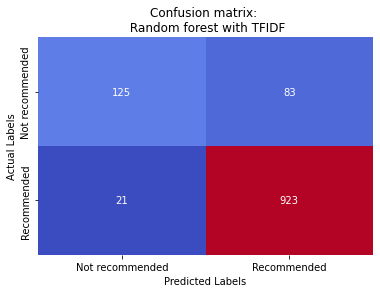

In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(pdf["Recommended IND"],pdf["prediction"])

import seaborn as sns
ax=sns.heatmap(cm, annot=True, fmt="d",cbar=False, cmap="coolwarm")
ax.set_title("Confusion matrix: \n Random forest with TFIDF")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('Actual Labels')
ax.yaxis.set_ticklabels(['Not recommended', 'Recommended'])
ax.xaxis.set_ticklabels(['Not recommended', 'Recommended'])

In [12]:
from sklearn.metrics import classification_report
print(start+"Classification report:"+end)
print(classification_report(pdf["Recommended IND"],pdf["prediction"],target_names=["Not recommended","Recommended"]))

Classification report:
                 precision    recall  f1-score   support

Not recommended       0.86      0.60      0.71       208
    Recommended       0.92      0.98      0.95       944

       accuracy                           0.91      1152
      macro avg       0.89      0.79      0.83      1152
   weighted avg       0.91      0.91      0.90      1152



In [13]:
auc_rf = binary_evaluator.evaluate(predictions_rf, {binary_evaluator.metricName: "areaUnderROC"}) #https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.evaluation.BinaryClassificationMetrics.html
aucPR_rf = binary_evaluator.evaluate(predictions_rf, {binary_evaluator.metricName: "areaUnderPR"})

print('Area under the receiver operating characteristic (ROC) curve = {:.4f}\nArea under the precision-recall curve                        = {:.4f}'.format(auc_rf,aucPR_rf))

22/08/04 09:43:20 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


22/08/04 09:43:31 WARN DAGScheduler: Broadcasting large task binary with size 10.7 MiB


Area under the receiver operating characteristic (ROC) curve = 0.9586
Area under the precision-recall curve                        = 0.9906
